In [62]:
#!/usr/bin/python

import simulate_visibilities.Bulm as Bulm
import simulate_visibilities.simulate_visibilities as sv
import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
import time, ephem, sys, os, resource, datetime, warnings
import aipy as ap
import os
#os.environ['QT_QPA_PLATFORM']='offscreen'
import sys
import matplotlib.pyplot as plt
import healpy as hp
import healpy.rotator as hpr
import healpy.pixelfunc as hpf
import healpy.visufunc as hpv
import scipy.interpolate as si
import glob
import astropy
from astropy.io import fits
import HERA_MapMaking_VisibilitySimulation as mmvs
from pyuvdata import UVData, UVCal, UVFITS
import hera_cal as hc
from hera_cal.data import DATA_PATH
from collections import OrderedDict as odict
from pyuvdata import utils as uvutils
import copy
import uvtools as uvt
import linsolve
from hera_cal.datacontainer import DataContainer
from astropy.time import Time
import omnical
import omnical.calibration_omni as omni
from memory_profiler import memory_usage as memuse
from collections import OrderedDict as odict
import pandas
import aipy.miriad as apm
import re
import copy
from hera_cal import utils, firstcal, cal_formats, redcal

PI = np.pi
TPI = PI * 2


def pixelize(sky, nside_distribution, nside_standard, nside_start, thresh, final_index, thetas, phis, sizes):
	# thetas = []
	# phis = []
	for inest in range(12 * nside_start ** 2):
		pixelize_helper(sky, nside_distribution, nside_standard, nside_start, inest, thresh, final_index, thetas, phis,
						sizes)
		# newt, newp = pixelize_helper(sky, nside_distribution, nside_standard, nside_start, inest, thresh, final_index, thetas, phis)
		# thetas += newt.tolist()
		# phis += newp.tolist()
		# return np.array(thetas), np.array(phis)


def pixelize_helper(sky, nside_distribution, nside_standard, nside, inest, thresh, final_index, thetas, phis, sizes):
	# print "visiting ", nside, inest
	starti, endi = inest * nside_standard ** 2 / nside ** 2, (inest + 1) * nside_standard ** 2 / nside ** 2
	##local mean###if nside == nside_standard or np.std(sky[starti:endi])/np.mean(sky[starti:endi]) < thresh:
	if nside == nside_standard or np.std(sky[starti:endi]) < thresh:
		nside_distribution[starti:endi] = nside
		final_index[starti:endi] = len(thetas)  # range(len(thetas), len(thetas) + endi -starti)
		# return hp.pix2ang(nside, [inest], nest=True)
		newt, newp = hp.pix2ang(nside, [inest], nest=True)
		thetas += newt.tolist()
		phis += newp.tolist()
		sizes += (np.ones_like(newt) * nside_standard ** 2 / nside ** 2).tolist()
		# sizes += (np.ones_like(newt) / nside**2).tolist()

	else:
		# thetas = []
		# phis = []
		for jnest in range(inest * 4, (inest + 1) * 4):
			pixelize_helper(sky, nside_distribution, nside_standard, nside * 2, jnest, thresh, final_index, thetas,
							phis, sizes)
			# newt, newp = pixelize_helper(sky, nside_distribution, nside_standard, nside * 2, jnest, thresh)
			# thetas += newt.tolist()
			# phis += newp.tolist()
			# return np.array(thetas), np.array(phis)


def dot(A, B, C, nchunk=10):
	if A.ndim != 2 or B.ndim != 2 or C.ndim != 2:
		raise ValueError("A B C not all have 2 dims: %i %i %i" % (str(A.ndim), str(B.ndim), str(C.ndim)))

	chunk = len(C) / nchunk
	for i in range(nchunk):
		C[i * chunk:(i + 1) * chunk] = A[i * chunk:(i + 1) * chunk].dot(B)
	if chunk * nchunk < len(C):
		C[chunk * nchunk:] = A[chunk * nchunk:].dot(B)


def ATNIA(A, Ni, C, nchunk=20):  # C=AtNiA
	if A.ndim != 2 or C.ndim != 2 or Ni.ndim != 1:
		raise ValueError("A, AtNiA and Ni not all have correct dims: %i %i %i"%(A.ndim, C.ndim, Ni.ndim))

	expected_time = 1.3e-11 * (A.shape[0]) * (A.shape[1])**2
	print "Estimated time for A %i by %i"%(A.shape[0], A.shape[1]), expected_time, "minutes",
	sys.stdout.flush()

	chunk = len(C) / nchunk
	for i in range(nchunk):
		ltm = time.time()
		C[i * chunk:(i + 1) * chunk] = np.einsum('ji,jk->ik', A[:, i * chunk:(i + 1) * chunk] * Ni[:, None], A)
		if expected_time >= 1.:
			print "%i/%i: %.5fmins"%(i, nchunk, (time.time() - ltm)/60.),
			sys.stdout.flush()
	if chunk * nchunk < len(C):
		C[chunk * nchunk:] = np.einsum('ji,jk->ik', A[:, chunk * nchunk:] * Ni[:, None], A)


def solve_phase_degen(data_xx, data_yy, model_xx, model_yy, ubls, plot=False):#data should be time by ubl at single freq. data * phasegensolution = model
	if data_xx.shape != data_yy.shape or data_xx.shape != model_xx.shape or data_xx.shape != model_yy.shape or data_xx.shape[1] != ubls.shape[0]:
		raise ValueError("Shapes mismatch: %s %s %s %s, ubl shape %s"%(data_xx.shape, data_yy.shape, model_xx.shape, model_yy.shape, ubls.shape))
	A = np.zeros((len(ubls) * 2, 2))
	b = np.zeros(len(ubls) * 2)

	nrow = 0
	for p, (data, model) in enumerate(zip([data_xx, data_yy], [model_xx, model_yy])):
		for u, ubl in enumerate(ubls):
			amp_mask = (np.abs(data[:, u]) > (np.median(np.abs(data[:, u])) / 2.))
			A[nrow] = ubl[:2]
			b[nrow] = omni.medianAngle(np.angle(model[:, u] / data[:, u])[amp_mask])
			nrow += 1
	phase_cal = omni.solve_slope(np.array(A), np.array(b), 1)
	if plot:
		plt.hist((np.array(A).dot(phase_cal)-b + PI)%TPI-PI)
		plt.title('phase fitting error')
		plt.show()

	#sooolve
	return phase_cal

class LastUpdatedOrderedDict(odict):
	'Store items in the order the keys were last added'

	def __setitem__(self, key, value):
		if key in self:
			del self[key]
		odict.__setitem__(self, key, value)

def S_casa_v_t(v, t = 2015.5):		
	S_0 = 2190.294 #S_casA_1GHz
	alpha =  0.725
	belta = 0.0148
	tau = 6.162*1.e-5

	a = -0.00633 #+-0.00024 year-1 
	b = 0.00039 #+-0.00008 year -1
	c = 1.509*1.e-7 #+-0.162*1.e-7 year-1
	
	v *= 1.e-3
	
	#print(v) # from MHz to GHz
	#print(t) # in decimal year
	
	S_casa_v = S_0 * v**(-alpha + belta * np.log(v)) * np.exp(-tau * v**(-2.1)) #S_0: 2015.5
	d_speed_log_v = a + b * np.log(v) + c * v**(-2.1) #a,b,c: 2005.0
	S_casa_v_t = np.exp((t - 2015.5) * d_speed_log_v + np.log(S_casa_v))
	
	#print(d_speed_log_v)
	
	return S_casa_v_t
	
def S_cyga_v(v, t = 2005):
	S_cyga_v = 3.835 * 1.e5 * v**(-0.718) * np.exp(-0.342 * (21.713/v)**2.1)
	
	return S_cyga_v

def UVData2AbsCalDict(datanames, pol_select=None, pop_autos=True, return_meta=False, filetype='miriad',
					  pick_data_ants=True):
	"""
	turn a list of pyuvdata.UVData objects or a list of miriad or uvfits file paths
	into the datacontainer dictionary form that AbsCal requires. This format is
	keys as antennas-pair + polarization format, Ex. (1, 2, 'xx')
	and values as 2D complex ndarrays with [0] axis indexing time and [1] axis frequency.

	Parameters:
	-----------
	datanames : list of either strings of data file paths or list of UVData instances
				to concatenate into a single dictionary

	pol_select : list of polarization strings to keep

	pop_autos : boolean, if True: remove autocorrelations

	return_meta : boolean, if True: also return antenna and unique frequency and LST arrays

	filetype : string, filetype of data if datanames is a string, options=['miriad', 'uvfits']
				can be ingored if datanames contains UVData objects.

	pick_data_ants : boolean, if True and return_meta=True, return only antennas in data

	Output:
	-------
	if return_meta is True:
		(data, flags, antpos, ants, freqs, times, lsts, pols)
	else:
		(data, flags)

	data : dictionary containing baseline-pol complex visibility data
	flags : dictionary containing data flags
	antpos : dictionary containing antennas numbers as keys and position vectors
	ants : ndarray containing unique antennas
	freqs : ndarray containing frequency channels (Hz)
	times : ndarray containing julian date bins of data
	lsts : ndarray containing LST bins of data (radians)
	pols : ndarray containing list of polarization index integers
	"""
	# check datanames is not a list
	if type(datanames) is not list and type(datanames) is not np.ndarray:
		if type(datanames) is str:
			# assume datanames is a file path
			uvd = UVData()
			suffix = os.path.splitext(datanames)[1]
			if filetype == 'uvfits' or suffix == '.uvfits':
				uvd.read_uvfits(datanames)
				uvd.unphase_to_drift()
			elif filetype == 'miriad':
				uvd.read_miriad(datanames)
		else:
			# assume datanames is a UVData instance
			uvd = datanames
	else:
		# if datanames is a list, check data types of elements
		if type(datanames[0]) is str:
			# assume datanames contains file paths
			uvd = UVData()
			suffix = os.path.splitext(datanames[0])[1]
			if filetype == 'uvfits' or suffix == '.uvfits':
				uvd.read_uvfits(datanames)
				uvd.unphase_to_drift()
			elif filetype == 'miriad':
				uvd.read_miriad(datanames)
		else:
			# assume datanames contains UVData instances
			uvd = reduce(operator.add, datanames)
	
	# load data
	d, f = firstcal.UVData_to_dict([uvd])
	
	# pop autos
	if pop_autos:
		for i, k in enumerate(d.keys()):
			if k[0] == k[1]:
				d.pop(k)
				f.pop(k)
	
	# turn into datacontainer
	data, flags = DataContainer(d), DataContainer(f)
	
	# get meta
	if return_meta:
		freqs = np.unique(uvd.freq_array)
		times = np.unique(uvd.time_array)
		lsts = np.unique(uvd.lst_array)
		antpos, ants = uvd.get_ENU_antpos(center=True, pick_data_ants=pick_data_ants)
		antpos = odict(zip(ants, antpos))
		pols = uvd.polarization_array
		return data, flags, antpos, ants, freqs, times, lsts, pols
	else:
		return data, flags


def UVData2AbsCalDict_Auto(datanames, pol_select=None, pop_autos=True, return_meta=False, filetype='miriad',
					  pick_data_ants=True):
	"""
	turn a list of pyuvdata.UVData objects or a list of miriad or uvfits file paths
	into the datacontainer dictionary form that AbsCal requires. This format is
	keys as antennas-pair + polarization format, Ex. (1, 2, 'xx')
	and values as 2D complex ndarrays with [0] axis indexing time and [1] axis frequency.

	Parameters:
	-----------
	datanames : list of either strings of data file paths or list of UVData instances
				to concatenate into a single dictionary

	pol_select : list of polarization strings to keep

	pop_autos : boolean, if True: remove autocorrelations

	return_meta : boolean, if True: also return antenna and unique frequency and LST arrays

	filetype : string, filetype of data if datanames is a string, options=['miriad', 'uvfits']
				can be ingored if datanames contains UVData objects.

	pick_data_ants : boolean, if True and return_meta=True, return only antennas in data

	Output:
	-------
	if return_meta is True:
		(data, flags, antpos, ants, freqs, times, lsts, pols, autocorr, autocorr_flags)
	else:
		(data, flags, autocorr, autocorr_flags))

	data : dictionary containing baseline-pol complex visibility data
	flags : dictionary containing data flags
	antpos : dictionary containing antennas numbers as keys and position vectors
	ants : ndarray containing unique antennas
	freqs : ndarray containing frequency channels (Hz)
	times : ndarray containing julian date bins of data
	lsts : ndarray containing LST bins of data (radians)
	pols : ndarray containing list of polarization index integers
	"""
	# check datanames is not a list
	if type(datanames) is not list and type(datanames) is not np.ndarray:
		if type(datanames) is str:
			# assume datanames is a file path
			uvd = UVData()
			suffix = os.path.splitext(datanames)[1]
			if filetype == 'uvfits' or suffix == '.uvfits':
				uvd.read_uvfits(datanames)
				uvd.unphase_to_drift()
			elif filetype == 'miriad':
				uvd.read_miriad(datanames)
		else:
			# assume datanames is a UVData instance
			uvd = datanames
	else:
		# if datanames is a list, check data types of elements
		if type(datanames[0]) is str:
			# assume datanames contains file paths
			uvd = UVData()
			suffix = os.path.splitext(datanames[0])[1]
			if filetype == 'uvfits' or suffix == '.uvfits':
				uvd.read_uvfits(datanames)
				uvd.unphase_to_drift()
			elif filetype == 'miriad':
				uvd.read_miriad(datanames)
		else:
			# assume datanames contains UVData instances
			uvd = reduce(operator.add, datanames)
	
	# load data
	d, f = firstcal.UVData_to_dict([uvd])
	autos = {}
	autos_flags = {}
	
	# pop autos
	if pop_autos:
		for i, k in enumerate(d.keys()):
			if k[0] == k[1]:
				autos[k] = d[k]
				autos_flags[k] = f[k]
				d.pop(k)
				f.pop(k)
	
	# turn into datacontainer
	data, flags = DataContainer(d), DataContainer(f)
	autos_pro, autos_flags_pro = DataContainer(autos), DataContainer(autos_flags)
	
	# get meta
	if return_meta:
		freqs = np.unique(uvd.freq_array)
		times = np.unique(uvd.time_array)
		lsts = np.unique(uvd.lst_array)
		antpos, ants = uvd.get_ENU_antpos(center=True, pick_data_ants=pick_data_ants)
		antpos = odict(zip(ants, antpos))
		pols = uvd.polarization_array
		return data, flags, antpos, ants, freqs, times, lsts, pols, autos_pro, autos_flags_pro
	else:
		return data, flags, autos_pro, autos_flags_pro


def set_lsts_from_time_array_hourangle(times, lon='21:25:41.9', lat='-30:43:17.5'):
	"""Set the lst_array based from the time_array."""
	lsts = []
	lst_array = np.zeros(len(np.unique(times)))
	# latitude, longitude, altitude = self.telescope_location_lat_lon_alt_degrees
	for ind, jd in enumerate(np.unique(times)):
		t = Time(jd, format='jd', location=(lon, lat))
		lst_array[np.where(np.isclose(
			jd, times, atol=1e-6, rtol=1e-12))] = t.sidereal_time('apparent').hourangle
	return lst_array

def set_lsts_from_time_array_radian(times, lon='21:25:41.9', lat='-30:43:17.5'):
	"""Set the lst_array based from the time_array."""
	lsts = []
	lst_array = np.zeros(len(np.unique(times)))
	# latitude, longitude, altitude = self.telescope_location_lat_lon_alt_degrees
	for ind, jd in enumerate(np.unique(times)):
		t = Time(jd, format='jd', location=(lon, lat))
		lst_array[np.where(np.isclose(
			jd, times, atol=1e-6, rtol=1e-12))] = t.sidereal_time('apparent').radian
	return lst_array

INSTRUMENT = ''

In [63]:
#####commandline inputs#####
if len(sys.argv) == 1:
	INSTRUMENT = 'hera47'
else:
	INSTRUMENT = sys.argv[1]#'miteor'#'mwa'#'hera-47''paper'

INSTRUMENT = 'hera47' #'hera47'; 'miteor'
print INSTRUMENT

tag = '-ampcal-' #'-ampcal-' #sys.argv[2]; if use real uncalibrated data, set tag = '-ampcal-' for amplitude calibration.

AtNiA_only = False
if len(sys.argv) > 3 and sys.argv[3][:5] == 'atnia':
	AtNiA_only = True
	pixel_scheme_number = int(sys.argv[3][5:])
	
simulation_opt = 1

plotcoord = 'CG'
baseline_safety_factor = 0.3 #max_ubl = 1.4*lambda/baseline_safety_factor
crosstalk_type = 'autocorr'
#pixel_directory = '/home/omniscope/data/GSM_data/absolute_calibrated_data/'

plot_pixelization = True and not AtNiA_only
plot_projection = True and not AtNiA_only
plot_data_error = True and not AtNiA_only

force_recompute = False
force_recompute_AtNiAi_eig = False
force_recompute_AtNiAi = False
force_recompute_S = False
force_recompute_SEi = False

C = 299.792458
kB = 1.3806488 * 1.e-23

try:
	__file__
except NameError:
	#script_dir = '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/simulate_visibilities/scripts'
	script_dir = os.path.join(DATA_PATH, '../../../HERA_MapMaking_VisibilitySimulation/scripts')
	pixel_directory = script_dir
	print 'Run IPython'
else:
	script_dir = os.path.dirname(os.path.realpath(__file__))
	pixel_directory = script_dir
	print 'Run Python'


hera47
Run IPython


In [64]:
len(sys.argv)
DATA_PATH

'/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data'

Nfiles: 1
/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/ObservingSession-1192201262/2458043/zen.2458043.12552.xx.HH.uvOR
/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/ObservingSession-1192201262/2458043/zen.2458043.12552.xx.HH.uvOR
Pol_xx is done. 17.5365200043 seconds used.
/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/ObservingSession-1192201262/2458043/zen.2458043.12552.yy.HH.uvOR
/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/ObservingSession-1192201262/2458043/zen.2458043.12552.yy.HH.uvOR
Pol_yy is done. 17.2070310116 seconds used.
Time_Average: 12; Frequency_Average: 16.
Remove_Times: -60; Remove_Freqs: -1024.
rawData_Shape-(0, 86, 'xx'): (60, 1024)
rawDflags_Shape-(0, 86, 'xx'): (60, 1024)
rawAutocorr_Sha

rawData_Shape-(66, 120, 'xx'): (60, 1024)
rawDflags_Shape-(66, 120, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(0, 67, 'xx'): (60, 1024)
rawDflags_Shape-(0, 67, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(25, 71, 'xx'): (60, 1024)
rawDflags_Shape-(25, 71, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(11, 83, 'xx'): (60, 1024)
rawDflags_Shape-(11, 83, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(67, 142, 'xx'): (60, 1024)
rawDflags_Shape-(67, 142, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(71, 143, 'xx'): (60, 1024)
rawDflags_Shape-(71, 143, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60

rawData_Shape-(53, 69, 'xx'): (60, 1024)
rawDflags_Shape-(53, 69, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(83, 141, 'xx'): (60, 1024)
rawDflags_Shape-(83, 141, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(67, 71, 'xx'): (60, 1024)
rawDflags_Shape-(67, 71, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(39, 54, 'xx'): (60, 1024)
rawDflags_Shape-(39, 54, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(85, 120, 'xx'): (60, 1024)
rawDflags_Shape-(85, 120, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(41, 71, 'xx'): (60, 1024)
rawDflags_Shape-(41, 71, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60

rawData_Shape-(83, 85, 'xx'): (60, 1024)
rawDflags_Shape-(83, 85, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(55, 86, 'xx'): (60, 1024)
rawDflags_Shape-(55, 86, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(1, 52, 'xx'): (60, 1024)
rawDflags_Shape-(1, 52, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(25, 55, 'xx'): (60, 1024)
rawDflags_Shape-(25, 55, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(67, 120, 'xx'): (60, 1024)
rawDflags_Shape-(67, 120, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(67, 143, 'xx'): (60, 1024)
rawDflags_Shape-(67, 143, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
r

rawData_Shape-(52, 84, 'xx'): (60, 1024)
rawDflags_Shape-(52, 84, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(50, 52, 'xx'): (60, 1024)
rawDflags_Shape-(50, 52, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(24, 120, 'xx'): (60, 1024)
rawDflags_Shape-(24, 120, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(38, 88, 'xx'): (60, 1024)
rawDflags_Shape-(38, 88, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(50, 88, 'xx'): (60, 1024)
rawDflags_Shape-(50, 88, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(2, 120, 'xx'): (60, 1024)
rawDflags_Shape-(2, 120, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
r

rawData_Shape-(12, 143, 'xx'): (60, 1024)
rawDflags_Shape-(12, 143, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(13, 23, 'xx'): (60, 1024)
rawDflags_Shape-(13, 23, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(0, 52, 'xx'): (60, 1024)
rawDflags_Shape-(0, 52, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(14, 36, 'xx'): (60, 1024)
rawDflags_Shape-(14, 36, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(11, 98, 'xx'): (60, 1024)
rawDflags_Shape-(11, 98, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(0, 141, 'xx'): (60, 1024)
rawDflags_Shape-(0, 141, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
raw

rawData_Shape-(36, 85, 'xx'): (60, 1024)
rawDflags_Shape-(36, 85, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(51, 87, 'xx'): (60, 1024)
rawDflags_Shape-(51, 87, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(2, 69, 'xx'): (60, 1024)
rawDflags_Shape-(2, 69, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(41, 65, 'xx'): (60, 1024)
rawDflags_Shape-(41, 65, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(13, 85, 'xx'): (60, 1024)
rawDflags_Shape-(13, 85, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(37, 40, 'xx'): (60, 1024)
rawDflags_Shape-(37, 40, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawDa

rawData_Shape-(12, 25, 'xx'): (60, 1024)
rawDflags_Shape-(12, 25, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(24, 143, 'xx'): (60, 1024)
rawDflags_Shape-(24, 143, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(55, 120, 'xx'): (60, 1024)
rawDflags_Shape-(55, 120, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(121, 123, 'xx'): (60, 1024)
rawDflags_Shape-(121, 123, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(25, 142, 'xx'): (60, 1024)
rawDflags_Shape-(25, 142, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(41, 142, 'xx'): (60, 1024)
rawDflags_Shape-(41, 142, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_T

rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(0, 66, 'xx'): (60, 1024)
rawDflags_Shape-(0, 66, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(40, 50, 'xx'): (60, 1024)
rawDflags_Shape-(40, 50, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(26, 88, 'xx'): (60, 1024)
rawDflags_Shape-(26, 88, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(69, 143, 'xx'): (60, 1024)
rawDflags_Shape-(69, 143, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(36, 40, 'xx'): (60, 1024)
rawDflags_Shape-(36, 40, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(52, 66, 'xx'): (60, 1024)
rawDflags_Shape-(52, 66, 'xx'

rawData_Shape-(84, 87, 'xx'): (60, 1024)
rawDflags_Shape-(84, 87, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(65, 143, 'xx'): (60, 1024)
rawDflags_Shape-(65, 143, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(65, 67, 'xx'): (60, 1024)
rawDflags_Shape-(65, 67, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(66, 143, 'xx'): (60, 1024)
rawDflags_Shape-(66, 143, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(26, 37, 'xx'): (60, 1024)
rawDflags_Shape-(26, 37, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(53, 82, 'xx'): (60, 1024)
rawDflags_Shape-(53, 82, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60

rawData_Shape-(67, 121, 'xx'): (60, 1024)
rawDflags_Shape-(67, 121, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(86, 120, 'xx'): (60, 1024)
rawDflags_Shape-(86, 120, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(2, 50, 'xx'): (60, 1024)
rawDflags_Shape-(2, 50, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(26, 55, 'xx'): (60, 1024)
rawDflags_Shape-(26, 55, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(14, 82, 'xx'): (60, 1024)
rawDflags_Shape-(14, 82, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(11, 124, 'xx'): (60, 1024)
rawDflags_Shape-(11, 124, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60

rawData_Shape-(82, 123, 'xx'): (60, 1024)
rawDflags_Shape-(82, 123, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(50, 53, 'xx'): (60, 1024)
rawDflags_Shape-(50, 53, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(11, 38, 'xx'): (60, 1024)
rawDflags_Shape-(11, 38, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(26, 82, 'xx'): (60, 1024)
rawDflags_Shape-(26, 82, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(38, 82, 'xx'): (60, 1024)
rawDflags_Shape-(38, 82, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(36, 38, 'xx'): (60, 1024)
rawDflags_Shape-(36, 38, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
r

rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(82, 143, 'xx'): (60, 1024)
rawDflags_Shape-(82, 143, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(68, 70, 'xx'): (60, 1024)
rawDflags_Shape-(68, 70, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(0, 1, 'xx'): (60, 1024)
rawDflags_Shape-(0, 1, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(40, 120, 'xx'): (60, 1024)
rawDflags_Shape-(40, 120, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(124, 143, 'xx'): (60, 1024)
rawDflags_Shape-(124, 143, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(1, 12, 'xx'): (60, 1024)
rawDflags_Shape-(1, 12, 'xx'): (60, 1024)
rawAutocorr_Sh

rawData_Shape-(23, 124, 'xx'): (60, 1024)
rawDflags_Shape-(23, 124, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(67, 87, 'xx'): (60, 1024)
rawDflags_Shape-(67, 87, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(65, 123, 'xx'): (60, 1024)
rawDflags_Shape-(65, 123, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(0, 12, 'xx'): (60, 1024)
rawDflags_Shape-(0, 12, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(83, 88, 'xx'): (60, 1024)
rawDflags_Shape-(83, 88, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(121, 141, 'xx'): (60, 1024)
rawDflags_Shape-(121, 141, 'xx'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 

rawData_Shape-(52, 68, 'yy'): (60, 1024)
rawDflags_Shape-(52, 68, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(0, 98, 'yy'): (60, 1024)
rawDflags_Shape-(0, 98, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(51, 98, 'yy'): (60, 1024)
rawDflags_Shape-(51, 98, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(26, 120, 'yy'): (60, 1024)
rawDflags_Shape-(26, 120, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(27, 122, 'yy'): (60, 1024)
rawDflags_Shape-(27, 122, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(38, 40, 'yy'): (60, 1024)
rawDflags_Shape-(38, 40, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
r

rawData_Shape-(36, 141, 'yy'): (60, 1024)
rawDflags_Shape-(36, 141, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(11, 26, 'yy'): (60, 1024)
rawDflags_Shape-(11, 26, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(50, 51, 'yy'): (60, 1024)
rawDflags_Shape-(50, 51, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(14, 53, 'yy'): (60, 1024)
rawDflags_Shape-(14, 53, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(40, 124, 'yy'): (60, 1024)
rawDflags_Shape-(40, 124, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(2, 142, 'yy'): (60, 1024)
rawDflags_Shape-(2, 142, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60

rawData_Shape-(71, 83, 'yy'): (60, 1024)
rawDflags_Shape-(71, 83, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(68, 87, 'yy'): (60, 1024)
rawDflags_Shape-(68, 87, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(1, 51, 'yy'): (60, 1024)
rawDflags_Shape-(1, 51, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(36, 120, 'yy'): (60, 1024)
rawDflags_Shape-(36, 120, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(87, 120, 'yy'): (60, 1024)
rawDflags_Shape-(87, 120, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(0, 40, 'yy'): (60, 1024)
rawDflags_Shape-(0, 40, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
raw

rawData_Shape-(39, 121, 'yy'): (60, 1024)
rawDflags_Shape-(39, 121, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(0, 69, 'yy'): (60, 1024)
rawDflags_Shape-(0, 69, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(11, 85, 'yy'): (60, 1024)
rawDflags_Shape-(11, 85, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(71, 124, 'yy'): (60, 1024)
rawDflags_Shape-(71, 124, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(25, 67, 'yy'): (60, 1024)
rawDflags_Shape-(25, 67, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(39, 87, 'yy'): (60, 1024)
rawDflags_Shape-(39, 87, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
r

rawData_Shape-(36, 143, 'yy'): (60, 1024)
rawDflags_Shape-(36, 143, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(82, 87, 'yy'): (60, 1024)
rawDflags_Shape-(82, 87, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(1, 143, 'yy'): (60, 1024)
rawDflags_Shape-(1, 143, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(37, 142, 'yy'): (60, 1024)
rawDflags_Shape-(37, 142, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(24, 141, 'yy'): (60, 1024)
rawDflags_Shape-(24, 141, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(98, 121, 'yy'): (60, 1024)
rawDflags_Shape-(98, 121, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times

rawData_Shape-(55, 142, 'yy'): (60, 1024)
rawDflags_Shape-(55, 142, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(2, 54, 'yy'): (60, 1024)
rawDflags_Shape-(2, 54, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(84, 88, 'yy'): (60, 1024)
rawDflags_Shape-(84, 88, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(11, 120, 'yy'): (60, 1024)
rawDflags_Shape-(11, 120, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(65, 124, 'yy'): (60, 1024)
rawDflags_Shape-(65, 124, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(25, 86, 'yy'): (60, 1024)
rawDflags_Shape-(25, 86, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60

rawData_Shape-(51, 87, 'yy'): (60, 1024)
rawDflags_Shape-(51, 87, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(2, 69, 'yy'): (60, 1024)
rawDflags_Shape-(2, 69, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(41, 65, 'yy'): (60, 1024)
rawDflags_Shape-(41, 65, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(13, 85, 'yy'): (60, 1024)
rawDflags_Shape-(13, 85, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(37, 40, 'yy'): (60, 1024)
rawDflags_Shape-(37, 40, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(52, 82, 'yy'): (60, 1024)
rawDflags_Shape-(52, 82, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawDa

rawData_Shape-(39, 53, 'yy'): (60, 1024)
rawDflags_Shape-(39, 53, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(70, 141, 'yy'): (60, 1024)
rawDflags_Shape-(70, 141, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(0, 25, 'yy'): (60, 1024)
rawDflags_Shape-(0, 25, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(1, 141, 'yy'): (60, 1024)
rawDflags_Shape-(1, 141, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(12, 25, 'yy'): (60, 1024)
rawDflags_Shape-(12, 25, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(24, 143, 'yy'): (60, 1024)
rawDflags_Shape-(24, 143, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
r

rawData_Shape-(11, 122, 'yy'): (60, 1024)
rawDflags_Shape-(11, 122, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(12, 68, 'yy'): (60, 1024)
rawDflags_Shape-(12, 68, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(27, 36, 'yy'): (60, 1024)
rawDflags_Shape-(27, 36, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(1, 41, 'yy'): (60, 1024)
rawDflags_Shape-(1, 41, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(25, 84, 'yy'): (60, 1024)
rawDflags_Shape-(25, 84, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(39, 124, 'yy'): (60, 1024)
rawDflags_Shape-(39, 124, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
r

rawData_Shape-(11, 27, 'yy'): (60, 1024)
rawDflags_Shape-(11, 27, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(14, 52, 'yy'): (60, 1024)
rawDflags_Shape-(14, 52, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(40, 123, 'yy'): (60, 1024)
rawDflags_Shape-(40, 123, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(98, 122, 'yy'): (60, 1024)
rawDflags_Shape-(98, 122, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(25, 70, 'yy'): (60, 1024)
rawDflags_Shape-(25, 70, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(23, 82, 'yy'): (60, 1024)
rawDflags_Shape-(23, 82, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60

rawData_Shape-(82, 124, 'yy'): (60, 1024)
rawDflags_Shape-(82, 124, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(1, 71, 'yy'): (60, 1024)
rawDflags_Shape-(1, 71, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(52, 69, 'yy'): (60, 1024)
rawDflags_Shape-(52, 69, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(50, 85, 'yy'): (60, 1024)
rawDflags_Shape-(50, 85, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(11, 51, 'yy'): (60, 1024)
rawDflags_Shape-(11, 51, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(26, 121, 'yy'): (60, 1024)
rawDflags_Shape-(26, 121, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
r

rawData_Shape-(38, 65, 'yy'): (60, 1024)
rawDflags_Shape-(38, 65, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(2, 65, 'yy'): (60, 1024)
rawDflags_Shape-(2, 65, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(83, 123, 'yy'): (60, 1024)
rawDflags_Shape-(83, 123, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(50, 71, 'yy'): (60, 1024)
rawDflags_Shape-(50, 71, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(54, 65, 'yy'): (60, 1024)
rawDflags_Shape-(54, 65, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(51, 65, 'yy'): (60, 1024)
rawDflags_Shape-(51, 65, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
raw

rawData_Shape-(71, 142, 'yy'): (60, 1024)
rawDflags_Shape-(71, 142, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(13, 55, 'yy'): (60, 1024)
rawDflags_Shape-(13, 55, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(71, 88, 'yy'): (60, 1024)
rawDflags_Shape-(71, 88, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(51, 82, 'yy'): (60, 1024)
rawDflags_Shape-(51, 82, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(23, 98, 'yy'): (60, 1024)
rawDflags_Shape-(23, 98, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(67, 85, 'yy'): (60, 1024)
rawDflags_Shape-(67, 85, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
r

rawData_Shape-(36, 124, 'yy'): (60, 1024)
rawDflags_Shape-(36, 124, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(52, 54, 'yy'): (60, 1024)
rawDflags_Shape-(52, 54, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(0, 84, 'yy'): (60, 1024)
rawDflags_Shape-(0, 84, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(14, 68, 'yy'): (60, 1024)
rawDflags_Shape-(14, 68, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(11, 66, 'yy'): (60, 1024)
rawDflags_Shape-(11, 66, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(53, 55, 'yy'): (60, 1024)
rawDflags_Shape-(53, 55, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
raw

rawData_Shape-(67, 69, 'yy'): (60, 1024)
rawDflags_Shape-(67, 69, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(39, 52, 'yy'): (60, 1024)
rawDflags_Shape-(39, 52, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(122, 142, 'yy'): (60, 1024)
rawDflags_Shape-(122, 142, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(26, 27, 'yy'): (60, 1024)
rawDflags_Shape-(26, 27, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(0, 26, 'yy'): (60, 1024)
rawDflags_Shape-(0, 26, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
rawData_Lsts: 60
rawData_Shape-(12, 26, 'yy'): (60, 1024)
rawDflags_Shape-(12, 26, 'yy'): (60, 1024)
rawAutocorr_Shape: (60, 1024)
rawData_Freqs: 1024
rawData_Times: 60
r

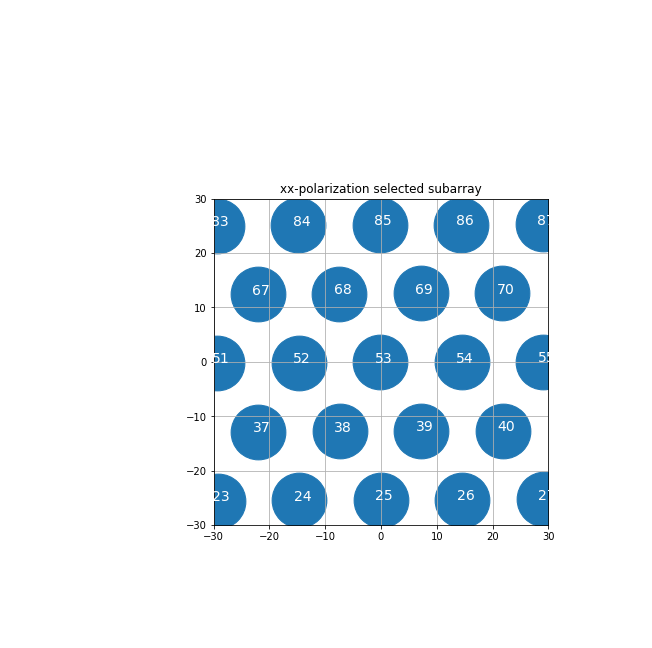

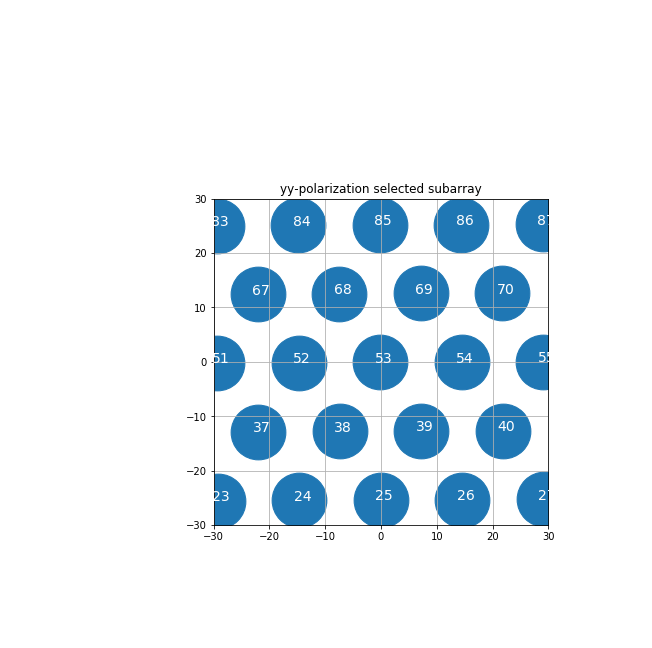

>>>>>>Used nUBL = 74, nt = 5.
Frequencies: 
[ 50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.
  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.
  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.
  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105.
 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119.
 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133.
 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147.
 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161.
 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175.
 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189.
 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200. 201. 202. 203.
 204. 205. 206. 207. 208. 209. 210. 211. 212. 213. 214. 215. 216. 217.
 218. 219. 220. 221. 222. 223. 224. 225. 226. 227. 228. 229. 230. 231.
 232. 233. 234. 235. 236. 237. 23

In [65]:
####################################################
################data file and load beam##############
####################################################
if INSTRUMENT == 'miteor':
# 	Simulation = True
# 	Use_SimulatedData = False
# 	Use_Simulation_noise = False
	
	sys.stdout.flush()
	Simulation = True
	Use_SimulatedData = False
	Use_Simulation_noise = True
	From_File_Data = True
	Keep_Red = False
	Absolute_Calibration = False
	Absolute_Calibration_red = False
	Absolute_Calibration_mfreq = False
	Absolute_Calibration_dred = False
	Absolute_Calibration_dred_mfreq = False
	PointSource_AbsCal = False
	Absolute_Calibration_dred_mfreq_pscal = False
	
	Use_AbsCal = False  # Use Model calculated noise which is just fullsim autocorr calculated noise.
	Use_PsAbsCal = False  # higher priority over Use_AbsCal and Use_Fullsim_Noise. if comply_ps2mod_autocorr then become just fullsim autocorr calculated noise.
	comply_ps2mod_autocorr = False
	Use_Fullsim_Noise = False  # Use fullsim autocorr calculated noise.
	
	Replace_Data = True	
	
	seek_optimal_threshs = False and not AtNiA_only
	dynamic_precision = .2  # .1#ratio of dynamic pixelization error vs data std, in units of data, so not power
	thresh = 2  # .2#2.#.03125#
	valid_pix_thresh = 1.e-4
	nside_start = 32
	nside_standard = 32  # Determine the resolution of GSM of sky
	
	pre_calibrate = True
	tag = '-ampcal-' if pre_calibrate else ''  # '-ampcal-' #sys.argv[2]; if use real uncalibrated data, set tag = '-ampcal-' for amplitude calibration.
	pre_ampcal = ('ampcal' in tag)
	pre_phscal = True
	pre_addcal = True
	fit_for_additive = False
	nside_beamweight = 16  # Determin shape of A matrix
	
	Erase = True
	
	Add_S_diag = False
	Add_Rcond = True
	Data_Deteriorate = False
	
	S_type = 'dyS_lowadduniform_lowI'  # 'dyS_lowadduniform_lowI'#'none'#'dyS_lowadduniform_Iuniform'  #'none'# dynamic S, addlimit:additive same level as max data; lowaddlimit: 10% of max data; lowadduniform: 10% of median max data; Iuniform median of all data
	# 	S_type = 'dyS_lowadduniform_min18I' if Add_S_diag else 'no_use' #'dyS_lowadduniform_minI', 'dyS_lowadduniform_I', 'dyS_lowadduniform_lowI', 'dyS_lowadduniform_lowI'#'none'#'dyS_lowadduniform_Iuniform'  #'none'# dynamic S, addlimit:additive same level as max data; lowaddlimit: 10% of max data; lowadduniform: 10% of median max data; Iuniform median of all data
	rcond_list = 10. ** np.arange(-6., -0., 1.)
	if Data_Deteriorate:
		S_type += '-deteriorated-'
	else:
		pass
	
	Integration_Time = 2.7  # seconds
	Frequency_Bin = 0.5 * 1.e6  # Hz
    
	lat_degree = 45.2977
	lst_offset = 5.#lsts will be wrapped around [lst_offset, 24+lst_offset]
    
#	# tag = "q3AL_5_abscal"  #"q0AL_13_abscal"  #"q1AL_10_abscal"'q3_abscalibrated'#"q4AL_3_abscal"# L stands for lenient in flagging
	if 'ampcal' in tag:
		datatag = '_2016_01_20-ampcal'#'_seccasa.rad'#
		vartag = '_2016_01_20-ampcal'#''#
	else:
		datatag = '_2016_01_20'#'_2016_01_20_avg_unpollock'#'_seccasa.rad'#
		vartag = '_2016_01_20'#'_2016_01_20_avg_unpollockx100'#''#
#	datadir = '/home/omniscope/data/GSM_data/absolute_calibrated_data/'
	datadir = script_dir + '/../Output/'
	antpairs = None
	# deal with beam: create a callable function of the form y(freq) in MHz and returns 2 by npix
	
	
	############################################ Load Beam and Visibility Data ###########################################
	flist = {}
	vis_freq_list = flist[0] = flist[1] = np.array([126.83333,127.6667,128.5000,129.3333,130.1667,131.0000,131.8333,132.6667,133.5000,134.3333,135.1667,136.0000,136.8333,137.6667,139.3333,140.0000,141.83333,142.6667,143.5000,144.3333,145.0000,145.1667,146.0000,146.6667,147.5000,148.3333,150.8333,151.6667,152.5000,153.3333,154.1667,155.0000,155.8333,156.0000,156.6667,156.8333,159.3333,161.8333,164.3333,166.8333,167.8333,170.3333,172.8333])
	freq = vis_freq_selected = 150.8333 #MHz
	
	if tag == '-ampcal-':
		tag = '%s-%f'%(INSTRUMENT, freq) + tag
	else:
		tag = '%s-%f'%(INSTRUMENT, freq)
	
	bnside = 64 #Depend on beam pattern data
	freqs = range(110, 200, 10)
	local_beam_unpol = si.interp1d(freqs, np.array([la.norm(np.loadtxt(
		script_dir + '/../data/MITEoR/beam/%s.txt'%(p), skiprows=0).reshape(
		(len(freqs), 12 * bnside ** 2, 4)), axis=-1)**2 for p in ['x', 'y']]).transpose(1, 0, 2), axis=0)
	Plot_Beam = True
	if Plot_Beam:
		plt.figure(0)
		#ind = np.where(beam_freqs == freq)[0][0]
		hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
				unit='dBi')
	#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
	#             unit='dBi')
		plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
				unit='dBi')
	#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
	#             unit='dBi')
		plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		plt.show(block=False)
		#plt.gcf().clear()
			#plt.clf()
			#plt.close()
			
	time_vis_data = np.array([np.loadtxt(script_dir + '/../data/MITEoR/visibilities/%sMHz_%s%s_A.txt'%(vis_freq_selected,p,p)) for p in ['x','y']])
	
	vis_data = (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex128')
	var_data = time_vis_data[:,1:,3::3]
	
	tlist = time_vis_data[0,1:,0]
	tmasks = {}
	for p in ['x', 'y']:
		tmasks[p] = np.ones_like(tlist).astype(bool)

	tmask = tmasks['x']&tmasks['y']
	tlist = lsts = tlist[tmask]
	nt = nt_used = len(tlist)
	jansky2kelvin = 1.e-26 * (C / freq) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2))
	nUBL = int(len(time_vis_data[0,0,:])/3)
	
	ubls = {}
	for p in range(2):
		ubls[['x','y'][p]] = time_vis_data[p,0,1:].reshape((nUBL,3))		
	common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	#manually filter UBLs
	used_common_ubls = common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nUBL_used = len(used_common_ubls)
	ubl_index = {}  # stored index in each pol's ubl for the common ubls
	for p in ['x', 'y']:
		ubl_index[p] = np.zeros(nUBL_used, dtype='int')
		for i, u in enumerate(used_common_ubls):
			if u in ubls[p]:
				ubl_index[p][i] = np.argmin(la.norm(ubls[p] - u, axis=-1)) + 1
			elif -u in ubls[p]:
				ubl_index[p][i] = - np.argmin(la.norm(ubls[p] + u, axis=-1)) - 1
			else:
				raise Exception('Logical Error')
                
	redundancy = used_redundancy = {}
	for i in range(2):
		used_redundancy[i] = redundancy[i] = np.ones_like(ubl_index)
        
	print '>>>>>>Used nUBL = %i, nt = %i.'%(nUBL_used, nt_used)
	sys.stdout.flush()	
	
	
elif INSTRUMENT == 'hera47':
	Simulation = True
	Use_SimulatedData = True
	Use_Simulation_noise = True
	From_File_Data = True
	Keep_Red = False
	
	Absolute_Calibration = False
	Absolute_Calibration_red = False
	Absolute_Calibration_mfreq = False
	Absolute_Calibration_dred = False
	
	Absolute_Calibration_dred_mfreq = True # The only working Model Calibration Method.
	Fake_wgts_dred_mfreq = True # Remove Flags for Model Calibration.
	PointSource_AbsCal = True
	PointSource_AbsCal_SingleFreq = False if PointSource_AbsCal else False
	Absolute_Calibration_dred_mfreq_pscal = False
	
	Use_AbsCal = True if Absolute_Calibration_dred_mfreq else False  # Use Model calculated noise which is just fullsim autocorr calculated noise and data.
	Use_PsAbsCal = True if PointSource_AbsCal else False  # higher priority over Use_AbsCal and Use_Fullsim_Noise. if comply_ps2mod_autocorr then become just fullsim autocorr calculated noise. To use Pscaled data.
	comply_ps2mod_autocorr = False
	Use_Fullsim_Noise = False  # Use fullsim autocorr calculated noise.
	
	Replace_Data = True
	
	pre_calibrate = True
	tag = '-ampcal-' if pre_calibrate else ''  # '-ampcal-' #sys.argv[2]; if use real uncalibrated data, set tag = '-ampcal-' for amplitude calibration.
	pre_ampcal = ('ampcal' in tag)
	pre_phscal = True
	pre_addcal = False
	fit_for_additive = True
	
	Erase = True
	
	Add_S_diag = False
	Add_Rcond = True
	
	Small_ModelData = False
	Model_Calibration = False
	
	Data_Deteriorate =  False
	
	Time_Expansion_Factor = 73. if Use_SimulatedData else 1.
	Lst_Hourangle = True
	
	Compress_Average = True
	Time_Average = 12
	Frequency_Average = 16 if not Small_ModelData else 1
	Mocal_time_bin_temp = 600
	Mocal_freq_bin_temp = 600
	Precal_time_bin_temp = 600 
	
	sys.stdout.flush()
	
	lat_degree = -30.72153  # lon='21:25:41.9' lat='-30:43:17.5'
	lst_offset = 1.43  # lsts will be wrapped around [lst_offset, 24+lst_offset]
	
	Integration_Time = 11  # seconds
	Frequency_Bin = 1.625 * 1.e6  # Hz
	
	S_type = 'dyS_lowadduniform_min4I' if Add_S_diag else 'no_use'  # 'dyS_lowadduniform_minI', 'dyS_lowadduniform_I', 'dyS_lowadduniform_lowI', 'dyS_lowadduniform_lowI'#'none'#'dyS_lowadduniform_Iuniform'  #'none'# dynamic S, addlimit:additive same level as max data; lowaddlimit: 10% of max data; lowadduniform: 10% of median max data; Iuniform median of all data
	rcond_list = 10. ** np.arange(-20., -1., 1.)
	if Data_Deteriorate:
		S_type += '-deteriorated-'
	else:
		pass

	seek_optimal_threshs = False and not AtNiA_only
	dynamic_precision = .2  # .1#ratio of dynamic pixelization error vs data std, in units of data, so not power
	thresh = 2  # .2#2.#.03125#
	valid_pix_thresh = 1.e-4
	nside_start = 32 # starting point to calculate dynamic A
	nside_standard = 32  # resolution of sky, dynamic A matrix length of a row before masking.
	nside_beamweight = 32  # undynamic A matrix shape
	bnside = 64  # beam pattern data resolution
	
	#	# tag = "q3AL_5_abscal"  #"q0AL_13_abscal"  #"q1AL_10_abscal"'q3_abscalibrated'#"q4AL_3_abscal"# L stands for lenient in flagging
	if 'ampcal' in tag:
		datatag = '_2018'  # '_seccasa.rad'#
		vartag = '_2018'  # ''#
	else:
		datatag = '_2018_ampcaled'  # '_2016_01_20_avg_unpollock'#'_seccasa.rad'#
		vartag = '_2018_ampcaled'  # '_2016_01_20_avg_unpollockx100'#''#
	datadir = script_dir + '/../Output/'
	antpairs = None
	
	#######################################################################################################
	##################################### Load Visibility Data ###########################################
	# specify model file and load into UVData, load into dictionary
	timer_loading = time.time()
	model_fname = {}
	model = {}
	mflags = {}
	mantpos = {}
	mants = {}
	model_freqs = {}
	model_times = {}
	model_lsts = {}
	model_pols = {}
	model_autos = {}
	model_autos_flags = {}
	
	data_fname = {}
	data_fname_full = {}
	dflags = {}
	data = {}
	antpos = {}
	ants = {}
	data_freqs = {}
	data_times = {}
	data_lsts = {}
	data_pols = {}
	data_autos = {}
	data_autos_flags = {}
	
	fulldflags = {}
	
	data_fnames = {}
	files_basses = {}
	file_times = {}
	
	autocorr_data_mfreq = {}  # np.zeros((2, Ntimes, Nfreqs))
	autocorr_data = {}
	Nfiles = min(73, len(glob.glob("{0}/zen.*.*.xx.HH.uvOR".format(DATA_PATH + '/ObservingSession-1192201262/2458043/'))), len(glob.glob("{0}/zen.*.*.yy.HH.uvOR".format(DATA_PATH + '/ObservingSession-1192201262/2458043/'))))
	
	flist = {}
	index_freq = {}
	
	try:
		data_fnames[0] = xxfiles = sorted((glob.glob("{0}/zen.*.*.xx.HH.uvOR".format(DATA_PATH + '/ObservingSession-1192201262/2458043/'))))[:Nfiles]
		data_fnames[1] = yyfiles = sorted((glob.glob("{0}/zen.*.*.yy.HH.uvOR".format(DATA_PATH + '/ObservingSession-1192201262/2458043/'))))[:Nfiles]
		
		file_times[0] = xxfile_bases = map(os.path.basename, xxfiles)
		file_times[1] = yyfile_bases = map(os.path.basename, yyfiles)
		
		file_times[0] = xxfile_times = np.array(map(lambda x: '.'.join(os.path.basename(x).split('.')[1:3]), xxfiles), np.float)
		file_times[1] = yyfile_times = np.array(map(lambda y: '.'.join(os.path.basename(y).split('.')[1:3]), yyfiles), np.float)
		
		print ('Nfiles: %s' % Nfiles)
	except:
		pass
	
	if Small_ModelData:
		if Model_Calibration:
			
			#model = mflags = mantpos = mant = model_freqs = model_times = model_lsts = model_pols = {}
			for i in range(2):
				model_fname[i] = os.path.join(DATA_PATH, "zen.2458042.12552.%s.HH.uvXA" % ['xx', 'yy'][i])  # /Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv
				# model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA") #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv
				if i == 1:
					try:
						# data_fname[1] = os.path.join(DATA_PATH, "zen.2458043.12552.yy.HH.uvORA") #zen.2457698.40355.yy.HH.uvcA
						if not os.path.isfile(model_fname[i]):
							model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA")
					except:
						pass
				(model[i], mflags[i], mantpos[i], mants[i], model_freqs[i], model_times[i], model_lsts[i], model_pols[i], model_autos[i], model_autos_flags[i]) = UVData2AbsCalDict_Auto(model_fname[i], return_meta=True)
				print('model_Pol_%s is done.' % ['xx', 'yy'][i])
		# specify data file and load into UVData, load into dictionary
		for i in range(2):
			data_fname[i] = os.path.join(DATA_PATH, "zen.2458043.12552.%s.HH.uvORA" % ['xx', 'yy'][i])  # zen.2457698.40355.xx.HH.uvcA
			if i == 1:
				try:
					# data_fname[1] = os.path.join(DATA_PATH, "zen.2458043.12552.yy.HH.uvORA") #zen.2457698.40355.yy.HH.uvcA
					if not os.path.isfile(data_fname[i]):
						data_fname[1] = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
				except:
					pass
			data_fname_full[i] = os.path.join(DATA_PATH, 'ObservingSession-1192201262/2458043/zen.2458043.12552.%s.HH.uvOR' % ['xx', 'yy'][i])
			# (data[i], dflags[i], antpos[i], ants[i], data_freqs[i], data_times[i], data_lsts[i], data_pols[i]) = hc.abscal.UVData2AbsCalDict(data_fname[i], return_meta=True)
			(data[i], dflags[i], antpos[i], ants[i], data_freqs[i], data_times[i], data_lsts[i], data_pols[i], data_autos[i], data_autos_flags[i]) = UVData2AbsCalDict_Auto(data_fname[i], return_meta=True)
			print('small_Pol_%s is done.' % ['xx', 'yy'][i])

		for i in range(2):
			flist[i] = np.array(data_freqs[i]) / 10 ** 6
			try:
				index_freq[i] = np.where(flist[i] == 150)[0][0]
			#		index_freq = 512
			except:
				index_freq[i] = len(flist[i]) / 2
		
		if Replace_Data:
			
			findex_list = {}
			autocorr_data_mfreq_ff = {}
			data_full = {}
			dflags_full = {}
			antpos_full = {}
			ants_full = {}
			data_freqs_full = {}
			
			for i in range(2):
				timer = time.time()
				(data_full[i], dflags_full[i], antpos_full[i], ants_full[i], data_freqs_full[i], data_times[i], data_lsts[i], data_pols[i], data_autos[i], data_autos_flags[i]) = UVData2AbsCalDict_Auto(data_fnames[i], return_meta=True)
				data_freqs_full[i] = data_freqs_full[i] / 1.e6
				findex_list[i] = np.array([np.where(data_freqs_full[i] == flist[i][j])[0][0] for j in range(len(flist[i]))])
				
				autocorr_data_mfreq[i] = np.mean(np.array([np.abs(data_autos[i][ants_full[i][k], ants_full[i][k], ['xx', 'yy'][i]]) for k in range(len(ants_full[i]))]), axis=0)
				print('raw_Pol_%s is done. %s seconds used.' % (['xx', 'yy'][i], time.time()-timer))
			# autocorr_data_mfreq[1] = np.mean(np.array([np.abs(uvd_yy.get_data((ants[k], ants[k]))) for k in range(Nants)]), axis=0)
			
			data_ff = {}
			dflags_ff = {}
			findex = np.where(data_freqs_full[0] == 150)
			for i in range(2):
				timer = time.time()
				data_ff[i] = LastUpdatedOrderedDict()
				dflags_ff[i] = LastUpdatedOrderedDict()
				autocorr_data_mfreq_ff[i] = np.zeros(autocorr_data_mfreq[i][:, findex_list[i]].shape)
				
				for id_f in range(len(findex_list[i])):
					#autocorr_data_mfreq_ff[i] = autocorr_data_mfreq[i][:, findex_list[i]]
					if id_f <= (len(findex_list[i]) - 2):
						autocorr_data_mfreq_ff[i][:, id_f] = np.mean(autocorr_data_mfreq[i][:, findex_list[i][id_f]: findex_list[i][id_f+1]], axis = -1)
					else:
						autocorr_data_mfreq_ff[i][:, id_f] = np.mean(autocorr_data_mfreq[i][:, findex_list[i][id_f]:], axis = -1)
				
				for id_key, key in enumerate(dflags[i].keys()):
					data_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = np.zeros(data_full[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, findex_list[i]].shape)
					dflags_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = np.zeros(dflags_full[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, findex_list[i]].shape)
					for id_f in range(len(findex_list[i])):
						if id_f <= (len(findex_list[i]) - 2):
							data_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, id_f] = np.mean(data_full[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, findex_list[i][id_f]: findex_list[i][id_f+1]], axis = -1)
							dflags_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, id_f] = np.mean(dflags_full[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, findex_list[i][id_f]: findex_list[i][id_f + 1]], axis=-1) > 0
						else:
							data_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, id_f] = np.mean(data_full[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, findex_list[i][id_f]:], axis = -1)
							dflags_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, id_f] = np.mean(dflags_full[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, findex_list[i][id_f]:], axis=-1)
						# data_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = np.array([np.mean(data_full[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, findex_list[i][id_f]: findex_list[i][id_f+1] if id_f <= len(findex_list[i] - 2) else None], axis = -1) if id_f <= len(findex_list[i] - 2) else np.mean(data_full[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, findex_list[i][id_f]:], axis = -1)  for id_f in range(len(findex_list[i]))])
					# key[2] = 'xx' if i == 0 else 'yy'
					# data_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = data_full[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, findex_list[i]]  # if i == 0 else uvd_yy.get_data((key[0], key[1]))[:, findex_list[i]]
					#data_full[i].__delitem__((key[0], key[1], 'xx' if i == 0 else 'yy'))
					
					# dflags_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = dflags_full[i][key[0], key[1], 'xx' if i == 0 else 'yy'][:, findex_list[i]]
					#dflags_full[i].__delitem__((key[0], key[1], 'xx' if i == 0 else 'yy'))
				print('Pol_%s is done. %s seconds used.' % (['xx', 'yy'][i], time.time()-timer))
			# del data_ff[dflags[i].keys()[id_key]]
			
			data = copy.deepcopy(data_ff)
			dflags = copy.deepcopy(dflags_ff)
			autocorr_data_mfreq = copy.deepcopy(autocorr_data_mfreq_ff)
			
			del (data_ff)
			del (dflags_ff)
			del (autocorr_data_mfreq_ff)
			del (data_full)
			del (dflags_full)
	
	else:
		if Model_Calibration:
			
			for i in range(2):
				model_fname[i] = "/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/ObservingSession-1192115507/2458042/zen.2458042.12552.%s.HH.uv"%['xx','yy'][i]#/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv
				#model_fname[i] = os.path.join(DATA_PATH, 'Observation-1192114862/2458042/zen.2458042.12552.%s.HH.uv' % ['xx', 'yy'][i])
				# model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA") #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv
				#				(model_dred[i], mflags_dred[i], mantpos_dred[i], mants_dred[i], model_freqs_dred[i], model_times_dred[i], model_lsts_dred[i],
				#				 model_pols_dred[i]) = hc.abscal.UVData2AbsCalDict(model_fname_dred[i], return_meta=True)
				# (model[i], mflags[i], mantpos[i], mants[i], model_freqs[i], model_times[i], model_lsts[i], model_pols[i]) = hc.abscal.UVData2AbsCalDict(model_fname[i], return_meta=True)
				(model[i], mflags[i], mantpos[i], mants[i], model_freqs[i], model_times[i], model_lsts[i], model_pols[i], model_autos[i], model_autos_flags[i]) = UVData2AbsCalDict_Auto(model_fname[i], return_meta=True)
				print('model_Pol_%s is done.'%['xx', 'yy'][i])
		# specify data file and load into UVData, load into dictionary
		
		for i in range(2):
			timer = time.time()
			#data_fname[i] = os.path.join(DATA_PATH, 'Observation-1192201262/2458043/zen.2458043.12552.%s.HH.uvOR' % ['xx', 'yy'][i])
			# data_fname[i] = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192287662/2458043/zen.2458043.12552.%s.HH.uvOR'%['xx', 'yy'][i]
			# (data[i], dflags[i], antpos[i], ants[i], data_freqs[i], data_times[i], data_lsts[i], data_pols[i]) = hc.abscal.UVData2AbsCalDict(data_fname[i], return_meta=True)
			(data[i], dflags[i], antpos[i], ants[i], data_freqs[i], data_times[i], data_lsts[i], data_pols[i], data_autos[i], data_autos_flags[i]) = UVData2AbsCalDict_Auto(data_fnames[i], return_meta=True)
			# data_freqs[i] = data_freqs[i] / 1.e6
			autocorr_data_mfreq[i] = np.mean(np.array([np.abs(data_autos[i][ants[i][k], ants[i][k], ['xx', 'yy'][i]]) for k in range(len(ants[i]))]), axis=0)
			print('Pol_%s is done. %s seconds used.' % (['xx', 'yy'][i], time.time()-timer))
	
	if Lst_Hourangle:
		for i in range(2):
			data_lsts[i] = set_lsts_from_time_array_hourangle(data_times[i])
	
	
	if Compress_Average:
		if np.mod(data[0][data[0].keys()[0]].shape[0], Time_Average) != 0:
			if (data[0][data[0].keys()[0]].shape[0]/ Time_Average) < 1.:
				Time_Average = 1
		if np.mod(data[0][data[0].keys()[0]].shape[1], Frequency_Average) != 0:
			if (data[0][data[0].keys()[0]].shape[1]/ Frequency_Average) < 1.:
				Frequency_Average = 1
		
		remove_times = np.mod(data[0][data[0].keys()[0]].shape[0], Time_Average)
		remove_freqs = np.mod(data[0][data[0].keys()[0]].shape[1], Frequency_Average)
		if remove_times == 0:
			remove_times = -data[0][data[0].keys()[0]].shape[0]
		if remove_freqs == 0:
			remove_freqs = -data[0][data[0].keys()[0]].shape[1]
		print ('Time_Average: %s; Frequency_Average: %s.'%(Time_Average, Frequency_Average))
		print ('Remove_Times: %s; Remove_Freqs: %s.'%(remove_times, remove_freqs))
		
		
		data_ff = {}
		dflags_ff = {}
		autocorr_data_mfreq_ff = {}
		data_freqs_ff = {}
		data_times_ff = {}
		data_lsts_ff = {}
		for i in range(2):
			timer = time.time()
			data_ff[i] = LastUpdatedOrderedDict()
			dflags_ff[i] = LastUpdatedOrderedDict()
			# autocorr_data_mfreq_ff[i] = LastUpdatedOrderedDict()
			# data_freqs_ff[i] = LastUpdatedOrderedDict()
			# data_times_ff[i] = LastUpdatedOrderedDict()
			# data_lsts_ff[i] = LastUpdatedOrderedDict()
			
			autocorr_data_mfreq[i] = autocorr_data_mfreq[i][: -remove_times, : -remove_freqs]
			data_freqs[i] = data_freqs[i][: -remove_freqs]
			data_times[i] = data_times[i][: -remove_times]
			data_lsts[i] = data_lsts[i][: -remove_times]
			
			autocorr_data_mfreq_ff[i] = np.mean(autocorr_data_mfreq[i].reshape(autocorr_data_mfreq[i].shape[0] / Time_Average, Time_Average, autocorr_data_mfreq[i].shape[1]), axis=1)
			autocorr_data_mfreq_ff[i] = np.mean(autocorr_data_mfreq_ff[i].reshape(autocorr_data_mfreq[i].shape[0] / Time_Average, autocorr_data_mfreq[i].shape[1] / Frequency_Average, Frequency_Average), axis=-1)
			
			data_freqs_ff[i] = data_freqs[i].reshape(len(data_freqs[i]) / Frequency_Average, Frequency_Average)[:, 0]
			data_times_ff[i] = data_times[i].reshape(len(data_times[i]) / Time_Average, Time_Average)[:, 0]
			data_lsts_ff[i] = data_lsts[i].reshape(len(data_lsts[i]) / Time_Average, Time_Average)[:, 0]
			
			for id_key, key in enumerate(data[i].keys()):
				
				data[i][key] = data[i][key][: -remove_times, : -remove_freqs]
				# autocorr_data_mfreq[i] = autocorr_data_mfreq[i][: -remove_times, : -remove_freqs]
				dflags[i][key] = dflags[i][key][: -remove_times, : -remove_freqs]
				# data_freqs[i] = data_freqs[i][: -remove_freqs]
				# data_times[i] = data_times[i][: -remove_times]
				# data_lsts[i] = data_lsts[i][: -remove_times]
				print ('rawData_Shape-%s: %s'%(key, data[i][key].shape))
				print ('rawDflags_Shape-%s: %s'%(key, dflags[i][key].shape))
				print ('rawAutocorr_Shape: (%s, %s)'%autocorr_data_mfreq[i].shape)
				print ('rawData_Freqs: %s'%(len(data_freqs[i])))
				print ('rawData_Times: %s'%(len(data_times[i])))
				print ('rawData_Lsts: %s'%(len(data_lsts[i])))
				
				data_ff[i][key] = np.mean(data[i][key].reshape(data[i][key].shape[0] / Time_Average, Time_Average, data[i][key].shape[1]), axis=1)
				data_ff[i][key] = np.mean(data_ff[i][key].reshape(data[i][key].shape[0] / Time_Average, data[i][key].shape[1] / Frequency_Average, Frequency_Average), axis=-1)
				if Small_ModelData:
					data[i].pop(key)
				else:
					data[i].__delitem__(key)
				
				# autocorr_data_mfreq_ff[i] = np.mean(autocorr_data_mfreq[i].reshape(Time_Average, autocorr_data_mfreq[i].shape[0] / Time_Average, autocorr_data_mfreq[i].shape[1]), axis=0)
				# autocorr_data_mfreq_ff[i] = np.mean(autocorr_data_mfreq_ff[i].reshape(autocorr_data_mfreq[i].shape[0] / Time_Average, autocorr_data_mfreq[i].shape[1] / Frequency_Average, Frequency_Average), axis=-1)
				
				dflags_ff[i][key] = np.mean(dflags[i][key].reshape(dflags[i][key].shape[0] / Time_Average, Time_Average, dflags[i][key].shape[1]), axis=1)
				dflags_ff[i][key] = np.mean(dflags_ff[i][key].reshape(dflags[i][key].shape[0] / Time_Average, dflags[i][key].shape[1] / Frequency_Average, Frequency_Average), axis=-1) > 0
				if Small_ModelData:
					dflags[i].pop(key)
				else:
					dflags[i].__delitem__(key)
				
				# data_freqs_ff[i] = data_freqs[i].reshape(len(data_freqs[i]) / Frequency_Average, Frequency_Average)[:, 0]
				# data_times_ff[i] = data_times[i].reshape(len(data_times[i]) / Time_Average, Time_Average)[:, 0]
				# data_lsts_ff[i] = data_lsts[i].reshape(len(data_times[i]) / Time_Average, Time_Average)[:, 0]
			print('compress_Pol_%s is done. %s seconds used.' % (['xx', 'yy'][i], time.time()-timer))
			
		data = copy.deepcopy(data_ff)
		dflags = copy.deepcopy(dflags_ff)
		autocorr_data_mfreq = copy.deepcopy(autocorr_data_mfreq_ff)
		dflags = copy.deepcopy(dflags_ff)
		data_freqs = copy.deepcopy(data_freqs_ff)
		data_times = copy.deepcopy(data_times_ff)
		data_lsts = copy.deepcopy(data_lsts_ff)
		
		del (data_ff)
		del (dflags_ff)
		del (autocorr_data_mfreq_ff)
		del (data_freqs_ff)
		del (data_times_ff)
		del (data_lsts_ff)
		
		print ('Data_Shape-%s: %s' % (key, data[i][key].shape))
		print ('Dflags_Shape-%s: %s' % (key, dflags[i][key].shape))
		print ('Autocorr_Shape: (%s, %s)' %autocorr_data_mfreq[i].shape)
		print ('Data_Freqs: %s' % (len(data_freqs[i])))
		print ('Data_Times: %s' % (len(data_times[i])))
		print ('Data_Lsts: %s' % (len(data_lsts[i])))
	
	for i in range(2):
		flist[i] = np.array(data_freqs[i]) / 10 ** 6
		try:
			index_freq[i] = np.where(flist[i] == 150)[0][0]
		#		index_freq = 512
		except:
			index_freq[i] = len(flist[i]) / 2
	
	if Data_Deteriorate:
		autocorr_data_mfreq[0] = np.random.uniform(0, np.max(autocorr_data_mfreq[0]), autocorr_data_mfreq[0].shape)
		autocorr_data_mfreq[1] = np.random.uniform(0, np.max(autocorr_data_mfreq[1]), autocorr_data_mfreq[1].shape)
	else:
		pass
	
	for i in range(2):
		autocorr_data[i] = autocorr_data_mfreq[i][:, index_freq[i]]
	
	print ('\n' + '%s minutes used for loading data'%((time.time()-timer_loading)/60.) + '\n')
	#tempt = data[0][37, 65, 'xx'].reshape(6, 20, 64)
	
	################# Select Frequency ####################
	timer_pre = time.time()
	# flist = {}
	# index_freq = {}
	antloc = {}
	dflags_sf = {}  # single frequency
	# for i in range(2):
	# 	flist[i] = np.array(data_freqs[i]) / 10 ** 6
	# 	try:
	# 		index_freq[i] = np.where(flist[i] == 150)[0][0]
	# 	#		index_freq = 512
	# 	except:
	# 		index_freq[i] = len(flist[i]) / 2
	
	for i in range(2):
		dflags_sf[i] = LastUpdatedOrderedDict()
		for key in dflags[i].keys():
			dflags_sf[i][key] = dflags[i][key][:, index_freq[i]]
	
	# ant locations
	for i in range(2):
		antloc[i] = np.array(map(lambda k: antpos[i][k], ants[i]))
	#	antloc_yy = np.array(map(lambda k: antpos_yy[k], ants_yy))
	
	# plot sub-array HERA layout
	for j in range(2):
		plt.figure(100000 + 5 * j, figsize=(6, 6))
		plt.grid()
		plt.scatter(antloc[j][:, 0], antloc[j][:, 1], s=3000)
		_ = [plt.text(antloc[j][i, 0] - 1, antloc[j][i, 1], str(ants[j][i]), fontsize=14, color='w') for i in range(len(antloc[j]))]
		plt.title('%s-polarization selected subarray' % ['xx', 'yy'][j])
		plt.xlim(-30, 30)
		plt.ylim(-30, 30)
		plt.savefig(script_dir + '/../Output/%s-Nant%s-Ant_Locations.pdf' % (INSTRUMENT, len(antloc[0])))
		plt.show(block=False)
	# plt.cla()
	
	############################## Autocorrelation #################################
	More_Details = False
	if More_Details:
		xxfile = data_fname[0] if not Small_ModelData else data_fname_full[0]
		yyfile = data_fname[1] if not Small_ModelData else data_fname_full[1]
		
		# Load data for autocorrelation calculating
		uvd_xx = UVData()
		uvd_xx.read_miriad(xxfile)
		uvd_xx.ants = np.unique(np.concatenate([uvd_xx.ant_1_array, uvd_xx.ant_2_array]))
		uvd_yy = UVData()
		uvd_yy.read_miriad(yyfile)
		uvd_yy.ants = np.unique(np.concatenate([uvd_yy.ant_1_array, uvd_yy.ant_2_array]))
		
		# Get metadata
		freqs = uvd_xx.freq_array.squeeze() / 1e6
		times = uvd_xx.time_array.reshape(uvd_xx.Ntimes, uvd_xx.Nbls)[:, 0]
		jd_start = np.floor(times.min())
		Nfreqs = len(freqs)
		Ntimes = len(times)
		
		# get redundant info
		aa = hc.utils.get_aa_from_uv(uvd_xx)
		info = hc.omni.aa_to_info(aa)
		red_bls = np.array(info.get_reds())
		ants = sorted(np.unique(np.concatenate(red_bls)))
		Nants = len(ants)
		Nside = int(np.ceil(np.sqrt(Nants)))
		Yside = int(np.ceil(float(Nants) / Nside))
		
		try:
			plot_data_autocorr = False
			if plot_data_autocorr:  # at specific frequency
				### plot autos
				t_index = 0
				jd = times[t_index]
				utc = Time(jd, format='jd').datetime
				
				xlim = (-50, Nfreqs + 50)
				ylim = (-10, 30)
				
				fig, axes = plt.subplots(Yside, Nside, figsize=(14, 14), dpi=75)
				fig.subplots_adjust(wspace=0.2, hspace=0.2)
				fig.suptitle("JD = {0}, time = {1} UTC".format(jd, utc), fontsize=14)
				fig.tight_layout(rect=(0, 0, 1, 0.95))
				
				k = 0
				for i in range(Yside):
					for j in range(Nside):
						ax = axes[i, j]
						ax.set_xlim(xlim)
						ax.set_ylim(ylim)
						if k < Nants:
							px, = ax.plot(10 * np.log10(np.abs(uvd_xx.get_data((ants[k], ants[k]))[t_index])), color='steelblue', alpha=0.75, linewidth=3)
							py, = ax.plot(10 * np.log10(np.abs(uvd_yy.get_data((ants[k], ants[k]))[t_index])), color='darkorange', alpha=0.75, linewidth=3)
							ax.grid(True, which='both')
							ax.set_title(str(ants[k]), fontsize=14)
							if k == 0:
								ax.legend([px, py], ['East', 'North'], fontsize=12)
						else:
							ax.axis('off')
						if j != 0:
							ax.set_yticklabels([])
						else:
							[t.set_fontsize(12) for t in ax.get_yticklabels()]
							ax.set_ylabel(r'$10\cdot\log_{10}$ amplitude', fontsize=14)
						if i != Yside - 1:
							ax.set_xticklabels([])
						else:
							[t.set_fontsize(12) for t in ax.get_xticklabels()]
							ax.set_xlabel('freq channel', fontsize=14)
						
						k += 1
				plt.show(block=False)
		
		except:
			pass
		
		autocorr_data_mfreq = {}  # np.zeros((2, Ntimes, Nfreqs))
		autocorr_data_mfreq[0] = np.mean(np.array([np.abs(uvd_xx.get_data((ants[k], ants[k]))) for k in range(Nants)]), axis=0)
		autocorr_data_mfreq[1] = np.mean(np.array([np.abs(uvd_yy.get_data((ants[k], ants[k]))) for k in range(Nants)]), axis=0)
		if Data_Deteriorate:
			autocorr_data_mfreq[0] = np.random.uniform(0, np.max(autocorr_data_mfreq[0]), autocorr_data_mfreq[0].shape)
			autocorr_data_mfreq[1] = np.random.uniform(0, np.max(autocorr_data_mfreq[1]), autocorr_data_mfreq[1].shape)
		else:
			pass
		
		autocorr_data = {}
		for i in range(2):
			autocorr_data[i] = autocorr_data_mfreq[i][:, index_freq[i]]
		
		if Replace_Data and Small_ModelData:
			findex = np.where(freqs == 150)
			findex_list = {}
			autocorr_data_mfreq_ff = {}
			for i in range(2):
				findex_list[i] = np.array([np.where(freqs == flist[i][j])[0][0] for j in range(len(flist[i]))])
			
			data_ff = {}
			dflags_ff = {}
			for i in range(2):
				data_ff[i] = LastUpdatedOrderedDict()
				dflags_ff[i] = LastUpdatedOrderedDict()
				for id_key, key in enumerate(dflags[i].keys()):
					# key[2] = 'xx' if i == 0 else 'yy'
					data_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = uvd_xx.get_data((key[0], key[1]))[:, findex_list[i]] if i == 0 else uvd_yy.get_data((key[0], key[1]))[:, findex_list[i]]
					autocorr_data_mfreq_ff[i] = autocorr_data_mfreq[i][:, findex_list[i]]
					dflags_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = dflags[i][key]
			# del data_ff[dflags[i].keys()[id_key]]
			
			data = copy.deepcopy(data_ff)
			dflags = copy.deepcopy(dflags_ff)
			autocorr_data_mfreq = copy.deepcopy(autocorr_data_mfreq_ff)
			
			del (data_ff)
			del (dflags_ff)
			del (autocorr_data_mfreq_ff)
		# del(autocorr_data_mfreq)
		
		del (uvd_xx)
		del (uvd_yy)
		del (aa)
		del (info)
	
	#	plt.figure(100005, figsize=(6,6))
	#	plt.grid()
	#	plt.scatter(antloc_yy[:, 0], antloc_yy[:, 1], s=3000)
	#	_ = [plt.text(antloc_yy[i, 0]-1, antloc_yy[i, 1], str(ants_yy[i]), fontsize=14, color='w') for i in range(len(antloc_yy))]
	#	plt.title('yy polarization selected subarray')
	#	plt.xlim(-30, 30)
	#	plt.ylim(-30, 30)
	#	plt.show(block=False)
	
	######################################### Calculate Baseline Coordinates #############################################
	# bls = odict([(x, antpos[x[0]] - antpos[x[1]]) for x in model.keys()])
	bls = [[], []]
	for i in range(2):
		bls[i] = odict([(x, antpos[i][x[0]] - antpos[i][x[1]]) for x in data[i].keys()])
		# bls[1] = odict([(y, antpos_yy[y[0]] - antpos_yy[y[1]]) for y in data_yy.keys()])
		bls = np.array(bls)
	
	bsl_coord = [[], []]
	bsl_coord_x = bsl_coord[0] = np.array([bls[0][index] for index in bls[0].keys()])
	bsl_coord_y = bsl_coord[1] = np.array([bls[1][index] for index in bls[1].keys()])
	# bsl_coord_x=bsl_coord_y=bsl_coord
	bsl_coord = np.array(bsl_coord)
	
	################################################### Visibility ########################################################
	vis_data_mfreq = {}
	# vis_data_Omni_mfreq = np.array([data_omni[bslkeys] for bslkeys in data_omni.keys()], dtype='complex128').transpose((2,1,0)) if Absolute_Calibration_dred_mfreq else None
	for i in range(2):
		vis_data_mfreq[i] = np.array([data[i][bslkeys] for bslkeys in data[i].keys()], dtype='complex128').transpose((2, 1, 0))
		if Data_Deteriorate:
			#vis_data_mfreq[i] *= np.random.normal(1, 3, vis_data_mfreq[i].shape) * np.exp(np.random.normal(1, 3, vis_data_mfreq[i].shape) + np.random.normal(1, 3, vis_data_mfreq[i].shape) * 1.j)
			vis_data_mfreq[i] = np.random.uniform(-np.max(np.abs(vis_data_mfreq[i])), np.max(np.abs(vis_data_mfreq[i])), vis_data_mfreq[i].shape) * np.exp(np.random.uniform(-1, 1, vis_data_mfreq[i].shape) + np.random.uniform(-1, 1, vis_data_mfreq[i].shape) * 1.j)
		else:
			pass
				
	#	vis_data_mfreq = np.array([data_yy[bslkeys] for bslkeys in data_yy.keys()], dtype='complex128').transpose((2,1,0))
	
	#	vis_data_mfreq = np.zeros((2,vis_data_xx_mfreq.shape[0], vis_data_xx_mfreq.shape[1], vis_data_xx_mfreq.shape[2]), dtype='complex128')
	#	vis_data_mfreq[0] = vis_data_xx_mfreq
	#	vis_data_mfreq[1] = vis_data_yy_mfreq
	
	vis_freq_selected = freq = flist[0][index_freq[0]]  # MHz For Omni:  0:100, 16:125, 32:150, 48:175;;; For Model:  512:150MHz   Choose xx as reference
	# vis_data = np.zeros((2,vis_data_mfreq.shape[2], vis_data_xx_mfreq.shape[3]), dtype='complex128')
	vis_data = {}
	for i in range(2):
		vis_data[i] = vis_data_mfreq[i][index_freq[i], :, :]  # [pol][ freq, time, bl]
	
	# del(vis_data_mfreq)
	
	####################################################################################################################################################
	################################################ Unique Base Lines and Remove Redundancy ###########################################################
	
	#	np.array(omnical.arrayinfo.compute_reds(antloc)) # Alternate way to compute.
	Ubl_list_raw = [[], []]
	Ubl_list = [[], []]
	ant_pos = [[], []]
	
	Nubl_raw = np.zeros(2, dtype=int)
	times_raw = np.zeros(2, dtype=int)
	times_raw_list = [[], []]
	redundancy = [[], []]
	bsl_coord_dred = [[], []]
	vis_data_dred = [[], []]
	vis_data_dred_mfreq = [[], []]
	
	for i in range(2):
		Ubl_list_raw[i] = np.array(mmvs.arrayinfo.compute_reds_total(antloc[i]))  ## Note that a new function has been added into omnical.arrayinfo as "compute_reds_total" which include all ubls not only redundant ones.
		# Ubl_list_raw[1] = np.array(mmvs.arrayinfo.compute_reds_total(antloc_yy)) ## Note that a new function has been added into omnical.arrayinfo as "compute_reds_total" which include all ubls not only redundant ones.
		ant_pos[i] = antpos[i]
	# ant_pos[1] = antpos_yy
	for i in range(2):
		for i_ubl in range(len(Ubl_list_raw[i])):
			list_bsl = []
			for i_ubl_pair in range(len(Ubl_list_raw[0][i_ubl])):
				try:
					list_bsl.append(bls[i].keys().index((ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][0]], ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][1]], '%s' % ['xx', 'yy'][i])))
				except:
					try:
						list_bsl.append(bls[i].keys().index((ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][0]], ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][1]], '%s' % ['xx', 'yy'][1 - i])))
					except:
						pass
			if len(list_bsl) >= 1:
				Ubl_list[i].append(list_bsl)
			else:
				pass
	
	for i in range(2):
		Nubl_raw[i] = len(Ubl_list[i])
		times_raw[i] = len(data_times[i])
		times_raw_list[i] = data_times[i]
		bsl_coord_dred[i] = np.zeros((Nubl_raw[i], 3))
		vis_data_dred[i] = np.zeros((times_raw[i], Nubl_raw[i]), dtype='complex128')
		vis_data_dred_mfreq[i] = np.zeros((len(flist[i]), times_raw[i], Nubl_raw[i]), dtype='complex128')
	
	try:
		var_data_dred = [[], []]
		var_data_dred[0] = np.zeros((times_raw[0], Nubl_raw[0]), dtype='complex128')
		var_data_dred[1] = np.zeros((times_raw[1], Nubl_raw[1]), dtype='complex128')
	except:
		pass
	
	########################### Average on Redundant baselines #############################
	# data_dred = {}
	dflags_dred = {}
	
	for i in range(2):
		# data_dred[i] = {}
		# dflags_dred[i] = {}
		dflags_dred[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		for i_ubl in range(Nubl_raw[0]):
			vis_data_dred[i][:, i_ubl] = np.mean(vis_data[i].transpose()[Ubl_list[i][i_ubl]].transpose(), axis=1)
			bsl_coord_dred[i][i_ubl] = np.mean(bsl_coord[i][Ubl_list[i][i_ubl]], axis=0)
			# if Absolute_Calibration_dred:
			dflags_dred[i][dflags_sf[i].keys()[Ubl_list[i][i_ubl][0]]] = dflags_sf[i][dflags_sf[i].keys()[Ubl_list[i][i_ubl][0]]]
			#				if i == 0:
			#					#data_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
			#					dflags_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = dflags[dflags.keys()[Ubl_list[i][i_ubl][0]]]
			#				else:
			#					#data_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
			#					dflags_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = dflags_yy[dflags_yy.keys()[Ubl_list[i][i_ubl][0]]]
			redundancy[i].append(len(Ubl_list[i][i_ubl]))
			try:
				var_data_dred[i][:, i_ubl] = np.mean(var_data[i].transpose()[Ubl_list[i][i_ubl]].transpose(), axis=1)
			except:
				pass
	
	# vis_data_dred_mfreq = [[],[]]
	dflags_dred_mfreq = {}
	
	for i in range(2):
		# data_dred_mfreq[i] = {}
		# dflags_dred_mfreq[i] = {}
		dflags_dred_mfreq[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		for i_ubl in range(Nubl_raw[0]):
			vis_data_dred_mfreq[i][:, :, i_ubl] = np.mean(vis_data_mfreq[i][:, :, Ubl_list[i][i_ubl]], axis=-1)
			# bsl_coord_dred[i][i_ubl] = np.mean(bsl_coord[i][Ubl_list[i][i_ubl]], axis=0)
			# if Absolute_Calibration_dred_mfreq:
			dflags_dred_mfreq[i][dflags[i].keys()[Ubl_list[i][i_ubl][0]]] = dflags[i][dflags[i].keys()[Ubl_list[i][i_ubl][0]]]
			#				if i == 0:
			#					#data_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
			#					dflags_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = dflags[dflags.keys()[Ubl_list[i][i_ubl][0]]]
			#				else:
			#					#data_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
			#					dflags_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = dflags_yy[dflags_yy.keys()[Ubl_list[i][i_ubl][0]]]
			# redundancy[i].append(len(Ubl_list[i][i_ubl]))
			try:
				var_data_dred[i][:, i_ubl] = np.mean(var_data[i][:, :, Ubl_list[i][i_ubl]], axis=-1)
			except:
				pass
	
	# wgts_dred = copy.deepcopy(dflags_dred)
	
	Del = True
	if Del and not Small_ModelData:
		try:
			# del(red_bls)
			# del(autocorr_data_mfreq)
			# del(vis_data_mfreq)
			del (var_data_mfreq)
		
		except:
			pass
		
		try:
			if not Keep_Red:
				del (bsl_coord)
		except:
			pass
	
	sys.stdout.flush()
	
	############################### t and f ##########################
	# Using one of the two polarization, which should basically be same from choosing files
	tlist_JD = np.array(data_times[0])
	JD2SI_time = Time(data_times[0], format='jd').datetime
	tlist = np.zeros(len(data_times[0]))
	nt = len(tlist)
	nf = len(flist[0])
	for i in range(len(data_times[0])):
		tlist[i] = si_t = (JD2SI_time[i].hour * 3600. + JD2SI_time[i].minute * 60. + JD2SI_time[i].second) / 3600.
	#	tlist[i] = '%.2f' %si_t
	
	if tag == '-ampcal-':
		tag = '%s-%f' % (INSTRUMENT, freq) + tag
	else:
		tag = '%s-%f' % (INSTRUMENT, freq)
	tmasks = {}
	for p in ['x', 'y']:
		tmasks[p] = np.ones_like(tlist).astype(bool)
		#tmasks[p] = np.zeros_like(tlist).astype(bool)
		#tmasks[p][[nt/2, nt/2 + 1]] = True # Only use the median 2 times.
	
	LST_Renorm = (0.179446946 / 60.) /((data_lsts[0][1] - data_lsts[0][0]) / Time_Average) if not Lst_Hourangle else 1.
	# for i in range(2):
	# 	data_lsts[i] = data_lsts[i] * LST_Renorm
	
	tmask = tmasks['x'] & tmasks['y']
	if Time_Expansion_Factor == 1.:
		tlist = tlist[tmask]
		lsts = data_lsts[0][tmask] * LST_Renorm
	else:
		tlist = np.arange(tlist[0], tlist[0] + (tlist[-1] - tlist[0]) * (Time_Expansion_Factor + 1), (tlist[-1] - tlist[0]) * Time_Expansion_Factor/(len(tlist)-1))[tmask]
		lsts = data_lsts[0] * LST_Renorm
		for j in range(len(lsts)):
			lsts[j] = lsts[0] + (lsts[j] - lsts[0]) * Time_Expansion_Factor
		#lsts = np.arange(lsts[0], lsts[0] + (lsts[-1] - lsts[0]) * (Time_Expansion_Factor + 1), (lsts[-1] - lsts[0]) * Time_Expansion_Factor/(len(lsts)-1))[tmask]
	nt_used = len(tlist)
	nf_used = len(flist[0])
	jansky2kelvin = 1.e-26 * (C / freq) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2))
	
	############################## Common UBL ###########################
	ubls = {}
	bls_red = {}
	# freq = 150
	#	nside_standard = 32
	#baseline_safety_factor = 0.3
	
	nBL_red = len(bsl_coord_x)
	for p in ['x', 'y']:
		# ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
		bls_red[p] = globals()['bsl_coord_' + p]
	common_bls_red = np.array([u for u in bls_red['x'] if (u in bls_red['y'] or -u in bls_red['y'])])
	
	used_common_bls_red = common_bls_red[la.norm(common_bls_red, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]  # [np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nBL_red_used = len(used_common_bls_red)
	
	if Keep_Red:
		nUBL = len(bsl_coord_x)
		for p in ['x', 'y']:
			# ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
			ubls[p] = globals()['bsl_coord_' + p]
		common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	
	else:
		nUBL = len(bsl_coord_dred[0])
		nUBL_yy = len(bsl_coord_dred[1])
		for i in range(2):
			p = ['x', 'y'][i]
			ubls[p] = bsl_coord_dred[i]
		common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	
	# common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	# manually filter UBLs
	used_common_ubls = common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]  # [np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nUBL_used = len(used_common_ubls)
	ubl_index = {}  # stored index in each pol's ubl for the common ubls
	used_redundancy = {}
	for p in ['x', 'y']:
		ubl_index[p] = np.zeros(nUBL_used, dtype='int')
		for i, u in enumerate(used_common_ubls):
			if u in ubls[p]:
				ubl_index[p][i] = np.argmin(la.norm(ubls[p] - u, axis=-1)) + 1
			elif -u in ubls[p]:
				ubl_index[p][i] = - np.argmin(la.norm(ubls[p] + u, axis=-1)) - 1
			else:
				raise Exception('Logical Error')
	
	used_redundancy[0] = np.array(redundancy[0])[ubl_index['x']-1]
	used_redundancy[1] = np.array(redundancy[0])[ubl_index['y']-1]
	
	print '>>>>>>Used nUBL = %i, nt = %i.' % (nUBL_used, nt_used)
	sys.stdout.flush()
	
	######################### Beam Pattern #############################
	
	filename = script_dir + '/../data/HERA-47/Beam-Dipole/healpix_beam.fits'
	beam_E = fits.getdata(filename, extname='BEAM_E').T  # E is east corresponding to X polarization
	beam_nside = hp.npix2nside(beam_E.shape[1])
	beam_freqs = fits.getdata(filename, extname='FREQS')
	
	print('Frequencies: ')
	print(beam_freqs)
	
	# select only 100-200 MHz data
	#	freq_select = np.where((freqs >= 100) & (freqs <=200))[0]
	#	beams = beams[:, freq_select]
	#	freqs = freqs[freq_select]
	#	Nfreqs = len(freqs)
	
	# take East pol and rotate to get North pol
	Nfreqs = len(beam_freqs)
	beam_theta, beam_phi = hp.pix2ang(64, np.arange(64 ** 2 * 12))
	# R = hp.Rotator(rot=[0,0,-np.pi/2], deg=False)
	R = hp.Rotator(rot=[-np.pi / 2, 0, 0], deg=False)
	beam_theta2, beam_phi2 = R(beam_theta, beam_phi)
	beam_N = np.array(map(lambda x: hp.get_interp_val(x, beam_theta2, beam_phi2), beam_E))
	beam_EN = np.array([beam_E, beam_N])
	beam_EN.resize(2, Nfreqs, 49152)
	
	#	# normalize each frequency to max of 1
	#	for i in range(beam_EN.shape[-2]):
	#		beam_EN[:, i, :] /= beam_EN[:, i, :].max()
	
	local_beam_unpol = si.interp1d(beam_freqs, beam_EN.transpose(1, 0, 2), axis=0)
	print ('%s minutes used for preparing data.'%((time.time()-timer_pre)/60.))

In [66]:
print(tlist)
print(lsts)
print(data_lsts[0])
print(data_times[0])
print(freq)
print(flist)

[15.01222222 17.62805556 20.24388889 22.85972222 25.47555556]
[18.12895374 20.74887818 23.36880345 25.98872871 28.60865398]
[18.12895374 18.16484311 18.2007325  18.23662189 18.27251127]
[2458043.12551912 2458043.12701042 2458043.12850173 2458043.12999304
 2458043.13148435]
150.0
{0: array([100.    , 101.5625, 103.125 , 104.6875, 106.25  , 107.8125,
       109.375 , 110.9375, 112.5   , 114.0625, 115.625 , 117.1875,
       118.75  , 120.3125, 121.875 , 123.4375, 125.    , 126.5625,
       128.125 , 129.6875, 131.25  , 132.8125, 134.375 , 135.9375,
       137.5   , 139.0625, 140.625 , 142.1875, 143.75  , 145.3125,
       146.875 , 148.4375, 150.    , 151.5625, 153.125 , 154.6875,
       156.25  , 157.8125, 159.375 , 160.9375, 162.5   , 164.0625,
       165.625 , 167.1875, 168.75  , 170.3125, 171.875 , 173.4375,
       175.    , 176.5625, 178.125 , 179.6875, 181.25  , 182.8125,
       184.375 , 185.9375, 187.5   , 189.0625, 190.625 , 192.1875,
       193.75  , 195.3125, 196.875 , 198.4375]

In [67]:
lsts = data_lsts[0] * LST_Renorm
for j in range(len(lsts)):
    lsts[j] = lsts[0] + (lsts[j] - lsts[0]) * Time_Expansion_Factor
print(lsts)

[18.12895374 20.74887818 23.36880345 25.98872871 28.60865398]


In [68]:
if INSTRUMENT == 'hera47':
    #print bsl_coord
    print (common_ubls)
    print (baseline_safety_factor)
    print (1.4 * nside_standard / baseline_safety_factor)
    #print red_bls
    #print len(red_bls)

[[ 7.44885577e+00 -3.79246865e+01  4.23256854e-01]
 [-5.10791346e+01 -1.28453914e+01  1.21642480e-01]
 [-1.45112194e+01 -2.53568916e+01  2.54566860e-01]
 [ 5.13690025e+01 -6.30587565e+01  6.87628425e-01]
 [-2.92156817e+01 -1.11574854e-01 -1.74515193e-02]
 [-1.42213277e+01 -1.01266870e+02  1.00566965e+00]
 [-2.91190600e+01 -2.54127980e+01  2.50796561e-01]
 [ 1.48977048e+01 -7.58475238e+01  8.38307420e-01]
 [ 2.94089240e+01 -5.04906345e+01  5.91966747e-01]
 [-3.62780440e+01 -6.33934774e+01  6.68113943e-01]
 [-7.29425872e+01 -2.55785378e+01  2.00803495e-01]
 [-2.18634514e+01 -1.27340831e+01  1.27177364e-01]
 [ 1.49943393e+01 -1.01151963e+02  1.09597922e+00]
 [ 1.93243745e-01 -5.06024710e+01  5.52719358e-01]
 [ 8.77436782e+01 -2.49688800e+01  2.51109571e-01]
 [-7.25561119e+00 -1.26781441e+01  1.42880045e-01]
 [-9.49026700e+01 -1.30094141e+01  2.48346630e-01]
 [ 2.20567102e+01 -3.78717266e+01  2.30055268e-01]
 [ 1.47044745e+01 -2.52478177e+01  1.23325447e-01]
 [-3.60847809e+01 -1.14000688e+

In [69]:
common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]

array([[ 7.44885577e+00, -3.79246865e+01,  4.23256854e-01],
       [-5.10791346e+01, -1.28453914e+01,  1.21642480e-01],
       [-1.45112194e+01, -2.53568916e+01,  2.54566860e-01],
       [ 5.13690025e+01, -6.30587565e+01,  6.87628425e-01],
       [-2.92156817e+01, -1.11574854e-01, -1.74515193e-02],
       [-1.42213277e+01, -1.01266870e+02,  1.00566965e+00],
       [-2.91190600e+01, -2.54127980e+01,  2.50796561e-01],
       [ 1.48977048e+01, -7.58475238e+01,  8.38307420e-01],
       [ 2.94089240e+01, -5.04906345e+01,  5.91966747e-01],
       [-3.62780440e+01, -6.33934774e+01,  6.68113943e-01],
       [-7.29425872e+01, -2.55785378e+01,  2.00803495e-01],
       [-2.18634514e+01, -1.27340831e+01,  1.27177364e-01],
       [ 1.49943393e+01, -1.01151963e+02,  1.09597922e+00],
       [ 1.93243745e-01, -5.06024710e+01,  5.52719358e-01],
       [ 8.77436782e+01, -2.49688800e+01,  2.51109571e-01],
       [-7.25561119e+00, -1.26781441e+01,  1.42880045e-01],
       [-9.49026700e+01, -1.30094141e+01

In [70]:
print INSTRUMENT
print tag
#tag = 'ampcal'
if INSTRUMENT == 'hera47':
    #print Nants
    print Small_ModelData
    print data_fname
    print antloc
    print (vis_data_dred_mfreq[0].shape)
    print (vis_data_mfreq[0].shape)
    print (vis_data_dred[0].shape)
    print (vis_data[0].shape)

hera47
hera47-150.000000-ampcal-
False
{}
{0: array([[-2.89853272e-01,  5.04856263e+01, -5.09243344e-01],
       [ 4.36302967e+01,  2.53493852e+01, -1.68856867e-01],
       [ 3.64713067e+01, -1.26289114e+01,  1.50766199e-01],
       [ 1.44146173e+01,  2.52378112e+01, -2.59138900e-01],
       [-3.65679000e+01, -1.29078503e+01,  1.39726897e-01],
       [-2.93123131e+01, -2.23150215e-01,  0.00000000e+00],
       [-4.39201544e+01, -2.78937723e-01, -1.02914178e-02],
       [-6.59768443e+01,  3.75877858e+01, -2.20547842e-01],
       [ 2.89258257e+01,  5.05971999e+01, -4.68894472e-01],
       [ 4.35336651e+01,  5.06529868e+01, -4.68770169e-01],
       [-5.12723715e+01,  1.23399686e+01, -1.00343371e-01],
       [-4.40167462e+01,  2.50146621e+01, -2.20104020e-01],
       [-1.48976933e+01,  5.04298394e+01, -5.09467913e-01],
       [ 3.61814110e+01,  6.32818960e+01, -6.28822585e-01],
       [-3.66645298e+01,  1.23957561e+01, -1.10035245e-01],
       [-2.94089046e+01,  2.50704495e+01, -2.49812607e

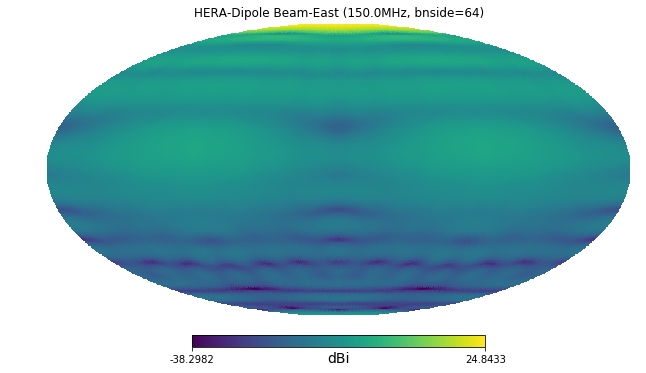

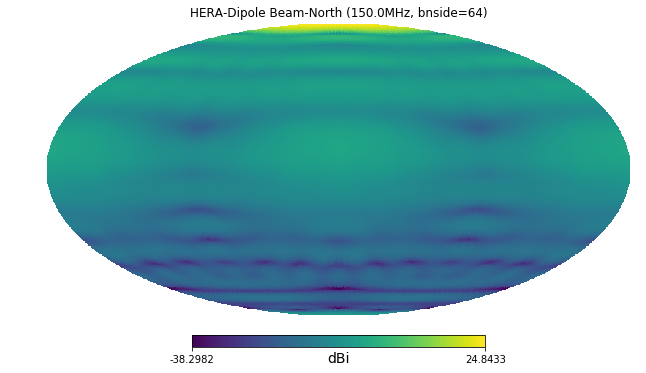

In [71]:

Plot_Beam = True
if Plot_Beam:
    plt.figure(0)
    #ind = np.where(beam_freqs == freq)[0][0]
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    plt.show(block=False)
    #plt.gcf().clear()
        #plt.clf()
        #plt.close()



In [72]:
print local_beam_unpol(150)[0:]
print local_beam_unpol(150)[0:].sum()
print local_beam_unpol(150)[0:].min()
print local_beam_unpol(150)[0:].max()

[[317.35033648 317.36347034 317.36347034 ...   0.45564572   0.45564572
    0.4558748 ]
 [317.36347034 317.36347034 317.35033648 ...   0.45564572   0.4558748
    0.4558748 ]]
98426.09926039288
0.00014797059467877035
317.3634703353978


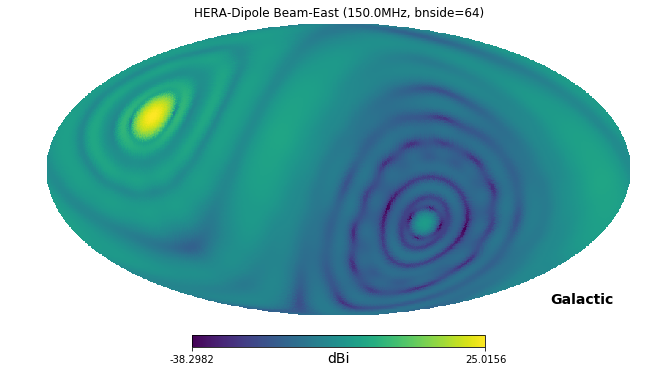

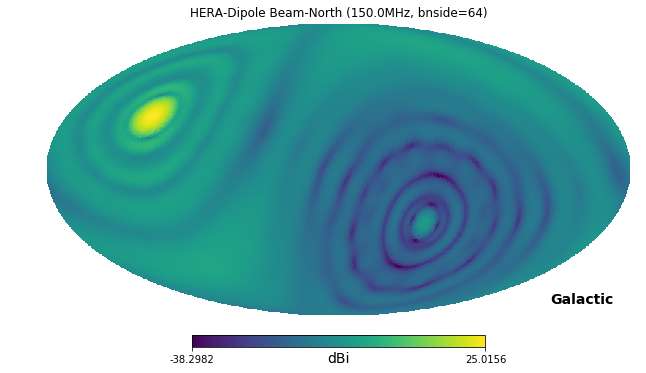

In [73]:
Plot_Beam = True
if Plot_Beam:
    plt.figure(0)
    #ind = np.where(beam_freqs == freq)[0][0]
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), coord='CG', title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), coord='CG', title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    plt.show(block=False)
    #plt.gcf().clear()
        #plt.clf()
        #plt.close()


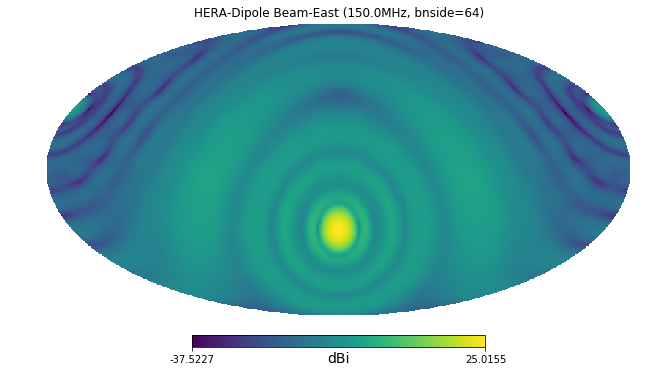

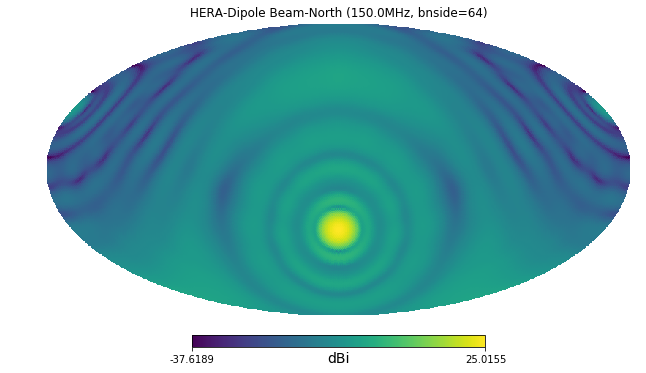

In [74]:
#################
####set up vs and beam
################
vs = sv.Visibility_Simulator()
vs.initial_zenith = np.array([0, lat_degree * PI / 180])  # self.zenithequ
beam_heal_hor_x = local_beam_unpol(freq)[0]
beam_heal_hor_y = local_beam_unpol(freq)[1]
beam_heal_equ_x = sv.rotate_healpixmap(beam_heal_hor_x, 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0])
beam_heal_equ_y = sv.rotate_healpixmap(beam_heal_hor_y, 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0])

if Absolute_Calibration_dred_mfreq or PointSource_AbsCal:
	beam_heal_hor_x_mfreq = np.array([local_beam_unpol(flist[0][i])[0] for i in range(nf_used)])
	beam_heal_hor_y_mfreq = np.array([local_beam_unpol(flist[1][i])[1] for i in range(nf_used)])
	beam_heal_equ_x_mfreq = np.array([sv.rotate_healpixmap(beam_heal_hor_x_mfreq[i], 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0]) for i in range(nf_used)])
	beam_heal_equ_y_mfreq = np.array([sv.rotate_healpixmap(beam_heal_hor_y_mfreq[i], 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0]) for i in range(nf_used)])


Plot_Beam = True
if Plot_Beam:
	plt.figure(10)
	#ind = np.where(beam_freqs == freq)[0][0]
	hp.mollview(10.0 * np.log10(beam_heal_equ_x), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
	hp.mollview(10.0 * np.log10(beam_heal_equ_y), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
	plt.show(block=False)

sys.stdout.flush()

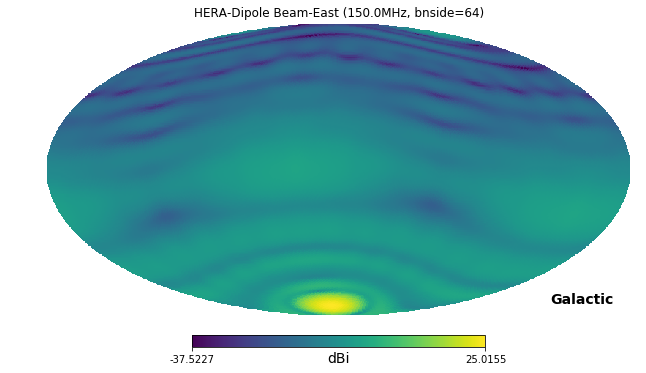

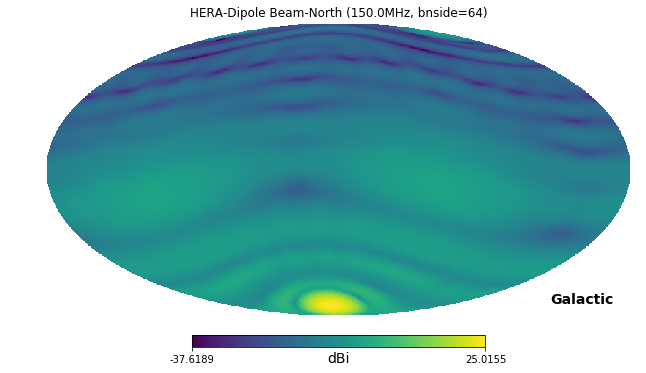

In [75]:
if Plot_Beam:
	plt.figure(0)
# 	ind = np.where(beam_freqs == freq)[0][0]
	hp.mollview(10.0 * np.log10(beam_heal_equ_x), coord='CG', title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	#plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-east-CG-%.2f-bnside-%s.pdf'%(INSTRUMENT, beam_freqs[ind], bnside))
	hp.mollview(10.0 * np.log10(beam_heal_equ_y), coord='CG', title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	#plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-north-CG-%.2f-bnside-%s.pdf'%(INSTRUMENT, beam_freqs[ind], bnside))
	plt.show(block=False)

In [76]:
########################### Delete some Input Data ##############################
Del=True
if Del:
	#del(data)
	#del(data_yy)
	try:
		#del(model)
		#del(model_yy)
		del(data_omni)
	except:
		pass

sys.stdout.flush()

In [77]:
used_common_ubls

array([[ 7.44885577e+00, -3.79246865e+01,  4.23256854e-01],
       [-5.10791346e+01, -1.28453914e+01,  1.21642480e-01],
       [-1.45112194e+01, -2.53568916e+01,  2.54566860e-01],
       [ 5.13690025e+01, -6.30587565e+01,  6.87628425e-01],
       [-2.92156817e+01, -1.11574854e-01, -1.74515193e-02],
       [-1.42213277e+01, -1.01266870e+02,  1.00566965e+00],
       [-2.91190600e+01, -2.54127980e+01,  2.50796561e-01],
       [ 1.48977048e+01, -7.58475238e+01,  8.38307420e-01],
       [ 2.94089240e+01, -5.04906345e+01,  5.91966747e-01],
       [-3.62780440e+01, -6.33934774e+01,  6.68113943e-01],
       [-7.29425872e+01, -2.55785378e+01,  2.00803495e-01],
       [-2.18634514e+01, -1.27340831e+01,  1.27177364e-01],
       [ 1.49943393e+01, -1.01151963e+02,  1.09597922e+00],
       [ 1.93243745e-01, -5.06024710e+01,  5.52719358e-01],
       [ 8.77436782e+01, -2.49688800e+01,  2.51109571e-01],
       [-7.25561119e+00, -1.26781441e+01,  1.42880045e-01],
       [-9.49026700e+01, -1.30094141e+01

In [78]:
######################
####initial A to compute beam weight
#####################
A_version = 1.0
A = {}
for p in ['x', 'y']:
	pol = p + p
	# ubl file
	#// ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
	#ubls = np.array([[0,0,0]])
	#//np.fromfile(ubl_filename, dtype='float32').reshape((nUBL, 3))
	print "%i UBLs to include, longest baseline is %i wavelengths for Pol: %s" % (len(ubls[p]), np.max(np.linalg.norm(ubls[p], axis=1)) / (C / freq), pol)
	print "%i Used-Common-UBLs to include, longest baseline is %i wavelengths for Pol: %s" % (len(used_common_ubls), np.max(np.linalg.norm(used_common_ubls, axis=1)) / (C / freq), pol)

	# beam
	if p == 'x':
		beam_heal_equ = beam_heal_equ_x
	elif p == 'y':
		beam_heal_equ = beam_heal_equ_x
	print "Computing sky weighting A matrix for %s pol..." % p
	sys.stdout.flush()

	A[p] = np.zeros((nt_used * len(used_common_ubls), 12 * nside_beamweight ** 2), dtype='complex128')

	timer = time.time()
	for i in np.arange(12 * nside_beamweight ** 2):
		dec, ra = hpf.pix2ang(nside_beamweight, i)  # gives theta phi
		dec = PI / 2 - dec
		print "\r%.1f%% completed" % (100. * float(i) / (12. * nside_beamweight ** 2)),
		sys.stdout.flush()
		if abs(dec - lat_degree * PI / 180) <= PI / 2:
			A[p][:, i] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts).flatten()

	print "%f minutes used" % (float(time.time() - timer) / 60.)
	sys.stdout.flush()
	

74 UBLs to include, longest baseline is 59 wavelengths for Pol: xx
74 Used-Common-UBLs to include, longest baseline is 59 wavelengths for Pol: xx
Computing sky weighting A matrix for x pol...


66.6% completed                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

66.6% completed                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

100.0% completed                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [79]:
####################################################
###beam weights using an equal pixel A matrix######
#################################################
print "Computing beam weight...",
sys.stdout.flush()
beam_weight = ((la.norm(A['x'], axis=0) ** 2 + la.norm(A['y'], axis=0) ** 2) ** .5)[hpf.nest2ring(nside_beamweight, range(12 * nside_beamweight ** 2))]
beam_weight = beam_weight / np.mean(beam_weight)
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
beam_weight = hpf.get_interp_val(beam_weight, thetas_standard, phis_standard, nest=True) #np.array([beam_weight for i in range(nside_standard ** 2 / nside_beamweight ** 2)]).transpose().flatten()
print "done."
sys.stdout.flush()

Computing beam weight... done.


In [80]:
################################################
#####################GSM###########################
#############################################
pca1 = hp.fitsfunc.read_map(script_dir + '/../data/gsm1.fits' + str(nside_standard))
pca2 = hp.fitsfunc.read_map(script_dir + '/../data/gsm2.fits' + str(nside_standard))
pca3 = hp.fitsfunc.read_map(script_dir + '/../data/gsm3.fits' + str(nside_standard))
components = np.loadtxt(script_dir + '/../data/components.dat')
scale_loglog = si.interp1d(np.log(components[:, 0]), np.log(components[:, 1]))
w1 = si.interp1d(components[:, 0], components[:, 2])
w2 = si.interp1d(components[:, 0], components[:, 3])
w3 = si.interp1d(components[:, 0], components[:, 4])
gsm_standard = np.exp(scale_loglog(np.log(freq))) * (w1(freq) * pca1 + w2(freq) * pca2 + w3(freq) * pca3)
if Absolute_Calibration_dred_mfreq or PointSource_AbsCal:
	gsm_standard_mfreq = np.array([np.exp(scale_loglog(np.log(flist[0][i]))) * (w1(flist[0][i]) * pca1 + w2(flist[0][i]) * pca2 + w3(flist[0][i]) * pca3) for i in range(nf_used)])

# rotate sky map and converts to nest
equatorial_GSM_standard = np.zeros(12 * nside_standard ** 2, 'float')
print "Rotating GSM_standard and converts to nest...",

if INSTRUMENT == 'miteor':
	DecimalYear = 2013.58 #2013, 7, 31, 16, 47, 59, 999998)
	JulianEpoch = 2013.58
elif INSTRUMENT == 'hera47':
	DecimalYear = Time(data_times[0][0], format='jd').decimalyear + (np.mean(Time(data_times[0], format='jd').decimalyear) - Time(data_times[0][0], format='jd').decimalyear) * Time_Expansion_Factor
	JulianEpoch = Time(data_times[0][0], format='jd').jyear + (np.mean(Time(data_times[0], format='jd').jyear) - Time(data_times[0][0], format='jd').jyear) * Time_Expansion_Factor  # np.mean(Time(data_times[0], format='jd').jyear)

sys.stdout.flush()
equ_to_gal_matrix = hp.rotator.Rotator(coord='cg').mat.dot(sv.epoch_transmatrix(2000, stdtime=JulianEpoch))
ang0, ang1 = hp.rotator.rotateDirection(equ_to_gal_matrix,
					hpf.pix2ang(nside_standard, range(12 * nside_standard ** 2), nest=True))
equatorial_GSM_standard = hpf.get_interp_val(gsm_standard, ang0, ang1)
if Absolute_Calibration_dred_mfreq or PointSource_AbsCal:
	equatorial_GSM_standard_mfreq = np.array([hpf.get_interp_val(gsm_standard_mfreq[i], ang0, ang1) for i in range(nf_used)])
print "done."

Del=True
if Del:
	del(pca1)
	del(pca2)
	del(pca3)
	del(w1)
	del(w2)
	del(w3)
	del(components)
	del(scale_loglog)
	del(gsm_standard)
	try:
		del(gsm_standard_mfreq)
	except:
		pass
sys.stdout.flush()

NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Rotating GSM_standard and converts to nest... done.


In [81]:
Time(2458044.66691, format='jd').datetime # 2458044.12551; 2458044.66691

datetime.datetime(2017, 10, 18, 4, 0, 21, 24013)

In [82]:
###########################################################
####simulate visibilities using non dynamic pixelization###
##########################################
full_sim_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_tave%s_fave%s_nside%i_bnside%i_texp%s.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, Time_Average, Frequency_Average, nside_standard, bnside, Time_Expansion_Factor)
sim_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_tave%s_fave%s_nside%i_bnside%i_texp%s_vis_sim_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, Time_Average, Frequency_Average, nside_standard, bnside, Time_Expansion_Factor)
sim_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_tave%s_fave%s_nside%i_bnside%i_texp%s_vis_sim_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, Time_Average, Frequency_Average, nside_standard, bnside, Time_Expansion_Factor)
if simulation_opt == 1:
	
	if os.path.isfile(full_sim_filename):
		fullsim_vis = np.fromfile(full_sim_filename, dtype='complex128').reshape((2, nUBL_used + 1, nt_used))
		fullsim_vis[0][:-1, :].astype('complex128').tofile(sim_vis_xx_filename)
		fullsim_vis[1][:-1, :].astype('complex128').tofile(sim_vis_yy_filename)
	
	else:
		
		fullsim_vis = np.zeros((2, nUBL_used + 1, nt_used), dtype='complex128')  # since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
		full_sim_ubls = np.concatenate((used_common_ubls, [[0, 0, 0]]), axis=0)  # tag along auto corr
		full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
		full_decs = PI / 2 - full_thetas
		full_ras = full_phis
		full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
		# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')
		
		print "Simulating visibilities, %s, expected time %f min" % (datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
		sys.stdout.flush()
		masked_equ_GSM = equatorial_GSM_standard[full_sim_mask]
		timer = time.time()
		for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
			for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
				res = vs.calculate_pointsource_visibility(ra, dec, full_sim_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
				fullsim_vis[p] += masked_equ_GSM[i] * res
		# fullsim_vis_DBG[p, ..., i] = res[:-1]
		# autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
		print "simulated visibilities in %f minutes." % ((time.time() - timer) / 60.)
		fullsim_vis.astype('complex128').tofile(full_sim_filename)
		fullsim_vis[0][:-1, :].astype('complex128').tofile(sim_vis_xx_filename)
		fullsim_vis[1][:-1, :].astype('complex128').tofile(sim_vis_yy_filename)
	
	autocorr_vis = np.abs(fullsim_vis[:, -1])
	if crosstalk_type == 'autocorr':
		autocorr_vis_normalized = np.array([autocorr_vis[p] / (la.norm(autocorr_vis[p]) / la.norm(np.ones_like(autocorr_vis[p]))) for p in range(2)])
	else:
		autocorr_vis_normalized = np.ones((2, nt_used))
	fullsim_vis = fullsim_vis[:, :-1].transpose((1, 0, 2))


In [83]:
fullsim_vis.shape

(74, 2, 5)

In [84]:
print autocorr_vis.mean()
print(np.abs(fullsim_vis[0,0]).mean())
print(np.abs(fullsim_vis[0,0]).max())
print(np.abs(fullsim_vis[0,0]).min())
print(np.abs(fullsim_vis[0,0]).sum())

3584879.103377369
22915.74137330024
82782.71963219238
5395.4423724427925
114578.70686650119


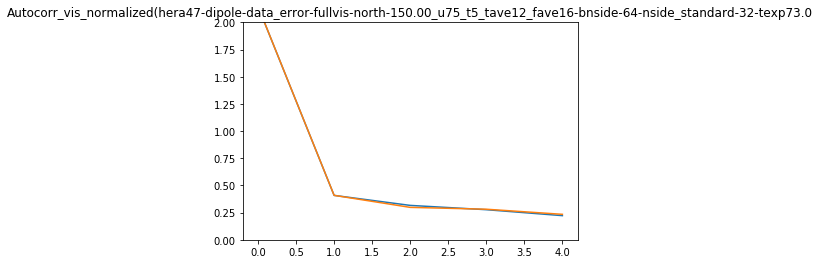

In [85]:
if plot_data_error:
	# plt.clf()
	plt.figure(30)
	plt.plot(autocorr_vis_normalized.transpose())
	plt.title('Autocorr_vis_normalized(%s-dipole-data_error-fullvis-north-%.2f_u%i_t%i_tave%s_fave%s-bnside-%s-nside_standard-%s-texp%s'%(INSTRUMENT, freq, nUBL_used+1, nt_used, Time_Average, Frequency_Average, bnside, nside_standard, Time_Expansion_Factor))
	plt.ylim([0, 2])
	plt.savefig(script_dir + '/../Output/%s-dipole-data_error-fullvis-north-%.2f_u%i_t%i_tave%s_fave%s-bnside-%s-nside_standard-%s-texp%s.pdf'%(INSTRUMENT, freq, nUBL_used+1, nt_used, Time_Average, Frequency_Average, bnside, nside_standard, Time_Expansion_Factor))
	plt.show(block=False)
# plt.gcf().clear()
# plt.clf()
# plt.close()
sys.stdout.flush()


In [86]:
######################################### Absolute Calibration on Omnicaled Data #############################################
if Absolute_Calibration_red:
	full_redabs_sim_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_tave%s_fave%s_nside%i_bnside%i_texp%s_redabs.simvis' % (INSTRUMENT, freq, nBL_red_used + 1, nt_used, Time_Average, Frequency_Average, nside_standard, bnside, Time_Expansion_Factor)
	redabs_sim_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_tave%s_fave%s_nside%i_bnside%i_texp%s_vis_redabs_sim_xx.simvis' % (INSTRUMENT, freq, nBL_red_used + 1, nt_used, Time_Average, Frequency_Average, nside_standard, bnside, Time_Expansion_Factor)
	redabs_sim_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_tave%s_fave%s_nside%i_bnside%i_texp%s_vis_redabs_sim_yy.simvis' % (INSTRUMENT, freq, nBL_red_used + 1, nt_used, Time_Average, Frequency_Average, nside_standard, bnside, Time_Expansion_Factor)
	
	if os.path.isfile(full_redabs_sim_filename):
		fullsim_vis_red = np.fromfile(full_redabs_sim_filename, dtype='complex128').reshape((2, nBL_red_used + 1, nt_used))
		fullsim_vis_red[0][:-1, :].astype('complex128').tofile(redabs_sim_vis_xx_filename)
		fullsim_vis_red[1][:-1, :].astype('complex128').tofile(redabs_sim_vis_yy_filename)
	
	else:
		
		fullsim_vis_red = np.zeros((2, nBL_red_used + 1, nt_used), dtype='complex128')  # since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
		full_sim_bls_red = np.concatenate((used_common_bls_red, [[0, 0, 0]]), axis=0)  # tag along auto corr
		full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
		full_decs = PI / 2 - full_thetas
		full_ras = full_phis
		full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
		# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')
		
		print "Simulating redundant visibilities, %s, expected time %f min" % (datetime.datetime.now(), 14.6 * (nBL_red_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
		sys.stdout.flush()
		masked_equ_GSM = equatorial_GSM_standard[full_sim_mask]
		timer = time.time()
		for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
			for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
				res_red = vs.calculate_pointsource_visibility(ra, dec, full_sim_bls_red, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
				fullsim_vis_red[p] += masked_equ_GSM[i] * res_red
		# fullsim_vis_DBG[p, ..., i] = res[:-1]
		# autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
		print "simulated redundant visibilities in %f minutes." % ((time.time() - timer) / 60.)
		fullsim_vis_red.astype('complex128').tofile(full_redabs_sim_filename)
		fullsim_vis_red[0][:-1, :].astype('complex128').tofile(redabs_sim_vis_xx_filename)
		fullsim_vis_red[1][:-1, :].astype('complex128').tofile(redabs_sim_vis_yy_filename)
	
	autocorr_vis_red = np.abs(fullsim_vis_red[:, -1])
	if crosstalk_type == 'autocorr':
		autocorr_vis_red_normalized = np.array([autocorr_vis_red[p] / (la.norm(autocorr_vis_red[p]) / la.norm(np.ones_like(autocorr_vis_red[p]))) for p in range(2)])
	else:
		autocorr_vis_red_normalized = np.ones((2, nt_used))
	fullsim_vis_red = fullsim_vis_red[:, :-1].transpose((1, 0, 2))

	if plot_data_error:
		#plt.clf()
		plt.figure(3000000)
		plt.plot(autocorr_vis_red_normalized.transpose())
		plt.title('Autocorr_vis_normalized(%s-dipole-data_error-fullvis_red-north-%.2f-bnside-%s-nside_standard-%s-texp-%s)' % (INSTRUMENT, freq, bnside, nside_standard, Time_Expansion_Factor))
		plt.ylim([0, 2])
		plt.savefig(script_dir + '/../Output/%s-dipole-data_error-fullvis_red-north-%.2f-bnside-%s-nside_standard-%s-texp-%s.pdf' % (INSTRUMENT, freq, bnside, nside_standard, Time_Expansion_Factor))
		plt.show(block=False)
		#plt.gcf().clear()
		#plt.clf()
		#plt.close()
	sys.stdout.flush()


In [87]:
if Absolute_Calibration_dred_mfreq or Absolute_Calibration_dred:  # Used 9.4 min. 64*9*60*12280
	full_sim_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_tave%s_fave%s_nside%i_bnside%i_texp%s_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, Time_Average, Frequency_Average, nside_standard, bnside, Time_Expansion_Factor, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	sim_vis_xx_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_tave%s_fave%s_nside%i_bnside%i_texp%s_vis_sim_xx_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, Time_Average, Frequency_Average, nside_standard, bnside, Time_Expansion_Factor, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	sim_vis_yy_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_tave%s_fave%s_nside%i_bnside%i_texp%s_vis_sim_yy_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, Time_Average, Frequency_Average, nside_standard, bnside, Time_Expansion_Factor, np.min(flist[0]), np.max(flist[0]), len(flist[1]))
	if simulation_opt == 1:
		
		if os.path.isfile(full_sim_filename_mfreq):
			fullsim_vis_mfreq = np.fromfile(full_sim_filename_mfreq, dtype='complex128').reshape((2, nUBL_used + 1, nt_used, nf_used))
			fullsim_vis_mfreq[0][:-1].astype('complex128').tofile(sim_vis_xx_filename_mfreq)
			fullsim_vis_mfreq[1][:-1].astype('complex128').tofile(sim_vis_yy_filename_mfreq)
		
		else:
			
			fullsim_vis_mfreq = np.zeros((2, nUBL_used + 1, nt_used, nf_used), dtype='complex128')  # since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
			if not Absolute_Calibration_dred_mfreq:
				for id_p in range(2):
					fullsim_vis_mfreq[id_p, :-1, :, index_freq[id_p]] = fullsim_vis[:, id_p, :]
					fullsim_vis_mfreq[id_p, -1, :, index_freq[id_p]] = autocorr_vis[id_p]
			else:
				full_sim_ubls = np.concatenate((used_common_ubls, [[0, 0, 0]]), axis=0)  # tag along auto corr
				full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
				full_decs = PI / 2 - full_thetas
				full_ras = full_phis
				full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
				# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')
				
				print "Simulating visibilities, %s, expected time %f min" % (datetime.datetime.now(), 14.6 * nf_used * (nUBL_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
				sys.stdout.flush()
				masked_equ_GSM_mfreq = equatorial_GSM_standard_mfreq[:, full_sim_mask]
				timer = time.time()
				for id_f, f in enumerate(flist[0]):
					for p, beam_heal_equ in enumerate([beam_heal_equ_x_mfreq[id_f], beam_heal_equ_y_mfreq[id_f]]):
						for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
							res = vs.calculate_pointsource_visibility(ra, dec, full_sim_ubls, f, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
							fullsim_vis_mfreq[p, :, :, id_f] += masked_equ_GSM_mfreq[id_f, i] * res
					# fullsim_vis_DBG[p, ..., i] = res[:-1]
					# autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
				print "simulated visibilities in %f minutes." % ((time.time() - timer) / 60.)
				fullsim_vis_mfreq.astype('complex128').tofile(full_sim_filename_mfreq)
				fullsim_vis_mfreq[0][:-1, :, :].astype('complex128').tofile(sim_vis_xx_filename_mfreq)
				fullsim_vis_mfreq[1][:-1, :, :].astype('complex128').tofile(sim_vis_yy_filename_mfreq)
		
		autocorr_vis_mfreq = np.abs(fullsim_vis_mfreq[:, -1])
		#		if crosstalk_type == 'autocorr':
		#			autocorr_vis_normalized = np.array([autocorr_vis[p] / (la.norm(autocorr_vis[p]) / la.norm(np.ones_like(autocorr_vis[p]))) for p in range(2)])
		#		else:
		#			autocorr_vis_normalized = np.ones((2, nt_used))
		fullsim_vis_mfreq = fullsim_vis_mfreq[:, :-1].transpose((1, 0, 2, 3))  # (uBL, Pol, Times, Freqs)

In [88]:
if INSTRUMENT == 'hera47' and (Absolute_Calibration_dred_mfreq or Absolute_Calibration_red or Absolute_Calibration_dred or PointSource_AbsCal or Absolute_Calibration_dred_mfreq_pscal):
	model_sf = {}
	model_dred = {}
	model_dred_mfreq = {}
	data = {}
	data_sf = {}
	data_dred = {}
	data_dred_mfreq = {}
	data_dred_mfreq_pscal = {}
	interp_flags_dred_mfreq = {}
	interp_flags_dred_mfreq_pscal = {}
	AC = {}
	AC_sf = {}
	AC_dred = {}
	AC_dred_mfreq = {}
	AC_dred_mfreq_pscal = {}
	freq_to_cal = [freq]
	fulldflags = {}
	auto_select_dred_mfreq = {}
	auto_select_dred_mfreq_pscal = {}
	
	#	try:
	#		cdata = copy.deepcopy(data)
	#	except:
	#		pass
	
	try:
		cdflags_sf = copy.deepcopy(dflags_sf)
	except:
		pass
	
	try:
		cdflags_dred = copy.deepcopy(dflags_dred)
	except:
		pass
	
	try:
		cdflags = copy.deepcopy(dflags)
	except:
		pass
	
	try:
		cdflags_dred_mfreq = copy.deepcopy(dflags_dred_mfreq)
	except:
		pass
	
	# cwgts = copy.deepcopy(wgts)
	# cwgts_dred = copy.deepcopy(wgts_dred)
	
	
	bl_select = 0
	bl = dflags.keys()[bl_select]  # dflags and dflags_yy #[(24, 53, 'xx')
	fig = {}
	axes = {}
	fig_data = {}
	axes_data = {}
	
	bl_dred_select = 0
	bl_dred = dflags_dred[0].keys()[bl_dred_select]  # if Absolute_Calibration_dred else None #[(25, 37, 'xx')
	fig2 = {}
	axes2 = {}
	fig2_data = {}
	axes2_data = {}
	
	bl_dred_mfreq_select = 8
	bl_dred_mfreq = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_select]]  # [(25, 37, 'xx'), (25, 37, 'yy')]
	fig3 = {}
	axes3 = {}
	fig3_data = {}
	axes3_data = {}
	fig3_data_abscorr = {}
	axes3_data_abscorr = {}
	
	bl_dred_mfreq_pscal_select = 8
	bl_dred_mfreq_pscal = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_pscal_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_pscal_select]]  # [(25, 37, 'xx'), (25, 37, 'yy')]
	fig4 = {}
	axes4 = {}
	fig4_data = {}
	axes4_data = {}
	fig4_data_abscorr = {}
	axes4_data_abscorr = {}
    
	bl_dred_mfreq_pscal_modcal_select = 8
	bl_dred_mfreq_pscal_modcal = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_pscal_modcal_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_pscal_modcal_select]]  # [(25, 37, 'xx'), (25, 37, 'yy')]
	fig5 = {}
	axes5 = {}
	fig5_data = {}
	axes5_data = {}
	fig5_data_abscorr = {}
	axes5_data_abscorr = {}
	
	delay_corr_data = {}
	delay_corr_data_sf = {}
	delay_corr_data_dred = {}
	delay_corr_data_dred_mfreq = {}
	delay_corr_data_dred_mfreq_pscal = {}
	DAC = {}
	DAC_sf = {}
	DAC_dred = {}
	DAC_dred_mfreq = {}
	DAC_dred_mfreq_pscal = {}
	dly_phs_corr_data = {}
	dly_phs_corr_data_sf = {}
	dly_phs_corr_data_dred = {}
	dly_phs_corr_data_dred_mfreq = {}
	dly_phs_corr_data_dred_mfreq_pscal = {}
	DPAC = {}
	DPAC_sf = {}
	DPAC_dred = {}
	DPAC_dred_mfreq = {}
	DPAC_dred_mfreq_pscal = {}
	abs_corr_data = {}
	abs_corr_data_sf = {}
	abs_corr_data_dred = {}
	abs_corr_data_dred_mfreq = {}
	abs_corr_data_dred_mfreq_pscal = {}
	
	vis_data_dred_mfreq_abscal = [[], []]
	vis_data_dred_mfreq_pscal_abscal = [[], []]
	autocorr_data_dred_mfreq_abscal = [[], []]
	autocorr_data_dred_mfreq_pscal_abscal = [[], []]
	vis_data_dred_abscal = [[], []]
	vis_data_dred_pscal_abscal = [[], []]
	autocorr_data_dred_abscal = [[], []]
	autocorr_data_dred_pscal_abscal = [[], []]
	
	add_Autobsl = False  # Whether we add (0,0,0) to calculate autocorr or not.
	
	#		model = (copy.deepcopy(data)).astype('complex128')
	#		model_yy = copy.deepcopy(data_yy).astype('complex128')
	for i in range(2):
		model_sf[i] = LastUpdatedOrderedDict()
		model_sf[i] = LastUpdatedOrderedDict()
		model_dred[i] = LastUpdatedOrderedDict()
		#model_dred_mfreq[i] = LastUpdatedOrderedDict()
		# data[i] = LastUpdatedOrderedDict()
		data_sf[i] = LastUpdatedOrderedDict()
		data_dred[i] = LastUpdatedOrderedDict()
		#data_dred_mfreq[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		# fulldflags[i] = hc.abscal.UVData2AbsCalDict(data_fname_full[i], return_meta=True)[1] # assume autocorr no RFI flagged.
		
		if Absolute_Calibration_red:
			keys = dflags_sf[i].keys()  # if i == 0 else dflags_yy.keys()
			for key_index, key in enumerate(keys):
				model_sf[i][key] = fullsim_vis_red[key_index, i, :]
				data_sf[i][key] = vis_data[i][:, key_index]
			model_sf[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_red[i]  # not lose generality, choose the autocorrelation of first antenna in the first UBL as visibility in last line for autocorrelation calibraiton.
			data_sf[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data[i]
			cdflags_sf[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([False] * len(autocorr_data[i]))
			print(keys)
			print(keys[0][0])
		
		if Absolute_Calibration_dred:
			for key_index_dred, key_dred in enumerate(dflags_dred[i].keys()):
				model_dred[i][key_dred] = fullsim_vis[key_index_dred, i, :]
				data_dred[i][key_dred] = vis_data_dred[i][:, key_index_dred]
			model_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_vis[i]  # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
			data_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_data[i]  # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
			cdflags_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = np.array([False] * len(autocorr_data[i]))
			print(dflags_dred[i].keys())
			print(dflags_dred[i].keys()[0][0])
		
		#		if Absolute_Calibration_dred_mfreq:
		#			keys = dflags_dred_mfreq[i].keys()
		#			for key_index, key in enumerate(keys):
		#				model[i][key] = fullsim_vis_mfreq[key_index_dred, i]
		#				#data_dred_mfreq[i][key] = vis_data_dred_mfreq[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
		#			model[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
		#			cdata[i][dflags[i].keys()[0][0], dflags[i].keys()[0][0], dflags[i].keys()[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
		#			cdflags[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
		#			print(dflags[i].keys())
		#			print(dflags[i].keys()[0][0])
		#
		
		# if Absolute_Calibration_dred_mfreq:
		# 	keys = dflags_dred_mfreq[i].keys()
		# 	for key_index, key in enumerate(keys):
		# 		model_dred_mfreq[i][key] = fullsim_vis_mfreq[key_index, i]
		# 		# data_dred_mfreq[i][key] = np.real(vis_data_dred_mfreq[i][:, :, key_index].transpose()) + np.abs(np.imag(vis_data_dred_mfreq[i][:, :, key_index].transpose()))*1j #[pol][freq,time,ubl_index].transpose()
		# 		data_dred_mfreq[i][key] = vis_data_dred_mfreq[i][:, :, key_index].transpose()  # [pol][freq,time,ubl_index].transpose()
		# 	if add_Autobsl:
		# 		model_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_mfreq[i]  # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
		# 		data_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data_mfreq[i]  # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
		# 		cdflags_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False] * autocorr_data_mfreq[i].shape[1]] * autocorr_data_mfreq[i].shape[0])
		# 		auto_select_dred_mfreq[i] = (keys[0][0], keys[0][0], keys[0][2])
		# 	print(dflags_dred_mfreq[i].keys())
		# 	print(dflags_dred_mfreq[i].keys()[0][0])
	# Fake_wgts_dred_mfreq = True
	###### make wgts #######
	for i in range(2):
		if i == 0:
			wgts_sf = copy.deepcopy(cdflags_sf)
		for k in wgts_sf[i].keys():
			wgts_sf[i][k] = (~wgts_sf[i][k]).astype(np.float)
		
		if i == 0:
			wgts_dred = copy.deepcopy(cdflags_dred)
		for k in wgts_dred[i].keys():
			wgts_dred[i][k] = (~wgts_dred[i][k]).astype(np.float)
		
		#		if i == 0:
		#			wgts = copy.deepcopy(cdflags)
		#		for k in wgts[i].keys():
		#			wgts[i][k] = (~wgts[i][k]).astype(np.float)
		
		# if i == 0:
		# 	wgts_dred_mfreq = copy.deepcopy(cdflags_dred_mfreq)
		# for k in wgts_dred_mfreq[i].keys():
		# 	if not Fake_wgts_dred_mfreq:
		# 		wgts_dred_mfreq[i][k] = (~wgts_dred_mfreq[i][k]).astype(np.float)
		# 	else:
		# 		wgts_dred_mfreq[i][k] = (((~wgts_dred_mfreq[i][k]).astype(np.float) + 1).astype(bool)).astype(np.float)
	


In [89]:
if Absolute_Calibration_dred_mfreq or Absolute_Calibration_dred:
	re_cal_times = 1
	
	# Mocal_time_bin_temp = 5
	mocal_time_bin = np.min([Mocal_time_bin_temp, nt_used])
	mocal_time_bin_num = nt_used / mocal_time_bin if np.mod(nt_used, mocal_time_bin) == 0 else (nt_used / mocal_time_bin + 1)
	print('Mocal_time_bin_temp: %s; mocal_time_bin: %s; mocal_time_bin_num: %s' % (Mocal_time_bin_temp, mocal_time_bin, mocal_time_bin_num))
	
	Mocal_freq_bin_temp = 64
	mocal_freq_bin = 1 if not Absolute_Calibration_dred_mfreq else np.min([Mocal_freq_bin_temp, len(flist[0])])
	mocal_freq_bin_num = len(flist[0]) / mocal_freq_bin if np.mod(len(flist[0]), mocal_freq_bin) == 0 else (len(flist[0]) / mocal_freq_bin + 1)
	print('Mocal_freq_bin_temp: %s; mocal_freq_bin: %s; mocal_freq_bin_num: %s' % (Mocal_freq_bin_temp, mocal_freq_bin, mocal_freq_bin_num))
	
	wgts_dred_mfreq  ={}
	for i in range(2):
		pol = ['xx', 'yy'][i]
		re_cal = 0
		model_dred_mfreq[i] = LastUpdatedOrderedDict()
		data_dred_mfreq[i] = LastUpdatedOrderedDict()
		
		vis_data_dred_mfreq_abscal[i] = np.zeros_like(vis_data_dred_mfreq[i], dtype='complex128')
		autocorr_data_dred_mfreq_abscal[i] = np.zeros_like(autocorr_vis_mfreq[i])
		vis_data_dred_abscal[i] = np.zeros_like(vis_data_dred_mfreq_abscal[i][index_freq[i], :, :])
		autocorr_data_dred_abscal[i] = np.zeros_like(autocorr_vis_mfreq[i][:, index_freq[i]])
		
		for id_t_bin in range(mocal_time_bin_num):
			nt_mocal_used = mocal_time_bin if (id_t_bin + 1) * mocal_time_bin <= nt_used else (nt_used - id_t_bin * mocal_time_bin)
			
			for id_f_bin in range(mocal_freq_bin_num):
				nf_mocal_used = mocal_freq_bin if (id_f_bin + 1) * mocal_freq_bin <= len(flist[0]) else (len(flist[0]) - id_f_bin * mocal_freq_bin)
				
				keys = dflags_dred_mfreq[i].keys()
				for key_index, key in enumerate(keys):
					model_dred_mfreq[i][key] = fullsim_vis_mfreq[key_index, i, id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used]
					# data_dred_mfreq[i][key] = np.real(vis_data_dred_mfreq[i][:, :, key_index].transpose()) + np.abs(np.imag(vis_data_dred_mfreq[i][:, :, key_index].transpose()))*1j #[pol][freq,time,ubl_index].transpose()
					data_dred_mfreq[i][key] = vis_data_dred_mfreq[i][id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used, id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, key_index].transpose()  # [pol][freq,time,ubl_index].transpose()
					cdflags_dred_mfreq[i][key] = dflags_dred_mfreq[i][key][id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used]
				if add_Autobsl:
					model_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_mfreq[i][id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used]  # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
					data_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data_mfreq[i][id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used]  # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
					cdflags_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False] * autocorr_data_mfreq[i][id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used].shape[1]] * autocorr_data_mfreq[i][id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used].shape[0])
					auto_select_dred_mfreq[i] = (keys[0][0], keys[0][0], keys[0][2])
				print(dflags_dred_mfreq[i].keys())
				print(dflags_dred_mfreq[i].keys()[0][0])
				print('(id_t_bin: %s, id_f_bin: %s) data_shape[%s][%s]: (%s) \n' % (id_t_bin, id_f_bin, ['xx', 'yy'][i], key, data_dred_mfreq[i][key].shape))
						
				wgts_dred_mfreq[i] = copy.deepcopy(cdflags_dred_mfreq[i])
				for k in wgts_dred_mfreq[i].keys():
					if not Fake_wgts_dred_mfreq:
						wgts_dred_mfreq[i][k] = (~wgts_dred_mfreq[i][k]).astype(np.float)
					else:
						wgts_dred_mfreq[i][k] = (((~wgts_dred_mfreq[i][k]).astype(np.float) + 1).astype(bool)).astype(np.float)
				
				lsts_binned = lsts[id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used]
				flist_binned = flist[i][id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used]
				
				for re_cal in range(re_cal_times):  # number of times of absolute calibration
					if re_cal == 0:												
						if not Absolute_Calibration_dred_mfreq:
							# Skip Delay_Lincal
							# instantiate class
							DAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist_binned)
						else:
							# instantiate class
							model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts_binned, flist_binned, lsts_binned, flist_binned)
							AC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist_binned)
							# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
							AC_dred_mfreq[i].delay_lincal(kernel=(1, ((np.min([nf_mocal_used, 11]) -1) / 2 * 2 + 1)), medfilt=True, time_avg=True, solve_offsets=True)
							# apply to data
							delay_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(AC_dred_mfreq[i].data, (AC_dred_mfreq[i].ant_dly_gain))
							# instantiate class
							DAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], delay_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist_binned)
					else:
						if not Absolute_Calibration_dred_mfreq:
							# delay_corr_data_dred_mfreq[i] = abs_corr_data_dred_mfreq[i]
							DAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], abs_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist_binned)
						else:
							# instantiate class
							AC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], abs_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist_binned)
							AC_dred_mfreq[i].delay_lincal(kernel=(1, ((np.min([nf_mocal_used, 3]) -1) / 2 * 2 + 1)), medfilt=True, time_avg=True, solve_offsets=True)
							# apply to data
							delay_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(AC_dred_mfreq[i].data, (AC_dred_mfreq[i].ant_dly_gain))
							# instantiate class
							DAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], delay_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist_binned)

					# # instantiate class
					# DAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], delay_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist_binned)
					# avg phase solver
					DAC_dred_mfreq[i].phs_logcal(avg=True)
					# apply to data
					dly_phs_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(DAC_dred_mfreq[i].data, (DAC_dred_mfreq[i].ant_phi_gain))
					# instantiate class
					DPAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], dly_phs_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist_binned)
					# run amp linsolve
					DPAC_dred_mfreq[i].abs_amp_logcal()
					# run phs linsolve
					DPAC_dred_mfreq[i].TT_phs_logcal(zero_psi=False, four_pol=False)
					# apply to data
					abs_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(DPAC_dred_mfreq[i].data,
					                                                    (DPAC_dred_mfreq[i].abs_psi_gain, DPAC_dred_mfreq[i].TT_Phi_gain, DPAC_dred_mfreq[i].abs_eta_gain), gain_convention='multiply')

				
				for key_id, key in enumerate(dflags_dred_mfreq[i].keys()):
					vis_data_dred_mfreq_abscal[i][id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used, id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, key_id] = abs_corr_data_dred_mfreq[i][key].transpose()
				# vis_data_dred_mfreq_abscal[i][:, :, key_id] = np.real(abs_corr_data_dred_mfreq[i][key].transpose()) + np.abs(np.imag(abs_corr_data_dred_mfreq[i][key].transpose()))*1j
				if add_Autobsl:
					autocorr_data_dred_mfreq_abscal[i][id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used] = abs_corr_data_dred_mfreq[i][auto_select_dred_mfreq[i]]
				else:
					autocorr_data_dred_mfreq_abscal[i][id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used] = autocorr_vis_mfreq[i][id_t_bin * mocal_time_bin:id_t_bin * mocal_time_bin + nt_mocal_used, id_f_bin * mocal_freq_bin:id_f_bin * mocal_freq_bin + nf_mocal_used]
				
		vis_data_dred_abscal[i] = vis_data_dred_mfreq_abscal[i][index_freq[i], :, :]
		if add_Autobsl:
			autocorr_data_dred_abscal[i] = autocorr_data_dred_mfreq_abscal[i][:, index_freq[i]]
		else:
			autocorr_data_dred_abscal[i] = autocorr_vis_mfreq[i][:, index_freq[i]]
	
            

Mocal_time_bin_temp: 600; mocal_time_bin: 5; mocal_time_bin_num: 1
Mocal_freq_bin_temp: 64; mocal_freq_bin: 64; mocal_freq_bin_num: 1
[(41, 87, 'xx'), (51, 70, 'xx'), (54, 87, 'xx'), (41, 120, 'xx'), (36, 38, 'xx'), (13, 142, 'xx'), (86, 124, 'xx'), (1, 84, 'xx'), (71, 141, 'xx'), (51, 141, 'xx'), (50, 87, 'xx'), (121, 142, 'xx'), (14, 141, 'xx'), (24, 84, 'xx'), (41, 65, 'xx'), (123, 143, 'xx'), (98, 123, 'xx'), (50, 98, 'xx'), (12, 37, 'xx'), (0, 142, 'xx'), (13, 27, 'xx'), (36, 55, 'xx'), (36, 65, 'xx'), (12, 24, 'xx'), (41, 82, 'xx'), (98, 143, 'xx'), (98, 141, 'xx'), (1, 141, 'xx'), (41, 98, 'xx'), (41, 83, 'xx'), (41, 141, 'xx'), (88, 98, 'xx'), (0, 141, 'xx'), (41, 124, 'xx'), (36, 123, 'xx'), (0, 13, 'xx'), (12, 52, 'xx'), (41, 71, 'xx'), (41, 50, 'xx'), (23, 142, 'xx'), (2, 141, 'xx'), (54, 141, 'xx'), (65, 87, 'xx'), (65, 71, 'xx'), (13, 40, 'xx'), (36, 40, 'xx'), (51, 124, 'xx'), (27, 53, 'xx'), (27, 54, 'xx'), (11, 142, 'xx'), (41, 68, 'xx'), (88, 142, 'xx'), (11, 13, 'xx')

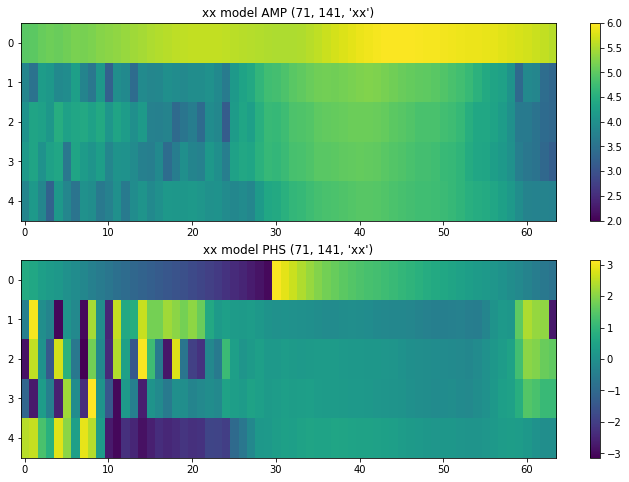

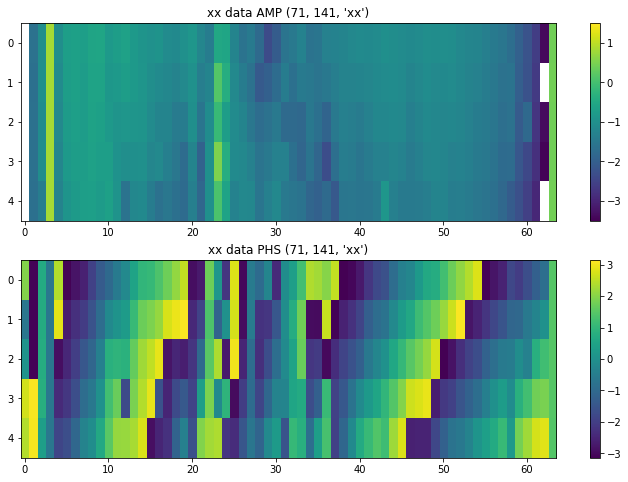

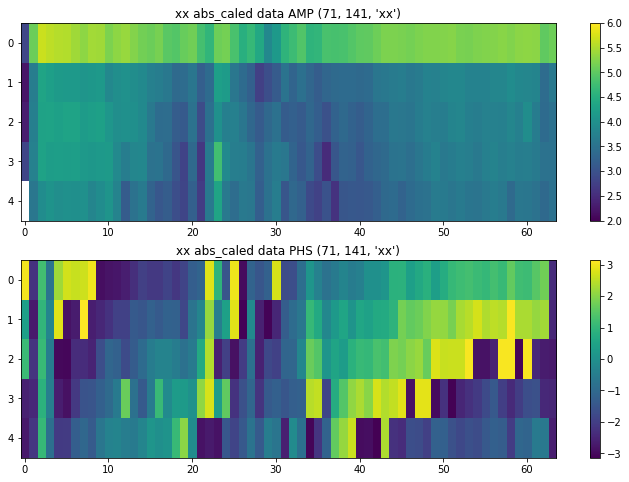

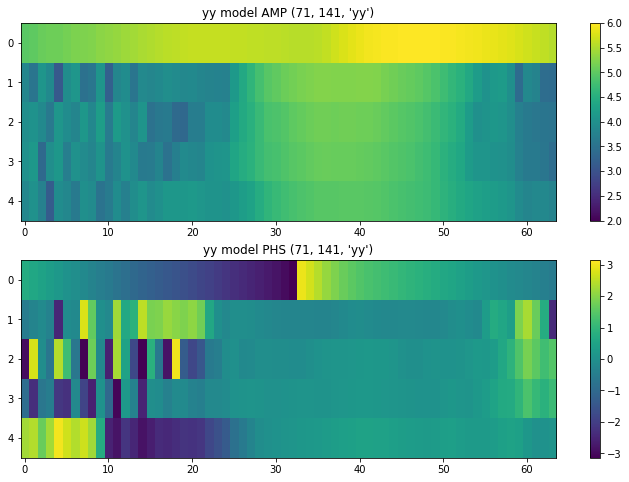

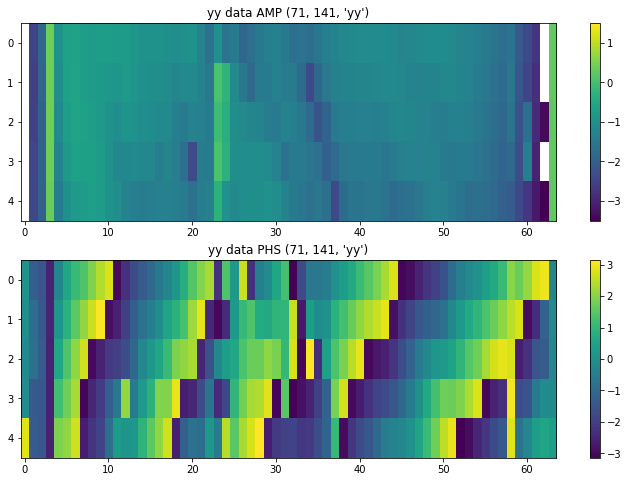

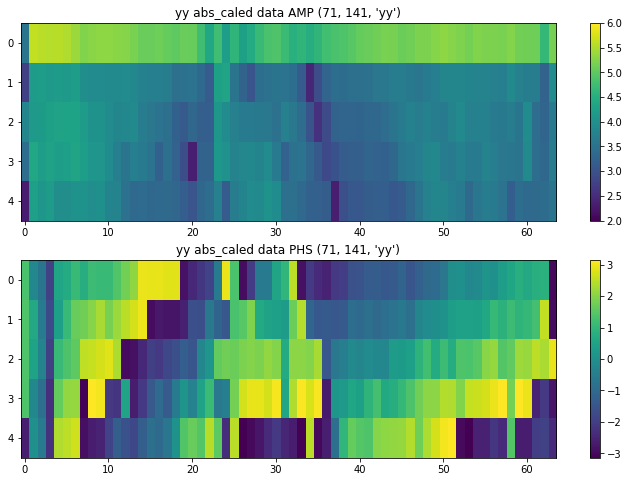

In [90]:
if Absolute_Calibration_dred_mfreq or Absolute_Calibration_dred:
	for i in range(2): # add another redundant 'for loop' for testing plotting.
		pol = ['xx', 'yy'][i]
		try:		
			# plt.figure(80000000 + 10 * i)
			# fig3[i], axes3[i] = plt.subplots(2, 1, figsize=(12, 8))
			# plt.sca(axes3[i][0])
			# uvt.plot.waterfall(AC_dred_mfreq[i].model[bl_dred_mfreq[i]], mode='log', mx=6, drng=4)
			# plt.colorbar()
			# plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq[i]))
			# plt.sca(axes3[i][1])
			# uvt.plot.waterfall(AC_dred_mfreq[i].model[bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2 * np.pi)
			# plt.colorbar()
			# plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq[i]))
			# plt.show(block=False)
			# plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Modcal_model-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			# # plt.cla()
			
			plt.figure(80000000 + 10 * i)
			fig3[i], axes3[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes3[i][0])
			uvt.plot.waterfall(fullsim_vis_mfreq[bl_dred_mfreq_select, i, :, :], mode='log', mx=6, drng=4)
			plt.colorbar()
			plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq[i]))
			plt.sca(axes3[i][1])
			uvt.plot.waterfall(fullsim_vis_mfreq[bl_dred_mfreq_select, i, :, :], mode='phs', mx=np.pi, drng=2 * np.pi)
			plt.colorbar()
			plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq[i]))
			plt.show(block=False)
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Modcal_model-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			# plt.cla()
			
			# plt.figure(90000000 + 10 * i)
			# fig3_data[i], axes3_data[i] = plt.subplots(2, 1, figsize=(12, 8))
			# plt.sca(axes3_data[i][0])
			# uvt.plot.waterfall(data_dred_mfreq[i][bl_dred_mfreq[i]], mode='log', mx=1.5, drng=5)
			# plt.colorbar()
			# plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq[i]))
			# plt.sca(axes3_data[i][1])
			# uvt.plot.waterfall(data_dred_mfreq[i][bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2 * np.pi)
			# plt.colorbar()
			# plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq[i]))
			# plt.show(block=False)
			# plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Modcal_data-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			# # plt.cla()
		
			plt.figure(90000000 + 10 * i)
			fig3_data[i], axes3_data[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes3_data[i][0])
			uvt.plot.waterfall(vis_data_dred_mfreq[i][:, :, bl_dred_mfreq_select].transpose(), mode='log', mx=1.5, drng=5)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq[i]))
			plt.sca(axes3_data[i][1])
			uvt.plot.waterfall(vis_data_dred_mfreq[i][:, :, bl_dred_mfreq_select].transpose(), mode='phs', mx=np.pi, drng=2 * np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq[i]))
			plt.show(block=False)
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Modcal_data-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			# plt.cla()
			
			####################### after ABS Calibration #########################
			# plt.figure(8000000 + 10 * i)
			# fig3_data_abscorr[i], axes3_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
			# plt.sca(axes3_data_abscorr[i][0])
			# uvt.plot.waterfall(abs_corr_data_dred_mfreq[i][bl_dred_mfreq[i]], mode='log', mx=6, drng=4)
			# plt.colorbar()
			# plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq[i]))
			# plt.sca(axes3_data_abscorr[i][1])
			# uvt.plot.waterfall(abs_corr_data_dred_mfreq[i][bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2 * np.pi)
			# plt.colorbar()
			# plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq[i]))
			# plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Modcal_data-caled-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			# plt.show(block=False)
			# # plt.cla()
			
			plt.figure(8000000 + 10 * i)
			fig3_data_abscorr[i], axes3_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes3_data_abscorr[i][0])
			uvt.plot.waterfall(vis_data_dred_mfreq_abscal[i][:, :, bl_dred_mfreq_select].transpose(), mode='log', mx=6, drng=4)
			plt.colorbar()
			plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq[i]))
			plt.sca(axes3_data_abscorr[i][1])
			uvt.plot.waterfall(vis_data_dred_mfreq_abscal[i][:, :, bl_dred_mfreq_select].transpose(), mode='phs', mx=np.pi, drng=2 * np.pi)
			plt.colorbar()
			plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq[i]))
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Modcal_data-caled-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			plt.show(block=False)
			# plt.cla()
		except:
			print('Error when Plotting Mocal Results')

In [91]:
# for i in range(2):	
# 	if Absolute_Calibration_dred:
# 		# instantiate class
# 		#AC_dred[i] = hc.abscal.AbsCal(model_dred[i], data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
# 		# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
# 		AC_dred[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
# 		# apply to data
# 		delay_corr_data_dred[i] = hc.abscal.apply_gains(AC_dred[i].data, (AC_dred[i].ant_dly_gain))
# 		# instantiate class
# 		DAC_dred[i] = hc.abscal.AbsCal(model_dred[i], data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
# 		# avg phase solver
# 		DAC_dred[i].phs_logcal(avg=True)
# 		# apply to data
# 		dly_phs_corr_data_dred[i] = hc.abscal.apply_gains(DAC_dred[i].data, (DAC_dred[i].ant_phi_gain))
# 		# instantiate class
# 		DPAC_dred[i] = hc.abscal.AbsCal(model_dred[i], dly_phs_corr_data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
# 		# run amp linsolve
# 		DPAC_dred[i].abs_amp_logcal()
# 		# run phs linsolve
# 		DPAC_dred[i].TT_phs_logcal(zero_psi=False, four_pol=False)
# 		# apply to data
# 		abs_corr_data_dred[i] = hc.abscal.apply_gains(DPAC_dred[i].data, 
# 								(DPAC_dred[i].abs_psi_gain, DPAC_dred[i].TT_Phi_gain, DPAC_dred[i].abs_eta_gain), gain_convention='multiply')
		
		
# 		plt.figure(60000000+10*i)
# 		fig2[i], axes2[i] = plt.subplots(2, 1, figsize=(12, 8))
# 		if len(freq_to_cal) >= 2:
# 			plt.sca(axes2[i][0])
# 			uvt.plot.waterfall(AC_dred[i].model[bl_dred], mode='log', mx=4, drng=2)
# 			plt.colorbar()
# 			plt.title(pol + ' model AMP {}'.format(bl_dred))
# 			plt.sca(axes2[i][1])
# 			uvt.plot.waterfall(AC_dred[i].model[bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
# 			plt.colorbar()
# 			plt.title(pol + ' model PHS {}'.format(bl_dred))
# 			plt.show(block=False)			
# 		else:
# 			plt.sca(axes2[i][0])
# 			plt.plot(np.real(AC_dred[i].model[bl_dred]))
# 			plt.title(pol + ' model Real {}'.format(bl_dred))
# 			plt.sca(axes2[i][1])
# 			plt.plot(np.imag(AC_dred[i].model[bl_dred]))
# 			plt.title(pol + ' model Imag {}'.format(bl_dred))
# 			plt.show(block=False)
# 		#plt.cla()
			
# 		plt.figure(70000000+10*i)
# 		fig2_data[i], axes2_data[i] = plt.subplots(2, 1, figsize=(12, 8))
# 		if len(freq_to_cal) >= 2:
# 			plt.sca(axes2_data[i][0])
# 			uvt.plot.waterfall(AC_dred[i].data[bl_dred], mode='log', mx=4, drng=2)
# 			plt.colorbar()
# 			plt.title(pol + ' data AMP {}'.format(bl_dred))
# 			plt.sca(axes2_data[i][1])
# 			uvt.plot.waterfall(AC_dred[i].data[bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
# 			plt.colorbar()
# 			plt.title(pol + ' data PHS {}'.format(bl_dred))
# 			plt.show(block=False)
# 		else:
# 			plt.sca(axes2_data[i][0])
# 			plt.plot(np.real(AC_dred[i].data[bl_dred]))
# 			plt.title(pol + ' data Real {}'.format(bl_dred))
# 			plt.sca(axes2_data[i][1])
# 			plt.plot(np.imag(AC_dred[i].data[bl_dred]))
# 			plt.title(pol + ' data Imag {}'.format(bl_dred))
# 			plt.show(block=False)
# 		#plt.cla()
			
			
# 		####################### after ABS Calibration #########################	
# 		plt.figure(7000000+10*i)
# 		fig2_data[i], axes2_data[i] = plt.subplots(2, 1, figsize=(12, 8))
# 		if len(freq_to_cal) >= 2:
# 			plt.sca(axes2_data[i][0])
# 			uvt.plot.waterfall(abs_corr_data_dred[i][bl_dred], mode='log', mx=4, drng=2)
# 			plt.colorbar()
# 			plt.title(pol + ' data AMP {}'.format(bl_dred))
# 			plt.sca(axes2_data[i][1])
# 			uvt.plot.waterfall(abs_corr_data_dred[i][bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
# 			plt.colorbar()
# 			plt.title(pol + ' data PHS {}'.format(bl_dred))
# 			plt.show(block=False)
# 		else:
# 			plt.sca(axes2_data[i][0])
# 			plt.plot(np.real(abs_corr_data_dred[i][bl_dred]))
# 			plt.title(pol + ' data Real {}'.format(bl_dred))
# 			plt.sca(axes2_data[i][1])
# 			plt.plot(np.imag(abs_corr_data_dred[i][bl_dred]))
# 			plt.title(pol + ' data Imag {}'.format(bl_dred))
# 			plt.show(block=False)
# 		#plt.cla()


In [92]:
4 != 5

True

In [93]:
################################################################
################# Noise and Vis Data Loading ##################
###############################################################
Recal_IntegrationTime = True
Recal_FrequencyBin = True
if len(tlist) >= 2 and INSTRUMENT == 'hera47' and Recal_IntegrationTime:
	Time_seperation_real = np.array([3600. * np.abs(tlist[i + 1] - tlist[i]) for i in range(len(tlist) - 1)])  # in second
elif INSTRUMENT == 'hera47':
	Time_seperation_real = 11 # second
elif INSTRUMENT == 'miteor':
	Time_seperation_real = 2.7 # second
	
if len(flist) >=2 and INSTRUMENT == 'hera47' and Recal_FrequencyBin:
	Frequency_gap_real = np.array([1.e6*np.abs(flist[0][i+1]-flist[0][i]) for i in range(len(flist[0])-1)]) # Hz
elif INSTRUMENT == 'hera47':
	Frequency_gap_real = 0.09765625 * 1.e6 #Hz
elif INSTRUMENT == 'miteor':
	Frequency_gap_real = 0.5 * 1.e6 #Hz

Integration_Time = np.mean(Time_seperation_real)
Frequency_Bin = np.mean(Frequency_gap_real)

Calculate_SimulationData_Noise = True
Calculate_Data_Noise = True

scale_noise = True
# Use_AbsCal = False

noise = {}
noise_data = {}
if Calculate_SimulationData_Noise:
	if Keep_Red:
		noise['x'] = np.array([np.random.normal(0, autocorr_vis_red[0][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used) for t_index in range(len(autocorr_vis[0]))], dtype='complex128').flatten()
		noise['y'] = np.array([np.random.normal(0, autocorr_vis_red[1][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used) for t_index in range(len(autocorr_vis[1]))], dtype='complex128').flatten()
	else:
		noise['x'] = np.array([(np.random.normal(0, autocorr_vis[0][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used) / np.array(used_redundancy[0]) ** 0.5) for t_index in range(len(autocorr_vis[0]))], dtype='complex128').flatten()
		noise['y'] = np.array([(np.random.normal(0, autocorr_vis[1][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used) / np.array(used_redundancy[1]) ** 0.5) for t_index in range(len(autocorr_vis[1]))], dtype='complex128').flatten()
	
	#	N_acu = {}
	#	N_acu['x'] = np.outer(noise['x'], noise['x'].T)
	#	N_acu['y'] = np.outer(noise['y'], noise['y'].T)
	N = {}
	N['x'] = noise['x'] * noise['x']
	N['y'] = noise['y'] * noise['y']
	
	sim_var_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_sim_xx.simvis' % (INSTRUMENT, freq, nUBL_used + 1, nt_used, nside_standard, bnside)
	sim_var_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_sim_yy.simvis' % (INSTRUMENT, freq, nUBL_used + 1, nt_used, nside_standard, bnside)
	if not os.path.isfile(sim_var_xx_filename):
		N['x'].astype('complex128').tofile(sim_var_xx_filename)
	if not os.path.isfile(sim_var_yy_filename):
		N['y'].astype('complex128').tofile(sim_var_yy_filename)
	
	Del = True
	if Del:
		del (noise)
		del (N)

if Calculate_Data_Noise:
	if INSTRUMENT == 'miteor':
		noise_data['x'] = (var_data[0].flatten()) ** 0.5
		noise_data['y'] = (var_data[1].flatten()) ** 0.5
	
	elif INSTRUMENT == 'hera47':
		if Keep_Red:
			noise_data['x'] = np.array([np.random.normal(0, autocorr_data[0][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used) for t_index in range(len(autocorr_data[0]))], dtype='complex128').flatten()  # Not Absolute Calibrated
			noise_data['y'] = np.array([np.random.normal(0, autocorr_data[1][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used) for t_index in range(len(autocorr_data[1]))], dtype='complex128').flatten()
		else:
			if scale_noise:
				if Use_AbsCal:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[0][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used) / np.array(used_redundancy[0]) ** 0.5) for t_index in range(len(autocorr_data_dred_abscal[0]))], dtype='complex128').flatten()  # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[1][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used) / np.array(used_redundancy[1]) ** 0.5) for t_index in range(len(autocorr_data_dred_abscal[1]))], dtype='complex128').flatten()
				else:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data[0][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used) / np.array(used_redundancy[0]) ** 0.5) for t_index in range(len(autocorr_data[0]))], dtype='complex128').flatten()  # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data[1][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used) / np.array(used_redundancy[1]) ** 0.5) for t_index in range(len(autocorr_data[1]))], dtype='complex128').flatten()
			else:
				if Use_AbsCal:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[0][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used)) for t_index in range(len(autocorr_data_dred_abscal[0]))], dtype='complex128').flatten()  # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[1][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used)) for t_index in range(len(autocorr_data_dred_abscal[1]))], dtype='complex128').flatten()
				else:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data[0][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used)) for t_index in range(len(autocorr_data[0]))], dtype='complex128').flatten()  # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data[1][t_index] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL_used)) for t_index in range(len(autocorr_data[1]))], dtype='complex128').flatten()
	
	#	N_data_acu = {}
	#	N_data_acu['x'] = np.outer(noise_data['x'], noise_data['x'].T)
	#	N_data_acu['y'] = np.outer(noise_data['y'], noise_data['y'].T)
	N_data = {}
	N_data['x'] = noise_data['x'] * noise_data['x']
	N_data['y'] = noise_data['y'] * noise_data['y']
	
	Store_Data_Noise = True
	
	if Store_Data_Noise:
		data_var_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_xx.simvis' % (INSTRUMENT, freq, nUBL_used + 1, nt_used, nside_standard, bnside)
		data_var_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_yy.simvis' % (INSTRUMENT, freq, nUBL_used + 1, nt_used, nside_standard, bnside)
		if not os.path.isfile(data_var_xx_filename):
			N_data['x'].astype('complex128').tofile(data_var_xx_filename)
		else:
			pass
		if not os.path.isfile(data_var_yy_filename):
			N_data['y'].astype('complex128').tofile(data_var_yy_filename)
		else:
			pass
	
	Del = True
	if Del:
		del (noise_data)
# del(N_data)
#		try:
#			del(autocorr_data)
#		except:
#			pass

sys.stdout.flush()


In [94]:
southern_points = {'hyd':{'ra': '09:18:05.7', 'dec': '-12:05:44'},
'cen':{'ra': '13:25:27.6', 'dec': '-43:01:09'},
'cyg':{'ra': '19:59:28.3', 'dec': '40:44:02'},
'pic':{'ra': '05:19:49.7', 'dec': '-45:46:44'},
'vir':{'ra': '12:30:49.4', 'dec': '12:23:28'},
'for':{'ra': '03:22:41.7', 'dec': '-37:12:30'},
'sag':{'ra': '17:45:40.045', 'dec': '-29:0:27.9'},
'cas':{'ra': '23:23:26', 'dec': '58:48:00'},
'crab':{'ra': '5:34:31.97', 'dec': '22:00:52.1'}}
southern_points.keys()
for source in southern_points.keys():
	southern_points[source]['body'] = ephem.FixedBody()
	southern_points[source]['body']._ra = southern_points[source]['ra']
	southern_points[source]['body']._dec = southern_points[source]['dec']

full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)

In [95]:
flux_raw_gsm_ps = {}
flux_gsm_ps = {}
flux_raw_dis_gsm_ps = {}
flux_dis_gsm_ps = {}
pix_index_gsm_ps = {}
pix_raw_index_gsm_ps = {}
pix_max_index_gsm_ps = {}
pt_sources = southern_points.keys()
for source in pt_sources:
    flux_raw_gsm_ps[source] = 0
    flux_gsm_ps[source] = 0
    flux_raw_dis_gsm_ps[source] = []
    flux_dis_gsm_ps[source] = []
    pix_raw_index_gsm_ps[source] = []
    pix_index_gsm_ps[source] = []
    #pix_max_index_gsm_ps[source] = []
    for i in range(len(equatorial_GSM_standard)):
        if la.norm(np.array([full_phis[i] - southern_points[source]['body']._ra, 
                               (PI / 2 - full_thetas[i]) - southern_points[source]['body']._dec])) <= 0.1:
            flux_raw_gsm_ps[source] += equatorial_GSM_standard[i]
            flux_raw_dis_gsm_ps[source].append(equatorial_GSM_standard[i])
            pix_raw_index_gsm_ps[source].append(i)
            
    pix_max_index_gsm_ps[source] = pix_raw_index_gsm_ps[source][flux_raw_dis_gsm_ps[source].index(np.array(flux_raw_dis_gsm_ps[source]).max())]
    for j in range(len(flux_raw_dis_gsm_ps[source])):
        if flux_raw_dis_gsm_ps[source][j] >= 0.4 * equatorial_GSM_standard[pix_max_index_gsm_ps[source]]:
            flux_gsm_ps[source] += equatorial_GSM_standard[pix_raw_index_gsm_ps[source][j]]
            flux_dis_gsm_ps[source].append(equatorial_GSM_standard[pix_raw_index_gsm_ps[source][j]])
            pix_index_gsm_ps[source].append(pix_raw_index_gsm_ps[source][j])
            
    print('total flux of %s'%source, flux_gsm_ps[source])
    print('total raw flux of %s'%source, flux_raw_gsm_ps[source])
    print('maximum pix flux of %s'%source, equatorial_GSM_standard[pix_max_index_gsm_ps[source]])
    print('pix-index with maximum flux of %s'%source, pix_max_index_gsm_ps[source])
    print('raw-pix-indexes of %s'%source, pix_raw_index_gsm_ps[source])
    print('pix-indexes of %s'%source, pix_index_gsm_ps[source])
    print('\n')
    

('total flux of vir', 2153.2812654034947)
('total raw flux of vir', 8096.683172785517)
('maximum pix flux of vir', 750.3963831529468)
('pix-index with maximum flux of vir', 6941)
('raw-pix-indexes of vir', [6590, 6591, 6634, 6929, 6931, 6932, 6933, 6934, 6935, 6937, 6939, 6940, 6941, 6942, 6943, 6964, 6965, 6976, 6977, 6978, 6979, 6982, 6984, 6985, 6986, 6987, 6988, 6990, 7008, 7009])
('pix-indexes of vir', [6935, 6941, 6978, 6984])


('total flux of cas', 14498.81465489175)
('total raw flux of cas', 24261.393818719567)
('maximum pix flux of cas', 5537.374647951483)
('pix-index with maximum flux of cas', 3571)
('raw-pix-indexes of cas', [3542, 3545, 3547, 3548, 3550, 3568, 3569, 3570, 3571, 3572, 3574, 3577, 3579, 3580, 3582])
('pix-indexes of cas', [3569, 3571, 3572, 3574])


('total flux of hyd', 4934.2307407245835)
('total raw flux of hyd', 4934.2307407245835)
('maximum pix flux of hyd', 238.47210090007889)
('pix-index with maximum flux of hyd', 10194)
('raw-pix-indexes of hyd', [10

In [96]:
######################
####simulate cas and cyg
#######################
southern_points = {'hyd':{'ra': '09:18:05.7', 'dec': '-12:05:44'},
'cen':{'ra': '13:25:27.6', 'dec': '-43:01:09'},
'cyg':{'ra': '19:59:28.3', 'dec': '40:44:02'},
'pic':{'ra': '05:19:49.7', 'dec': '-45:46:44'},
'vir':{'ra': '12:30:49.4', 'dec': '12:23:28'},
'for':{'ra': '03:22:41.7', 'dec': '-37:12:30'},
'sag':{'ra': '17:45:40.045', 'dec': '-29:0:27.9'},
'cas':{'ra': '23:23:26', 'dec': '58:48:00'},
'crab':{'ra': '5:34:31.97', 'dec': '22:00:52.1'}}


for source in southern_points.keys():
	southern_points[source]['body'] = ephem.FixedBody()
	southern_points[source]['body']._ra = southern_points[source]['ra']
	southern_points[source]['body']._dec = southern_points[source]['dec']

flux_func = {}
#flux_func['cas'] = si.interp1d(np.loadtxt('/home/omniscope/data/point_source_flux/casA2013.5out')[:,1], np.loadtxt('/home/omniscope/data/point_source_flux/casA2013.5out')[:,2])
#flux_func['cyg'] = si.interp1d(np.loadtxt('/home/omniscope/data/point_source_flux/cygA2006out')[:,1], np.loadtxt('/home/omniscope/data/point_source_flux/cygA2006out')[:,2])
flux_func['cas'] = si.interp1d(flist[0], np.array([S_casa_v_t(flist[0][i], DecimalYear) for i in range(len(flist[0]))]))
flux_func['cyg'] = si.interp1d(flist[0], np.array([S_cyga_v(flist[0][i], DecimalYear) for i in range(len(flist[0]))]))

full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)

# pt_sources = ['cyg', 'cas']
pt_sources = southern_points.keys()
pt_vis = np.zeros((len(pt_sources), 2, nUBL_used, nt_used), dtype='complex128')
if INSTRUMENT == 'miteor':
	print "Simulating cyg casvisibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (2. / 1.4e5)),
	sys.stdout.flush()
	timer = time.time()
	for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
		for i, source in enumerate(pt_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec
# 			pt_vis[i, p] = jansky2kelvin * flux_func[source](freq) * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
			pt_vis[i, p] = flux_gsm_ps[source] * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
elif INSTRUMENT == 'hera47':
	print "Simulating cyg casvisibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (2. / 1.4e5)),
	sys.stdout.flush()
	timer = time.time()
	for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
		for i, source in enumerate(pt_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec
# 			pt_vis[i, p] = jansky2kelvin * flux_func[source](freq) * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
			pt_vis[i, p] = flux_gsm_ps[source] * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2

if PointSource_AbsCal:
	vis_freq = {}
	
	autocorr_data_dred_mfreq_pscal = {}
	vis_data_dred_mfreq_pscal = {}
	
	# PointSource_AbsCal_SingleFreq = True
	
	if PointSource_AbsCal_SingleFreq:
		pscal_freqstart = index_freq
		pscal_freqend = index_freq + 1
	else:
		pscal_freqstart = 0
		pscal_freqend = np.min([len(flist[0]), len(flist[1])])
		
	for j, p in enumerate(['x', 'y']):
		pol = p + p
		vis_data_dred_mfreq_pscal[j] = np.zeros_like(vis_data_dred_mfreq[j])
		autocorr_data_dred_mfreq_pscal[j] = np.zeros_like(autocorr_data_mfreq[j])
	
	for id_f in range(pscal_freqstart, pscal_freqend, 1):
		vis_freq[0] = flist[0][id_f]
		vis_freq[1] = flist[1][id_f]
		# cal_lst_range = np.array([5, 6]) / TPI * 24.
# 		cal_lst_range = np.array([tlist[15], tlist[-15]])
		cal_lst_range = np.array([tlist[len(tlist)/3], tlist[-len(tlist)/3]])
		calibrate_ubl_length = 2600 / np.mean([vis_freq[0], vis_freq[1]])  # 10.67
		# cal_time_mask = tmask	 #(tlist>cal_lst_range[0]) & (tlist<cal_lst_range[1])#a True/False mask on all good data to get good data in cal time range
		cal_time_mask = (tlist >= cal_lst_range[0]) & (tlist <= cal_lst_range[1])
		# cal_ubl_mask = np.linalg.norm(ubls[p], axis=1) >= calibrate_ubl_length
		
		print('%i times used' % len(lsts[cal_time_mask]))
		
		flux_raw_gsm_ps = {}
		flux_gsm_ps = {}
		flux_raw_dis_gsm_ps = {}
		flux_dis_gsm_ps = {}
		pix_index_gsm_ps = {}
		pix_raw_index_gsm_ps = {}
		pix_max_index_gsm_ps = {}
		pt_sources = southern_points.keys()
		for source in pt_sources:
			flux_raw_gsm_ps[source] = 0
			flux_gsm_ps[source] = 0
			flux_raw_dis_gsm_ps[source] = []
			flux_dis_gsm_ps[source] = []
			pix_raw_index_gsm_ps[source] = []
			pix_index_gsm_ps[source] = []
			#pix_max_index_gsm_ps[source] = []
			for i in range(len(equatorial_GSM_standard_mfreq[id_f])):
				if la.norm(np.array([full_phis[i] - southern_points[source]['body']._ra,
									 (PI / 2 - full_thetas[i]) - southern_points[source]['body']._dec])) <= 0.1:
					flux_raw_gsm_ps[source] += equatorial_GSM_standard_mfreq[id_f, i]
					flux_raw_dis_gsm_ps[source].append(equatorial_GSM_standard_mfreq[id_f, i])
					pix_raw_index_gsm_ps[source].append(i)
			
			pix_max_index_gsm_ps[source] = pix_raw_index_gsm_ps[source][flux_raw_dis_gsm_ps[source].index(np.array(flux_raw_dis_gsm_ps[source]).max())]
			for j in range(len(flux_raw_dis_gsm_ps[source])):
				if flux_raw_dis_gsm_ps[source][j] >= 0.5 * equatorial_GSM_standard_mfreq[id_f, pix_max_index_gsm_ps[source]]:
					flux_gsm_ps[source] += equatorial_GSM_standard_mfreq[id_f, pix_raw_index_gsm_ps[source][j]]
					flux_dis_gsm_ps[source].append(equatorial_GSM_standard_mfreq[id_f, pix_raw_index_gsm_ps[source][j]])
					pix_index_gsm_ps[source].append(pix_raw_index_gsm_ps[source][j])
			
			print('total flux of %s'%source, flux_gsm_ps[source])
			print('total raw flux of %s'%source, flux_raw_gsm_ps[source])
			print('maximum pix flux of %s'%source, equatorial_GSM_standard_mfreq[id_f, pix_max_index_gsm_ps[source]])
			print('pix-index with maximum flux of %s'%source, pix_max_index_gsm_ps[source])
			print('raw-pix-indexes of %s'%source, pix_raw_index_gsm_ps[source])
			print('pix-indexes of %s'%source, pix_index_gsm_ps[source])
			print('\n')
		
		Ni = {}
		cubls = copy.deepcopy(ubls)
		ubl_sort = {}
		noise_data_pscal = {}
		N_data_pscal = {}
		vis_data_dred_pscal = {}
		
		From_AbsCal = False
		
		for i, p in enumerate(['x', 'y']):
			pol = p + p
			cal_ubl_mask = np.linalg.norm(ubls[p], axis=1) >= calibrate_ubl_length
			# get Ni (1/variance) and data
			# var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, vartag)
			# noise_data_pscal['y'] = np.array([(np.random.normal(0,autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) ) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
			
			if From_AbsCal:
				vis_data_dred_pscal[i] = vis_data_dred_mfreq_abscal[i][id_f][np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
				noise_data_pscal[p] = np.array([(np.random.normal(0, autocorr_data_dred_mfreq_abscal[i][t_index, id_f] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL) / np.array(used_redundancy[0]) ** 0.5) for t_index in range(len(autocorr_data[i]))], dtype='complex128').flatten()  # Absolute Calibrated
			else:
				vis_data_dred_pscal[i] = vis_data_dred_mfreq[i][id_f][np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
				noise_data_pscal[p] = np.array([(np.random.normal(0, autocorr_data_mfreq[i][t_index, id_f] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL) / np.array(used_redundancy[0]) ** 0.5) for t_index in range(len(autocorr_data[i]))], dtype='complex128').flatten()  # Absolute Calibrated
			
			N_data_pscal[p] = noise_data_pscal[p] * noise_data_pscal[p]
			# N_data_pscal[p] = N_data[p]
			# N_data_pscal['y'] = noise_data_pscal['y'] * noise_data_pscal['y']
			Ni[p] = 1. / N_data_pscal[p].reshape((nt, nUBL))[np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
			ubls[p] = ubls[p][cal_ubl_mask]
			ubl_sort[p] = np.argsort(la.norm(ubls[p], axis=1))
			
			print "%i UBLs to include" % len(ubls[p])
		
		del (noise_data_pscal)
		
		print "Computing UNpolarized point sources matrix..."
		sys.stdout.flush()
		# cal_sources = ['cyg', 'cas']
		cal_sources = southern_points.keys()
		Apol = np.empty((np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask), len(cal_sources)), dtype='complex128')
		timer = time.time()
		for n, source in enumerate(cal_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec
			
			Apol[:, 0, :, n] = vs.calculate_pointsource_visibility(ra, dec, ubls[p], vis_freq[0], beam_heal_equ=beam_heal_equ_x_mfreq[id_f], tlist=lsts[cal_time_mask])
			Apol[:, 1, :, n] = vs.calculate_pointsource_visibility(ra, dec, ubls[p], vis_freq[1], beam_heal_equ=beam_heal_equ_y_mfreq[id_f], tlist=lsts[cal_time_mask])
		
		Apol = np.conjugate(Apol).reshape((np.sum(cal_ubl_mask), 2 * np.sum(cal_time_mask), len(cal_sources)))
		Ni = np.transpose([Ni['x'], Ni['y']], (1, 0, 2))
		
		realA = np.zeros((2 * Apol.shape[0] * Apol.shape[1], 1 + 2 * np.sum(cal_ubl_mask) * 2), dtype='complex128')
		# 		realA[:, 0] = np.concatenate((np.real(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2]))), np.imag(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2])))), axis=0).dot([jansky2kelvin_mfreq[0][id_f] * flux_func[source](vis_freq[0]) for source in cal_sources])
		realA[:, 0] = np.concatenate((np.real(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2]))), np.imag(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2])))), axis=0).dot([flux_gsm_ps[source] for source in cal_sources])
		vis_scale = la.norm(realA[:, 0]) / len(realA) ** .5
		for coli, ncol in enumerate(range(1, realA.shape[1])):
			realA[coli * np.sum(cal_time_mask): (coli + 1) * np.sum(cal_time_mask), ncol] = vis_scale
		
		realNi = np.concatenate((Ni.flatten() * 2, Ni.flatten() * 2))
		realAtNiAinv = np.linalg.pinv(np.einsum('ji,j,jk->ik', realA, realNi, realA))
		
		b = np.transpose([vis_data_dred_pscal[0], vis_data_dred_pscal[1]], (1, 0, 2))
		phase_degen_niter = 0
		phase_degen2 = {'x': np.zeros(2), 'y': np.zeros(2)}
		phase_degen_iterative_x = np.zeros(2)
		phase_degen_iterative_y = np.zeros(2)
		
		
		def tocomplex(realdata):
			reshapedata = realdata.reshape((2, np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask)))
			return reshapedata[0] + reshapedata[1] * 1.j
		
		
		phase_degen_niter_max = 100
		while (phase_degen_niter < phase_degen_niter_max and max(np.linalg.norm(phase_degen_iterative_x), np.linalg.norm(phase_degen_iterative_y)) > 1e-5) or phase_degen_niter == 0:
			phase_degen_niter += 1
			b[:, 0] = b[:, 0] * np.exp(1.j * ubls['x'][:, :2].dot(phase_degen_iterative_x))[:, None]
			b[:, -1] = b[:, -1] * np.exp(1.j * ubls['y'][:, :2].dot(phase_degen_iterative_y))[:, None]
			realb = np.concatenate((np.real(b.flatten()), np.imag(b.flatten())))
			
			psol = realAtNiAinv.dot(np.transpose(realA).dot(realNi * realb))
			realb_fit = realA.dot(psol)
			perror = ((realb_fit - realb) * (realNi ** .5)).reshape((2, np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask)))
			
			realbfit_noadditive = realA[:, 0] * psol[0]
			realbfit_additive = realb_fit - realbfit_noadditive
			realb_noadditive = realb - realbfit_additive
			bfit_noadditive = tocomplex(realbfit_noadditive)
			b_noadditive = tocomplex(realb_noadditive)
			if phase_degen_niter == phase_degen_niter_max:
				phase_degen_iterative_x = solve_phase_degen(np.transpose(b_noadditive[:, 0]), np.transpose(b_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), ubls['x'])  # , [3, 3, 1e3])
				phase_degen_iterative_y = solve_phase_degen(np.transpose(b_noadditive[:, -1]), np.transpose(b_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), ubls['y'])  # , [3, 3, 1e3])
			
			else:
				phase_degen_iterative_x = solve_phase_degen(np.transpose(b_noadditive[:, 0]), np.transpose(b_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), ubls['x'])
				phase_degen_iterative_y = solve_phase_degen(np.transpose(b_noadditive[:, -1]), np.transpose(b_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), ubls['y'])
			phase_degen2['x'] += phase_degen_iterative_x
			phase_degen2['y'] += phase_degen_iterative_y
			print phase_degen_niter, phase_degen2['x'], phase_degen2['y'], np.linalg.norm(perror)
		
		renorm = 1 / (2 * psol[0])
		
		print (renorm, vis_freq[0], phase_degen2['x'], vis_freq[1], phase_degen2['y'])
		
		# freqs[fi] = vis_freq
		
		################################# apply to data and var and output unpolarized version ####################################
		data_var_xx_filename_pscal = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_xx_pscal.simvis' % (INSTRUMENT, freq, nUBL, nt, nside_standard, bnside)
		data_var_yy_filename_pscal = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_yy_pscal.simvis' % (INSTRUMENT, freq, nUBL, nt, nside_standard, bnside)
		
		# vis_data_dred_pscal = {}
		# N_data_pscal = {}
		
		######### recover ubls and ubl_sort ##########
		ubls = cubls
		# ubl_sort = cubl_sort
		
		if Keep_Red:
			nUBL = len(bsl_coord_x)
			for p in ['x', 'y']:
				# ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
				ubls[p] = globals()['bsl_coord_' + p]
			common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
		else:
			nUBL = len(bsl_coord_dred[0])
			nUBL_yy = len(bsl_coord_dred[1])
			for i in range(2):
				p = ['x', 'y'][i]
				ubls[p] = bsl_coord_dred[i]
			common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
		# get data and var and apply change
		
		for j, p in enumerate(['x', 'y']):
			pol = p + p
			
			if From_AbsCal:
				vis_data_dred_mfreq_pscal[j][id_f] = vis_data_dred_mfreq_abscal[j][id_f] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
				if comply_ps2mod_autocorr:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_vis_mfreq[j][:, id_f]
				else:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_data_dred_mfreq_abscal[j][:, id_f] * np.abs(renorm)  # Absolute Calibrated
			else:
				vis_data_dred_mfreq_pscal[j][id_f] = vis_data_dred_mfreq[j][id_f] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
				if comply_ps2mod_autocorr:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_vis_mfreq[j][:, id_f]
				else:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_data_mfreq[j][:, id_f] * np.abs(renorm)  # Absolute Calibrated
	
	noise_data_pscal = {}
	N_data_pscal = {}
	vis_data_dred_pscal = {}
	for i, p in enumerate(['x', 'y']):
		pol = p + p
		#		data_filename = glob.glob(datadir + tag + '_%s%s_*_*'%(p, p) + datatag)[0]
		#		nt_nUBL = os.path.basename(data_filename).split(datatag)[0].split('%s%s_'%(p, p))[-1]
		#		nt = int(nt_nUBL.split('_')[0])
		#		nUBL = int(nt_nUBL.split('_')[1])
		#		var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, vartag)
		#
		#		op_data_filename = datadir + tag + '_%s%s_%i_%i%s'%(p, p, nt, nUBL, dataoptag)
		#		op_var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, varoptag)
		#		op_var100_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, varoptag+'x100')
		
		# ubl file
		# ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl'%(p, p, nUBL, 3)
		# ubls = np.fromfile(ubl_filename, dtype='float32').reshape((nUBL, 3))
		
		#		if From_AbsCal:
		#			vis_data_dred_pscal[i] = vis_data_dred_abscal[i] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
		#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_abscal[i][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
		#		else:
		#			vis_data_dred_pscal[i] = vis_data_dred[i] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
		#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data[i][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
		
		vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
		noise_data_pscal[p] = np.array([(np.random.normal(0, autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]] / (Integration_Time * Frequency_Bin) ** 0.5, nUBL) / np.array(used_redundancy[i]) ** 0.5) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))], dtype='complex128').flatten()  # Absolute Calibrated
		
		#		if From_AbsCal:
		#			vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
		#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
		#		else:
		#			vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
		#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
		
		N_data_pscal[p] = noise_data_pscal[p] * noise_data_pscal[p]
		N_data_pscal[p] = N_data_pscal[p].reshape((nt, nUBL))
		
		# save
		#		if os.path.isfile(op_data_filename) and not overwrite:
		#			raise IOError(op_data_filename + ' exists.')
		#		else:
		#			new_data.astype('complex128').tofile(op_data_filename)
		if not os.path.isfile(globals()['data_var_' + pol + '_filename_pscal']):
			N_data_pscal[p].astype('complex128').tofile(globals()['data_var_' + pol + '_filename_pscal'])
		else:
			pass
	# (new_var * 100.).astype('float32').tofile(op_var100_filename)
	del (noise_data_pscal)

Simulating cyg casvisibilities, 2018-03-22 18:01:16.129672, expected time 0.0 min 3 times used
('total flux of vir', 5124.932826952067)
('total raw flux of vir', 22540.658497826527)
('maximum pix flux of vir', 2087.134368760691)
('pix-index with maximum flux of vir', 6941)
('raw-pix-indexes of vir', [6590, 6591, 6634, 6929, 6931, 6932, 6933, 6934, 6935, 6937, 6939, 6940, 6941, 6942, 6943, 6964, 6965, 6976, 6977, 6978, 6979, 6982, 6984, 6985, 6986, 6987, 6988, 6990, 7008, 7009])
('pix-indexes of vir', [6935, 6941, 6984])


('total flux of cas', 32747.980838171283)
('total raw flux of cas', 66629.9360334421)
('maximum pix flux of cas', 15213.302556958937)
('pix-index with maximum flux of cas', 3571)
('raw-pix-indexes of cas', [3542, 3545, 3547, 3548, 3550, 3568, 3569, 3570, 3571, 3572, 3574, 3577, 3579, 3580, 3582])
('pix-indexes of cas', [3571, 3572, 3574])


('total flux of hyd', 13744.254056565323)
('total raw flux of hyd', 13744.254056565323)
('maximum pix flux of hyd', 664.447648417

55 [ 0.80319741 -0.10168899] [-1.39359137 -0.06620685] 16911.97149238576
56 [ 0.81550875 -0.10770535] [-1.75335582 -0.04884411] 16794.312968580027
57 [ 0.69830505 -0.08839298] [-1.34824243 -0.0912749 ] 16851.578012511338
58 [ 0.97938159 -0.14152805] [-1.32469108 -0.09587217] 16955.237222054413
59 [ 0.73479178 -0.12411042] [-1.1746128  -0.09920787] 16918.738145616513
60 [ 0.68285644 -0.11682031] [-1.46086837 -0.10812293] 16973.27878446123
61 [ 0.67271321 -0.11283702] [-1.73758502 -0.08280583] 16937.17008846074
62 [ 0.6746172  -0.11294582] [-1.62613351 -0.08663576] 17000.183334704023
63 [ 0.67080705 -0.11327271] [-1.42310498 -0.08721614] 16944.352517071267
64 [ 0.67333522 -0.11411172] [-1.43858766 -0.08114302] 16913.07255251112
65 [ 0.67499539 -0.11517628] [-1.42397402 -0.08587956] 16875.806137339325
66 [ 0.67115692 -0.11556021] [-1.43928463 -0.08008569] 16898.01939621984
67 [ 0.67375072 -0.1162516 ] [-1.45653943 -0.07597615] 16892.809142069622
68 [ 0.67548749 -0.11697835] [-1.41111529 -

9 [ 0.61293394 -0.04063838] [-0.4165511   0.01517539] 402215.90790156473
10 [ 0.20384915 -0.00778129] [-0.47210351  0.01823906] 402290.0786891992
11 [0.04134901 0.01855955] [-0.85664572  0.06586158] 402924.6831566724
12 [0.04970818 0.01308387] [-1.17784122  0.1073843 ] 402046.535202403
13 [0.04268523 0.01746109] [-0.97008164  0.08940409] 402835.5852463206
14 [0.04680746 0.01223193] [-1.03435044  0.09354243] 401041.2989138303
15 [0.2282658  0.00278314] [-1.08362855  0.09801065] 402930.9054596373
16 [-0.15276728  0.06495378] [-1.21396194  0.08911103] 402900.0340023425
17 [-0.17121941  0.05896979] [-1.59167472  0.13335978] 402425.60430322593
18 [-0.18017692  0.05281963] [-1.60309806  0.1310749 ] 401857.9080910409
19 [-0.26763996  0.06170153] [-1.60997831  0.12936606] 401846.1809788071
20 [0.13915609 0.02813336] [-1.5412797   0.12104966] 402347.8578882406
21 [-0.01359437  0.02178911] [-1.54298122  0.11673469] 402266.48845138634
22 [-0.05197259  0.02350612] [-1.54036314  0.11211816] 400419.

('total flux of for', 3274.9677812170394)
('total raw flux of for', 11884.801602249921)
('maximum pix flux of for', 1178.0908253557152)
('pix-index with maximum flux of for', 8623)
('raw-pix-indexes of for', [8614, 8615, 8617, 8619, 8620, 8621, 8622, 8623, 8626, 8627, 8632, 8633, 8634, 8635, 8961, 8963, 8964, 8965, 8966, 8967, 8976, 8977, 8978])
('pix-indexes of for', [8621, 8623, 8634, 8965])


('total flux of cyg', 21211.488533057774)
('total raw flux of cyg', 67535.56905161001)
('maximum pix flux of cyg', 9023.661589423615)
('pix-index with maximum flux of cyg', 3686)
('raw-pix-indexes of cyg', [3657, 3658, 3659, 3660, 3661, 3662, 3663, 3674, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3692, 3693, 3696, 3698])
('pix-indexes of cyg', [3683, 3684, 3686])


('total flux of cen', 23396.53027450073)
('total raw flux of cen', 41012.32713879267)
('maximum pix flux of cen', 3897.4277243792567)
('pix-index with maximum flux of cen', 10901)
('raw-pix-indexes of cen', [10806, 1

82 [ 0.32097679 -0.04668935] [-0.2955339   0.01706926] 141693.0939968234
83 [ 0.32115313 -0.04715022] [-0.28559956  0.01258081] 141287.17694636877
84 [ 0.32097577 -0.04669091] [-0.29409341  0.01278043] 141629.0526753888
85 [ 0.32115296 -0.04715029] [-0.30693546  0.01346158] 141287.68361198498
86 [ 0.32097699 -0.04668897] [-0.30967561  0.01242178] 141708.69325382906
87 [ 0.32115333 -0.04715011] [-0.30019912  0.01088803] 141295.03875965404
88 [ 0.32097712 -0.04668884] [-0.2976796   0.01128767] 141713.20122123288
89 [ 0.32115352 -0.04715001] [-0.29664175  0.01292273] 141303.20499101526
90 [ 0.320977   -0.04668908] [-0.29562344  0.01395501] 141703.41034691493
91 [ 0.32115328 -0.04715014] [-0.2958949   0.01709515] 141292.40230608714
92 [ 0.32097682 -0.04668931] [-0.29519898  0.01657401] 141694.64658459258
93 [ 0.32115312 -0.04715022] [-0.29433887  0.01363444] 141286.16724676627
94 [ 0.32097677 -0.04668937] [-0.2948698   0.01376396] 141692.4732565134
95 [ 0.32115317 -0.04715019] [-0.29623311

36 [ 0.66273418 -0.11984187] [-0.65312816 -0.01049487] 245312.2630937052
37 [ 0.60688869 -0.13233784] [-0.77391379  0.00908369] 226674.9202812402
38 [ 0.61179764 -0.13028308] [-0.48187104 -0.02030302] 218063.1346725748
39 [ 0.51748223 -0.11852451] [-0.75009315  0.03283357] 234058.32012723904
40 [ 0.41780586 -0.11362614] [-0.67789034  0.05583769] 225448.1077090727
41 [ 0.5796503 -0.1366545] [-0.64256431  0.05668114] 238171.17864193118
42 [ 0.55390562 -0.13149322] [-0.71744229  0.05577027] 245261.3812347521
43 [ 0.54877228 -0.1270601 ] [-0.2369706   0.01318136] 235306.29219968372
44 [ 0.55044227 -0.12847649] [-0.33757313  0.02473693] 199587.14749220829
45 [ 0.55905764 -0.12858432] [-0.12388544 -0.00926404] 244027.3723084876
46 [ 0.58378953 -0.13283005] [ 0.27485059 -0.04718   ] 237969.4299210757
47 [ 0.57937852 -0.13504798] [ 0.00038886 -0.02358886] 220885.6053841815
48 [ 0.55780954 -0.12769309] [ 0.26082188 -0.0694398 ] 198580.2927178706
49 [ 0.61077075 -0.12519484] [ 0.33519891 -0.0817

1 [-0.47021137  0.07071879] [-0.27142657  0.01610949] 159737.17311959236
2 [-0.28063776  0.04661826] [ 0.00309275 -0.04209462] 161408.58227739405
3 [-0.21037728  0.04045937] [ 0.24482132 -0.07048971] 161894.42500521246
4 [-0.21764427  0.04717518] [ 0.13965939 -0.06439106] 157923.6310363289
5 [-0.27329527  0.06110164] [ 0.15972072 -0.06633251] 161833.63830953644
6 [-0.65246967  0.09791977] [ 0.19640586 -0.08368375] 159706.9218934708
7 [-0.4080035   0.07147748] [ 0.23743819 -0.06988116] 161658.14099313342
8 [0.06041363 0.01946587] [ 0.16260488 -0.0666673 ] 160687.49717757583
9 [-0.32349376  0.05138184] [ 0.2033569  -0.09747118] 161274.6963514372
10 [-0.33907925  0.0505398 ] [ 0.16680481 -0.07769425] 161822.94271880764
11 [-0.35235788  0.06054365] [ 0.19995394 -0.08247377] 160596.0393145388
12 [-0.37398808  0.07155943] [ 0.13749283 -0.08070901] 161833.18587973184
13 [-0.30253401  0.06006844] [ 0.08857993 -0.06225866] 161476.67732225722
14 [-0.38032148  0.06606968] [ 0.14020443 -0.07592339

('total flux of crab', 27009.948986927615)
('total raw flux of crab', 33123.5609843973)
('maximum pix flux of crab', 1954.23769589464)
('pix-index with maximum flux of crab', 6044)
('raw-pix-indexes of crab', [6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040, 6041, 6042, 6043, 6044, 6045, 6046, 6047, 6064, 6065, 6067, 6068, 6069, 6070, 6071, 6082, 6088, 6089, 6090, 6091, 6112, 6113, 6114])
('pix-indexes of crab', [6033, 6035, 6036, 6037, 6038, 6039, 6041, 6044, 6045, 6046, 6047, 6068, 6069, 6070, 6071, 6082, 6088, 6089, 6090, 6091, 6112, 6113, 6114])


('total flux of for', 2927.613143302575)
('total raw flux of for', 10623.672080910486)
('maximum pix flux of for', 1053.153167484048)
('pix-index with maximum flux of for', 8623)
('raw-pix-indexes of for', [8614, 8615, 8617, 8619, 8620, 8621, 8622, 8623, 8626, 8627, 8632, 8633, 8634, 8635, 8961, 8963, 8964, 8965, 8966, 8967, 8976, 8977, 8978])
('pix-indexes of for', [8621, 8623, 8634, 8965])


('total flux of cyg', 18984.489038327654)
('to

76 [0.08124867 0.01520015] [ 0.46596936 -0.08884145] 195399.6199846519
77 [0.08199715 0.01444483] [ 0.46594286 -0.0888431 ] 195668.5573668606
78 [0.0820766  0.01412029] [ 0.46595892 -0.08885459] 195479.77738013738
79 [0.08208031 0.01395778] [ 0.46596475 -0.08884842] 195423.77601453013
80 [0.08124867 0.01520015] [ 0.46596936 -0.08884145] 195399.6199846534
81 [0.08199715 0.01444483] [ 0.46594286 -0.0888431 ] 195668.55736685236
82 [0.0820766  0.01412029] [ 0.46595892 -0.08885459] 195479.77738012554
83 [0.08208031 0.01395778] [ 0.46596475 -0.08884842] 195423.7760145293
84 [0.08124867 0.01520015] [ 0.46596936 -0.08884145] 195399.61998465762
85 [0.08199715 0.01444483] [ 0.46594286 -0.0888431 ] 195668.55736685736
86 [0.0820766  0.01412029] [ 0.46595892 -0.08885459] 195479.77738013587
87 [0.08208031 0.01395778] [ 0.46596475 -0.08884842] 195423.77601453138
88 [0.08124867 0.01520015] [ 0.46596936 -0.08884145] 195399.61998465043
89 [0.08199715 0.01444483] [ 0.46594286 -0.0888431 ] 195668.55736685

29 [ 0.34684818 -0.01686368] [ 0.24706914 -0.08699393] 266073.13843976095
30 [ 0.34769035 -0.01533119] [ 0.26237961 -0.05042516] 266153.5107155707
31 [ 0.34962134 -0.01181753] [ 0.48646757 -0.05330237] 264743.9392902226
32 [ 0.34992041 -0.00898698] [ 0.38138959 -0.02862965] 264064.6158401509
33 [ 0.51412024 -0.02866728] [ 0.75472951 -0.05540582] 266236.14023418695
34 [ 0.28147781 -0.00325423] [ 0.89051077 -0.04569651] 261626.67036761157
35 [ 0.42268582 -0.01352307] [ 1.13618413 -0.04962692] 265901.5490264134
36 [-0.00078236  0.02431383] [ 1.14140825 -0.05124194] 264732.6731272568
37 [-0.05162641  0.02776631] [ 0.9250941  -0.03531742] 265467.0280006657
38 [-0.05394361  0.02787829] [ 1.0132289  -0.03749862] 264485.9031580474
39 [-0.11403162  0.02936359] [ 1.1433968  -0.05260769] 265436.9411059484
40 [ 0.28610892 -0.01271575] [ 1.27956873 -0.07115907] 266246.0158684319
41 [ 0.35647334 -0.02409783] [ 1.27684285 -0.06753798] 264032.32595432334
42 [ 0.34946676 -0.01535333] [ 1.04567808 -0.04

('total flux of pic', 8886.16077153322)
('total raw flux of pic', 8886.16077153322)
('maximum pix flux of pic', 649.9095334334843)
('pix-index with maximum flux of pic', 8523)
('raw-pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])
('pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])


('total flux of sag', 122775.36255533295)
('total raw flux of sag', 196713.19503668178)
('maximum pix flux of sag', 15588.164165356811)
('pix-index with maximum flux of sag', 7206)
('raw-pix-indexes of sag', [7179, 7182, 7183, 7194, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7224, 7225, 7226, 7301])
('pix-indexes of sag', [7202, 7203, 7204, 7205, 7206, 7207, 7212, 7213, 7218, 7219, 7224, 7225])


72 UBLs to include
72 UBLs to include
Computi

99 [ 1.49991439 -0.19742517] [ 0.66058001 -0.37861747] 124862.15880761963
100 [ 1.44161992 -0.19790424] [ 0.62751942 -0.35333951] 124878.66528573126
((-1404023.26461249-0j), 110.9375, array([ 1.44161992, -0.19790424]), 110.9375, array([ 0.62751942, -0.35333951]))
3 times used
('total flux of vir', 3807.8798502245036)
('total raw flux of vir', 16744.392826501386)
('maximum pix flux of vir', 1550.7896429651225)
('pix-index with maximum flux of vir', 6941)
('raw-pix-indexes of vir', [6590, 6591, 6634, 6929, 6931, 6932, 6933, 6934, 6935, 6937, 6939, 6940, 6941, 6942, 6943, 6964, 6965, 6976, 6977, 6978, 6979, 6982, 6984, 6985, 6986, 6987, 6988, 6990, 7008, 7009])
('pix-indexes of vir', [6935, 6941, 6984])


('total flux of cas', 24408.429841536064)
('total raw flux of cas', 49665.148206723854)
('maximum pix flux of cas', 11338.720831863735)
('pix-index with maximum flux of cas', 3571)
('raw-pix-indexes of cas', [3542, 3545, 3547, 3548, 3550, 3568, 3569, 3570, 3571, 3572, 3574, 3577, 3579, 3

52 [-0.36922176  0.07067918] [ 2.33570181 -0.28742091] 98823.7740807067
53 [-0.38642588  0.0626132 ] [ 2.4415114  -0.29445185] 98827.13344087786
54 [-0.37788293  0.05983172] [ 2.4842591  -0.32080981] 98829.9858140787
55 [-0.33909097  0.06076199] [ 2.37218502 -0.29746478] 98526.74711124724
56 [-0.41245032  0.076287  ] [ 2.35268843 -0.3117    ] 98816.3854376353
57 [-0.41715236  0.07381281] [ 2.44556413 -0.31906039] 98377.02660856121
58 [-0.34807832  0.06662227] [ 2.21279937 -0.31247133] 98787.29542083973
59 [-0.38850503  0.06235549] [ 2.41830848 -0.3289017 ] 98843.94701864794
60 [-0.37810828  0.06002195] [ 2.87096218 -0.36511846] 98837.5242085955
61 [-0.37947156  0.06039822] [ 2.86619307 -0.36525896] 98719.66525750716
62 [-0.38652774  0.06447291] [ 2.82098053 -0.35285253] 98766.62096432513
63 [-0.35268703  0.066257  ] [ 2.44768711 -0.33473537] 98840.36916940748
64 [-0.38664613  0.06390938] [ 2.32704608 -0.33992058] 98834.01183545355
65 [-0.35279198  0.06134504] [ 2.55791807 -0.34453706] 

5 [-0.37294863  0.04129465] [ 0.46687172 -0.03175936] 185375.10673203898
6 [-0.36616955  0.03288144] [ 0.46725251 -0.03202141] 185143.51890725296
7 [-0.36181171  0.02570057] [ 0.46738758 -0.03218559] 184606.45983345792
8 [-0.36243352  0.02019395] [ 0.46649973 -0.03014595] 184872.48667186362
9 [-0.42620446  0.00279823] [ 0.46702185 -0.03084975] 184867.8849622922
10 [-0.35758518 -0.00128333] [ 0.46733369 -0.03131751] 185879.93215976292
11 [-0.46218916  0.01599507] [ 0.4674205  -0.03165858] 187262.94526811483
12 [-0.34073482  0.01380939] [ 0.46616715 -0.02930486] 191597.01496284353
13 [-0.41418179  0.01845307] [ 0.46674297 -0.03018472] 189053.33904292522
14 [-0.41704979  0.01402273] [ 0.46725265 -0.03087875] 187479.13963322603
15 [-0.36245755  0.01152948] [ 0.46740813 -0.03132803] 187087.4886799333
16 [-0.46601341  0.02897585] [ 0.46746304 -0.03164713] 185443.42531394053
17 [-0.33997684  0.0265755 ] [ 0.46619082 -0.02928577] 190808.61486019203
18 [-0.40478215  0.02651368] [ 0.46676585 -0.

('total flux of crab', 22712.295027898224)
('total raw flux of crab', 27847.642304058347)
('maximum pix flux of crab', 1645.020494642844)
('pix-index with maximum flux of crab', 6044)
('raw-pix-indexes of crab', [6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040, 6041, 6042, 6043, 6044, 6045, 6046, 6047, 6064, 6065, 6067, 6068, 6069, 6070, 6071, 6082, 6088, 6089, 6090, 6091, 6112, 6113, 6114])
('pix-indexes of crab', [6033, 6035, 6036, 6037, 6038, 6039, 6041, 6044, 6045, 6046, 6047, 6068, 6069, 6070, 6071, 6082, 6088, 6089, 6090, 6091, 6112, 6113, 6114])


('total flux of for', 2453.9568992452823)
('total raw flux of for', 8904.057791417408)
('maximum pix flux of for', 882.7850485339507)
('pix-index with maximum flux of for', 8623)
('raw-pix-indexes of for', [8614, 8615, 8617, 8619, 8620, 8621, 8622, 8623, 8626, 8627, 8632, 8633, 8634, 8635, 8961, 8963, 8964, 8965, 8966, 8967, 8976, 8977, 8978])
('pix-indexes of for', [8621, 8623, 8634, 8965])


('total flux of cyg', 15944.834233136004)
(

74 [-0.43806648  0.03636811] [-0.24400368  0.01400922] 127227.44442069426
75 [-0.43931372  0.03592606] [-0.25092098  0.01405839] 127384.01918811533
76 [-0.38215524  0.02277562] [-0.24624164  0.01319297] 127377.64126783893
77 [-0.38275402  0.02723843] [-0.28237677  0.02066722] 127314.22172502482
78 [-0.46885566  0.01842686] [-0.27950987  0.03576571] 127334.12255935908
79 [-0.38060615  0.0039264 ] [-0.28496269  0.02067128] 127384.41050538332
80 [-0.42087178  0.00680226] [-0.28502522  0.03548401] 127296.9398103035
81 [-0.38233711  0.00594708] [-0.32131776  0.02402764] 127385.05783776623
82 [-0.43378747  0.01135456] [-0.27518944  0.03256701] 127238.15428631757
83 [-0.37036016  0.01208723] [-0.32060625  0.02383378] 127362.7198654656
84 [-0.39169759  0.02028921] [-0.19296766  0.01982972] 127191.56561374555
85 [-0.38862397  0.01954627] [-0.24384123  0.00951088] 127075.48935483002
86 [-0.37558291  0.01837058] [-0.28242059  0.02018288] 127283.94989054206
87 [-0.47209325  0.01795042] [-0.2780540

26 [-0.50728559  0.09578143] [ 0.31371024 -0.05324709] 146608.6772385223
27 [-0.49201383  0.09639004] [ 0.31085379 -0.05939466] 147345.28906207945
28 [-0.42267077  0.09316901] [ 0.30979688 -0.05719841] 147334.48435986845
29 [-0.49201242  0.09654445] [ 0.37441576 -0.07767998] 147005.58477144007
30 [-0.54575459  0.13202068] [ 0.2096517  -0.04498657] 147351.6908205694
31 [-0.50198748  0.13400865] [ 0.27735554 -0.06989839] 147273.37372248262
32 [-0.59795024  0.14202971] [ 0.38582996 -0.10772996] 146551.3932633198
33 [-0.60670404  0.1624654 ] [ 0.26088498 -0.09908418] 147061.72909635815
34 [-0.65083972  0.17190302] [ 0.74264636 -0.14857913] 147333.2126020119
35 [-0.6524768   0.17700882] [ 0.3441914  -0.11267039] 147283.13506883418
36 [-0.65260965  0.17648633] [ 0.6778281  -0.13518099] 147296.46571587413
37 [-0.65267366  0.17649776] [ 0.61383876 -0.13663411] 147231.25381407954
38 [-0.65290084  0.17637227] [ 0.48792596 -0.11317602] 147200.57086859297
39 [-0.65260903  0.176485  ] [ 0.51201816 

('total flux of cen', 16395.649792747274)
('total raw flux of cen', 28737.535213974632)
('maximum pix flux of cen', 2731.395374083905)
('pix-index with maximum flux of cen', 10901)
('raw-pix-indexes of cen', [10806, 10807, 10811, 10812, 10813, 10814, 10815, 10850, 10856, 10857, 10858, 10859, 10897, 10899, 10900, 10901, 10902, 10903, 10908, 10909, 10944, 10945, 10946])
('pix-indexes of cen', [10807, 10812, 10813, 10814, 10815, 10856, 10858, 10901, 10944])


('total flux of pic', 7483.404914824113)
('total raw flux of pic', 7483.404914824113)
('maximum pix flux of pic', 547.3367608079295)
('pix-index with maximum flux of pic', 8523)
('raw-pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])
('pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])


('total flux of sag', 103829.55376312787)
('total raw

('total flux of pic', 7240.433947635427)
('total raw flux of pic', 7240.433947635427)
('maximum pix flux of pic', 529.5699062468689)
('pix-index with maximum flux of pic', 8523)
('raw-pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])
('pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])


('total flux of sag', 100542.72112964223)
('total raw flux of sag', 161023.74331133754)
('maximum pix flux of sag', 12770.764688166222)
('pix-index with maximum flux of sag', 7206)
('raw-pix-indexes of sag', [7179, 7182, 7183, 7194, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7224, 7225, 7226, 7301])
('pix-indexes of sag', [7202, 7203, 7204, 7205, 7206, 7207, 7212, 7213, 7218, 7219, 7224, 7225])


72 UBLs to include
72 UBLs to include
Compu

('total flux of cas', 19992.422230008575)
('total raw flux of cas', 40681.55010183313)
('maximum pix flux of cas', 9287.067754278913)
('pix-index with maximum flux of cas', 3571)
('raw-pix-indexes of cas', [3542, 3545, 3547, 3548, 3550, 3568, 3569, 3570, 3571, 3572, 3574, 3577, 3579, 3580, 3582])
('pix-indexes of cas', [3571, 3572, 3574])


('total flux of hyd', 8339.801333428672)
('total raw flux of hyd', 8339.801333428672)
('maximum pix flux of hyd', 403.12738088624087)
('pix-index with maximum flux of hyd', 10194)
('raw-pix-indexes of hyd', [10093, 10094, 10095, 10104, 10106, 10107, 10110, 10180, 10181, 10182, 10183, 10188, 10189, 10191, 10192, 10193, 10194, 10195, 10196, 10198, 10199, 10200, 10201, 10202, 10203, 10204, 10205, 10206])
('pix-indexes of hyd', [10093, 10094, 10095, 10104, 10106, 10107, 10110, 10180, 10181, 10182, 10183, 10188, 10189, 10191, 10192, 10193, 10194, 10195, 10196, 10198, 10199, 10200, 10201, 10202, 10203, 10204, 10205, 10206])


('total flux of crab', 19937.

61 [-0.89875162  0.21917384] [-0.60205617  0.11375879] 191364.75519734464
62 [-0.88656072  0.22179291] [-0.72031977  0.13132286] 191935.09128188321
63 [-0.80420001  0.21469961] [-0.60674958  0.12380462] 189717.1643984043
64 [-0.74627605  0.21121605] [-0.67265407  0.12681532] 190462.8220549862
65 [-0.92898713  0.22628847] [-0.34767188  0.09857457] 191644.48535034352
66 [-0.78256162  0.20055131] [-0.63777753  0.14271237] 190197.68743103452
67 [-0.74433145  0.20474095] [-0.79826215  0.14081595] 190256.41056620216
68 [-0.69154052  0.20055012] [-0.62520127  0.12422126] 190363.5102108358
69 [-0.89261286  0.22779877] [-0.62176824  0.11762153] 189165.9583426128
70 [-0.83503914  0.24265598] [-0.53891792  0.11658111] 191705.10930177028
71 [-0.86334734  0.23906267] [-0.60927104  0.12658516] 189611.37459072878
72 [-0.82372004  0.23681022] [-0.69877413  0.13524412] 191937.5660290006
73 [-0.90159435  0.24550256] [-0.5204643   0.13874698] 191486.22948286857
74 [-0.77817569  0.24009582] [-0.51811903  

14 [-0.44704906  0.03670604] [0.37414817 0.04605863] 141739.77364239746
15 [-0.44634648  0.04572312] [0.38129317 0.0470999 ] 150464.08013320505
16 [-0.44559899  0.04630657] [0.38495558 0.04925618] 143511.82522160278
17 [-0.44585174  0.04403721] [0.38145964 0.0480617 ] 142589.4523418133
18 [-0.44633724  0.04235427] [0.38508229 0.04993326] 143617.91238096837
19 [-0.44671038  0.04116809] [0.37395598 0.04629505] 142207.4240984101
20 [-0.44743023  0.03554488] [0.38076191 0.04752194] 149257.32195348214
21 [-0.44664224  0.04503649] [0.37125287 0.04170793] 146100.90925005378
22 [-0.44710189  0.04275943] [0.3746337  0.04397417] 151299.13386025516
23 [-0.44683609  0.03624682] [0.3813195  0.04600337] 148071.78148980567
24 [-0.44684095  0.04549912] [0.38488648 0.04845194] 145355.61800610504
25 [-0.44567316  0.0513232 ] [0.38373014 0.04914999] 141894.6894761136
26 [-0.44419673  0.04904511] [0.38595463 0.05061055] 144397.9667000244
27 [-0.44445772  0.04933884] [0.37422695 0.04666448] 144008.18830246

('total flux of for', 2015.7308586476995)
('total raw flux of for', 7313.168987495745)
('maximum pix flux of for', 725.1583008076141)
('pix-index with maximum flux of for', 8623)
('raw-pix-indexes of for', [8614, 8615, 8617, 8619, 8620, 8621, 8622, 8623, 8626, 8627, 8632, 8633, 8634, 8635, 8961, 8963, 8964, 8965, 8966, 8967, 8976, 8977, 8978])
('pix-indexes of for', [8621, 8623, 8634, 8965])


('total flux of cyg', 13128.827931615917)
('total raw flux of cyg', 42039.63777633948)
('maximum pix flux of cyg', 5583.231466575307)
('pix-index with maximum flux of cyg', 3686)
('raw-pix-indexes of cyg', [3657, 3658, 3659, 3660, 3661, 3662, 3663, 3674, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3692, 3693, 3696, 3698])
('pix-indexes of cyg', [3683, 3684, 3686])


('total flux of cen', 14406.952951975243)
('total raw flux of cen', 25250.859959056674)
('maximum pix flux of cen', 2400.1579030984158)
('pix-index with maximum flux of cen', 10901)
('raw-pix-indexes of cen', [10806, 1

82 [ 0.58059995 -0.09024444] [-0.40357397 -0.0186204 ] 261694.96824808503
83 [ 0.57713078 -0.08767838] [-0.4055571  -0.01856221] 266565.55805898
84 [ 0.58027374 -0.0880677 ] [-0.40407386 -0.01945151] 242526.3691822155
85 [ 0.58092476 -0.08947432] [-0.40341522 -0.01830755] 267536.4850256913
86 [ 0.57706535 -0.08586919] [-0.40661132 -0.01629671] 270350.5122154887
87 [ 0.58053614 -0.08829929] [-0.40437186 -0.01827075] 244957.17202295942
88 [ 0.57851365 -0.08888895] [-0.40702653 -0.016373  ] 269181.1225499558
89 [ 0.57972368 -0.08892207] [-0.40442917 -0.01827975] 251754.39397707614
90 [ 0.58059995 -0.09024444] [-0.40357397 -0.0186204 ] 261694.9682506061
91 [ 0.57713078 -0.08767838] [-0.4055571  -0.01856221] 266565.55806158617
92 [ 0.58027374 -0.0880677 ] [-0.40407386 -0.01945151] 242526.36918341392
93 [ 0.58092476 -0.08947432] [-0.40341522 -0.01830755] 267536.48502596386
94 [ 0.57706535 -0.08586919] [-0.40661132 -0.01629671] 270350.5122154928
95 [ 0.58053614 -0.08829929] [-0.40437186 -0.01

34 [-0.68661556  0.18397285] [ 0.45900016 -0.03254139] 188003.24854641265
35 [-0.65397463  0.17935883] [ 0.45728001 -0.03306284] 187995.77000883824
36 [-0.71270929  0.16683473] [ 0.4592566  -0.03251404] 188166.82059879473
37 [-0.62507132  0.15856982] [ 0.44636914 -0.03506702] 187846.0032069306
38 [-0.635251    0.16546018] [ 0.45644279 -0.03491004] 188530.8066469822
39 [-0.63881376  0.17326424] [ 0.45840839 -0.03294145] 188022.5110015031
40 [-0.68393263  0.17654615] [ 0.4595383  -0.03246387] 187837.73884457783
41 [-0.64489968  0.17865516] [ 0.44581123 -0.03515553] 187785.63732732867
42 [-0.6914373   0.18286314] [ 0.50738706 -0.03146395] 188353.1844042428
43 [-0.6209762   0.17717652] [ 0.45688549 -0.03190445] 185827.63617453896
44 [-0.68203081  0.18337805] [ 0.45890287 -0.03218749] 188142.34522328162
45 [-0.68837224  0.18620473] [ 0.45718315 -0.03300591] 187991.4127758036
46 [-0.65429904  0.1844092 ] [ 0.45922519 -0.03250082] 188146.130362888
47 [-0.7126703   0.16652634] [ 0.44632974 -0.

('total flux of pic', 6176.803588625968)
('total raw flux of pic', 6176.803588625968)
('maximum pix flux of pic', 451.79263785487404)
('pix-index with maximum flux of pic', 8523)
('raw-pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])
('pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])


('total flux of sag', 86132.71317031347)
('total raw flux of sag', 137897.39293480615)
('maximum pix flux of sag', 10944.231055484983)
('pix-index with maximum flux of sag', 7206)
('raw-pix-indexes of sag', [7179, 7182, 7183, 7194, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7224, 7225, 7226, 7301])
('pix-indexes of sag', [7202, 7203, 7204, 7205, 7206, 7207, 7212, 7213, 7218, 7219, 7224, 7225])


72 UBLs to include
72 UBLs to include
Compu

98 [-0.67031128  0.16514441] [ 2.72597405 -0.26170527] 129751.3101500185
99 [-0.90072887  0.19128538] [ 3.12572911 -0.29296472] 129544.43823981598
100 [-0.838757    0.18460792] [ 3.64710254 -0.32893006] 129763.99610919706
((1695802.2281929506+0j), 128.125, array([-0.838757  ,  0.18460792]), 128.125, array([ 3.64710254, -0.32893006]))
3 times used
('total flux of vir', 2660.141751324946)
('total raw flux of vir', 11694.019839024395)
('maximum pix flux of vir', 1083.3895953423626)
('pix-index with maximum flux of vir', 6941)
('raw-pix-indexes of vir', [6590, 6591, 6634, 6929, 6931, 6932, 6933, 6934, 6935, 6937, 6939, 6940, 6941, 6942, 6943, 6964, 6965, 6976, 6977, 6978, 6979, 6982, 6984, 6985, 6986, 6987, 6988, 6990, 7008, 7009])
('pix-indexes of vir', [6935, 6941, 6984])


('total flux of cas', 17124.91038216921)
('total raw flux of cas', 34847.94321595663)
('maximum pix flux of cas', 7954.856522533208)
('pix-index with maximum flux of cas', 3571)
('raw-pix-indexes of cas', [3542, 3545,

50 [-0.39021387 -0.00152103] [-0.39062108  0.02027132] 149953.74667050623
51 [-0.47026301  0.00497193] [-0.43942322  0.02353344] 153441.83369873904
52 [-0.39089761  0.00141196] [-0.39062142  0.02027182] 149924.8837347261
53 [-0.46838702  0.00884211] [-0.43942021  0.0235407 ] 153439.3365191839
54 [-0.39021387 -0.00152103] [-0.39062108  0.02027132] 149953.74667050625
55 [-0.47026301  0.00497193] [-0.43942322  0.02353344] 153441.83369873904
56 [-0.39089761  0.00141196] [-0.39062142  0.02027182] 149924.88373472614
57 [-0.46838702  0.00884211] [-0.43942021  0.0235407 ] 153439.3365191839
58 [-0.39021387 -0.00152103] [-0.39062108  0.02027132] 149953.74667050614
59 [-0.47026301  0.00497193] [-0.43942322  0.02353344] 153441.83369873904
60 [-0.39089761  0.00141196] [-0.39062142  0.02027182] 149924.88373472617
61 [-0.46838702  0.00884211] [-0.43942021  0.0235407 ] 153439.3365191839
62 [-0.39021387 -0.00152103] [-0.39062108  0.02027132] 149953.74667050617
63 [-0.47026301  0.00497193] [-0.43942322 

2 [ 0.49993473 -0.05404219] [-0.60350292  0.0628772 ] 126454.14444896847
3 [ 0.50281309 -0.05415522] [-0.59182813  0.05911706] 126514.36599290308
4 [ 0.50260522 -0.05407904] [-0.59066315  0.053247  ] 126510.21488443862
5 [ 0.50322063 -0.058365  ] [-0.58810805  0.04989724] 126530.7955612254
6 [ 0.53907226 -0.06386389] [-0.5867674   0.04909945] 126541.70394255294
7 [ 0.48004692 -0.03637728] [-0.57109879  0.04414764] 126557.88562060297
8 [ 0.52301395 -0.03247736] [-0.53265858  0.05247185] 126530.74960548063
9 [ 0.43607939 -0.04266816] [-0.55614811  0.06145009] 126489.54788623413
10 [ 0.50106716 -0.05813115] [-0.60619659  0.05940632] 126423.85614995845
11 [ 0.5062356  -0.05940884] [-0.58738106  0.04920865] 126541.62140433256
12 [ 0.63409625 -0.0762182 ] [-0.5867419   0.04913885] 126549.43914965627
13 [ 0.54922579 -0.07043232] [-0.58672561  0.04912186] 126544.75980206036
14 [ 0.56054015 -0.06029405] [-0.5862398  0.0477772] 126560.31807582281
15 [ 0.50637211 -0.05930304] [-0.58619781  0.0477

('total flux of crab', 16121.672900500587)
('total raw flux of crab', 19758.328289676552)
('maximum pix flux of crab', 1170.3476919806783)
('pix-index with maximum flux of crab', 6044)
('raw-pix-indexes of crab', [6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040, 6041, 6042, 6043, 6044, 6045, 6046, 6047, 6064, 6065, 6067, 6068, 6069, 6070, 6071, 6082, 6088, 6089, 6090, 6091, 6112, 6113, 6114])
('pix-indexes of crab', [6033, 6035, 6036, 6037, 6038, 6039, 6041, 6044, 6045, 6046, 6047, 6068, 6069, 6070, 6071, 6082, 6088, 6089, 6090, 6091, 6112, 6113, 6114])


('total flux of for', 1729.7429363748101)
('total raw flux of for', 6275.012582536938)
('maximum pix flux of for', 622.2889013241287)
('pix-index with maximum flux of for', 8623)
('raw-pix-indexes of for', [8614, 8615, 8617, 8619, 8620, 8621, 8622, 8623, 8626, 8627, 8632, 8633, 8634, 8635, 8961, 8963, 8964, 8965, 8966, 8967, 8976, 8977, 8978])
('pix-indexes of for', [8621, 8623, 8634, 8965])


('total flux of cyg', 11288.624259014625)


74 [-0.41714524  0.04423249] [ 0.45943384 -0.02743006] 146144.78057009412
75 [-0.51735335  0.04803496] [ 0.45705269 -0.03023418] 146511.3213401699
76 [-0.48693899  0.04471868] [ 0.45785863 -0.03126213] 146376.5242524262
77 [-0.48546032  0.05189632] [ 0.46016727 -0.02868078] 145880.03645917293
78 [-0.42471835  0.04529321] [ 0.45657918 -0.03074701] 146251.353876274
79 [-0.60042326  0.0458202 ] [ 0.45786058 -0.03144781] 146419.05925422497
80 [-0.51035144  0.03228267] [ 0.46017552 -0.02881869] 146047.51581268592
81 [-0.48701485  0.03517318] [ 0.45659087 -0.03080315] 146253.2441250208
82 [-0.51342805  0.04304045] [ 0.45961084 -0.02616157] 145468.48379557556
83 [-0.48857261  0.04980762] [ 0.45680292 -0.0310482 ] 146426.69660233587
84 [-0.48495216  0.0483307 ] [ 0.46003059 -0.02872209] 146038.4199839929
85 [-0.41714524  0.04423249] [ 0.45943384 -0.02743006] 146144.78057009412
86 [-0.51735335  0.04803496] [ 0.45705269 -0.03023418] 146511.32134016987
87 [-0.48693899  0.04471868] [ 0.45785863 -0

26 [-0.48767244  0.06853519] [ 0.53017384 -0.07473095] 138916.2025078265
27 [-0.4915817   0.06649685] [ 0.53022894 -0.07480401] 138921.8763906325
28 [-0.49491426  0.06297679] [ 0.53019453 -0.07471088] 138904.81194553894
29 [-0.48732862  0.06011965] [ 0.53018931 -0.07469478] 138904.30172751317
30 [-0.48917056  0.05584584] [ 0.530233   -0.07480071] 138938.40711064727
31 [-0.48698628  0.05660187] [ 0.53023484 -0.07481875] 138928.8419272519
32 [-0.48940667  0.05596634] [ 0.53025319 -0.07486758] 138938.1880436471
33 [-0.48698309  0.05659671] [ 0.53023233 -0.0748132 ] 138925.9180174077
34 [-0.48940651  0.05596622] [ 0.53025334 -0.0748678 ] 138938.36515956832
35 [-0.48698309  0.05659673] [ 0.53023232 -0.0748132 ] 138925.91137847176
36 [-0.48940651  0.05596622] [ 0.53025334 -0.0748678 ] 138938.36520419343
37 [-0.48698309  0.05659673] [ 0.53023232 -0.0748132 ] 138925.91137342932
38 [-0.48940651  0.05596622] [ 0.53025334 -0.0748678 ] 138938.365204801
39 [-0.48698309  0.05659673] [ 0.53023232 -0.

('total flux of pic', 5319.022135149177)
('total raw flux of pic', 5319.022135149177)
('maximum pix flux of pic', 389.0664948173863)
('pix-index with maximum flux of pic', 8523)
('raw-pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])
('pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])


('total flux of sag', 74481.62632407328)
('total raw flux of sag', 119202.87777539555)
('maximum pix flux of sag', 9467.07934887458)
('pix-index with maximum flux of sag', 7206)
('raw-pix-indexes of sag', [7179, 7182, 7183, 7194, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7224, 7225, 7226, 7301])
('pix-indexes of sag', [7202, 7203, 7204, 7205, 7206, 7207, 7212, 7213, 7218, 7219, 7224, 7225])


72 UBLs to include
72 UBLs to include
Computin

100 [ 0.3981732 -0.0440401] [ 0.47560199 -0.02460483] 499424.6773341215
((-16037.103864684803-0j), 135.9375, array([ 0.3981732, -0.0440401]), 135.9375, array([ 0.47560199, -0.02460483]))
3 times used
('total flux of vir', 2295.0428927010635)
('total raw flux of vir', 10087.695565073906)
('maximum pix flux of vir', 934.7066720271085)
('pix-index with maximum flux of vir', 6941)
('raw-pix-indexes of vir', [6590, 6591, 6634, 6929, 6931, 6932, 6933, 6934, 6935, 6937, 6939, 6940, 6941, 6942, 6943, 6964, 6965, 6976, 6977, 6978, 6979, 6982, 6984, 6985, 6986, 6987, 6988, 6990, 7008, 7009])
('pix-indexes of vir', [6935, 6941, 6984])


('total flux of cas', 14803.405289089005)
('total raw flux of cas', 30125.009231343127)
('maximum pix flux of cas', 6876.3273650854535)
('pix-index with maximum flux of cas', 3571)
('raw-pix-indexes of cas', [3542, 3545, 3547, 3548, 3550, 3568, 3569, 3570, 3571, 3572, 3574, 3577, 3579, 3580, 3582])
('pix-indexes of cas', [3571, 3572, 3574])


('total flux of hyd',

53 [-0.67253708  0.00322716] [-0.60593837  0.1013051 ] 1090341.4806915298
54 [-0.67093356  0.00295283] [-0.60527394  0.09863692] 1081976.8506962722
55 [-0.59250957  0.01337016] [-0.67517056  0.10668952] 1083297.1608255222
56 [-0.54522426  0.00969387] [-0.16297238  0.05008769] 1064162.3447738164
57 [-0.54165052  0.00632786] [-0.16091821  0.042317  ] 957784.3253421601
58 [-0.53694643  0.00315279] [-0.23757408  0.04672987] 956156.0276792748
59 [-0.40058352 -0.00241594] [-0.33128876  0.05028614] 956720.9170977174
60 [-0.33290833  0.01069137] [-0.59984343  0.08116436] 1245936.135524749
61 [-0.331285    0.01206508] [-0.59937322  0.0823534 ] 1100374.960969139
62 [-0.3266486   0.01226293] [-0.6003447   0.08237966] 1108909.9132484165
63 [-0.32192585  0.01361103] [-0.60063018  0.08238411] 1099067.8225173384
64 [-0.32252746  0.01537309] [-0.67164715  0.09435487] 1097480.12297105
65 [-0.74087073  0.04736123] [-0.20115063  0.05211829] 1075282.7703275455
66 [-0.62851197  0.04358788] [-0.43208137  0.

5 [ 0.08582997 -0.02017938] [-0.08854766  0.01879592] 147198.0278377067
6 [ 0.07582561 -0.02012032] [-0.07276129  0.01362411] 146407.3112695148
7 [ 0.03719064 -0.01324648] [-0.08182378  0.0154045 ] 145956.8014815265
8 [ 0.11734654 -0.02201864] [-0.08966707 -0.01481567] 147152.97656402102
9 [ 0.13566515 -0.02438123] [-0.08929636 -0.01498815] 145937.575126594
10 [ 0.08530339 -0.02073292] [-0.08860374 -0.00757504] 146350.42344094065
11 [ 0.10316931 -0.01477348] [-0.00909843 -0.00090328] 146224.21114916942
12 [ 0.01573447 -0.00140508] [-0.06779344  0.01171961] 144848.17797598688
13 [ 0.15466416 -0.00946529] [-0.01614968  0.00781728] 146284.8263839548
14 [ 0.18213363 -0.0081695 ] [-0.08255671  0.02024921] 146406.12712828626
15 [ 0.17493633 -0.01056666] [-0.139052    0.03281367] 145527.87834545484
16 [-0.01109106 -0.00808731] [-0.1351901   0.02637988] 146655.08363552703
17 [-0.00983786 -0.0116132 ] [-0.28966297  0.02589945] 142698.23526830884
18 [-0.01218138 -0.01206138] [-0.01501703  0.0004

5 [ 0.30818843 -0.01497523] [ 0.01665642 -0.03256008] 128172.38597342512
6 [ 0.20533757 -0.00794095] [ 0.11218421 -0.03195672] 128109.3504647746
7 [ 0.46893084 -0.05041822] [ 0.14133392 -0.03406536] 127948.0801606063
8 [ 0.10673036 -0.00930488] [ 0.14304239 -0.03876327] 128042.51950722236
9 [ 0.15081473 -0.01438743] [ 0.31464952 -0.0576778 ] 127233.36608307765
10 [ 0.30774214 -0.01354762] [ 0.15989325 -0.05032024] 125216.16353282028
11 [-0.07696011  0.01774538] [ 0.1437941  -0.04096065] 128104.780593007
12 [ 0.05021352 -0.00131698] [ 0.21482345 -0.03843105] 128138.87493607118
13 [ 0.26640204 -0.01234252] [ 0.01504296 -0.03232266] 128224.60524000574
14 [ 0.30690715 -0.01836294] [ 0.17328675 -0.03316312] 126718.65652070616
15 [ 0.64159055 -0.05942328] [ 0.14614429 -0.03317301] 127776.685766515
16 [ 0.64333331 -0.05818624] [ 0.21502696 -0.03775488] 127885.64221931137
17 [ 0.63279869 -0.06030867] [ 0.06565411 -0.00442921] 127691.25941551827
18 [ 1.08564187 -0.10494498] [ 0.10221641 -0.0192

17 [-0.65615626  0.11799355] [ 0.2139457 -0.0306858] 109872.25356564671
18 [-0.67144637  0.11034834] [ 0.21418206 -0.02984732] 109957.34346545456
19 [-0.67581657  0.1071399 ] [ 0.14495976 -0.03936352] 110878.52123830919
20 [-0.52973541  0.10443884] [ 0.28729325 -0.0428541 ] 111862.1435754349
21 [-0.44434131  0.09871417] [ 0.24179443 -0.04665201] 111438.28982325226
22 [-0.45449087  0.09943752] [ 0.53004914 -0.08627008] 111803.41971533811
23 [-0.63418485  0.10217989] [ 0.27711335 -0.07082879] 111854.27641388951
24 [-0.61878294  0.10375024] [ 0.37593133 -0.07948159] 110425.85813429505
25 [-0.45767666  0.10839467] [ 0.43094623 -0.08043699] 109839.77106804775
26 [-0.30189662  0.07972658] [ 0.27439157 -0.061462  ] 111741.4468439197
27 [-0.5142858   0.08867895] [ 0.31572504 -0.07552798] 111838.4777879889
28 [-0.45579797  0.07485599] [ 0.32194434 -0.07562949] 111356.51376278445
29 [-0.6262144   0.07109843] [ 0.34235265 -0.06982451] 111869.10820255523
30 [-0.55249422  0.05446548] [ 0.28178739 -

('total flux of for', 1416.5014446051614)
('total raw flux of for', 5137.998100666749)
('maximum pix flux of for', 509.614556603918)
('pix-index with maximum flux of for', 8623)
('raw-pix-indexes of for', [8614, 8615, 8617, 8619, 8620, 8621, 8622, 8623, 8626, 8627, 8632, 8633, 8634, 8635, 8961, 8963, 8964, 8965, 8966, 8967, 8976, 8977, 8978])
('pix-indexes of for', [8621, 8623, 8634, 8965])


('total flux of cyg', 9270.16690551511)
('total raw flux of cyg', 29827.159354018066)
('maximum pix flux of cyg', 3941.1041881459987)
('pix-index with maximum flux of cyg', 3686)
('raw-pix-indexes of cyg', [3657, 3658, 3659, 3660, 3661, 3662, 3663, 3674, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3692, 3693, 3696, 3698])
('pix-indexes of cyg', [3683, 3684, 3686])


('total flux of cen', 10128.013898192483)
('total raw flux of cen', 17749.15647938148)
('maximum pix flux of cen', 1687.4356665676405)
('pix-index with maximum flux of cen', 10901)
('raw-pix-indexes of cen', [10806, 108

82 [-1.06493586  0.25556988] [ 0.60238934 -0.12110822] 113926.01742569372
83 [-0.83991947  0.22619887] [ 0.4886507  -0.11226908] 113884.97390804265
84 [-0.92875535  0.20503323] [ 0.57001541 -0.11642796] 113916.62797535464
85 [-0.91655843  0.20105191] [ 0.522912   -0.13962031] 113374.5228698404
86 [-1.0135517   0.21149536] [ 0.58559453 -0.13478205] 113605.68560093772
87 [-0.86161909  0.19831197] [ 0.58194829 -0.11797866] 113510.71156001063
88 [-1.02098914  0.22655201] [ 0.51994993 -0.14697527] 113556.98765963083
89 [-0.90892774  0.21439964] [ 0.6214786  -0.16533674] 113533.93533598658
90 [-0.90356854  0.21225184] [ 0.66096965 -0.17225509] 113659.84113015294
91 [-1.02451821  0.21612317] [ 0.66589637 -0.17135872] 113564.23881565066
92 [-0.93148679  0.21215154] [ 0.6657299  -0.16995214] 113473.1385828592
93 [-0.92708152  0.20673971] [ 0.66772566 -0.16612587] 113504.78514600634
94 [-0.90089088  0.21194074] [ 0.66844644 -0.16592831] 113524.65033060788
95 [-0.98364408  0.2172442 ] [ 0.6714368

35 [ 0.17822876 -0.02252683] [ 0.39681898 -0.09843433] 188051.86666143412
36 [ 0.25194608 -0.03382851] [ 0.40264723 -0.08292024] 187678.68196337347
37 [ 0.32808502 -0.01289472] [ 0.35392386 -0.05756599] 187694.34578553904
38 [ 0.25527051 -0.01237785] [ 0.28696679 -0.0649721 ] 186570.10066263354
39 [ 0.24446363 -0.0060402 ] [ 0.33243521 -0.06107248] 188131.51100197656
40 [ 0.25043915 -0.0017651 ] [ 0.27032846 -0.06203262] 186070.57805194755
41 [ 0.25025336 -0.00041585] [ 0.33067873 -0.06021048] 182218.95018252768
42 [0.24735469 0.00216671] [ 0.27084089 -0.06705697] 186924.71023917515
43 [ 0.24754887 -0.00219704] [ 0.27385348 -0.06553987] 183211.09991123166
44 [ 0.25023175 -0.00254593] [ 0.27800418 -0.06464076] 183944.1145004735
45 [0.2475462  0.00125429] [ 0.26128207 -0.05961393] 185770.40162511528
46 [0.24715291 0.00116382] [ 0.27156628 -0.06454159] 183162.27742489683
47 [0.2475003  0.00128586] [ 0.27776204 -0.06362816] 183286.51466186214
48 [ 0.25007987 -0.00367701] [ 0.26105699 -0.05

('total flux of pic', 4374.318332243599)
('total raw flux of pic', 4374.318332243599)
('maximum pix flux of pic', 319.9821864685403)
('pix-index with maximum flux of pic', 8523)
('raw-pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])
('pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])


('total flux of sag', 61610.84521649122)
('total raw flux of sag', 98556.65851698292)
('maximum pix flux of sag', 7834.870381708016)
('pix-index with maximum flux of sag', 7206)
('raw-pix-indexes of sag', [7179, 7182, 7183, 7194, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7224, 7225, 7226, 7301])
('pix-indexes of sag', [7202, 7203, 7204, 7205, 7206, 7207, 7212, 7213, 7218, 7219, 7224, 7225])


72 UBLs to include
72 UBLs to include
Computin

99 [-0.43182878 -0.0751045 ] [ 1.33738514 -0.18995671] 120179.60719827238
100 [-0.50182267 -0.07160932] [ 1.47660071 -0.20146105] 126358.48754184348
((-2194311.320100389-0j), 146.875, array([-0.50182267, -0.07160932]), 146.875, array([ 1.47660071, -0.20146105]))
3 times used
('total flux of vir', 1891.8217870577678)
('total raw flux of vir', 8313.81264759453)
('maximum pix flux of vir', 770.4975886941265)
('pix-index with maximum flux of vir', 6941)
('raw-pix-indexes of vir', [6590, 6591, 6634, 6929, 6931, 6932, 6933, 6934, 6935, 6937, 6939, 6940, 6941, 6942, 6943, 6964, 6965, 6976, 6977, 6978, 6979, 6982, 6984, 6985, 6986, 6987, 6988, 6990, 7008, 7009])
('pix-indexes of vir', [6935, 6941, 6984])


('total flux of cas', 12235.899313341346)
('total raw flux of cas', 24901.45787439019)
('maximum pix flux of cas', 5683.528908419299)
('pix-index with maximum flux of cas', 3571)
('raw-pix-indexes of cas', [3542, 3545, 3547, 3548, 3550, 3568, 3569, 3570, 3571, 3572, 3574, 3577, 3579, 3580, 3

51 [ 0.26702098 -0.05697209] [ 0.22476093 -0.03984665] 120245.18377407815
52 [ 0.26566778 -0.05969305] [ 0.20186124 -0.04269915] 120299.15313497506
53 [ 0.26538417 -0.06001991] [ 0.24499665 -0.03823577] 120303.33193034887
54 [ 0.26658622 -0.05746109] [ 0.2472066  -0.03747009] 120251.11407729918
55 [ 0.26723739 -0.05782743] [ 0.24829628 -0.03743058] 120252.05057305265
56 [ 0.26702098 -0.05697209] [ 0.22476093 -0.03984665] 120245.18377407813
57 [ 0.26566778 -0.05969305] [ 0.20186124 -0.04269915] 120299.15313497506
58 [ 0.26538417 -0.06001991] [ 0.24499665 -0.03823577] 120303.3319303489
59 [ 0.26658622 -0.05746109] [ 0.2472066  -0.03747009] 120251.11407729918
60 [ 0.26723739 -0.05782743] [ 0.24829628 -0.03743058] 120252.05057305265
61 [ 0.26702098 -0.05697209] [ 0.22476093 -0.03984665] 120245.18377407812
62 [ 0.26566778 -0.05969305] [ 0.20186124 -0.04269915] 120299.15313497506
63 [ 0.26538417 -0.06001991] [ 0.24499665 -0.03823577] 120303.33193034888
64 [ 0.26658622 -0.05746109] [ 0.247206

3 [ 0.13493888 -0.0073021 ] [0.0597895  0.00282808] 168547.62939662448
4 [ 0.13859433 -0.00793252] [0.05961781 0.00284141] 168129.02538356485
5 [ 0.13682509 -0.00834018] [0.05978717 0.00305314] 169566.4415952319
6 [ 0.13615665 -0.00898259] [0.05983701 0.00310344] 168781.7752900085
7 [ 0.10161889 -0.00404987] [0.05966512 0.00292272] 168488.11401145416
8 [ 0.2460048  -0.00818203] [0.06115889 0.00268098] 175700.48023402988
9 [ 0.23645064 -0.01258793] [0.06264876 0.00265154] 172813.41164115258
10 [ 0.20205617 -0.00614658] [ 0.10025441 -0.00648591] 175837.4746837093
11 [0.24625102 0.01901464] [ 0.0077014 -0.0012558] 175062.05902675595
12 [0.08988213 0.01652934] [ 0.0959968  -0.01081043] 171457.44206984332
13 [0.18292994 0.0240442 ] [ 0.00651728 -0.00873519] 175352.75126691375
14 [0.2376886  0.02130903] [ 0.00747276 -0.00880392] 170662.1187364741
15 [0.11842913 0.03197564] [-0.0237562  -0.00195579] 174118.83820122236
16 [0.19271339 0.02464186] [0.06297287 0.00202122] 165508.48712596775
17 [0

('total flux of crab', 11638.635806229431)
('total raw flux of crab', 14257.395678286248)
('maximum pix flux of crab', 846.9857997766992)
('pix-index with maximum flux of crab', 6044)
('raw-pix-indexes of crab', [6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040, 6041, 6042, 6043, 6044, 6045, 6046, 6047, 6064, 6065, 6067, 6068, 6069, 6070, 6071, 6082, 6088, 6089, 6090, 6091, 6112, 6113, 6114])
('pix-indexes of crab', [6033, 6035, 6036, 6037, 6038, 6039, 6041, 6044, 6045, 6046, 6047, 6068, 6069, 6070, 6071, 6082, 6088, 6089, 6090, 6091, 6112, 6113, 6114])


('total flux of for', 1239.3082626657638)
('total raw flux of for', 4494.859529679449)
('maximum pix flux of for', 445.8762958364886)
('pix-index with maximum flux of for', 8623)
('raw-pix-indexes of for', [8614, 8615, 8617, 8619, 8620, 8621, 8622, 8623, 8626, 8627, 8632, 8633, 8634, 8635, 8961, 8963, 8964, 8965, 8966, 8967, 8976, 8977, 8978])
('pix-indexes of for', [8621, 8623, 8634, 8965])


('total flux of cyg', 8126.694887183565)
('

75 [-1.13792449  0.25609156] [0.08859317 0.04429476] 164275.46684051643
76 [-0.98930708  0.25028725] [-0.03752822  0.04329441] 164781.12096818327
77 [-1.22645994  0.2712536 ] [0.12507294 0.06196   ] 165246.16954894795
78 [-1.4613477   0.27829866] [-0.10818036  0.09188792] 165433.0524836833
79 [-1.45773441  0.27357566] [-0.22874577  0.0872728 ] 165150.02787763096
80 [-1.28962444  0.27085386] [-0.14709355  0.08151685] 163380.28529171084
81 [-0.89900267  0.20343123] [-0.07997622  0.06968863] 165360.50431171458
82 [-1.03110622  0.20376277] [-0.1968226   0.08022846] 164282.11759331898
83 [-0.99621381  0.22217659] [-0.04755957  0.06929098] 165407.8002864886
84 [-0.80808155  0.19148381] [-0.31713048  0.09191555] 165404.24905559042
85 [-1.15474292  0.22288217] [-0.27932851  0.09735416] 165331.01102731997
86 [-0.86123506  0.23121974] [-0.28010296  0.09582187] 163889.91681938188
87 [-0.99147039  0.22874166] [-0.28105277  0.09807204] 164933.29321932065
88 [-0.91657611  0.23668796] [-0.28071656  0

28 [ 1.29981872 -0.13821675] [ 0.33470541 -0.06591383] 128736.75562317451
29 [ 1.45386843 -0.13035741] [ 0.33498011 -0.06547808] 127890.05362710844
30 [ 1.38236334 -0.1371725 ] [ 0.27890349 -0.06313909] 129981.13057599858
31 [ 1.45407001 -0.11291357] [ 0.21805265 -0.05883182] 130530.79382984481
32 [ 1.12724542 -0.057976  ] [ 0.16068142 -0.0494874 ] 130372.24901822433
33 [ 1.17154998 -0.0603332 ] [ 0.26777227 -0.06006637] 130642.56015342388
34 [ 1.28826149 -0.05986368] [ 0.18304576 -0.04078942] 130614.89340515653
35 [ 1.19960386 -0.042889  ] [ 0.17352631 -0.03761709] 130625.41898705413
36 [ 1.3099713  -0.05567233] [ 0.18310942 -0.03989718] 130653.93716606603
37 [ 1.27786584 -0.05730707] [ 0.12070226 -0.05181632] 130425.62484947433
38 [ 1.4022754 -0.0619208] [ 0.25645114 -0.07256863] 129268.57864076915
39 [ 1.28854783 -0.06352053] [ 0.2429384  -0.07502361] 130575.73996095774
40 [ 1.27569206 -0.05796674] [ 0.20971753 -0.07033187] 130366.20832132711
41 [ 1.19857273 -0.04246368] [ 0.2987726

('total flux of pic', 3837.265795398832)
('total raw flux of pic', 3837.265795398832)
('maximum pix flux of pic', 280.70750604796467)
('pix-index with maximum flux of pic', 8523)
('raw-pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])
('pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])


('total flux of sag', 54271.16800855923)
('total raw flux of sag', 86786.07207073677)
('maximum pix flux of sag', 6903.843318887975)
('pix-index with maximum flux of sag', 7206)
('raw-pix-indexes of sag', [7179, 7182, 7183, 7194, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7224, 7225, 7226, 7301])
('pix-indexes of sag', [7202, 7203, 7204, 7205, 7206, 7207, 7212, 7213, 7218, 7219, 7224, 7225])


72 UBLs to include
72 UBLs to include
Computi

99 [ 0.39913712 -0.04001719] [ 0.07822976 -0.03202979] 143897.0299334951
100 [ 0.39941311 -0.04177723] [ 0.07599771 -0.0287391 ] 144162.11521274134
((144087.44366397985+0j), 154.6875, array([ 0.39941311, -0.04177723]), 154.6875, array([ 0.07599771, -0.0287391 ]))
3 times used
('total flux of vir', 1662.0120099176747)
('total raw flux of vir', 7302.912983499128)
('maximum pix flux of vir', 676.9083715903323)
('pix-index with maximum flux of vir', 6941)
('raw-pix-indexes of vir', [6590, 6591, 6634, 6929, 6931, 6932, 6933, 6934, 6935, 6937, 6939, 6940, 6941, 6942, 6943, 6964, 6965, 6976, 6977, 6978, 6979, 6982, 6984, 6985, 6986, 6987, 6988, 6990, 7008, 7009])
('pix-indexes of vir', [6935, 6941, 6984])


('total flux of cas', 10770.483009197611)
('total raw flux of cas', 21920.00544998172)
('maximum pix flux of cas', 5002.7441511958095)
('pix-index with maximum flux of cas', 3571)
('raw-pix-indexes of cas', [3542, 3545, 3547, 3548, 3550, 3568, 3569, 3570, 3571, 3572, 3574, 3577, 3579, 3580

52 [ 0.35756658 -0.12105902] [ 0.24628367 -0.05312645] 190098.02818095786
53 [ 0.33343184 -0.11137753] [ 0.44657214 -0.06282676] 189067.38330186898
54 [ 0.29045965 -0.11276053] [ 0.39019331 -0.06784231] 180704.07588060477
55 [ 0.36409332 -0.11885601] [ 0.20968178 -0.0691377 ] 189277.79068079498
56 [ 0.56209132 -0.12933487] [ 0.30800371 -0.09574939] 189925.24961209254
57 [ 0.3650395  -0.11237349] [ 0.82695777 -0.13975512] 183408.97947235114
58 [ 0.39243809 -0.11007131] [ 0.4345205  -0.10423748] 188072.14887081177
59 [ 0.4392803  -0.10406331] [ 0.54634826 -0.11031131] 186293.7012469542
60 [ 0.50264213 -0.09846512] [ 0.53474864 -0.10533657] 186235.57713888772
61 [ 0.37154714 -0.0978802 ] [ 0.35582536 -0.11622963] 188829.5525748076
62 [ 0.28930457 -0.0792448 ] [ 0.41618878 -0.11660533] 186542.34237513534
63 [ 0.28911547 -0.08708809] [ 0.62747494 -0.12805122] 178129.86479757575
64 [ 0.27812083 -0.09096055] [ 0.46228948 -0.13617988] 183530.2872529761
65 [ 0.43897247 -0.09820884] [ 0.52700201

5 [-0.04591204  0.06531062] [0.03193777 0.02626253] 137449.68888297753
6 [-0.04702348  0.06192463] [0.04457136 0.0308648 ] 134146.30784388096
7 [-0.04980781  0.06492814] [0.04469863 0.03599783] 134011.18888676178
8 [-0.04947518  0.05796755] [0.04408282 0.04082477] 133460.65967091246
9 [-0.05026244  0.0632379 ] [0.0444255  0.04144597] 133669.7438105672
10 [-0.04983158  0.06053233] [0.04678709 0.05108646] 133250.25576222208
11 [-0.0502327   0.06483378] [0.0487655  0.05689153] 133136.0152825596
12 [-0.04936115  0.05799943] [0.04912842 0.0637574 ] 132813.8526610903
13 [-0.05022886  0.06326714] [0.05003052 0.07221853] 133441.33051031193
14 [-0.04982074  0.06053967] [0.05289883 0.07632012] 133310.23500167395
15 [-0.05022101  0.06480064] [0.05337539 0.07862244] 133547.0283068421
16 [-0.04958329  0.05790378] [0.05359855 0.07987993] 133321.5980075915
17 [-0.05060852  0.0631476 ] [0.1241533  0.07809494] 133847.11883384472
18 [-0.05440134  0.06956898] [0.053351   0.07491635] 136568.11648034173
19

('total flux of crab', 10283.43589446891)
('total raw flux of crab', 12594.848230202548)
('maximum pix flux of crab', 749.1229107564984)
('pix-index with maximum flux of crab', 6044)
('raw-pix-indexes of crab', [6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040, 6041, 6042, 6043, 6044, 6045, 6046, 6047, 6064, 6065, 6067, 6068, 6069, 6070, 6071, 6082, 6088, 6089, 6090, 6091, 6112, 6113, 6114])
('pix-indexes of crab', [6033, 6035, 6036, 6037, 6038, 6039, 6041, 6044, 6045, 6046, 6047, 6068, 6069, 6070, 6071, 6082, 6088, 6089, 6090, 6091, 6112, 6113, 6114])


('total flux of for', 1091.5605782288221)
('total raw flux of for', 3958.6256729839683)
('maximum pix flux of for', 392.72914212797934)
('pix-index with maximum flux of for', 8623)
('raw-pix-indexes of for', [8614, 8615, 8617, 8619, 8620, 8621, 8622, 8623, 8626, 8627, 8632, 8633, 8634, 8635, 8961, 8963, 8964, 8965, 8966, 8967, 8976, 8977, 8978])
('pix-indexes of for', [8621, 8623, 8634, 8965])


('total flux of cyg', 7172.08977569854)
('

75 [-0.22776632 -0.00561388] [ 0.74346267 -0.02892214] 236658.75694664588
76 [-0.16859047 -0.00859939] [ 0.74238164 -0.02560797] 245452.40121214621
77 [-0.16252531 -0.0109109 ] [ 0.7433883  -0.03012364] 235856.91754586322
78 [-0.15689193 -0.01523401] [ 0.74201086 -0.02639315] 236117.79816165147
79 [-0.22774281 -0.00556425] [ 0.74343305 -0.03064713] 236522.23951462968
80 [-0.16858549 -0.00857897] [ 0.74233946 -0.02660894] 245437.17231636617
81 [-0.16252946 -0.01090388] [ 0.74332849 -0.03108713] 235793.92146929566
82 [-0.15689429 -0.01522945] [ 0.74195391 -0.02713544] 236094.0043058706
83 [-0.22774125 -0.00556387] [ 0.74399275 -0.03064209] 236473.8689643997
84 [-0.16859553 -0.00857779] [ 0.74249548 -0.02663825] 245505.6422696251
85 [-0.16252934 -0.01090162] [ 0.74336719 -0.03109099] 235832.40412472017
86 [-0.15689418 -0.01522795] [ 0.74195149 -0.02713658] 236104.9323341011
87 [-0.22774137 -0.00556314] [ 0.74399662 -0.0306399 ] 236473.0769332637
88 [-0.16859563 -0.00857749] [ 0.74249653 -

27 [-0.11130721 -0.04463769] [-0.12843588  0.02926606] 128250.71865477222
28 [-0.04920683 -0.05383627] [-0.15862989  0.02819526] 127767.62588651343
29 [ 0.04886792 -0.05214229] [-0.22680097  0.02940569] 128028.36083914038
30 [-0.10791224 -0.04900991] [-0.11990489  0.02397189] 128059.79584761204
31 [-0.04835579 -0.0494149 ] [-0.12067855  0.0299106 ] 127812.26415257777
32 [ 0.02888457 -0.04463503] [-0.20037194  0.01955105] 127868.76372365236
33 [-0.05264633 -0.03832744] [-0.09847764  0.01389824] 128392.10474800957
34 [-0.08011707 -0.02826536] [-0.21951798  0.02325126] 128514.20618774089
35 [-0.01279267 -0.00457676] [-0.08078752  0.00656021] 128763.37648345198
36 [-0.22733276  0.01575323] [-0.08819444  0.0060244 ] 128444.11858461014
37 [-0.25174814  0.00993455] [-0.21383466  0.00931543] 128594.71021968067
38 [-0.25536918  0.00361557] [-0.09796066  0.01346414] 128727.36637969948
39 [-0.18932698 -0.01806612] [-0.09934774  0.00741993] 128178.67210668713
40 [-0.19043968 -0.01966566] [-0.09418

('total flux of pic', 3387.841691404897)
('total raw flux of pic', 3387.841691404897)
('maximum pix flux of pic', 247.84034133901022)
('pix-index with maximum flux of pic', 8523)
('raw-pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])
('pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])


('total flux of sag', 48113.36683988328)
('total raw flux of sag', 76912.98309499325)
('maximum pix flux of sag', 6122.566906617092)
('pix-index with maximum flux of sag', 7206)
('raw-pix-indexes of sag', [7179, 7182, 7183, 7194, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7224, 7225, 7226, 7301])
('pix-indexes of sag', [7202, 7203, 7204, 7205, 7206, 7207, 7212, 7213, 7218, 7219, 7224, 7225])


72 UBLs to include
72 UBLs to include
Computi

99 [-0.14063962 -0.0262098 ] [-0.82425614 -0.02364808] 106438.20768272706
100 [-0.07621234 -0.01661885] [-0.82697723 -0.02631676] 105346.35742882667
((-128109.55552410003-0j), 162.5, array([-0.07621234, -0.01661885]), 162.5, array([-0.82697723, -0.02631676]))
3 times used
('total flux of vir', 1469.3400014068247)
('total raw flux of vir', 6455.444657586234)
('maximum pix flux of vir', 598.4428745564431)
('pix-index with maximum flux of vir', 6941)
('raw-pix-indexes of vir', [6590, 6591, 6634, 6929, 6931, 6932, 6933, 6934, 6935, 6937, 6939, 6940, 6941, 6942, 6943, 6964, 6965, 6976, 6977, 6978, 6979, 6982, 6984, 6985, 6986, 6987, 6988, 6990, 7008, 7009])
('pix-indexes of vir', [6935, 6941, 6984])


('total flux of cas', 9540.42823304926)
('total raw flux of cas', 19417.34721606454)
('maximum pix flux of cas', 4431.308053954074)
('pix-index with maximum flux of cas', 3571)
('raw-pix-indexes of cas', [3542, 3545, 3547, 3548, 3550, 3568, 3569, 3570, 3571, 3572, 3574, 3577, 3579, 3580, 3582]

51 [-0.40052409 -0.0230828 ] [ 0.51029968 -0.0323811 ] 133979.499009099
52 [-0.3604561  -0.01889256] [ 0.56713095 -0.0255379 ] 128567.37222694693
53 [-0.22170142 -0.02424544] [ 0.56344025 -0.02720663] 134678.76551177443
54 [-0.32182791 -0.02255952] [ 0.58480407 -0.03267175] 134603.26810069327
55 [-0.26211448 -0.02584644] [ 0.68333797 -0.03748865] 134452.5099415428
56 [-0.43356523 -0.01040065] [ 0.60613759 -0.0464369 ] 133840.76080876967
57 [-0.21943179 -0.03360071] [ 0.61070137 -0.05164154] 132982.7767057097
58 [-0.29060259 -0.03270586] [ 0.61249407 -0.05477838] 132380.15747939178
59 [-0.27910342 -0.03580394] [ 0.61182043 -0.05823424] 132853.62697447886
60 [-0.28127443 -0.03753346] [ 0.61144631 -0.05980385] 132677.1252847978
61 [-0.32488992 -0.03234217] [ 0.67760452 -0.06454139] 132635.62218657855
62 [-0.21857432 -0.04364317] [ 0.76514733 -0.05683332] 133890.3905918162
63 [-0.39242883 -0.02520327] [ 0.52340664 -0.03437498] 134237.81174072967
64 [-0.57548143 -0.00226658] [ 0.55354238 -0

3 [-0.25227388  0.04447153] [-0.48480843  0.01513528] 130382.30618716005
4 [-0.22693879  0.0345291 ] [-0.32441533 -0.00873184] 130559.59840974947
5 [-0.38159197  0.03721944] [-0.32494255 -0.00955387] 129979.83706457754
6 [-0.33867507  0.03552141] [-0.32530765 -0.01008433] 130227.86814524634
7 [-0.23188351  0.00643599] [-0.31009328 -0.01561771] 130588.62101893153
8 [-0.32643488  0.01555784] [-0.30339041 -0.02295196] 130209.78134999356
9 [-0.27671395  0.01260083] [-0.3854562  -0.00048474] 129850.28383173778
10 [-0.20424523  0.00993408] [-0.4217333  -0.00747057] 130660.45594391196
11 [-0.18827132  0.00459144] [-0.39096176 -0.01058585] 130661.14831471717
12 [-0.1694438   0.00502689] [-0.32414207 -0.00880918] 130693.53538236654
13 [-0.19764959  0.0096044 ] [-0.32491226 -0.00963173] 130078.52668049515
14 [-0.21975599  0.00805766] [-0.32506069 -0.00990242] 130125.43184161825
15 [-0.30398177  0.01288257] [-0.3822059  -0.00827555] 130382.48075382576
16 [-0.22851627  0.00518365] [-0.44182838 -0.

('total flux of crab', 9141.120582261545)
('total raw flux of crab', 11193.634480196506)
('maximum pix flux of crab', 666.5800435831959)
('pix-index with maximum flux of crab', 6044)
('raw-pix-indexes of crab', [6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040, 6041, 6042, 6043, 6044, 6045, 6046, 6047, 6064, 6065, 6067, 6068, 6069, 6070, 6071, 6082, 6088, 6089, 6090, 6091, 6112, 6113, 6114])
('pix-indexes of crab', [6033, 6035, 6036, 6037, 6038, 6039, 6041, 6044, 6045, 6046, 6047, 6068, 6069, 6070, 6071, 6082, 6088, 6089, 6090, 6091, 6112, 6113, 6114])


('total flux of for', 967.2622361727156)
('total raw flux of for', 3507.5235535753927)
('maximum pix flux of for', 348.0164527085431)
('pix-index with maximum flux of for', 8623)
('raw-pix-indexes of for', [8614, 8615, 8617, 8619, 8620, 8621, 8622, 8623, 8626, 8627, 8632, 8633, 8634, 8635, 8961, 8963, 8964, 8965, 8966, 8967, 8976, 8977, 8978])
('pix-indexes of for', [8621, 8623, 8634, 8965])


('total flux of cyg', 6368.022099318668)
('t

76 [0.35249661 0.15306265] [-2.42033754  0.09054855] 613077.4963267812
77 [0.35706224 0.1513043 ] [-2.31715662  0.08066593] 516092.8739417013
78 [0.42903472 0.14392202] [-2.38892574  0.08973846] 482332.9171595953
79 [0.6804573 0.109859 ] [-2.29404302  0.06983212] 680074.5903224443
80 [0.5835548  0.11900134] [-2.28587109  0.07284233] 544136.314131777
81 [0.79602523 0.08025054] [-2.34277513  0.07544548] 613200.2207425683
82 [0.43000162 0.11472801] [-2.33341449  0.0670263 ] 699024.5062657834
83 [0.43234522 0.11487399] [-2.47064881  0.07619305] 602403.2573213045
84 [0.63726349 0.09922703] [-2.23185406  0.08925694] 779697.5305916673
85 [0.40976295 0.10518468] [-2.22561289  0.08352207] 654364.6483832814
86 [0.48848536 0.09885821] [-2.22280386  0.08190622] 592813.1933299954
87 [0.56739275 0.10499655] [-2.22652289  0.08623974] 586754.7600710886
88 [0.50759508 0.10788874] [-2.22325881  0.08402056] 599774.0362862004
89 [0.58007105 0.11494477] [-2.22681486  0.08786663] 577591.6311686237
90 [0.525

29 [ 0.07074959 -0.03025462] [ 0.24059208 -0.04205591] 169742.13188171157
30 [ 0.15381784 -0.01962112] [ 0.24060232 -0.04256044] 165946.41902654778
31 [ 0.15618188 -0.01472522] [ 0.24062313 -0.04221737] 169699.5623401894
32 [ 0.07074959 -0.03025463] [ 0.2405921  -0.04205604] 169742.12851514833
33 [ 0.15381784 -0.01962112] [ 0.24060231 -0.04256049] 165946.41712419124
34 [ 0.15618188 -0.01472522] [ 0.24062314 -0.0422174 ] 169699.56124212345
35 [ 0.07074959 -0.03025463] [ 0.2405921  -0.04205605] 169742.12825776887
36 [ 0.15381784 -0.01962112] [ 0.24060231 -0.04256049] 165946.4169815518
37 [ 0.15618188 -0.01472522] [ 0.24062314 -0.0422174 ] 169699.56115798198
38 [ 0.07074959 -0.03025463] [ 0.2405921  -0.04205605] 169742.12823808542
39 [ 0.15381784 -0.01962112] [ 0.24060231 -0.04256049] 165946.4169707974
40 [ 0.15618188 -0.01472522] [ 0.24062314 -0.0422174 ] 169699.56115153208
41 [ 0.07074959 -0.03025463] [ 0.2405921  -0.04205605] 169742.12823657875
42 [ 0.15381784 -0.01962112] [ 0.24060231

('total flux of pic', 3008.513378875952)
('total raw flux of pic', 3008.513378875952)
('maximum pix flux of pic', 220.09876479731773)
('pix-index with maximum flux of pic', 8523)
('raw-pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])
('pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])


('total flux of sag', 42902.72028904796)
('total raw flux of sag', 68560.30691544393)
('maximum pix flux of sag', 5461.319563574115)
('pix-index with maximum flux of sag', 7206)
('raw-pix-indexes of sag', [7179, 7182, 7183, 7194, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7224, 7225, 7226, 7301])
('pix-indexes of sag', [7202, 7203, 7204, 7205, 7206, 7207, 7212, 7213, 7218, 7219, 7224, 7225])


72 UBLs to include
72 UBLs to include
Computi

10 [-1.2353042   0.07201796] [ 0.66225491 -0.08458851] 204602.5985627144
11 [-1.23115232  0.06934071] [ 0.81709484 -0.09261041] 203945.4862004914
12 [-1.27786678  0.07425535] [ 0.60604263 -0.06910238] 212016.3499065709
13 [-1.27326606  0.07382137] [ 0.61263994 -0.07894122] 200497.926131031
14 [-1.24017006  0.06572994] [ 0.61314942 -0.08876055] 198245.04424742542
15 [-1.23545528  0.06660119] [ 0.60980804 -0.09502833] 208059.66851683846
16 [-1.23399868  0.06450996] [ 0.6111821  -0.09633848] 210166.36227684875
17 [-1.2378098   0.06510478] [ 0.61233872 -0.09743161] 210557.08455102635
18 [-1.23425104  0.0661683 ] [ 0.61224362 -0.09791504] 208992.2859373542
19 [-1.22795147  0.061985  ] [ 0.68665866 -0.10042163] 210363.82362298045
20 [-1.1809484   0.05640614] [ 0.6842615  -0.09950323] 205516.33132457358
21 [-1.18372792  0.06523256] [ 0.59860687 -0.09870767] 209250.75695324704
22 [-1.23854351  0.07324042] [ 0.61149481 -0.10685625] 196396.64780508267
23 [-1.17980974  0.07215058] [ 0.61853466 -0

('total flux of cyg', 5813.272296562258)
('total raw flux of cyg', 18845.435117629295)
('maximum pix flux of cyg', 2470.290657863969)
('pix-index with maximum flux of cyg', 3686)
('raw-pix-indexes of cyg', [3657, 3658, 3659, 3660, 3661, 3662, 3663, 3674, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3692, 3693, 3696, 3698])
('pix-indexes of cyg', [3683, 3684, 3686])


('total flux of cen', 6307.313733151481)
('total raw flux of cen', 11051.406282796828)
('maximum pix flux of cen', 1051.001453495946)
('pix-index with maximum flux of cen', 10901)
('raw-pix-indexes of cen', [10806, 10807, 10811, 10812, 10813, 10814, 10815, 10850, 10856, 10857, 10858, 10859, 10897, 10899, 10900, 10901, 10902, 10903, 10908, 10909, 10944, 10945, 10946])
('pix-indexes of cen', [10807, 10812, 10813, 10814, 10815, 10856, 10858, 10901, 10944])


('total flux of pic', 2873.2893709689)
('total raw flux of pic', 2873.2893709689)
('maximum pix flux of pic', 210.2092086982065)
('pix-index with maximum f

87 [-0.39319866 -0.23340264] [ 0.49248388 -0.10795085] 135331.1129134138
88 [-0.3993957  -0.23651135] [ 0.56088767 -0.11576152] 132466.68591124265
89 [-0.24559575 -0.22355985] [ 0.55695134 -0.11498071] 131406.7584583957
90 [-0.16821996 -0.21890181] [ 0.55809    -0.11411624] 132463.37394528795
91 [-0.45693407 -0.20285833] [ 0.38596033 -0.09087973] 136446.25285995004
92 [-0.36149097 -0.20879923] [ 0.35701807 -0.05678995] 136590.91005426945
93 [-0.43345616 -0.20442435] [ 0.25287937 -0.09007586] 136009.65531341007
94 [-0.88750101 -0.15619794] [ 0.13183883 -0.07978362] 136003.91146103162
95 [-0.42310915 -0.2028827 ] [ 0.39007585 -0.11838428] 135971.83411214416
96 [-0.21068463 -0.20290919] [ 0.45761026 -0.13212484] 135792.1952763849
97 [ 0.19928453 -0.23730337] [ 0.49279769 -0.12264025] 136623.10835730575
98 [-0.27477579 -0.22979875] [ 0.42855511 -0.12999214] 136614.86902024498
99 [-0.26801188 -0.20771758] [ 0.51858369 -0.16242414] 136479.73840713338
100 [-0.30971773 -0.21289173] [ 0.6642718

41 [0.11096618 0.05277174] [0.29616111 0.01458415] 85726.2656335804
42 [0.10632884 0.0573427 ] [0.29278875 0.01534337] 85119.05878734593
43 [0.2741976  0.04747142] [0.24031623 0.00766537] 85295.16915063548
44 [-0.0061909   0.05565608] [ 0.35899372 -0.01256063] 85703.10180643616
45 [-0.3068631   0.07905281] [ 0.40313714 -0.02027203] 85868.06649603507
46 [-0.75471624  0.10203503] [ 0.27276366 -0.01876278] 85913.04014469711
47 [-0.84985767  0.11007571] [ 0.55071604 -0.06737702] 85754.3877512863
48 [-1.05275233  0.12121244] [ 0.48588933 -0.06345479] 85916.67777422525
49 [-0.91597844  0.1168761 ] [ 0.41059433 -0.05417014] 85963.01585435198
50 [-1.17948535  0.13968896] [ 0.31600602 -0.02696796] 85913.29595867198
51 [-1.01465014  0.12897109] [ 0.24890152 -0.02940923] 85214.83119312911
52 [-1.05049508  0.11542692] [ 0.48504131 -0.029944  ] 85564.73207991276
53 [-0.54403451  0.04947447] [ 0.38740315 -0.02079832] 85963.5816422979
54 [-0.61554188  0.05402846] [ 0.17103475 -0.00335949] 83892.98439

1 [-0.199271    0.00725555] [0.15406618 0.00350091] 125479.62019407723
2 [ 0.08041129 -0.01623495] [ 0.2612788  -0.00683373] 126679.20093207854
3 [ 0.24753287 -0.00879895] [ 0.33683294 -0.01021402] 126752.85022921923
4 [-0.07878849  0.02258457] [ 0.30919603 -0.00261563] 127494.95992731227
5 [ 0.18341041 -0.00567189] [ 0.33815011 -0.00109258] 127110.59764345866
6 [ 0.52048839 -0.0442501 ] [0.3510204  0.00174086] 126611.31600698354
7 [ 0.88421327 -0.07798912] [0.30637699 0.00666962] 127333.60822486108
8 [ 0.54478601 -0.05706356] [0.17462237 0.01971856] 125406.4091407648
9 [ 0.3316903  -0.02699698] [0.21316029 0.02023088] 126473.57551764016
10 [ 0.00180094 -0.00158349] [0.19577443 0.02296716] 126977.49137206402
11 [ 0.50789448 -0.05016137] [0.19444229 0.01097316] 126546.23308449076
12 [ 0.54566763 -0.05062257] [0.24630042 0.01487331] 127422.56264609256
13 [ 0.2280288  -0.01535022] [0.28470458 0.01304969] 127101.25229361803
14 [-0.17064834 -0.0054512 ] [0.25164603 0.01692676] 125620.324433

('total flux of crab', 7822.833568234031)
('total raw flux of crab', 9576.796525792579)
('maximum pix flux of crab', 571.2492472873829)
('pix-index with maximum flux of crab', 6044)
('raw-pix-indexes of crab', [6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040, 6041, 6042, 6043, 6044, 6045, 6046, 6047, 6064, 6065, 6067, 6068, 6069, 6070, 6071, 6082, 6088, 6089, 6090, 6091, 6112, 6113, 6114])
('pix-indexes of crab', [6033, 6035, 6036, 6037, 6038, 6039, 6041, 6044, 6045, 6046, 6047, 6068, 6069, 6070, 6071, 6082, 6088, 6089, 6090, 6091, 6112, 6113, 6114])


('total flux of for', 824.1437051132585)
('total raw flux of for', 2988.1535437982075)
('maximum pix flux of for', 296.53288809275233)
('pix-index with maximum flux of for', 8623)
('raw-pix-indexes of for', [8614, 8615, 8617, 8619, 8620, 8621, 8622, 8623, 8626, 8627, 8632, 8633, 8634, 8635, 8961, 8963, 8964, 8965, 8966, 8967, 8976, 8977, 8978])
('pix-indexes of for', [8621, 8623, 8634, 8965])


('total flux of cyg', 5440.882625891493)
('t

74 [ 0.40849505 -0.05534765] [-0.64782241  0.00541987] 134270.93178449126
75 [ 0.40845268 -0.05611323] [-0.647362    0.00433215] 133962.40109356304
76 [ 0.40849399 -0.05532938] [-0.6480199   0.00446222] 134169.15909826834
77 [ 0.40845593 -0.05609812] [-0.64611106  0.00521958] 134222.30881809333
78 [ 0.4084096  -0.05661494] [-0.64737482  0.00430955] 133581.7197127597
79 [ 0.40849759 -0.0554671 ] [-0.64779639  0.00514076] 134264.31312442865
80 [ 0.40845179 -0.05618501] [-0.64737243  0.00415907] 134031.86711371606
81 [ 0.40849182 -0.0553766 ] [-0.64777104  0.0054587 ] 134220.97509264428
82 [ 0.40845054 -0.05613114] [-0.64310008  0.00572289] 133942.40414309033
83 [ 0.40870157 -0.05665541] [-0.64552029  0.00472282] 132512.78421728048
84 [ 0.40859488 -0.05552428] [-0.64440631  0.0040856 ] 133610.47628405906
85 [ 0.40847838 -0.05623162] [-0.64707858  0.00342329] 133179.32854018925
86 [ 0.40850283 -0.05539849] [-0.64768657  0.00531898] 134291.57848996628
87 [ 0.4084544  -0.05614367] [-0.647631

27 [-0.01567967  0.15258156] [0.05521722 0.05611822] 208629.5266182712
28 [-0.01598336  0.15332428] [0.12496861 0.04983974] 206907.72418378745
29 [-0.01262833  0.15103069] [0.0615505  0.05173436] 208732.2235284448
30 [-0.0096777   0.15204752] [0.06182126 0.04623522] 203629.60450644558
31 [-0.01004655  0.15423704] [0.05629264 0.04577895] 202461.49883533074
32 [-0.0146717   0.15731044] [0.05654488 0.05823087] 203893.6204198138
33 [-0.01152139  0.15487485] [0.05441467 0.05485262] 208882.34735608162
34 [-0.01395668  0.15674919] [0.05026623 0.05529752] 205151.00219591713
35 [-0.01562499  0.15736719] [0.04846895 0.04731726] 208086.43883492702
36 [-0.08254751  0.16245585] [0.0516918  0.05697663] 209694.10400428943
37 [-0.07563591  0.15939402] [0.13226414 0.04201886] 213389.33573244084
38 [-0.01400578  0.15951046] [0.12850988 0.04482981] 206791.11858376145
39 [-0.09103404  0.16902321] [0.06277851 0.04679536] 210784.94598995685
40 [-0.05144138  0.15709415] [0.21197383 0.03359008] 217581.9626463

('total flux of pic', 2570.2331046735644)
('total raw flux of pic', 2570.2331046735644)
('maximum pix flux of pic', 188.04495268791797)
('pix-index with maximum flux of pic', 8523)
('raw-pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])
('pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])


('total flux of sag', 36864.06446660198)
('total raw flux of sag', 58882.789832952934)
('maximum pix flux of sag', 4694.800764848735)
('pix-index with maximum flux of sag', 7206)
('raw-pix-indexes of sag', [7179, 7182, 7183, 7194, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7224, 7225, 7226, 7301])
('pix-indexes of sag', [7202, 7203, 7204, 7205, 7206, 7207, 7212, 7213, 7218, 7219, 7224, 7225])


74 UBLs to include
74 UBLs to include
Comp

99 [ 0.13590541 -0.00769475] [ 0.13753995 -0.05261495] 98989.11915267463
100 [ 0.12800615 -0.00906103] [ 0.17703764 -0.06258089] 101442.34667680012
((-912230.570725486-0j), 181.25, array([ 0.12800615, -0.00906103]), 181.25, array([ 0.17703764, -0.06258089]))
3 times used
('total flux of vir', 1117.8837056978844)
('total raw flux of vir', 4909.765611242421)
('maximum pix flux of vir', 455.3111156688269)
('pix-index with maximum flux of vir', 6941)
('raw-pix-indexes of vir', [6590, 6591, 6634, 6929, 6931, 6932, 6933, 6934, 6935, 6937, 6939, 6940, 6941, 6942, 6943, 6964, 6965, 6976, 6977, 6978, 6979, 6982, 6984, 6985, 6986, 6987, 6988, 6990, 7008, 7009])
('pix-indexes of vir', [6935, 6941, 6984])


('total flux of cas', 7292.321875893678)
('total raw flux of cas', 14843.194546275472)
('maximum pix flux of cas', 3386.9463185549057)
('pix-index with maximum flux of cas', 3571)
('raw-pix-indexes of cas', [3542, 3545, 3547, 3548, 3550, 3568, 3569, 3570, 3571, 3572, 3574, 3577, 3579, 3580, 358

53 [ 0.30937741 -0.01170493] [ 0.07599035 -0.02806286] 190022.05856560706
54 [ 0.31669019 -0.00849512] [ 0.14391011 -0.03358146] 198454.50839052387
55 [ 0.22784608 -0.02041832] [ 0.07850043 -0.03793894] 197198.6534824259
56 [ 0.15084951 -0.02949437] [ 0.21229408 -0.04778569] 186018.50001343904
57 [ 0.19219831 -0.03391689] [ 0.21410999 -0.05515914] 186547.47162984475
58 [ 0.18756837 -0.03859045] [ 0.2116071  -0.04858226] 185381.39506799012
59 [ 0.18427439 -0.03853502] [ 0.20112137 -0.04998457] 186891.34945026308
60 [ 0.17994445 -0.0366286 ] [ 0.18993459 -0.06046318] 186927.9754787522
61 [ 0.18624307 -0.0409397 ] [ 0.2112327  -0.05210923] 186675.61619006668
62 [ 0.18407362 -0.0399646 ] [ 0.20145282 -0.0512203 ] 187883.92548779352
63 [ 0.17976059 -0.0375599 ] [ 0.19268032 -0.06515136] 187518.23339548553
64 [ 0.18836906 -0.03954887] [ 0.19641796 -0.07267795] 187072.81265787547
65 [ 0.14686069 -0.03539358] [ 0.19282947 -0.06836412] 188510.53635295926
66 [ 0.19109831 -0.0383106 ] [ 0.2070659

5 [ 0.19779511 -0.03116946] [-0.01544374  0.0266418 ] 169680.18933494115
6 [ 0.20051483 -0.03953227] [0.03274012 0.02292045] 172106.0747916645
7 [ 0.26667107 -0.0420483 ] [-0.02379985  0.03631147] 169067.7124508905
8 [ 0.20107154 -0.03962952] [-0.01722017  0.02809855] 171786.4565326359
9 [ 0.26600082 -0.04365491] [0.03312982 0.02338085] 172130.0316444286
10 [ 0.14201686 -0.04708634] [-0.08377156  0.00373806] 167245.64495826696
11 [ 0.26876316 -0.04420915] [ 0.06977698 -0.00529364] 172381.13320627244
12 [ 0.13467397 -0.04618528] [ 0.06261242 -0.00285762] 169074.70013585346
13 [ 0.19911983 -0.05199701] [0.04734157 0.00052666] 167752.91607207293
14 [ 0.19918634 -0.05189922] [-0.01297327  0.0166536 ] 168740.83081810208
15 [ 0.19705383 -0.05792718] [0.05909675 0.0034318 ] 171805.1597526195
16 [ 0.19804973 -0.0594271 ] [0.04442933 0.01053683] 169392.32507835305
17 [ 0.19823449 -0.06007064] [-0.01436816  0.02549164] 168845.81859556743
18 [ 0.2658195  -0.04874856] [0.03468227 0.02207405] 17190

('total flux of crab', 6783.317707081536)
('total raw flux of crab', 8617.44922210738)
('maximum pix flux of crab', 514.6330468983322)
('pix-index with maximum flux of crab', 6044)
('raw-pix-indexes of crab', [6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040, 6041, 6042, 6043, 6044, 6045, 6046, 6047, 6064, 6065, 6067, 6068, 6069, 6070, 6071, 6082, 6088, 6089, 6090, 6091, 6112, 6113, 6114])
('pix-indexes of crab', [6033, 6036, 6037, 6038, 6039, 6041, 6044, 6045, 6046, 6047, 6068, 6069, 6070, 6071, 6082, 6088, 6089, 6090, 6091, 6112, 6113, 6114])


('total flux of for', 739.4102111320778)
('total raw flux of for', 2680.6805711604616)
('maximum pix flux of for', 266.05146097758444)
('pix-index with maximum flux of for', 8623)
('raw-pix-indexes of for', [8614, 8615, 8617, 8619, 8620, 8621, 8622, 8623, 8626, 8627, 8632, 8633, 8634, 8635, 8961, 8963, 8964, 8965, 8966, 8967, 8976, 8977, 8978])
('pix-indexes of for', [8621, 8623, 8634, 8965])


('total flux of cyg', 4891.165724237386)
('total ra

76 [0.08321544 0.00494969] [ 0.13120161 -0.05709088] 253253.33226007663
77 [0.09182187 0.006014  ] [ 0.131312   -0.05684546] 253664.83058578876
78 [0.08298162 0.00483873] [ 0.13124364 -0.056721  ] 253177.59494279503
79 [0.09174318 0.0059166 ] [ 0.1311876  -0.05661788] 253619.84479828042
80 [0.08321994 0.00494669] [ 0.13117625 -0.05657944] 253053.6590511171
81 [0.09181466 0.00601038] [ 0.13115276 -0.0565307 ] 253530.006457992
82 [0.08300025 0.00482879] [ 0.13115864 -0.05652585] 253004.34156674775
83 [0.09174278 0.00590927] [ 0.13114365 -0.05649649] 253521.8103232593
84 [0.08322761 0.00494086] [ 0.13115416 -0.0565042 ] 252997.90199862065
85 [0.09181533 0.00600576] [ 0.13114232 -0.05648363] 253498.7713194053
86 [0.08300353 0.00482701] [ 0.13114984 -0.05861019] 252986.8527281993
87 [0.09177652 0.00591249] [ 0.13110557 -0.05767814] 254006.3735528882
88 [0.08321544 0.00494969] [ 0.13120161 -0.05709088] 253253.33239658357
89 [0.09182187 0.006014  ] [ 0.131312   -0.05684546] 253664.8306148255


29 [-0.00966581  0.01719923] [-0.01373928  0.03343487] 224213.6198100375
30 [-0.01067975  0.01723826] [-0.01492083  0.03510425] 224919.36114494695
31 [-0.01842433  0.01734298] [-0.01110558  0.03445398] 225427.94988800422
32 [-0.01304714  0.0174712 ] [-0.01443676  0.0338    ] 229328.71705766773
33 [-0.00553381  0.01949915] [-0.01382219  0.0339458 ] 226763.73610115063
34 [-0.01088899  0.01799416] [-0.01506812  0.0346764 ] 223262.80429070754
35 [-0.01125882  0.01768117] [-0.01208762  0.03360987] 225686.9534433446
36 [-0.01167435  0.01751388] [-0.01393217  0.03551331] 225646.1935385968
37 [-0.012224    0.01742615] [-0.01843885  0.03625842] 225868.73767934644
38 [-0.00524696  0.01929295] [-0.01366803  0.03428813] 226510.42322276396
39 [-0.00794972  0.01803009] [-0.014706   0.0351757] 223071.87815835973
40 [-0.00937905  0.01832521] [-0.0129844   0.03402527] 224147.41956808575
41 [-0.01036418  0.0185183 ] [-0.01688809  0.03441781] 224813.23771190867
42 [-0.01062745  0.01803102] [-0.01300956  

('total flux of pic', 2309.919638149703)
('total raw flux of pic', 2309.919638149703)
('maximum pix flux of pic', 169.0062855553225)
('pix-index with maximum flux of pic', 8523)
('raw-pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])
('pix-indexes of pic', [8477, 8479, 8501, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8530, 8536, 8537, 8538, 8544, 8545, 8548, 8549, 8560])


('total flux of sag', 33266.39179564552)
('total raw flux of sag', 53118.66742563855)
('maximum pix flux of sag', 4238.011289297444)
('pix-index with maximum flux of sag', 7206)
('raw-pix-indexes of sag', [7179, 7182, 7183, 7194, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7224, 7225, 7226, 7301])
('pix-indexes of sag', [7202, 7203, 7204, 7205, 7206, 7207, 7212, 7213, 7218, 7219, 7224, 7225])


74 UBLs to include
74 UBLs to include
Computin

98 [-0.88419331 -0.00752161] [-0.35716243  0.18078775] 125279.31746835362
99 [-0.8625418  -0.01396894] [-0.38290391  0.17492499] 125325.4065279482
100 [-0.99130771  0.01410545] [-0.44539981  0.16994785] 118487.50732224356
((-438565.5415604386-0j), 189.0625, array([-0.99130771,  0.01410545]), 189.0625, array([-0.44539981,  0.16994785]))
3 times used
('total flux of vir', 1005.7006061348051)
('total raw flux of vir', 4416.462168364057)
('maximum pix flux of vir', 409.62365224263806)
('pix-index with maximum flux of vir', 6941)
('raw-pix-indexes of vir', [6590, 6591, 6634, 6929, 6931, 6932, 6933, 6934, 6935, 6937, 6939, 6940, 6941, 6942, 6943, 6964, 6965, 6976, 6977, 6978, 6979, 6982, 6984, 6985, 6986, 6987, 6988, 6990, 7008, 7009])
('pix-indexes of vir', [6935, 6941, 6984])


('total flux of cas', 6573.243821450437)
('total raw flux of cas', 13380.048194042263)
('maximum pix flux of cas', 3052.904883011225)
('pix-index with maximum flux of cas', 3571)
('raw-pix-indexes of cas', [3542, 35

('total flux of vir', 985.1633882372467)
('total raw flux of vir', 4326.158155671041)
('maximum pix flux of vir', 401.25967323982866)
('pix-index with maximum flux of vir', 6941)
('raw-pix-indexes of vir', [6590, 6591, 6634, 6929, 6931, 6932, 6933, 6934, 6935, 6937, 6939, 6940, 6941, 6942, 6943, 6964, 6965, 6976, 6977, 6978, 6979, 6982, 6984, 6985, 6986, 6987, 6988, 6990, 7008, 7009])
('pix-indexes of vir', [6935, 6941, 6984])


('total flux of cas', 6441.508194804643)
('total raw flux of cas', 13111.994878875848)
('maximum pix flux of cas', 2991.708724729266)
('pix-index with maximum flux of cas', 3571)
('raw-pix-indexes of cas', [3542, 3545, 3547, 3548, 3550, 3568, 3569, 3570, 3571, 3572, 3574, 3577, 3579, 3580, 3582])
('pix-indexes of cas', [3571, 3572, 3574])


('total flux of hyd', 2635.170135119474)
('total raw flux of hyd', 2635.170135119474)
('maximum pix flux of hyd', 127.3278466306862)
('pix-index with maximum flux of hyd', 10194)
('raw-pix-indexes of hyd', [10093, 10094, 100

56 [-0.25002976  0.16730303] [ 1.07973075 -0.01397869] 264945.52917861665
57 [-0.22258994  0.16445804] [0.77503314 0.04147848] 266292.0906387841
58 [-0.21941093  0.16617008] [0.76994281 0.04352379] 242498.9708138924
59 [-0.21753875  0.16778277] [0.76276832 0.04805033] 243677.72384776358
60 [-0.21650221  0.16893768] [0.76835155 0.04279304] 246961.3940895635
61 [-0.21560851  0.17344338] [0.72089402 0.04612962] 244133.14780586795
62 [-0.23565748  0.17384268] [0.9576794  0.02213043] 266479.7729635196
63 [-0.23222367  0.1705617 ] [0.79701003 0.02857776] 263733.97763580363
64 [-0.23576477  0.17291342] [0.7952502  0.02644961] 245820.22071035736
65 [-0.29724854  0.16333988] [0.78747424 0.0307391 ] 246729.93146613662
66 [-0.23703479  0.16790438] [0.7791984  0.03452906] 249695.14150640005
67 [-0.23809168  0.17676959] [0.72915273 0.04111133] 246113.75462159057
68 [-0.19122107  0.17039557] [0.84486721 0.03318264] 266085.90579986636
69 [-0.1890451   0.16905573] [1.07423382 0.01750922] 264530.598602

10 [ 1.02653948 -0.0903602 ] [ 0.28268616 -0.02692773] 56197.300845849466
11 [ 0.95702164 -0.07588777] [ 0.12942213 -0.02235485] 56697.960151058236
12 [ 1.26400705 -0.09292428] [ 0.1227667  -0.01608419] 56268.72298287383
13 [ 1.1269071 -0.1010271] [ 0.12699272 -0.00854643] 56680.166028466716
14 [ 1.05829318 -0.10044924] [ 0.18660201 -0.01954014] 55843.87416696128
15 [ 1.04779214 -0.09504929] [ 0.25559184 -0.02528813] 56043.81765493476
16 [ 0.97760167 -0.09071466] [ 0.25312873 -0.01903773] 56299.69087032186
17 [ 1.12786678 -0.10739846] [ 0.08506121 -0.00509046] 56619.6531709929
18 [ 1.12470641 -0.10383119] [ 0.08050272 -0.00218686] 55873.82588665024
19 [ 1.12735033 -0.10008303] [0.07251853 0.00334615] 55868.20880250212
20 [ 1.05945898 -0.09536971] [0.02367237 0.01830025] 55956.90488121692
21 [ 1.04879249 -0.09038928] [0.01646028 0.02536907] 55487.48503953956
22 [ 1.04355913 -0.08648212] [-0.04423613  0.03511667] 55777.18365388728
23 [ 1.20011686 -0.09863415] [0.1268609  0.02318288] 5627

('total flux of cyg', 4329.491117129969)
('total raw flux of cyg', 14111.946224779644)
('maximum pix flux of cyg', 1839.1453708491006)
('pix-index with maximum flux of cyg', 3686)
('raw-pix-indexes of cyg', [3657, 3658, 3659, 3660, 3661, 3662, 3663, 3674, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3692, 3693, 3696, 3698])
('pix-indexes of cyg', [3683, 3684, 3686])


('total flux of cen', 4673.5679363431655)
('total raw flux of cen', 8187.707851860281)
('maximum pix flux of cen', 778.8409203373102)
('pix-index with maximum flux of cen', 10901)
('raw-pix-indexes of cen', [10806, 10807, 10811, 10812, 10813, 10814, 10815, 10850, 10856, 10857, 10858, 10859, 10897, 10899, 10900, 10901, 10902, 10903, 10908, 10909, 10944, 10945, 10946])
('pix-indexes of cen', [10807, 10812, 10813, 10814, 10815, 10856, 10858, 10901, 10944])


('total flux of pic', 2127.3922742410646)
('total raw flux of pic', 2127.3922742410646)
('maximum pix flux of pic', 155.65641821680063)
('pix-index with m

88 [ 2.91712117 -0.28164346] [-0.10791237  0.1556829 ] 11263.626696019963
89 [ 2.91712195 -0.28164328] [-0.10775609  0.15460191] 11263.149562208899
90 [ 2.91712112 -0.28164348] [-0.10789882  0.15565617] 11263.666721242913
91 [ 2.91712196 -0.28164329] [-0.10778095  0.15469521] 11263.14439624169
92 [ 2.91712117 -0.28164346] [-0.10791237  0.1556829 ] 11263.626696125417
93 [ 2.91712195 -0.28164328] [-0.10775609  0.15460191] 11263.149562387396
94 [ 2.91712112 -0.28164348] [-0.10789882  0.15565617] 11263.66672126113
95 [ 2.91712196 -0.28164329] [-0.10778095  0.15469521] 11263.144396266376
96 [ 2.91712117 -0.28164346] [-0.10791237  0.1556829 ] 11263.626696128278
97 [ 2.91712195 -0.28164328] [-0.10775609  0.15460191] 11263.14956239216
98 [ 2.91712112 -0.28164348] [-0.10789882  0.15565617] 11263.666721261618
99 [ 2.91712196 -0.28164329] [-0.10778095  0.15469521] 11263.144396267033
100 [ 2.91712117 -0.28164346] [-0.10791237  0.1556829 ] 11263.626696128356
((-11823196.144533996-0j), 195.3125, arr

41 [ 0.14490102 -0.0383705 ] [-0.36302028  0.13275778] 3454.2103727731505
42 [ 0.14542517 -0.03938708] [-0.23513039  0.11513271] 3461.0692293818024
43 [ 0.14485731 -0.03835267] [-0.12165034  0.11354611] 3467.192454025282
44 [ 0.10679762 -0.0298225 ] [-0.43931496  0.13324769] 3481.067395661944
45 [ 0.08048659 -0.03612788] [-0.23019405  0.09628893] 3461.022778961197
46 [ 0.14520745 -0.03780823] [-0.18271615  0.11291167] 3473.272323370887
47 [ 0.10673922 -0.02996255] [-0.28140438  0.10845398] 3471.983820908259
48 [ 0.10611725 -0.03191595] [-0.20363725  0.10135257] 3478.186404096999
49 [ 0.08047906 -0.03676987] [-0.11845026  0.10983509] 3478.3004346850885
50 [ 0.14666936 -0.03997462] [-0.3920591   0.13211999] 3481.4250486682513
51 [ 0.10710271 -0.03299027] [-0.33002389  0.13105016] 3479.8595126718355
52 [ 0.08067451 -0.03689203] [-0.36023971  0.12822289] 3480.4821578172446
53 [-0.00159855 -0.02589526] [-0.18365692  0.13069511] 3463.1843308861767
54 [ 0.22613514 -0.04883111] [-0.33727311  0

('total flux of sag', 29575.560693883795)
('total raw flux of sag', 47206.66011444539)
('maximum pix flux of sag', 3769.285196077483)
('pix-index with maximum flux of sag', 7206)
('raw-pix-indexes of sag', [7179, 7182, 7183, 7194, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7224, 7225, 7226, 7301])
('pix-indexes of sag', [7202, 7203, 7204, 7205, 7206, 7207, 7212, 7213, 7218, 7219, 7224, 7225])


74 UBLs to include
74 UBLs to include
Computing UNpolarized point sources matrix...
1 [ 0.00597401 -0.00229197] [0.10803273 0.00882151] 1945337.4049891012
2 [0.01900748 0.02112794] [0.01948106 0.01451112] 2206847.685840961
3 [0.09089242 0.00058253] [ 0.11005185 -0.00062441] 2272727.895277229
4 [ 0.08407245 -0.01042363] [0.04775956 0.01585203] 2103848.1031210585
5 [ 0.0906312  -0.02004759] [0.04185469 0.01603394] 2238771.2711859196
6 [ 0.08938467 -0.03240927] [0.08331306 0.0266718 ] 2246784.5525851287
7 [ 0.01853004 -0.0366021

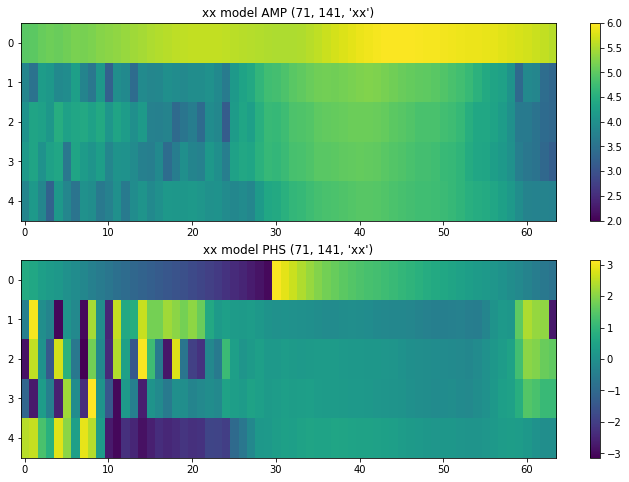

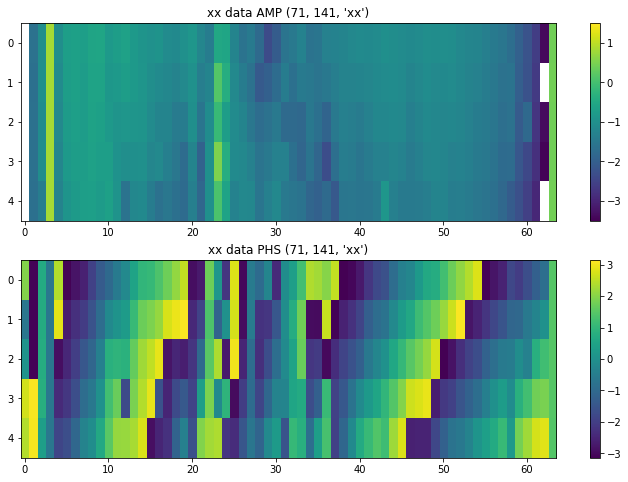

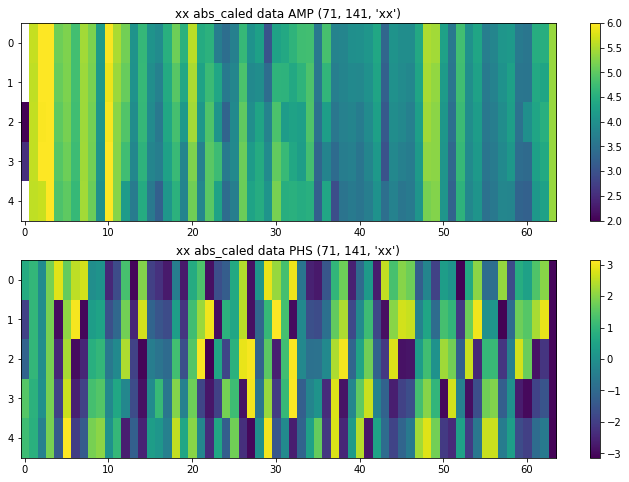

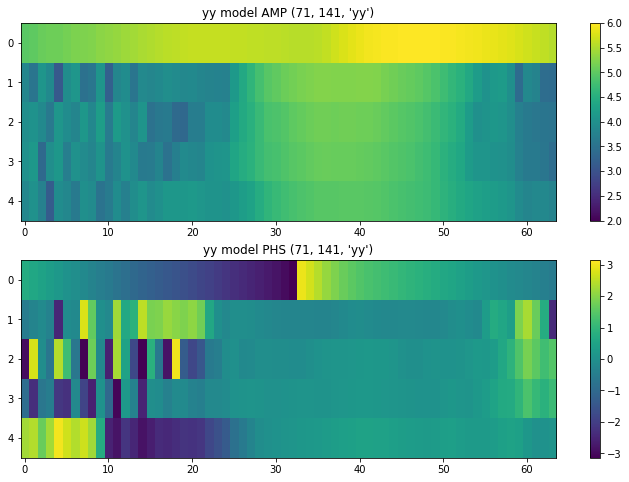

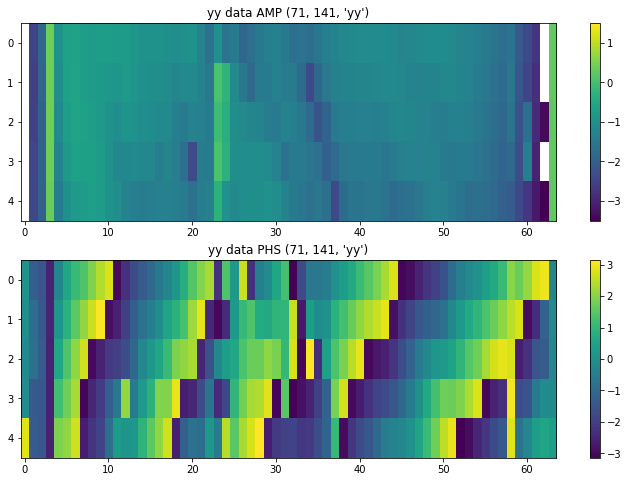

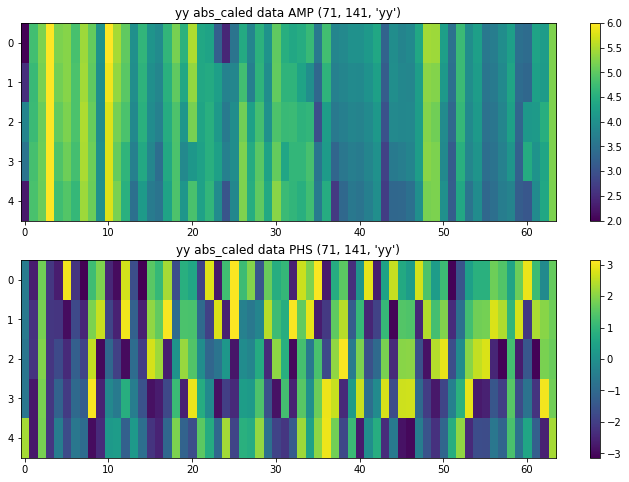

In [99]:
if PointSource_AbsCal:
	for i in range(2):  # add another redundant 'for loop' for testing plotting.
		pol = ['xx', 'yy'][i]
		try:
			# plt.figure(80000000 + 10 * i)
			# fig3[i], axes3[i] = plt.subplots(2, 1, figsize=(12, 8))
			# plt.sca(axes3[i][0])
			# uvt.plot.waterfall(AC_dred_mfreq[i].model[bl_dred_mfreq[i]], mode='log', mx=6, drng=4)
			# plt.colorbar()
			# plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq[i]))
			# plt.sca(axes3[i][1])
			# uvt.plot.waterfall(AC_dred_mfreq[i].model[bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2 * np.pi)
			# plt.colorbar()
			# plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq[i]))
			# plt.show(block=False)
			# plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Modcal_model-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			# # plt.cla()
			
			plt.figure(80000000 + 10 * i)
			fig4[i], axes4[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4[i][0])
			uvt.plot.waterfall(fullsim_vis_mfreq[bl_dred_mfreq_pscal_select, i, :, :], mode='log', mx=6, drng=4)
			plt.colorbar()
			plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4[i][1])
			uvt.plot.waterfall(fullsim_vis_mfreq[bl_dred_mfreq_pscal_select, i, :, :], mode='phs', mx=np.pi, drng=2 * np.pi)
			plt.colorbar()
			plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Pscal-%s_model-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], 'SinFreq' if PointSource_AbsCal_SingleFreq else 'MulFreq', ['xx', 'yy'][i], freq, nUBL_used, nt_used, bnside, nside_standard))
			# plt.cla()
			
			# plt.figure(90000000 + 10 * i)
			# fig4_data[i], axes4_data[i] = plt.subplots(2, 1, figsize=(12, 8))
			# plt.sca(axes4_data[i][0])
			# uvt.plot.waterfall(data_dred_mfreq[i][bl_dred_mfreq[i]], mode='log', mx=1.5, drng=5)
			# plt.colorbar()
			# plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq[i]))
			# plt.sca(axes4_data[i][1])
			# uvt.plot.waterfall(data_dred_mfreq[i][bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2 * np.pi)
			# plt.colorbar()
			# plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq[i]))
			# plt.show(block=False)
			# plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Modcal_data-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			# # plt.cla()
			if From_AbsCal:
				plt.figure(90000000 + 10 * i)
				fig4_data[i], axes4_data[i] = plt.subplots(2, 1, figsize=(12, 8))
				plt.sca(axes4_data[i][0])
				uvt.plot.waterfall(vis_data_dred_mfreq_abscal[i][:, :, bl_dred_mfreq_pscal_select].transpose(), mode='log', mx=1.5, drng=5)
				plt.colorbar()
				plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq_pscal[i]))
				plt.sca(axes4_data[i][1])
				uvt.plot.waterfall(vis_data_dred_mfreq_abscal[i][:, :, bl_dred_mfreq_pscal_select].transpose(), mode='phs', mx=np.pi, drng=2 * np.pi)
				plt.colorbar()
				plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq_pscal[i]))
				plt.show(block=False)
				plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Pscal-%s_data-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], 'SinFreq' if PointSource_AbsCal_SingleFreq else 'MulFreq', ['xx', 'yy'][i], freq, nUBL_used, nt_used, bnside, nside_standard))
			
			else:			
				plt.figure(90000000 + 10 * i)
				fig4_data[i], axes4_data[i] = plt.subplots(2, 1, figsize=(12, 8))
				plt.sca(axes4_data[i][0])
				uvt.plot.waterfall(vis_data_dred_mfreq[i][:, :, bl_dred_mfreq_pscal_select].transpose(), mode='log', mx=1.5, drng=5)
				plt.colorbar()
				plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq_pscal[i]))
				plt.sca(axes4_data[i][1])
				uvt.plot.waterfall(vis_data_dred_mfreq[i][:, :, bl_dred_mfreq_pscal_select].transpose(), mode='phs', mx=np.pi, drng=2 * np.pi)
				plt.colorbar()
				plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq_pscal[i]))
				plt.show(block=False)
				plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Pscal-%s_data-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], 'SinFreq' if PointSource_AbsCal_SingleFreq else 'MulFreq', ['xx', 'yy'][i], freq, nUBL_used, nt_used, bnside, nside_standard))
			# plt.cla()
			
			####################### after ABS Calibration #########################
			# plt.figure(8000000 + 10 * i)
			# fig4_data_abscorr[i], axes4_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
			# plt.sca(axes4_data_abscorr[i][0])
			# uvt.plot.waterfall(abs_corr_data_dred_mfreq[i][bl_dred_mfreq[i]], mode='log', mx=6, drng=4)
			# plt.colorbar()
			# plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq[i]))
			# plt.sca(axes4_data_abscorr[i][1])
			# uvt.plot.waterfall(abs_corr_data_dred_mfreq[i][bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2 * np.pi)
			# plt.colorbar()
			# plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq[i]))
			# plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Modcal_data-caled-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, bnside, nside_standard))
			# plt.show(block=False)
			# # plt.cla()
			
			plt.figure(8000000 + 10 * i)
			fig4_data_abscorr[i], axes4_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4_data_abscorr[i][0])
			uvt.plot.waterfall(vis_data_dred_mfreq_pscal[i][:, :, bl_dred_mfreq_pscal_select].transpose(), mode='log', mx=6, drng=4)
			plt.colorbar()
			plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4_data_abscorr[i][1])
			uvt.plot.waterfall(vis_data_dred_mfreq_pscal[i][:, :, bl_dred_mfreq_pscal_select].transpose(), mode='phs', mx=np.pi, drng=2 * np.pi)
			plt.colorbar()
			plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-Pscal-%s_data-caled-%s-%.2fMHz-nubl%s-nt%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[bl_dred_mfreq_select, 0], used_common_ubls[bl_dred_mfreq_select, 1], 'SinFreq' if PointSource_AbsCal_SingleFreq else 'MulFreq', ['xx', 'yy'][i], freq, nUBL_used, nt_used, bnside, nside_standard))
			plt.show(block=False)
			# plt.cla()
		except:
			print('Error when Plotting Pscal Results')

In [100]:
print(southern_points['cas']['ra'], southern_points['cas']['dec'])
print(southern_points['cyg']['ra'], southern_points['cyg']['dec'])
print(southern_points['sag']['ra'], southern_points['sag']['dec'])
print(southern_points['cen']['ra'], southern_points['cen']['dec'])
print(southern_points['cas']['body']._ra, southern_points['cas']['body']._dec)
print(southern_points['cyg']['body']._ra, southern_points['cyg']['body']._dec)
print(southern_points['sag']['body']._ra, southern_points['sag']['body']._dec)
print(southern_points['cen']['body']._ra, southern_points['cen']['body']._dec)
print(southern_points['hyd']['body']._ra, southern_points['hyd']['body']._dec)
print(southern_points['pic']['body']._ra, southern_points['pic']['body']._dec)
print(southern_points['for']['body']._ra, southern_points['for']['body']._dec)
print(southern_points['crab']['body']._ra, southern_points['crab']['body']._dec)
print(southern_points['vir']['body']._ra, southern_points['vir']['body']._dec)
print(np.where((equatorial_GSM_standard>3000) & (equatorial_GSM_standard<=7500)))
print(np.where(((PI / 2 - full_thetas)>=-0.81) & ((PI / 2 - full_thetas)<=-0.78) & (full_phis>=1.38) & (full_phis<=1.41))
     )

print(full_phis[3686], (PI / 2 - full_thetas)[3686]) # cyg
print(full_phis[3571], (PI / 2 - full_thetas)[3571]) # cas
print(full_phis[7206], (PI / 2 - full_thetas)[7206]) # sag
print(full_phis[6044], (PI / 2 - full_thetas)[6044]) # crab
print(full_phis[8623], (PI / 2 - full_thetas)[8623]) # for
print(full_phis[10815], (PI / 2 - full_thetas)[10815]) # cen
print(full_phis[10194], (PI / 2 - full_thetas)[10194]) # hyd
print(full_phis[8526], (PI / 2 - full_thetas)[8526]) # pic

('23:23:26', '58:48:00')
('19:59:28.3', '40:44:02')
('17:45:40.045', '-29:0:27.9')
('13:25:27.6', '-43:01:09')
(6.123633124726438, 1.0262536001726656)
(5.233682466929313, 0.7109404782526458)
(4.649851288013907, -0.5062807460953851)
(3.5144822482783815, -0.7508260997975272)
(2.435148822229438, -0.21110726930233636)
(1.3955143644581494, -0.7989923390157596)
(0.8844237818324766, -0.6494079258462235)
(1.459674849423026, 0.3842250233666105)
(3.2760848168663896, 0.21626568686934178)
(array([ 3571,  3572,  3686,  7200,  7201,  7202,  7203,  7204,  7205,
        7206,  7207,  7209,  7212,  7213,  7218,  7219,  7222,  7223,
        7224,  7225,  7228,  7229,  7231,  7272,  7273,  7274,  7275,
        7278,  7279,  7365,  7376,  7377,  7380,  7382,  7383,  7554,
        7564,  7565, 10453, 10539, 10542, 10543, 10551, 10553, 10556,
       10557, 10594, 10595, 10597, 10598, 10599, 10608, 10609, 10610,
       10611, 10612, 10613, 10614, 10615, 10624, 10625]),)
(array([8526]),)
(5.227806525114264, 0

In [101]:
print(full_phis[3686], (PI / 2 - full_thetas)[3686]) # cyg: 3544.825
print(full_phis[3571], (PI / 2 - full_thetas)[3571]) # cas: 5537.374
print(full_phis[3572], (PI / 2 - full_thetas)[3572]) # cas: 3438.114
print(full_phis[7206], (PI / 2 - full_thetas)[7206]) # sag: 7382.852
print(full_phis[7207], (PI / 2 - full_thetas)[7207]) # sag: 7442.244
print(full_phis[6044], (PI / 2 - full_thetas)[6044]) # crab: 868.720
print(full_phis[8623], (PI / 2 - full_thetas)[8623]) # for: 457.697
print(full_phis[10815], (PI / 2 - full_thetas)[10815]) # cen: 1334.333
print(full_phis[10194], (PI / 2 - full_thetas)[10194]) # hyd: 238.472
print(full_phis[8526], (PI / 2 - full_thetas)[8526]) # pic: 287.830

(5.227806525114264, 0.7297276562269662)
(6.096185744465908, 1.0283440744418186)
(6.1709855695513784, 1.0283440744418186)
(4.638757902566178, -0.5235987755982991)
(4.663301595172349, -0.4997050407593644)
(1.4726215563702154, 0.362022824905472)
(0.8835729338221292, -0.6487196783405782)
(3.5216240229756552, -0.7575925985268412)
(2.4298255680108554, -0.20987059226273774)
(1.387536755335492, -0.7852913518731985)


In [102]:
print(equatorial_GSM_standard[3571], equatorial_GSM_standard[3566:3579], equatorial_GSM_standard[3686],
      equatorial_GSM_standard[3683:3689], equatorial_GSM_standard[7203:7230],
      equatorial_GSM_standard[7207], equatorial_GSM_standard[6044], equatorial_GSM_standard[8623],
      equatorial_GSM_standard[8526], equatorial_GSM_standard[10194], equatorial_GSM_standard[10815],
     np.mean(equatorial_GSM_standard), np.max(equatorial_GSM_standard))

(5537.374647951483, array([ 676.25752985,  747.52044175,  701.19091076, 2577.51664751,
       1562.58739117, 5537.37464795, 3438.12143087,  799.33959791,
       2945.80192857,  792.93136406,  936.07016572, 1622.48121017,
        885.07112618]), 3544.8187333154156, array([2831.11252877, 1962.9267783 , 1640.10998827, 3544.81873332,
        933.92935222,  466.80331886]), array([5318.72808941, 3814.15848854, 3831.2951914 , 7442.22819756,
       7382.96324557, 2698.17790507, 3144.60362566, 1863.47436001,
       1996.45550494, 3898.83524978, 4332.94001489, 2045.86857356,
       2150.09318473, 2618.02659572, 2448.66509524, 5675.11907246,
       4367.37683571, 2263.10525681, 2060.2488206 , 3964.91365266,
       3060.06927868, 3945.7727629 , 4243.89671997, 2336.74139239,
       2598.75126339, 4984.36041278, 5011.12755709]), 7382.963245567251, 868.7186344737319, 457.6966278241435, 287.82999583989107, 238.47210090007889, 1334.331098158698, 388.12366484003223, 7442.2281975619235)


In [103]:
#Absolute_Calibration_dred_mfreq_pscal = True

if Absolute_Calibration_dred_mfreq_pscal:
	
	for i in range(2):
		data_dred_mfreq_pscal[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		if Absolute_Calibration_dred_mfreq:
			keys = dflags_dred_mfreq[i].keys()
			for key_index, key in enumerate(keys):
				#model_dred_mfreq[i][key] = fullsim_vis_mfreq[key_index, i]
				#data_dred_mfreq[i][key] = np.real(vis_data_dred_mfreq[i][:, :, key_index].transpose()) + np.abs(np.imag(vis_data_dred_mfreq[i][:, :, key_index].transpose()))*1j #[pol][freq,time,ubl_index].transpose()
				data_dred_mfreq_pscal[i][key] = vis_data_dred_mfreq_pscal[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
			if add_Autobsl:
				model_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
				data_dred_mfreq_pscal[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
				cdflags_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
				auto_select_dred_mfreq_pscal[i] = (keys[0][0], keys[0][0], keys[0][2])
			print(dflags_dred_mfreq[i].keys())
			print(dflags_dred_mfreq[i].keys()[0][0])
				
		
				
	re_cal_times = 3

	for i in range(2):
		pol = ['xx', 'yy'][i]
		re_cal = 0
		
		if Absolute_Calibration_dred_mfreq_pscal:
			for re_cal in range(re_cal_times): # number of times of absolute calibration
				if re_cal == 0:
					model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
					# instantiate class
					AC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
					# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
					AC_dred_mfreq_pscal[i].delay_lincal(kernel=(1, 11), medfilt=True, time_avg=True, solve_offsets=True)
				else:
					#model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
					# instantiate class
					AC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], abs_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
					# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
					AC_dred_mfreq_pscal[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
				# apply to data
				delay_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(AC_dred_mfreq_pscal[i].data, (AC_dred_mfreq_pscal[i].ant_dly_gain))
				# instantiate class
				DAC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], delay_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# avg phase solver
				DAC_dred_mfreq_pscal[i].phs_logcal(avg=True)
				# apply to data
				dly_phs_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(DAC_dred_mfreq_pscal[i].data, (DAC_dred_mfreq_pscal[i].ant_phi_gain))
				# instantiate class
				DPAC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], dly_phs_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# run amp linsolve
				DPAC_dred_mfreq_pscal[i].abs_amp_logcal()
				# run phs linsolve
				DPAC_dred_mfreq_pscal[i].TT_phs_logcal(zero_psi=False, four_pol=False)
				# apply to data
				abs_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(DPAC_dred_mfreq_pscal[i].data, 
										(DPAC_dred_mfreq_pscal[i].abs_psi_gain, DPAC_dred_mfreq_pscal[i].TT_Phi_gain, DPAC_dred_mfreq_pscal[i].abs_eta_gain), gain_convention='multiply')
									
			vis_data_dred_mfreq_pscal_abscal[i] = np.zeros_like(vis_data_dred_mfreq_pscal[i], dtype='complex128')
			for key_id, key in enumerate(dflags_dred_mfreq[i].keys()):
				vis_data_dred_mfreq_pscal_abscal[i][:, :, key_id] = abs_corr_data_dred_mfreq_pscal[i][key].transpose()
				#vis_data_dred_mfreq_pscal_abscal[i][:, :, key_id] = np.real(abs_corr_data_dred_mfreq_pscal[i][key].transpose()) + np.abs(np.imag(abs_corr_data_dred_mfreq_pscal[i][key].transpose()))*1j
			if add_Autobsl:
				autocorr_data_dred_mfreq_pscal_abscal[i] = abs_corr_data_dred_mfreq_pscal[i][auto_select_dred_mfreq_pscal[i]]
			else:
				autocorr_data_dred_mfreq_pscal_abscal[i] = autocorr_vis_mfreq[i]
				
			vis_data_dred_pscal_abscal[i] = vis_data_dred_mfreq_pscal_abscal[i][index_freq[i], :, :]
			if add_Autobsl: 
				autocorr_data_dred_pscal_abscal[i] = autocorr_data_dred_mfreq_pscal_abscal[i][:, index_freq[i]]
			else:
				autocorr_data_dred_pscal_abscal[i] = autocorr_vis_mfreq[i][:, index_freq[i]]
			
	for i in range(2):
		pol = ['xx', 'yy'][i]
		
		if Absolute_Calibration_dred_mfreq_pscal:
			plt.figure(85000000 + 10 * i)
			fig5[i], axes5[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes5[i][0])
			uvt.plot.waterfall(AC_dred_mfreq_pscal[i].model[bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=5)
			plt.colorbar()
			plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes5[i][1])
			uvt.plot.waterfall(AC_dred_mfreq_pscal[i].model[bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2 * np.pi)
			plt.colorbar()
			plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)
			# plt.cla()
			
			plt.figure(95000000 + 10 * i)
			fig5_data[i], axes5_data[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes5_data[i][0])
			uvt.plot.waterfall(data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=6)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes5_data[i][1])
			uvt.plot.waterfall(data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2 * np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)
			# plt.cla()
			
			####################### after ABS Calibration #########################
			plt.figure(8500000 + 10 * i)
			fig5_data_abscorr[i], axes5_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes5_data_abscorr[i][0])
			uvt.plot.waterfall(abs_corr_data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=5)
			plt.colorbar()
			plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes5_data_abscorr[i][1])
			uvt.plot.waterfall(abs_corr_data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2 * np.pi)
			plt.colorbar()
			plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)
	# plt.cla()
	

In [104]:
################################### Store Visibility Data and prepare to Delete Variable ##################################
try:
	data_vis_xx_filename = script_dir + '/../Output/%s_%sMHz_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx.simvis' % (INSTRUMENT, freq, nUBL_used + 1, nt_used, nside_standard, bnside)
	data_vis_yy_filename = script_dir + '/../Output/%s_%sMHz_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy.simvis' % (INSTRUMENT, freq, nUBL_used + 1, nt_used, nside_standard, bnside)
	vis_data[0].astype('complex128').tofile(data_vis_xx_filename)
	vis_data[1].astype('complex128').tofile(data_vis_yy_filename)
except:
	pass

try:
	data_vis_dred_xx_filename = script_dir + '/../Output/%s_%sMHz_p2_u%i_t%i_nside%i_bnside%i_vis_data_dred_xx.simvis' % (INSTRUMENT, freq, nUBL_used + 1, nt_used, nside_standard, bnside)
	data_vis_dred_yy_filename = script_dir + '/../Output/%s_%sMHz_p2_u%i_t%i_nside%i_bnside%i_vis_data_dred_yy.simvis' % (INSTRUMENT, freq, nUBL_used + 1, nt_used, nside_standard, bnside)
	vis_data_dred[0].astype('complex128').tofile(data_vis_dred_xx_filename)
	vis_data_dred[1].astype('complex128').tofile(data_vis_dred_yy_filename)
except:
	pass


try:
	data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_mfreq%s-%s-%sMHz_dred_mfreq.simvis' % (INSTRUMENT, nUBL_used + 1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_mfreq%s-%s-%sMHz_dred_mfreq.simvis' % (INSTRUMENT, nUBL_used + 1, nt_used, nside_standard, bnside, np.min(flist[1]), np.max(flist[1]), len(flist[1]))
	vis_data_dred_mfreq[0].astype('complex128').tofile(data_vis_dred_mfreq_xx_filename)
	vis_data_dred_mfreq[1].astype('complex128').tofile(data_vis_dred_mfreq_yy_filename)
except:
	pass

try:
	abscal_data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i-mtbin%s-mfbin%s_nside%i_bnside%i_vis_data_xx_mfreq%s-%s-%sMHz_dred_mfreq_abscal.simvis' % (INSTRUMENT, nUBL_used + 1, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	abscal_data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i-mtbin%s-mfbin%s_nside%i_bnside%i_vis_data_yy_mfreq%s-%s-%sMHz_dred_mfreq_abscal.simvis' % (INSTRUMENT, nUBL_used + 1, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', nside_standard, bnside, np.min(flist[1]), np.max(flist[1]), len(flist[1]))
	vis_data_dred_mfreq_abscal[0].astype('complex128').tofile(abscal_data_vis_dred_mfreq_xx_filename)
	vis_data_dred_mfreq_abscal[1].astype('complex128').tofile(abscal_data_vis_dred_mfreq_yy_filename)
except:
	pass

try:
	abscal_data_vis_dred_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i-mtbin%s-mfbin%s_nside%i_bnside%i_vis_data_xx_%sMHz_dred_abscal.simvis' % (INSTRUMENT, nUBL_used + 1, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', nside_standard, bnside, freq)
	abscal_data_vis_dred_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i-mtbin%s-mfbin%s_nside%i_bnside%i_vis_data_yy_%sMhz_dred_abscal.simvis' % (INSTRUMENT, nUBL_used + 1, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', nside_standard, bnside, freq)
	vis_data_dred_abscal[0].astype('complex128').tofile(abscal_data_vis_dred_xx_filename)
	vis_data_dred_abscal[1].astype('complex128').tofile(abscal_data_vis_dred_yy_filename)
except:
	pass

try:
	pscal_data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_mfreq%s-%s-%sMHz_dred_mfreq_pscal.simvis' % (INSTRUMENT, nUBL, nt, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	pscal_data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_mfreq%s-%s-%sMHz_dred_mfreq_pscal.simvis' % (INSTRUMENT, nUBL, nt, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	vis_data_dred_mfreq_pscal[0].astype('complex128').tofile(pscal_data_vis_dred_mfreq_xx_filename)
	vis_data_dred_mfreq_pscal[1].astype('complex128').tofile(pscal_data_vis_dred_mfreq_yy_filename)
	
	pscal_data_vis_dred_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_%sMHz_pscal.simvis' % (INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
	pscal_data_vis_dred_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_%sMHz_pscal.simvis' % (INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
	vis_data_dred_pscal[0].astype('complex128').tofile(pscal_data_vis_dred_xx_filename)
	vis_data_dred_pscal[1].astype('complex128').tofile(pscal_data_vis_dred_yy_filename)
except:
	pass
	

sys.stdout.flush()


In [105]:
#print noise['x']

In [106]:
################
####read data and N
################
data = {}
Ni = {}
data_shape = {}
ubl_sort = {}
data_filename = full_sim_filename

#Use_Simulation_noise = True
#From_File_Data = True

for p in ['x', 'y']:
	pol = p + p
	print "%i UBLs to include, longest baseline is %i wavelengths" % (
		nUBL_used, np.max(np.linalg.norm(used_common_ubls, axis=1)) / (C / freq))
	if p == 'x':
		pol_index = 0
		sim_var_filename = sim_var_xx_filename
		sim_vis_filename = sim_vis_xx_filename
		try:
			data_var_filename = data_var_xx_filename
			data_var_filename_pscal = data_var_xx_filename_pscal
		except:
			pass
	elif p == 'y':
		pol_index = 1
		sim_var_filename = sim_var_yy_filename
		sim_vis_filename = sim_vis_yy_filename
		try:
			data_var_filename = data_var_yy_filename
			data_var_filename_pscal = data_var_yy_filename_pscal
		except:
			pass
	
	# get Ni (1/variance) and data
	#	var_filename = datadir + tag + '_%s%s_%i_%i' % (p, p, nt, nUBL) + vartag + '.var'
	#	Ni[pol] = 1. / (N[p].reshape((nt_used, nUBL_used))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() * jansky2kelvin ** 2)
	if Use_SimulatedData == 1:
		#		Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt_used, nUBL_used))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() * jansky2kelvin ** 2)
		Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
		data[pol] = (np.fromfile(sim_vis_filename, dtype='complex128').reshape((nUBL_used, nt_used)))#.conjugate()
	else:
		if INSTRUMENT == 'miteor':
			if Use_Simulation_noise:
				Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten())
			else:
				Ni[pol] = 1. / var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			data[pol] = vis_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1]  # = (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
			data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0].conjugate()
			#			data[pol] = (data[pol].flatten() * jansky2kelvin).conjugate()  # there's a conjugate convention difference
			data[pol] = (data[pol].flatten()).conjugate()  # there's a conjugate convention difference
		elif INSTRUMENT == 'hera47':
			if From_File_Data:
				if Use_PsAbsCal:
					Ni[pol] = 1. / (np.fromfile(data_var_filename_pscal, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten())  # var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
				elif Use_Fullsim_Noise:
					Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
				else:
					Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten())  # var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			else:
				if Use_PsAbsCal:
					Ni[pol] = 1. / N_data_pscal[p].reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten()  # var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
				elif Use_Fullsim_Noise:
					Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
				else:
					Ni[pol] = 1. / N_data[p].reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten()  # var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			if From_File_Data:
				if Use_PsAbsCal:
					data[pol] = np.fromfile(globals()['pscal_data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
				elif Use_AbsCal:
					data[pol] = np.fromfile(globals()['abscal_data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
				else:
					data[pol] = jansky2kelvin * np.fromfile(globals()['data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]#.conjugate()
			else:
				if Use_PsAbsCal:
					data[pol] = vis_data_dred_pscal[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1]  # = (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					# data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = data[pol].flatten()  # .conjugate()  # there's a conjugate convention difference
				elif Use_AbsCal:
					data[pol] = vis_data_dred_abscal[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1]  # = (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					# data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = data[pol].flatten()  # .conjugate()  # there's a conjugate convention difference
				else:
					data[pol] = jansky2kelvin * vis_data_dred[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1]#.conjugate()  # = (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					# data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0].conjugate()
					# data[pol] = (data[pol].flatten() * jansky2kelvin).conjugate()  # there's a conjugate convention difference
	# data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
	# data[pol] = (data[pol].flatten() * jansky2kelvin)#.conjugate()  # there's a conjugate convention difference
	data_shape[pol] = (nUBL_used, nt_used)
	ubl_sort[p] = np.argsort(la.norm(used_common_ubls, axis=1))
print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024)
sys.stdout.flush()

# Merge data
data = np.array([data['xx'], data['yy']]).reshape([2] + list(data_shape['xx'])).transpose(
	(1, 0, 2)).flatten()
data = np.concatenate((np.real(data), np.imag(data))).astype('complex128')
Ni = np.concatenate((Ni['xx'], Ni['yy'])).reshape([2] + list(data_shape['xx'])).transpose(
	(1, 0, 2)).flatten()
Ni = np.concatenate((Ni * 2, Ni * 2))

sys.stdout.flush()


74 UBLs to include, longest baseline is 59 wavelengths
74 UBLs to include, longest baseline is 59 wavelengths
Memory usage: 3285852.000MB


In [107]:
##################### Delete or Erase Data #######################
#Erase = True
if Erase:
	model_sf = {}
	model_dred = {}
	model_dred_mfreq = {}
	#data = {}
	data_sf = {}
	data_dred = {}
	data_dred_mfreq = {}
	AC = {}
	AC_sf = {}
	AC_dred = {}
	AC_dred_mfreq = {}
	freq_to_cal = [freq]
	fulldflags = {}
	auto_select_dred_mfreq = {}

	#	try:
	#		cdata = copy.deepcopy(data)
	#	except:
	#		pass

	try:
		del(dflags_sf) 
		#del(cdflags_sf)
	except:
		pass
		
	try:
		del(dflags_dred) 
		#del(cdflags_dred)
	except:
		pass

	try:
		del(dflags)
		#del(cdflags) 
	except:
		pass

	try:
		del(dflags_dred_mfreq)
		#del(cdflags_dred_mfreq) 
	except:
		pass
		
	#cwgts = copy.deepcopy(wgts)
	#cwgts_dred = copy.deepcopy(wgts_dred)

	bl_select = 0
	#bl = dflags.keys()[bl_select] #dflags and dflags_yy #[(24, 53, 'xx')
	fig = {}
	axes = {}
	fig_data = {}
	axes_data = {}

	bl_dred_select = 0
	#bl_dred = dflags_dred[0].keys()[bl_dred_select] #[(25, 37, 'xx')
	fig2 = {}
	axes2 = {}
	fig2_data = {}
	axes2_data = {}

	bl_dred_mfreq_select = 8
	#bl_dred_mfreq = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_select]]  #[(25, 37, 'xx'), (25, 37, 'yy')]
	fig3 = {}
	axes3 = {}
	fig3_data = {}
	axes3_data = {}
	fig3_data_abscorr = {} 
	axes3_data_abscorr = {}

	delay_corr_data = {}
	delay_corr_data_sf = {}
	delay_corr_data_dred = {}
	delay_corr_data_dred_mfreq = {}
	DAC = {}
	DAC_sf = {}
	DAC_dred = {}
	DAC_dred_mfreq = {}
	dly_phs_corr_data = {}
	dly_phs_corr_data_sf = {}
	dly_phs_corr_data_dred = {}
	dly_phs_corr_data_dred_mfreq = {}
	DPAC = {}
	DPAC_sf = {}
	DPAC_dred = {}
	DPAC_dred_mfreq = {}
	abs_corr_data = {}
	abs_corr_data_sf = {}
	abs_corr_data_dred = {}
	abs_corr_data_dred_mfreq = {}

	vis_data_dred_mfreq_abscal = [[], []]
	autocorr_data_dred_mfreq_abscal = [[], []]
	vis_data_dred_abscal = [[], []]
	autocorr_data_dred_abscal = [[], []]


	Del = True
	if Del:
		try:
			del(vis_data)
			del(vis_data_dred)
		except:
			pass
		try:
			del(vis_data_mfreq)
			del(vis_data_dred_mfreq)
		except:
			pass	
			
			
		try:
			del(N_data)
		except:
			pass
		try:
			del(noise_data)
		except:
			pass
		try:
			del(var_data)
		except:
			pass
	#	try:
	#		del(var_data)
	#	except:
	#		pass

sys.stdout.flush()


In [108]:
print Ni

[1.00705167e-03+0.j 5.14575954e+00+0.j 5.95639403e-01+0.j ...
 4.72719137e-02+0.j 2.94375463e-02+0.j 4.55536632e-03+0.j]


In [109]:
# pre_ampcal = False

In [110]:
#pre_ampcal = True

In [111]:
def get_complex_data(real_data, nubl=nUBL_used, nt=nt_used):
	if len(real_data.flatten()) != 2 * nubl * 2 * nt:
		raise ValueError("Incorrect dimensions: data has length %i where nubl %i and nt %i together require length of %i."%(len(real_data), nubl, nt, 2 * nubl * 2 * nt))
	input_shape = real_data.shape
	real_data.shape = (2, nubl, 2, nt)
	result = real_data[0] + 1.j * real_data[1]
	real_data.shape = input_shape
	return result

def stitch_complex_data(complex_data):
	return np.concatenate((np.real(complex_data.flatten()), np.imag(complex_data.flatten()))).astype('complex128')

################################
################################
####pre_calibrate################
################################
################################
#####1. antenna based calibration#######
precal_time_bin = np.min([Precal_time_bin_temp, nt_used])
precal_time_bin_num = (data_shape['xx'][1] / precal_time_bin) if np.mod(data_shape['xx'][1], precal_time_bin) == 0 else (data_shape['xx'][1] / precal_time_bin) + 1
print ("Precal_time_bin: %s; \nPrecal_time_bin_num: %s"%(precal_time_bin, precal_time_bin_num))
raw_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])

if antpairs is not None:
	used_antpairs = antpairs[abs(ubl_index['x']) - 1]
	n_usedants = np.unique(used_antpairs)
#####2. re-phasing and crosstalk#######
additive_A = np.zeros((nUBL_used, 2, nt_used, 1 + 4 * nUBL_used)).astype('complex128')

# put in autocorr regardless of whats saved on disk
for p in range(2):
	additive_A[:, p, :, 0] = fullsim_vis[:, p]
	for i in range(nUBL_used):
		additive_A[i, p, :, 1 + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p]#[id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)]
		additive_A[i, p, :, 1 + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p]#[id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)]
additive_A.shape = (nUBL_used * 2 * nt_used, 1 + 4 * nUBL_used)

additive_term = np.zeros_like(data)
additive_term_incr = np.zeros_like(data)


for id_t_bin in range(precal_time_bin_num):
	nt_precal_used = precal_time_bin if ((id_t_bin + 1) * precal_time_bin) <= data_shape['xx'][1] else (data_shape['xx'][1] - id_t_bin * precal_time_bin)
	print ('Nt_precal_used: %s'%nt_precal_used)
	
	additive_A_tbin = additive_A.reshape(nUBL_used, 2, nt_used, 1 + 4 * nUBL_used)[:, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used), :].reshape(nUBL_used * 2 * nt_precal_used, 1 + 4 * nUBL_used)
	
	for cal_index in range(1):
		# if cal_index == 0:
			# raw_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
		#	if pre_ampcal:
		#		pre_ampcal = False if cal_index == 0 else True
		#		cal_index += 1
		#	else:
		#		cal_index = 2
		# if antpairs is not None:
		# 	used_antpairs = antpairs[abs(ubl_index['x']) - 1]
		# 	n_usedants = np.unique(used_antpairs)
		# #####2. re-phasing and crosstalk#######
		# additive_A = np.zeros((nUBL_used, 2, nt_precal_used, 1 + 4 * nUBL_used)).astype('complex128')
		#
		# # put in autocorr regardless of whats saved on disk
		# for p in range(2):
		# 	additive_A[:, p, :, 0] = fullsim_vis[:, p]
		# 	for i in range(nUBL_used):
		# 		additive_A[i, p, :, 1 + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p][id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)]
		# 		additive_A[i, p, :, 1 + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p][id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)]
		# additive_A.shape = (nUBL_used * 2 * nt_precal_used, 1 + 4 * nUBL_used)
		
		if pre_calibrate:
			# import omnical.calibration_omni as omni
			# raw_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
			# raw_Ni = np.copy(Ni)
			
			real_additive_A = np.concatenate((np.real(additive_A_tbin), np.imag(additive_A_tbin)), axis=0).astype('complex128')
			if pre_ampcal:  # if pre_ampcal, allow xx and yy to fit amp seperately
				n_prefit_amp = 2
				real_additive_A.shape = (2 * nUBL_used, 2, nt_precal_used, 1 + 4 * nUBL_used)
				real_additive_A_expand = np.zeros((2 * nUBL_used, 2, nt_precal_used, n_prefit_amp + 4 * nUBL_used), dtype='complex128')
				for i in range(n_prefit_amp):
					real_additive_A_expand[:, i, :, i] = real_additive_A[:, i, :, 0]
				real_additive_A_expand[..., n_prefit_amp:] = real_additive_A[..., 1:]
				real_additive_A = real_additive_A_expand
				real_additive_A.shape = (2 * nUBL_used * 2 * nt_precal_used, n_prefit_amp + 4 * nUBL_used)
			else:
				n_prefit_amp = 1
			
			additive_AtNiA = np.empty((n_prefit_amp + 4 * nUBL_used, n_prefit_amp + 4 * nUBL_used), dtype='complex128')
			if pre_addcal:
				ATNIA(real_additive_A, Ni.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten(), additive_AtNiA)
				additive_AtNiAi = sla.inv(additive_AtNiA)
			else:
				real_additive_A[..., n_prefit_amp:] = 0.
				ATNIA(real_additive_A, Ni.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten(), additive_AtNiA)
				additive_AtNiAi = sla.pinv(additive_AtNiA)
			
			niter = 0
			rephases = np.zeros((2, 2))
			# additive_term = np.zeros_like(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten())
			# additive_term_incr = np.zeros_like(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten())
			while (niter == 0 or la.norm(rephases) > .001 or la.norm(additive_term_incr.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten()) / la.norm(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten()) > .001) and niter < 360:
				niter += 1
				
				if pre_phscal:
					cdata = get_complex_data(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten(), nt=nt_precal_used)
					for p, pol in enumerate(['xx', 'yy']):
						# rephase = omni.solve_phase_degen_fast(cdata[:, p].transpose(), cdata[:, p].transpose(), fullsim_vis[:, p].transpose(), fullsim_vis[:, p].transpose(), used_common_ubls)
						rephase = solve_phase_degen(cdata[:, p].transpose(), cdata[:, p].transpose(), fullsim_vis[:, p, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].transpose(), fullsim_vis[:, p, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].transpose(), used_common_ubls)
						rephases[p] = rephase
						if p == 0:
							print 'pre process rephase', pol, rephase,
						else:
							print pol, rephase
						cdata[:, p] *= np.exp(1.j * used_common_ubls[:, :2].dot(rephase))[:, None]
					data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)] = stitch_complex_data(cdata).reshape(2, data_shape['xx'][0], 2, nt_precal_used).astype('complex128')
				
				additive_sol = additive_AtNiAi.dot(np.transpose(real_additive_A).dot(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten() * Ni.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten()))
				print ('>>>>>>>>>>>>>additive fitting amp', additive_sol[:n_prefit_amp])
				# additive_term_incr_tbin = additive_term_incr.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]))[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten()
				additive_term_incr.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)] = real_additive_A[:, n_prefit_amp:].dot(additive_sol[n_prefit_amp:]).reshape(2, data_shape['xx'][0], 2, nt_precal_used)
				data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)] -= additive_term_incr.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)]
				additive_term.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)] += additive_term_incr.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)]
				print ("additive fraction", la.norm(additive_term_incr) / la.norm(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten()))
			
			cadd = get_complex_data(additive_term)
			
			if pre_ampcal:
				data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)] = stitch_complex_data(get_complex_data(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten(), nt=nt_precal_used) / additive_sol[ :n_prefit_amp, None]).reshape(2, data_shape['xx'][0], 2, nt_precal_used)
				if comply_ps2mod_autocorr or Use_AbsCal or Use_Fullsim_Noise:
					pass
				else:
					Ni.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)]= stitch_complex_data(get_complex_data(Ni.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten(), nt=nt_precal_used) * additive_sol[ :n_prefit_amp, None]** 2).reshape(2, data_shape['xx'][0], 2, nt_precal_used)
				additive_term.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)] = stitch_complex_data(get_complex_data(additive_term.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])[:, :, :, id_t_bin * precal_time_bin:(id_t_bin * precal_time_bin + nt_precal_used)].flatten(), nt=nt_precal_used) / additive_sol[ :n_prefit_amp, None]).reshape(2, data_shape['xx'][0], 2, nt_precal_used)
				
				print('Additive_sol: %s'%additive_sol[:n_prefit_amp])
try:
	print 'saving data to', os.path.dirname(data_filename) + '/' + INSTRUMENT + tag + datatag + vartag + '_gsmcal_n%i_bn%i_nubl%s_nt%s-mtbin%s-mfbin%s-tbin%s.npz' % (nside_standard, bnside, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none')
	np.savez(os.path.dirname(data_filename) + '/' + INSTRUMENT + tag + datatag + vartag + '_gsmcal_n%i_bn%i_%s_%s-mtbin%s-mfbin%s-tbin%s.npz' % (nside_standard, bnside, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'),
			 data=data,
			 simdata=stitch_complex_data(fullsim_vis),
			 psdata=[stitch_complex_data(vis) for vis in pt_vis],
			 pt_sources=pt_sources,
			 ubls=used_common_ubls,
			 tlist=lsts,
			 Ni=Ni,
			 freq=freq)
except:
	print('Error when Saving Calibrated Results Package.')
	


Precal_time_bin: 5; 
Precal_time_bin_num: 1
Nt_precal_used: 5
Estimated time for A 1480 by 298 0.00170858896 minutes pre process rephase xx [0. 0.] yy [0. 0.]
('>>>>>>>>>>>>>additive fitting amp', array([1.+0.j, 1.+0.j]))
('additive fraction', 0.0)
Additive_sol: [1.+0.j 1.+0.j]
saving data to /Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/../../../HERA_MapMaking_VisibilitySimulation/scripts/../Output/hera47hera47-150.000000-ampcal-_2018_2018_gsmcal_n32_bn64_nubl74_nt5-mtbin5-mfbin64-tbin5.npz


In [112]:
rephases

array([[0., 0.],
       [0., 0.]])

In [113]:
print la.norm(data)
print la.norm(raw_data)
print la.norm(fullsim_vis)
print la.norm(raw_data)/la.norm(data)
print #la.norm(raw_Ni)
print la.norm(Ni)
print data
print fullsim_vis

18663796.626589738
18663796.626589734
18663796.626589734
0.9999999999999998

16110.878900041382
[ 74546.46552258+0.j   7282.47191084+0.j  11860.6928597 +0.j ...
 -21350.22706006+0.j   6470.4512995 +0.j  -8067.79769463+0.j]
[[[ 7.45464655e+04-3.59972658e+04j  7.28247191e+03-8.89535717e+02j
    1.18606929e+04-5.28570774e+03j  4.85418709e+03-3.65900912e+03j
    5.24444625e+03+1.26751013e+03j]
  [ 7.58749052e+04-3.70755475e+04j  3.29528876e+03-6.50162686e+02j
    8.05549977e+02-5.78829172e+02j  8.73521024e+02-1.92321915e+03j
    2.05801190e+03+2.34023707e+03j]]

 [[-8.91874381e+03+7.19135607e+04j -3.79834816e+02-2.53088012e+02j
    1.07690315e+03-1.01382209e+03j  2.49224688e+03-3.97803096e+03j
    2.86789946e+03+2.24985344e+03j]
  [-4.22699382e+03+6.98932990e+04j  2.21393820e+03-6.45165060e+02j
    4.12612502e+03-1.28017712e+03j  7.34870825e+03-4.48216025e+03j
    9.80050707e+03+6.44707960e+03j]]

 [[-7.31731576e+04-5.43382648e+05j -8.05797468e+03-1.21287394e+03j
   -2.69838647e+03-4.45137

In [114]:
print additive_sol[0], additive_sol[1], n_prefit_amp
print (additive_sol[0] * (pre_ampcal)+(not pre_ampcal))
print additive_sol[:n_prefit_amp, None]
print pre_ampcal

(1.0000000000000002+0j) (0.9999999999999997+0j) 2
(1.0000000000000002+0j)
[[1.+0.j]
 [1.+0.j]]
True


In [115]:
print la.norm(data)
print la.norm(raw_data)
print la.norm(fullsim_vis)
print la.norm(fullsim_vis)/la.norm(data)
#print la.norm(raw_Ni)
print la.norm(Ni)
print Ni
print Ni.max()
print Ni**-0.5

18663796.626589738
18663796.626589734
18663796.626589734
0.9999999999999998
16110.878900041382
[1.00705167e-03+0.j 5.14575954e+00+0.j 5.95639403e-01+0.j ...
 4.72719137e-02+0.j 2.94375463e-02+0.j 4.55536632e-03+0.j]
(8942.382729898412+0j)
[31.51186607+0.j  0.44083418+0.j  1.29571143+0.j ...  4.59937063+0.j
  5.82839794+0.j 14.81625168+0.j]


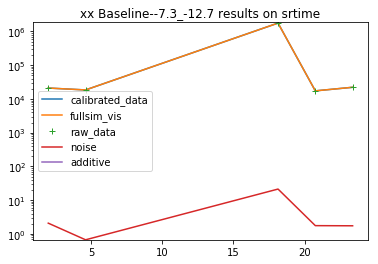

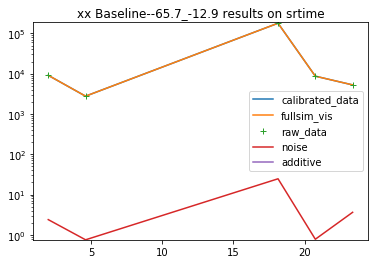

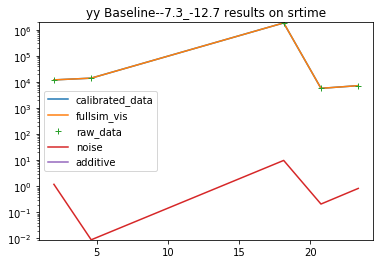

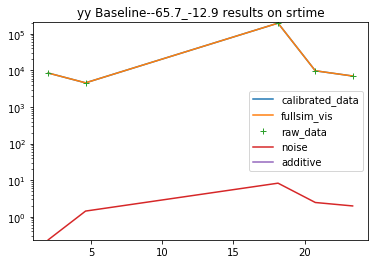

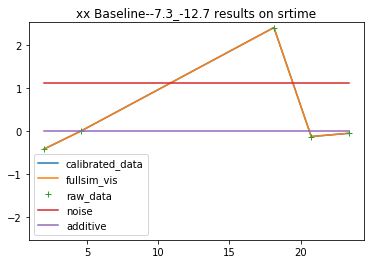

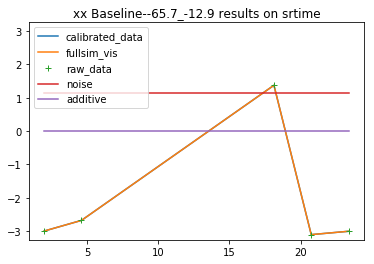

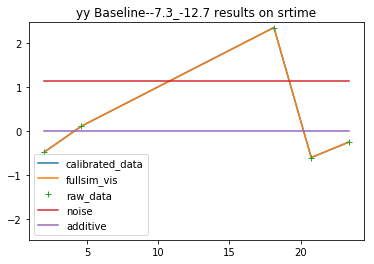

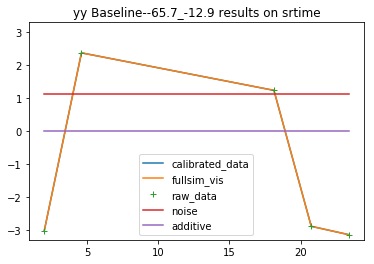

In [116]:
try:
	if plot_data_error:
		# plt.clf()
		
		cdata = get_complex_data(data)
		crdata = get_complex_data(raw_data)  # / (additive_sol[0] * (pre_ampcal) + (not pre_ampcal))
		cNi = get_complex_data(Ni)
		
		fun = np.abs
		srt = sorted((lsts - lst_offset) % 24. + lst_offset)
		asrt = np.argsort((lsts - lst_offset) % 24. + lst_offset)
		pncol = min(int(60. / (srt[-1] - srt[0])), 12) if nt_used > 1 else (len(ubl_sort['x'])/2)
		us = ubl_sort['x'][::len(ubl_sort['x']) / pncol] if len(ubl_sort['x']) / pncol >= 1 else ubl_sort['x']
		figure = {}
		#		plt.figure(400)
		#		plt.subplots_adjust(hspace=1.2,wspace=0.7)
		for p in range(2):
			for nu, u in enumerate(us):
				plt.figure(5000 + 100 * p + nu)
				# plt.subplot(5, (len(us) + 4) / 5, nu + 1)
				figure[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
				figure[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
				figure[3], = plt.plot(srt, fun(crdata[u, p][asrt]), '+', label='raw_data')
				figure[4], = plt.plot(srt, fun(cNi[u, p][asrt]) ** -.5, label='Ni')
				if pre_calibrate:
					figure[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
					data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(fun(cadd[u, p]))])  # 5 * np.max(np.abs(fun(cNi[u, p]))),
				else:
					data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p])))])  # 5 * np.max(np.abs(fun(cNi[u, p])))
				plt.yscale('log')
				plt.title("%s Baseline-%.1f_%.1f results on srtime" % (['xx', 'yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
				plt.ylim([-1.05 * data_range, 1.05 * data_range])
				if pre_calibrate:
					plt.legend(handles=[figure[1], figure[2], figure[3], figure[4], figure[5]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise', 'additive'], loc=0)
				else:
					plt.legend(handles=[figure[1], figure[2], figure[3], figure[4]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise'], loc=0)
				plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Abs_Full_vis-%s-%.2fMHz-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard))
				plt.show(block=False)
			
		fun = np.angle
		for p in range(2):
			for nu, u in enumerate(us):
				plt.figure(50000 + 100 * p + nu)
				# plt.subplot(5, (len(us) + 4) / 5, nu + 1)
				figure[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
				figure[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
				figure[3], = plt.plot(srt, fun(crdata[u, p][asrt]), '+', label='raw_data')
				figure[4], = plt.plot(srt, fun(cNi[u, p][asrt]) ** -.5, label='Ni')
				if pre_calibrate:
					figure[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
					data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(fun(cadd[u, p]))])  # 5 * np.max(np.abs(fun(cNi[u, p]))),
				else:
					data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p])))])  # 5 * np.max(np.abs(fun(cNi[u, p])))
				#plt.yscale('log')
				plt.title("%s Baseline-%.1f_%.1f results on srtime" % (['xx', 'yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
				plt.ylim([-1.05 * data_range, 1.05 * data_range])
				if pre_calibrate:
					plt.legend(handles=[figure[1], figure[2], figure[3], figure[4], figure[5]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise', 'additive'], loc=0)
				else:
					plt.legend(handles=[figure[1], figure[2], figure[3], figure[4]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise'], loc=0)
				plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Angle_Full_vis-%s-%.2fMHz-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard))
				plt.show(block=False)
			
	
	# plt.gcf().clear()
	# plt.clf()
	# plt.close()
except:
	print('Error when Plotting Calibrated Results.')
    
Del=True
if Del:
	try:
		del(crdata)
		del(cNi)
		del(cdata)
		del(cadd)
	except:
		pass
	
sys.stdout.flush()


In [117]:
################
####Use N and the par file generated by pixel_parameter_search to determine dynamic pixel parameters
################
if seek_optimal_threshs:
	par_result_filename = full_sim_filename.replace('.simvis', '_par_search.npz')
	par_file = np.load(par_result_filename)
	qualified_par_mask = (par_file['err_norm'] / np.sum(1./Ni)**.5) < dynamic_precision
	index_min_pix_in_mask = np.argmin(par_file['n_pix'][qualified_par_mask])
	thresh, valid_pix_thresh = par_file['parameters'][qualified_par_mask][index_min_pix_in_mask]
print "<<<<<<<<<<<<picked std thresh %.3f, pix thresh %.1e"%(thresh, valid_pix_thresh)

sys.stdout.flush()

<<<<<<<<<<<<picked std thresh 2.000, pix thresh 1.0e-04


In [118]:
########################################################################
########################processing dynamic pixelization######################
########################################################################
gsm_beamweighted = equatorial_GSM_standard * beam_weight
if AtNiA_only:
	valid_npix = pixel_scheme_number
	pixel_scheme_file = np.load(pixel_directory + 'pixel_scheme_%i_%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s.npz' % (valid_npix, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard))
	fake_solution_map = pixel_scheme_file['gsm']
	thetas = pixel_scheme_file['thetas']
	phis = pixel_scheme_file['phis']
	sizes = pixel_scheme_file['sizes']
	nside_distribution = pixel_scheme_file['nside_distribution']
	final_index = pixel_scheme_file['final_index']
	npix = pixel_scheme_file['n_fullsky_pix']
	valid_pix_mask = pixel_scheme_file['valid_pix_mask']
	thresh = pixel_scheme_file['thresh']
else:
	nside_distribution = np.zeros(12 * nside_standard ** 2)
	final_index = np.zeros(12 * nside_standard ** 2, dtype=int)
	thetas, phis, sizes = [], [], []
	abs_thresh = np.mean(gsm_beamweighted) * thresh
	pixelize(gsm_beamweighted, nside_distribution, nside_standard, nside_start, abs_thresh,
			 final_index, thetas, phis, sizes)
	npix = len(thetas)
	valid_pix_mask = hpf.get_interp_val(gsm_beamweighted, thetas, phis, nest=True) > valid_pix_thresh * max(gsm_beamweighted)
	valid_npix = np.sum(valid_pix_mask)
	print '>>>>>>VALID NPIX =', valid_npix
	
	fake_solution_map = np.zeros_like(thetas)
	for i in range(len(fake_solution_map)):
		fake_solution_map[i] = np.sum(equatorial_GSM_standard[final_index == i])
	fake_solution_map = fake_solution_map[valid_pix_mask]
	sizes = np.array(sizes)[valid_pix_mask]
	thetas = np.array(thetas)[valid_pix_mask]
	phis = np.array(phis)[valid_pix_mask]
	np.savez(pixel_directory + 'pixel_scheme_%i_%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s.npz' % (valid_npix, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard), gsm=fake_solution_map, thetas=thetas, phis=phis, sizes=sizes, nside_distribution=nside_distribution, final_index=final_index, n_fullsky_pix=npix, valid_pix_mask=valid_pix_mask, thresh=thresh)  
                                # thresh is in there for idiotic reason  due to unneccessary inclusion of thresh in A filename

if not fit_for_additive:
	fake_solution = np.copy(fake_solution_map)
else:
	fake_solution = np.concatenate((fake_solution_map, np.zeros(4 * nUBL_used)))

def sol2map(sol):
	solx = sol[:valid_npix]
	full_sol = np.zeros(npix)
	full_sol[valid_pix_mask] = solx / sizes
	return full_sol[final_index]

def sol2additive(sol):
	return np.transpose(sol[valid_npix:].reshape(nUBL_used, 2, 2), (1, 0, 2))#ubl by pol by re/im before transpose


>>>>>>VALID NPIX = 7953


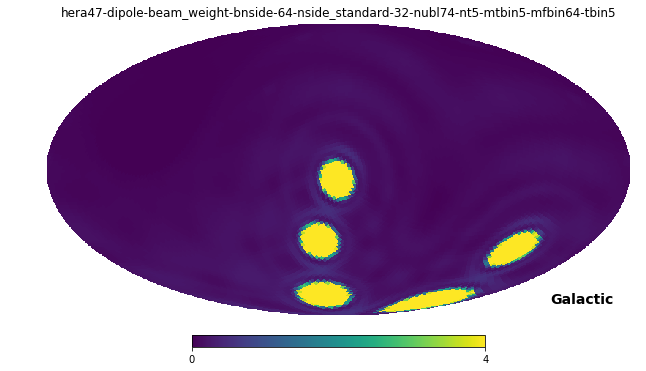

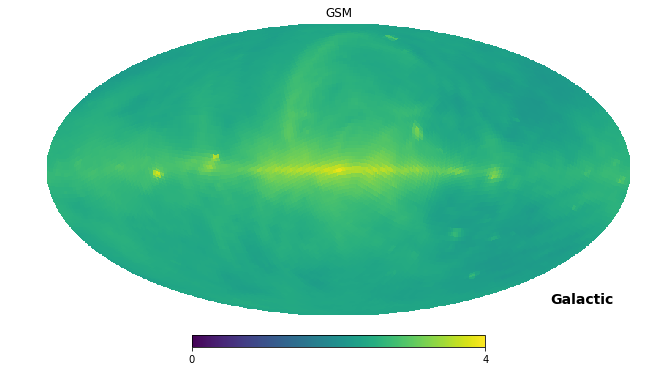

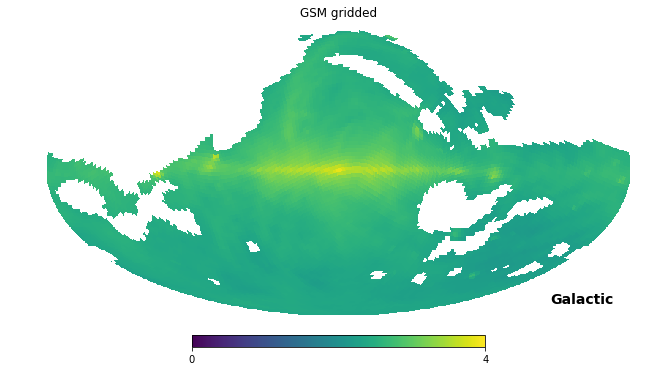

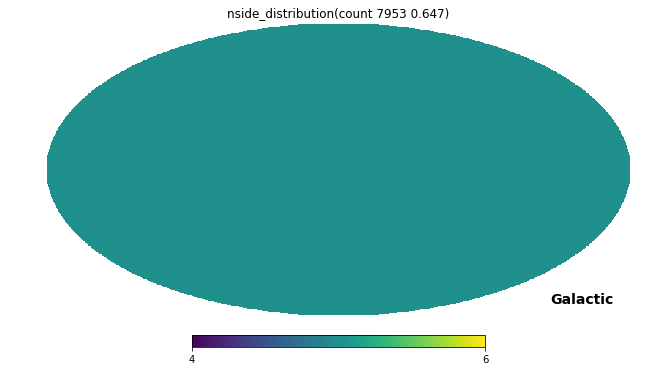

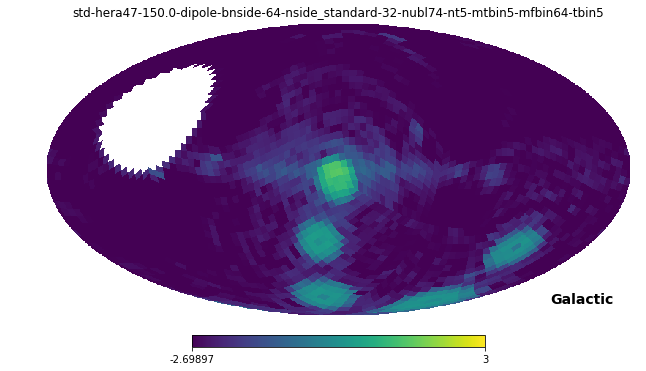

In [119]:
if plot_pixelization:
	##################################################################
	####################################sanity check########################
	###############################################################
	# npix = 0
	# for i in nside_distribution:
	# npix += i**2/nside_standard**2
	# print npix, len(thetas)
	plotcoord = 'CG'
	stds = np.std((equatorial_GSM_standard * beam_weight).reshape(12 * nside_standard ** 2 / 4, 4), axis=1)
	
	##################################################################
	####################################plotting########################
	###############################################################
	with warnings.catch_warnings():
		warnings.filterwarnings("ignore", category=RuntimeWarning)
		# plt.clf()
		plt.figure(50)
		hpv.mollview(beam_weight, min=0, max=4, coord=plotcoord, title='%s-dipole-beam_weight-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s' % (INSTRUMENT, bnside, nside_standard, nUBL_used, nt_used,  mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'), nest=True)
		plt.savefig(script_dir + '/../Output/%s-%sMHz-dipole-beam_weight-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.pdf' % (INSTRUMENT, freq, bnside, nside_standard, nUBL_used, nt_used,  mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
		hpv.mollview(np.log10(equatorial_GSM_standard), min=0, max=4, coord=plotcoord, title='GSM', nest=True)
		plt.savefig(script_dir + '/../Output/GSM-3C-for-%s-%sMHz-bnside-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.pdf' % (INSTRUMENT, freq, bnside, nUBL_used, nt_used,  mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
		hpv.mollview(np.log10(sol2map(fake_solution)[:len(equatorial_GSM_standard)]), min=0, max=4, coord=plotcoord,
					 title='GSM gridded', nest=True)
		plt.savefig(script_dir + '/../Output/maskedfsol_GSM-3C-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.pdf' % (INSTRUMENT, freq, bnside, nside_standard, nUBL_used, nt_used,  mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
		hpv.mollview(np.log2(nside_distribution), min=np.log2(nside_start), max=np.log2(nside_standard),
					 coord=plotcoord,
					 title='nside_distribution(count %i %.3f)' % (len(thetas), float(len(thetas)) / (12 * nside_standard ** 2)), nest=True)
		plt.savefig(script_dir + '/../Output/nside_distribution-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.pdf' % (INSTRUMENT, freq, bnside, nside_standard, nUBL_used, nt_used,  mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
		hpv.mollview(np.log10(stds / abs_thresh), min=np.log10(thresh) - 3, max=3, coord=plotcoord, title='std-%s-%s-dipole-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s'%(INSTRUMENT, freq, bnside, nside_standard, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'),
					 nest=True)
		plt.savefig(script_dir + '/../Output/stds-beam_weight_GSM-%s-%s-dipole-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.pdf' % (INSTRUMENT, freq, bnside, nside_standard, nUBL_used, nt_used,  mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
		plt.show(block=False)
# plt.gcf().clear()

sys.stdout.flush()

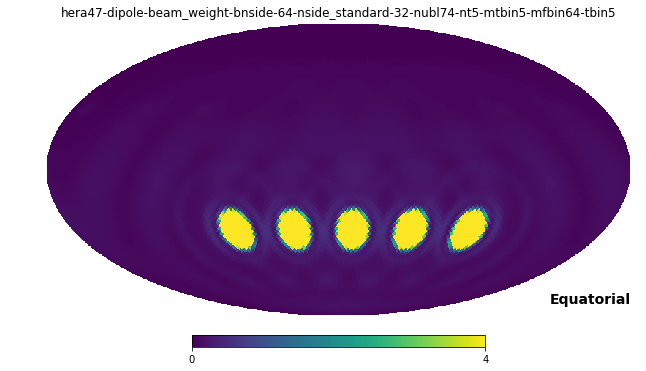

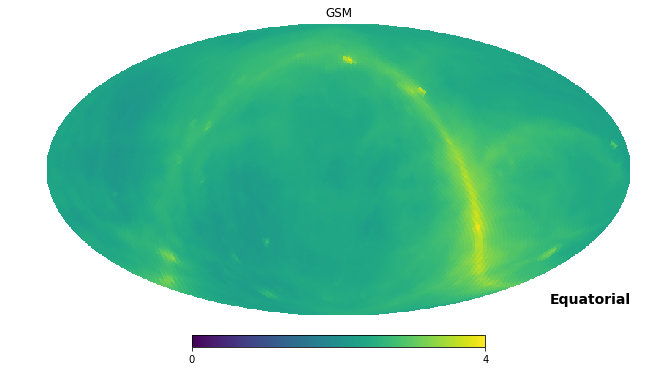

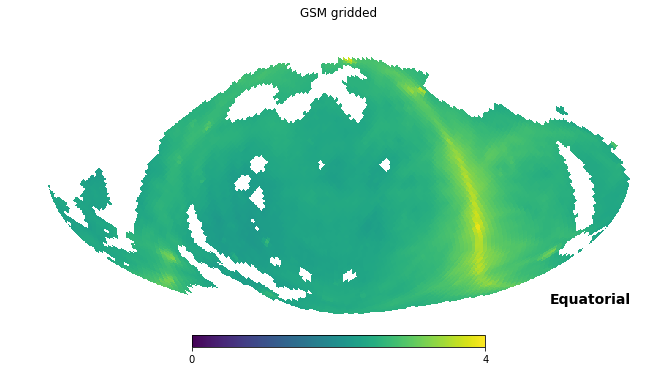

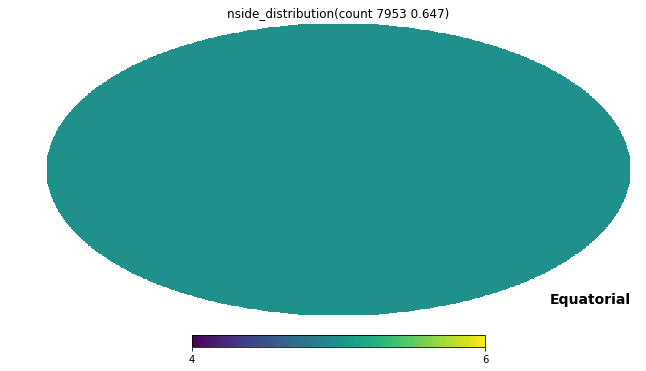

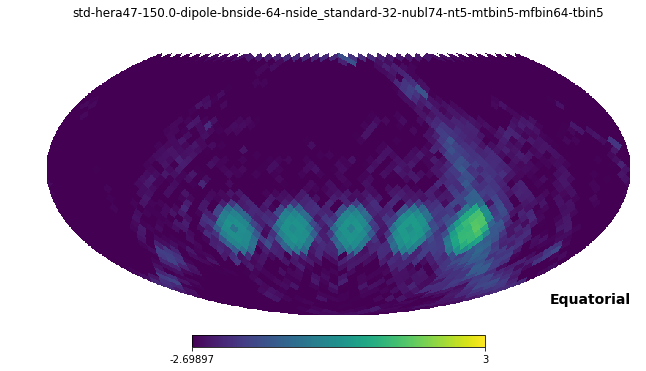

In [120]:
try:
	if plot_pixelization:
		##################################################################
		####################################sanity check########################
		###############################################################
		# npix = 0
		# for i in nside_distribution:
		# npix += i**2/nside_standard**2
		# print npix, len(thetas)
		plotcoord = 'C'
		stds = np.std((equatorial_GSM_standard * beam_weight).reshape(12 * nside_standard ** 2 / 4, 4), axis=1)
		
		##################################################################
		####################################plotting########################
		###############################################################
		with warnings.catch_warnings():
			warnings.filterwarnings("ignore", category=RuntimeWarning)
			# plt.clf()
			plt.figure(50)
			hpv.mollview(beam_weight, min=0, max=4, coord=plotcoord, title='%s-dipole-beam_weight-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s' % (INSTRUMENT, bnside, nside_standard, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'), nest=True)
			plt.savefig(script_dir + '/../Output/%s-%sMHz-dipole-beam_weight-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.pdf' % (INSTRUMENT, freq, bnside, nside_standard, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
			hpv.mollview(np.log10(equatorial_GSM_standard), min=0, max=4, coord=plotcoord, title='GSM', nest=True)
			plt.savefig(script_dir + '/../Output/GSM-3C-for-%s-%sMHz-bnside-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.pdf' % (INSTRUMENT, freq, bnside, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
			hpv.mollview(np.log10(sol2map(fake_solution)[:len(equatorial_GSM_standard)]), min=0, max=4, coord=plotcoord,
			             title='GSM gridded', nest=True)
			plt.savefig(script_dir + '/../Output/maskedfsol_GSM-3C-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.pdf' % (INSTRUMENT, freq, bnside, nside_standard, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
			hpv.mollview(np.log2(nside_distribution), min=np.log2(nside_start), max=np.log2(nside_standard),
			             coord=plotcoord,
			             title='nside_distribution(count %i %.3f)' % (len(thetas), float(len(thetas)) / (12 * nside_standard ** 2)), nest=True)
			plt.savefig(script_dir + '/../Output/nside_distribution-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.pdf' % (INSTRUMENT, freq, bnside, nside_standard, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
			hpv.mollview(np.log10(stds / abs_thresh), min=np.log10(thresh) - 3, max=3, coord=plotcoord, title='std-%s-%s-dipole-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s' % (INSTRUMENT, freq, bnside, nside_standard, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'),
			             nest=True)
			plt.savefig(script_dir + '/../Output/stds-beam_weight_GSM-%s-%s-dipole-bnside-%s-nside_standard-%s-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.pdf' % (INSTRUMENT, freq, bnside, nside_standard, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
			plt.show(block=False)
	# plt.gcf().clear()
except:
	print('Error when Plotting GSM Maps.')
    

In [121]:
##################################################################
####################compute dynamic A matrix########################
###############################################################
A_tag = 'A_dI'
A_filename = A_tag + '_u%i_t%i_mtbin%s-mfbin%s-tbin%s_p%i_n%i_%i_b%i_%.3f_v%.1f' % (nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', valid_npix, nside_start, nside_standard, bnside, thresh, A_version)
A_path = datadir + tag + A_filename
AtNiA_tag = 'AtNiA_N%s' % vartag
if not fit_for_additive:
	AtNiA_tag += "_noadd"
elif crosstalk_type == 'autocorr':
	AtNiA_tag += "_autocorr"
if pre_ampcal:
	AtNiA_tag += "_ampcal"
AtNiA_filename = AtNiA_tag + A_filename
AtNiA_path = datadir + tag + AtNiA_filename
if os.path.isfile(AtNiA_path) and AtNiA_only and not force_recompute:
	sys.exit(0)


def get_A(additive_A=None):
	if os.path.isfile(A_path) and not force_recompute:
		print "Reading A matrix from %s" % A_path
		sys.stdout.flush()
		A = np.fromfile(A_path, dtype='complex128').reshape((nUBL_used, 2, nt_used, valid_npix + 4 * nUBL_used))
	else:
		
		print "Computing A matrix..."
		sys.stdout.flush()
		A = np.empty((nUBL_used, 2, nt_used, valid_npix + 4 * nUBL_used), dtype='complex128')
		timer = time.time()
		for n in range(valid_npix):
			ra = phis[n]
			dec = PI / 2 - thetas[n]
			print "\r%f%% completed, %f minutes left" % (
				100. * float(n) / (valid_npix), float(valid_npix - n) / (n + 1) * (float(time.time() - timer) / 60.)),
			sys.stdout.flush()
			
			A[:, 0, :, n] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ_x, tlist=lsts) / 2  # xx and yy are each half of I
			A[:, -1, :, n] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ_y, tlist=lsts) / 2
		
		print "%f minutes used" % (float(time.time() - timer) / 60.)
		sys.stdout.flush()
		A.tofile(A_path)
	
	# #put in autocorr regardless of whats saved on disk
	# for i in range(nUBL_used):
	#     for p in range(2):
	#         A[i, p, :, valid_npix + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p]
	#         A[i, p, :, valid_npix + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p]
	
	A.shape = (nUBL_used * 2 * nt_used, A.shape[-1])
	if not fit_for_additive:
		A = A[:, :valid_npix]
	else:
		A[:, valid_npix:] = additive_A[:, 1:]
	# Merge A
	try:
		return np.concatenate((np.real(A), np.imag(A))).astype('complex128')
	except MemoryError:
		print "Not enough memory, concatenating A on disk ", A_path + 'tmpre', A_path + 'tmpim',
		sys.stdout.flush()
		Ashape = list(A.shape)
		Ashape[0] = Ashape[0] * 2
		np.real(A).tofile(A_path + 'tmpre')
		np.imag(A).tofile(A_path + 'tmpim')
		del (A)
		os.system("cat %s >> %s" % (A_path + 'tmpim', A_path + 'tmpre'))
		
		os.system("rm %s" % (A_path + 'tmpim'))
		A = np.fromfile(A_path + 'tmpre', dtype='complex128').reshape(Ashape)
		os.system("rm %s" % (A_path + 'tmpre'))
		print "done."
		sys.stdout.flush()
		return A.astype('complex128')


if not fit_for_additive:
	A = get_A()
else:
	A = get_A(additive_A)

Ashape0, Ashape1 = A.shape

# for ipix in hpf.ang2pix(nside_standard, thetas, phis, nest=True):
#     if

print "Memory usage: %fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

print "Memory usage: %fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

sys.stdout.flush()


def get_vis_normalization(data, clean_sim_data):
	a = np.linalg.norm(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]), axis=0).flatten()
	b = np.linalg.norm(clean_sim_data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]), axis=0).flatten()
	return a.dot(b) / b.dot(b)


Computing A matrix...
99.987426% completed, 0.000040 minutes left                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [122]:
tlist

array([15.01222222, 17.62805556, 20.24388889, 22.85972222, 25.47555556])

In [123]:
Integration_Time
np.sum(Ni**-1)**.5

(881.0431793618925+0j)

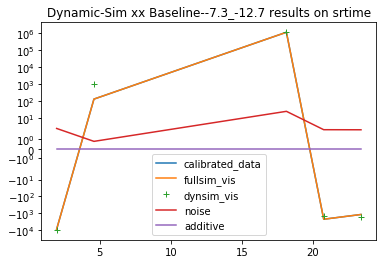

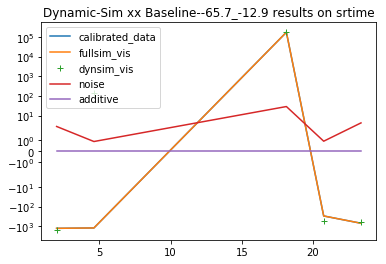

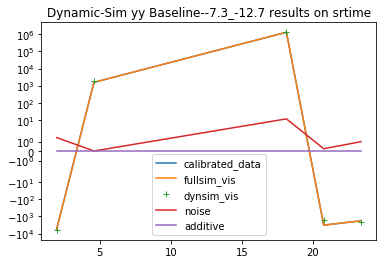

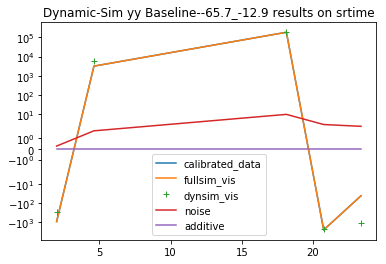

total deviation between dynamic and full sim compared to sim:  0.0027596721903942857
total deviation between dynamic and full sim compared to data noise:  (58.46020004930776+0j)


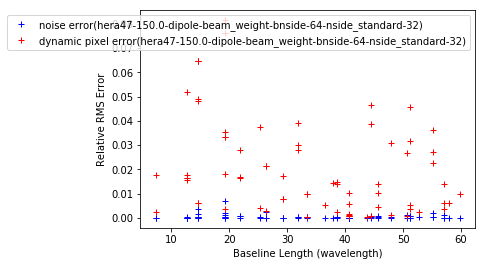

Normalization from visibilities 1.0


In [124]:
##############
# simulate visibilities according to the pixelized A matrix
##############
clean_sim_data = A.dot(fake_solution.astype(A.dtype))

try:
	if plot_data_error:
		cdata = get_complex_data(data)
		cdynamicmodel = get_complex_data(clean_sim_data)
		cNi = get_complex_data(Ni)
		if pre_calibrate:
			cadd = get_complex_data(additive_term)
		
		fun = np.imag
		srt = sorted((lsts - lst_offset) % 24. + lst_offset)
		asrt = np.argsort((lsts - lst_offset) % 24. + lst_offset)
		pncol = min(int(60. / (srt[-1] - srt[0])), 12) if nt_used > 1 else (len(ubl_sort['x'])/2)
		us = ubl_sort['x'][::len(ubl_sort['x']) / pncol] if len(ubl_sort['x']) / pncol >= 1 else ubl_sort['x']
		# plt.clf()
		#	plt.figure(60)
		#	for p in range(2):
		#		for nu, u in enumerate(us):
		#
		#			plt.subplot(2, len(us), len(us) * p + nu + 1)
		#			plt.plot(srt, fun(cdata[u, p][asrt]))
		#			plt.plot(srt, fun(fullsim_vis[u, p][asrt]))
		#			plt.plot(srt, fun(cdynamicmodel[u, p][asrt]))
		#			plt.plot(srt, fun(cNi[u, p][asrt])**-.5)
		#			if pre_calibrate:
		#				plt.plot(srt, fun(cadd[u, p][asrt]))
		#			data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), 5 * np.max(np.abs(fun(cNi[u, p])))])
		#			plt.title("%.1f,%.1f"%(used_common_ubls[u, 0], used_common_ubls[u, 1]))
		#			plt.ylim([-1.05*data_range, 1.05*data_range])
		#
		#	print "total deviation between dynamic and full sim compared to sim", la.norm(fullsim_vis - cdynamicmodel) / la.norm(fullsim_vis)
		#	print "total deviation between dynamic and full sim compared to data noise", la.norm(fullsim_vis - cdynamicmodel) / np.sum(Ni**-1)**.5
		#	plt.savefig(script_dir + '/../Output/data_error_dynamic-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
		#	plt.show(block=False)
		
		figure_D = {}
		for p in range(2):
			for nu, u in enumerate(us):
				plt.figure(6000 + 100 * p + nu)
				plt.clf()
				# plt.subplot(2, len(us), len(us) * p + nu + 1)
				figure_D[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
				figure_D[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
				figure_D[3], = plt.plot(srt, fun(cdynamicmodel[u, p][asrt]), '+', label='dynsim_vis')
				figure_D[4], = plt.plot(srt, fun(cNi[u, p][asrt]) ** -.5, label='Ni')
				if pre_calibrate:
					figure_D[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
					data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(np.abs(fun(cdynamicmodel[u, p]))), np.max(fun(cadd[u, p]))])  # 5 * np.max(np.abs(fun(cNi[u, p])))
				else:
					data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(np.abs(fun(cdynamicmodel[u, p])))])  # 5 * np.max(np.abs(fun(cNi[u, p])))
				plt.title("Dynamic-Sim %s Baseline-%.1f_%.1f results on srtime" % (['xx', 'yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
				plt.yscale('symlog')
				# plt.ylim([-1.05 * data_range, 1.05 * data_range])
				if pre_calibrate:
					plt.legend(handles=[figure_D[1], figure_D[2], figure_D[3], figure_D[4], figure_D[5]], labels=['calibrated_data', 'fullsim_vis', 'dynsim_vis', 'noise', 'additive'], loc=0)
				else:
					plt.legend(handles=[figure_D[1], figure_D[2], figure_D[3], figure_D[4]], labels=['calibrated_data', 'fullsim_vis', 'dynsim_vis', 'noise'], loc=0)
				plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Dynamic_Vis-%s-%.2fMHz-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard)) #-nubl%s-nt%s-tbin%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, precal_time_bin, bnside, nside_standard))
				plt.show(block=False)
		# plt.clf()
		# plt.gcf().clear()
		print "total deviation between dynamic and full sim compared to sim: ", la.norm(fullsim_vis - cdynamicmodel) / la.norm(fullsim_vis)
		print "total deviation between dynamic and full sim compared to data noise: ", la.norm(fullsim_vis - cdynamicmodel) / np.sum(Ni ** -1) ** .5
		
		plt.figure(70)
		try:
			fullsim_vis2 = 4 * np.fromfile(datadir + tag + '_p2_u%i_t%i_nside%i_bnside%i.simvis' % (nUBL_used + 1, nt_used, nside_standard / 2, bnside), dtype='complex128').reshape((2, nUBL_used + 1, nt_used))[:, :-1].transpose((1, 0, 2))
			plt.plot(la.norm(used_common_ubls, axis=-1) * freq / C, la.norm(fullsim_vis - fullsim_vis2, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'g+', label='nside error(%s-dipole-beam_weight-bnside-%s-nside_standard-%s)' % (INSTRUMENT, bnside, nside_standard))
			plt.savefig(script_dir + '/../Output/nside_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, bnside, nside_standard))
		except:
			try:
				fullsim_vis2 = .25 * np.fromfile(datadir + tag + '_p2_u%i_t%i_nside%i_bnside%i.simvis' % (nUBL_used + 1, nt_used, nside_standard * 2, bnside), dtype='complex128').reshape((2, nUBL_used + 1, nt_used))[:, :-1].transpose((1, 0, 2))
				plt.plot(la.norm(used_common_ubls, axis=-1) * freq / C, la.norm(fullsim_vis - fullsim_vis2, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'g+', label='nside error(%s-dipole-beam_weight-bnside-%s-nside_standard-%s)' % (INSTRUMENT, bnside, nside_standard))
				plt.savefig(script_dir + '/../Output/nside_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, bnside, nside_standard))
			except:
				pass
		# plt.clf()
		plt.plot(la.norm(used_common_ubls, axis=-1) * freq / C, np.sum(2. / np.real(get_complex_data(Ni)), axis=-1)[:, 0] ** .5 / la.norm(fullsim_vis, axis=-1)[:, 0], 'b+', label='noise error(%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s)' % (INSTRUMENT, freq, bnside, nside_standard))
		#	plt.legend()
		#	plt.xlabel('Baseline Length (wavelength)')
		#	plt.ylabel('Relative RMS Error')
		#plt.savefig(script_dir + '/../Output/noise_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s-%.2fMHz-nubl%s-nt%s-tbin%s.png' % (INSTRUMENT, bnside, nside_standard, freq, nUBL_used, nt_used, precal_time_bin))
		#	plt.show(block=False)
		#	plt.gcf().clear()
		# plt.clf()
		plt.plot(la.norm(used_common_ubls, axis=-1) * freq / C, la.norm(fullsim_vis - cdynamicmodel, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'r+', label='dynamic pixel error(%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s)' % (INSTRUMENT, freq, bnside, nside_standard))
		plt.legend(loc=0)
		plt.xlabel('Baseline Length (wavelength)')
		plt.ylabel('Relative RMS Error')
		plt.savefig(script_dir + '/../Output/noise_and_dynamic_pixel_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s-%.2fMHz-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s.png' % (INSTRUMENT, bnside, nside_standard, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none'))
		plt.show(block=False)
		# plt.gcf().clear()
except:
	print ('Error when Plotting Comparison of Full and Dyna Simulation Results.')

vis_normalization = get_vis_normalization(data, stitch_complex_data(fullsim_vis))
print "Normalization from visibilities", vis_normalization

Del=True
if Del:
	try:
		del(cdata)
		del(cNi)
		del(cdynamicmodel)
	except:
		pass

sys.stdout.flush()



In [125]:
##renormalize the model
fake_solution *= vis_normalization # GSM Masked and being Normalized (abs calibration), Clean
clean_sim_data *= vis_normalization # Dynamic Simulated, Clean, being Normalized (abs calibration)
fullsim_vis *= vis_normalization # Full Simulated, Clean, being Normalized (abs calibration)
sim_data = stitch_complex_data(fullsim_vis) + np.random.randn(len(data)) / Ni ** .5 # Full Simulated, being Normalized (abs calibration), Noise
# "data" is Calibrated Full Simulated Visibilities

#add additive term
if fit_for_additive:
	sim_data.shape = (2, nUBL_used, 2, nt_used)
	sim_additive = np.random.randn(2, nUBL_used, 2) * np.median(np.abs(data)) / 2.
	sim_data = sim_data + np.array([np.outer(sim_additive[..., p], autocorr_vis_normalized[p]).reshape((2, nUBL_used, nt_used)) for p in range(2)]).transpose((1, 2, 0, 3))#sim_additive[..., None]
	sim_data = sim_data.flatten()


In [126]:
# compute AtNi.y
AtNi_data = np.transpose(A).dot((data * Ni).astype(A.dtype))
AtNi_sim_data = np.transpose(A).dot((sim_data * Ni).astype(A.dtype))
AtNi_clean_sim_data = np.transpose(A).dot((clean_sim_data * Ni).astype(A.dtype))


In [127]:
# compute S
print "computing S...",
sys.stdout.flush()
timer = time.time()

#diagonal of S consists of S_diag_I and S-diag_add
if S_type == 'none':
	S_diag = np.ones(Ashape1) * np.max(equatorial_GSM_standard)**2 * 1.e12
else:
	if 'lowI' in S_type:
		I_supress = 25.
	elif 'minI' in S_type:
		I_supress = 250.
	elif 'min2I' in S_type:
		I_supress = 2500
	elif 'min3I' in S_type:
		I_supress = 2.5*1.e4
	elif 'min4I' in S_type:
		I_supress = 2.5*1.e5
	elif 'min5I' in S_type:
		I_supress = 2.5*1.e6
	elif 'min6I' in S_type:
		I_supress = 2.5*1.e7
	elif 'min7I' in S_type:
		I_supress = 2.5*1.e8
	elif 'min8I' in S_type:
		I_supress = 2.5*1.e9
	elif 'min9I' in S_type:
		I_supress = 2.5*1.e10
	elif 'min10I' in S_type:
		I_supress = 2.5*1.e11
	elif 'min11I' in S_type:
		I_supress = 2.5*1.e12
	elif 'min12I' in S_type:
		I_supress = 2.5*1.e13
	elif 'min13I' in S_type:
		I_supress = 2.5*1.e14
	elif 'min14I' in S_type:
		I_supress = 2.5*1.e15
	elif 'min15I' in S_type:
		I_supress = 2.5*1.e16
	elif 'min16I' in S_type:
		I_supress = 2.5*1.e17
	elif 'min17I' in S_type:
		I_supress = 2.5*1.e18
	elif 'min18I' in S_type:
		I_supress = 2.5*1.e19
	elif 'min19I' in S_type:
		I_supress = 2.5 * 1.e20
	elif 'min20I' in S_type:
		I_supress = 2.5 * 1.e21
	elif 'min21I' in S_type:
		I_supress = 2.5 * 1.e22
	elif 'min22I' in S_type:
		I_supress = 2.5 * 1.e23
	elif 'maxI' in S_type:
		I_supress = 2.5*1.e-1
	elif 'ma2I' in S_type:
		I_supress = 2.5*1.e-2
	elif 'max3I' in S_type:
		I_supress = 2.5*1.e-3
	elif 'max4I' in S_type:
		I_supress = 2.5*1.e-4
	elif 'max5I' in S_type:
		I_supress = 2.5*1.e-5
	elif 'max6I' in S_type:
		I_supress = 2.5*1.e-6
	elif 'max7I' in S_type:
		I_supress = 2.5*1.e-7
	elif 'max8I' in S_type:
		I_supress = 2.5*1.e-8
	elif 'max9I' in S_type:
		I_supress = 2.5*1.e-9
	else:
		I_supress = 1.
		
	if 'Iuniform' in S_type:
		S_diag_I = (np.median(equatorial_GSM_standard) * sizes)**2 / I_supress
	else:
		S_diag_I = fake_solution_map ** 2 / I_supress  # np.array([[1+pol_frac,0,0,1-pol_frac],[0,pol_frac,pol_frac,0],[0,pol_frac,pol_frac,0],[1-pol_frac,0,0,1+pol_frac]]) / 4 * (2*sim_x_clean[i])**2

	data_max = np.transpose(np.percentile(np.abs(data.reshape((2, nUBL_used, 2, nt_used))), 95, axis=-1), (1, 2, 0)).flatten()
	if 'min2add' in S_type:
		add_supress = 1000000.
	elif 'minadd' in S_type:
		add_supress = 10000.
	elif 'lowadd' in S_type:
		add_supress = 100.
	else:
		add_supress = 1

	if 'adduniform' in S_type:
		S_diag_add = np.ones(nUBL_used * 4) * np.median(data_max)**2 / add_supress
	else:
		S_diag_add = data_max**2 / add_supress

	if not fit_for_additive:
		S_diag = S_diag_I.astype('complex128')
	else:
		S_diag = np.concatenate((S_diag_I, S_diag_add)).astype('complex128')
	print "Done."
	print "%f minutes used" % (float(time.time() - timer) / 60.)
	sys.stdout.flush()


computing S... Done.
0.000032 minutes used


In [128]:
# compute (AtNiA+Si)i
precision = 'complex128'
AtNiAi_tag = 'AtNiASii' + "_u%i_t%i_mtbin%s-mfbin%s-tbin%s_p%i_n%i_%i_b%i"%(nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', valid_npix, nside_start, nside_standard, bnside)
if not fit_for_additive:
	AtNiAi_version = 0.3
elif crosstalk_type == 'autocorr':
	AtNiAi_version = 0.2
else:
	AtNiAi_version = 0.1
if pre_ampcal:
	AtNiAi_version += 1.
# rcond_list = 10.**np.arange(-9., -2., 1.)

AtNiAi_candidate_files = glob.glob(datadir + tag + AtNiAi_tag + '_S%s_RE*_N%s_v%.1f' % (S_type, vartag, AtNiAi_version) + A_filename)
if len(AtNiAi_candidate_files) > 0 and not force_recompute_AtNiAi and not force_recompute and not force_recompute_S and not AtNiA_only:
	rcond = 10 ** min([float(fn.split('_RE')[1].split('_N')[0]) for fn in AtNiAi_candidate_files])
	
	AtNiAi_filename = AtNiAi_tag + '_S%s_RE%.1f_N%s_v%.1f' % (S_type, np.log10(rcond), vartag, AtNiAi_version) + A_filename
	AtNiAi_path = datadir + tag + AtNiAi_filename
	
	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)
else:
	if os.path.isfile(AtNiA_path) and not force_recompute:
		print "Reading AtNiA...",
		sys.stdout.flush()
		AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))
	else:
		print "Allocating AtNiA..."
		sys.stdout.flush()
		timer = time.time()
		AtNiA = np.zeros((A.shape[1], A.shape[1]), dtype=precision)
		print "Computing AtNiA...", datetime.datetime.now()
		sys.stdout.flush()
		ATNIA(A, Ni, AtNiA)
		print "%f minutes used" % (float(time.time() - timer) / 60.)
		sys.stdout.flush()
		AtNiA.tofile(AtNiA_path)
	if AtNiA_only:
		sys.exit(0)
	del (A)
	AtNiA_diag = np.diagonal(AtNiA)
	print "Computing Regularized AtNiAi, %s, expected time %f min" % (datetime.datetime.now(), 88. * (len(S_diag) / 4.6e4) ** 3.),
	sys.stdout.flush()
	timer = time.time()
	# if la.norm(S) != la.norm(np.diagonal(S)):
	#     raise Exception("Non-diagonal S not supported yet")
	
	for rcond in rcond_list:
		# add Si on top of AtNiA without renaming AtNiA to save memory
		maxAtNiA = np.max(AtNiA)
		AtNiA.shape = (len(AtNiA) ** 2)
		if Add_S_diag:
			AtNiA[::len(S_diag) + 1] += 1. / S_diag
		
		print 'trying', rcond,
		sys.stdout.flush()
		try:
			AtNiAi_filename = AtNiAi_tag + '_S%s_RE%.1f_N%s_v%.1f' % (S_type, np.log10(rcond), vartag, AtNiAi_version) + A_filename
			AtNiAi_path = datadir + tag + AtNiAi_filename
			if Add_Rcond:
				AtNiA[::len(S_diag) + 1] += maxAtNiA * rcond
			AtNiA.shape = (Ashape1, Ashape1)
			AtNiAi = sv.InverseCholeskyMatrix(AtNiA).astype(precision)
			del (AtNiA)
			AtNiAi.tofile(AtNiAi_path, overwrite=True)
			print "%f minutes used" % (float(time.time() - timer) / 60.)
			print "regularization stength", (maxAtNiA * rcond) ** -.5, "median GSM ranges between", np.median(equatorial_GSM_standard) * min(sizes), np.median(equatorial_GSM_standard) * max(sizes)
			break
		except:
			AtNiA[::len(S_diag) + 1] -= maxAtNiA * rcond
			continue

sys.stdout.flush()

Allocating AtNiA...
Computing AtNiA... 2018-03-22 18:42:41.118970
Estimated time for A 1480 by 8249 1.30920505924 minutes 0/20: 0.00680mins 1/20: 0.00621mins 2/20: 0.00608mins 3/20: 0.00622mins 4/20: 0.00653mins 5/20: 0.00601mins 6/20: 0.00603mins 7/20: 0.00596mins 8/20: 0.00608mins 9/20: 0.00653mins 10/20: 0.00644mins 11/20: 0.00677mins 12/20: 0.00635mins 13/20: 0.00595mins 14/20: 0.00577mins 15/20: 0.00601mins 16/20: 0.00629mins 17/20: 0.00593mins 18/20: 0.00609mins 19/20: 0.00630mins 0.125963 minutes used
Computing Regularized AtNiAi, 2018-03-22 18:42:49.457164, expected time 0.507473 min trying 1e-20 trying 1e-19 trying 1e-18 trying 1e-17 0.900768 minutes used
regularization stength (20880.193405618884+0j) median GSM ranges between 284.4070539235776 284.4070539235776


Applying Regularized AtNiAi... Memory usage: 4855918.000MB
Reading A matrix from /Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/../../../HERA_MapMaking_VisibilitySimulation/scripts/../Output/hera47-150.000000-ampcal-A_dI_u74_t5_mtbin5-mfbin64-tbin5_p7953_n32_32_b64_2.000_v1.0


Casting complex values to real discards the imaginary part


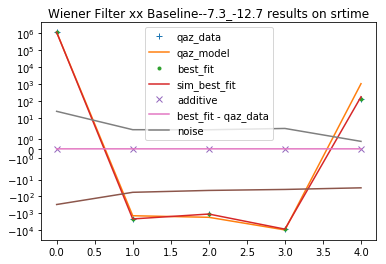

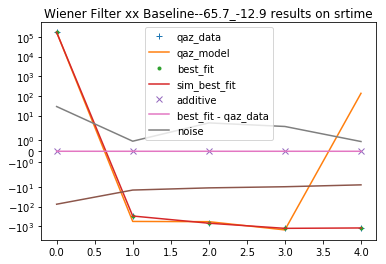

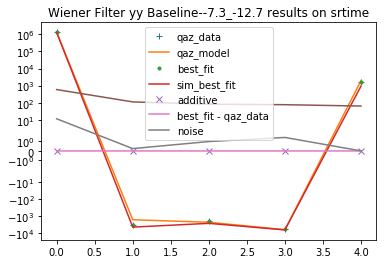

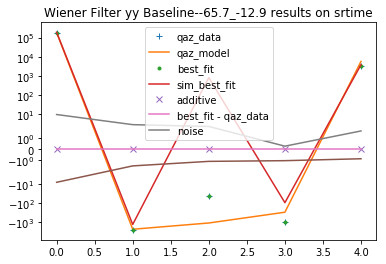

In [129]:
#####apply wiener filter##############
print "Applying Regularized AtNiAi...",
sys.stdout.flush()
w_solution = AtNiAi.dotv(AtNi_data)
w_GSM = AtNiAi.dotv(AtNi_clean_sim_data)
w_sim_sol = AtNiAi.dotv(AtNi_sim_data)
print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

del (AtNiAi)

if not fit_for_additive:
	A = get_A()
else:
	A = get_A(additive_A)

best_fit = A.dot(w_solution.astype(A.dtype))  # Reversely-Calculated-masked-GSM Dynamically simulated Visibilities.
best_fit_no_additive = A[..., :valid_npix].dot(w_solution[:valid_npix].astype(A.dtype))

sim_best_fit = A.dot(w_sim_sol.astype(A.dtype))
sim_best_fit_no_additive = A[..., :valid_npix].dot(w_sim_sol[:valid_npix].astype(A.dtype))

try:
	if plot_data_error:
		qaz_model = (clean_sim_data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][
			1])  # Dynamic Simulated, Clean, being Normalized    # * vis_normalization
		qaz_data = np.copy(data).reshape(2, data_shape['xx'][0], 2,
										 data_shape['xx'][1])  # Full Simulated, Calibrated, reference for normalization
		if pre_calibrate:
			qaz_add = np.copy(additive_term).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
		pncol = min(int(60. / (srt[-1] - srt[0])), 12) if nt_used > 1 else (len(ubl_sort['x'])/2)
		us = ubl_sort['x'][::len(ubl_sort['x']) / pncol] if len(ubl_sort['x']) / pncol >= 1 else ubl_sort[
			'x']  # [::max(1, len(ubl_sort['x'])/70)]
		best_fit.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
		best_fit_no_additive.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
		sim_best_fit.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
		ri = 1
		
		figure_W = {}
		for p in range(2):
			
			for nu, u in enumerate(us):
				plt.figure(8000 + 10 * p + nu)
				# plt.subplot(6, (len(us) + 5) / 6, nu + 1)
				# plt.errorbar(range(nt_used), qaz_data[ri, u, p], yerr=Ni.reshape((2, nUBL_used, 2, nt_used))[ri, u, p]**-.5)
				figure_W[1], = plt.plot(qaz_data[ri, u, p], '+')
				figure_W[2], = plt.plot(qaz_model[ri, u, p], '-')
				figure_W[3], = plt.plot(best_fit[ri, u, p], '.')
				figure_W[4], = plt.plot(sim_best_fit[ri, u, p])
				if pre_calibrate:
					figure_W[5], = plt.plot(qaz_add[ri, u, p], 'x')
				if fit_for_additive:
					figure_W[6], = plt.plot(autocorr_vis_normalized[p] * sol2additive(w_solution)[p, u, ri])
				figure_W[7], = plt.plot(best_fit[ri, u, p] - qaz_data[ri, u, p])
				figure_W[8], = plt.plot(Ni.reshape((2, nUBL_used, 2, nt_used))[ri, u, p] ** -.5)
				if pre_calibrate:
					data_range = np.max([np.max(np.abs(qaz_data[ri, u, p])), np.max(np.abs(qaz_model[ri, u, p])),
										 np.max(np.abs(best_fit[ri, u, p])), np.max(np.abs(sim_best_fit[ri, u, p])), np.max(
							np.abs((best_fit[ri, u, p] - qaz_data[
								ri, u, p])))])  # np.max(np.abs(qaz_add[ri, u, p])), #, 5 * np.max(np.abs(fun(cNi[u, p])))
					plt.legend(
						handles=[figure_W[1], figure_W[2], figure_W[3], figure_W[4], figure_W[5], figure_W[7], figure_W[8]],
						labels=['qaz_data', 'qaz_model', 'best_fit', 'sim_best_fit', 'additive', 'best_fit - qaz_data',
								'noise'], loc=0)
				else:
					data_range = np.max([np.max(np.abs(qaz_data[ri, u, p])), np.max(np.abs(qaz_model[ri, u, p])),
										 np.max(np.abs(best_fit[ri, u, p])), np.max(np.abs(sim_best_fit[ri, u, p])), np.max(
							np.abs((best_fit[ri, u, p] - qaz_data[ri, u, p])))])  # , 5 * np.max(np.abs(fun(cNi[u, p])))
					plt.legend(handles=[figure_W[1], figure_W[2], figure_W[3], figure_W[4], figure_W[7], figure_W[8]],
							   labels=['qaz_data', 'qaz_model', 'best_fit', 'sim_best_fit', 'best_fit - qaz_data', 'noise'],
							   loc=0)
				plt.yscale('symlog')
				#plt.ylim([-1.05 * data_range, 1.05 * data_range])
				# plt.title("%.1f,%.1f,%.1e"%(used_common_ubls[u, 0], used_common_ubls[u, 1], la.norm(best_fit[ri, u, p] - qaz_data[ri, u, p])))
				plt.title("Wiener Filter %s Baseline-%.1f_%.1f results on srtime" % (
					['xx', 'yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
				plt.savefig(
					script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-WienerFilter_Vis-%s-%.2fMHz-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s.pdf' % (INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx', 'yy'][p], freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard))
				plt.show(block=False)
except:
	print('Error when Plotting Various Methods.')


sys.stdout.flush()

In [130]:
S_type
I_supress

1.0

In [131]:
def plot_IQU(solution, title, col, shape=(2,3), coord='C'):
	# Es=solution[np.array(final_index).tolist()].reshape((4, len(final_index)/4))
	# I = Es[0] + Es[3]
	# Q = Es[0] - Es[3]
	# U = Es[1] + Es[2]
	I = sol2map(solution)
	plotcoordtmp = coord
	hpv.mollview(np.log10(I), min=0, max=4, coord=plotcoordtmp, title=title, nest=True, sub=(shape[0], shape[1], col))
	#if col == shape[0] * shape[1]:
		#plt.show(block=False)

def plot_IQU_unlimit(solution, title, col, shape=(2,3), coord='C'):
	# Es=solution[np.array(final_index).tolist()].reshape((4, len(final_index)/4))
	# I = Es[0] + Es[3]
	# Q = Es[0] - Es[3]
	# U = Es[1] + Es[2]
	I = sol2map(solution)
	plotcoordtmp = coord
	hpv.mollview(np.log10(I), coord=plotcoordtmp, title=title, nest=True, sub=(shape[0], shape[1], col))
	#if col == shape[0] * shape[1]:
		#plt.show(block=False)


In [132]:
rescale_factor = np.max(np.abs(fake_solution))/ np.max(np.abs(w_solution))

In [133]:
%matplotlib inline

In [134]:
print('Number of Positive w_solution Pixels: %s'%len(w_solution[w_solution>=0]))
print('Number of Positive w_GSM Pixels: %s'%len(w_GSM[w_GSM>=0]))
print('Number of Positive w_sim Pixels: %s'%len(w_sim_sol[w_sim_sol>=0]))
print('Number of Positive GSM Pixels: %s'%len(fake_solution[fake_solution>=0]))

Number of Positive w_solution Pixels: 5085
Number of Positive w_GSM Pixels: 5119
Number of Positive w_sim Pixels: 4975
Number of Positive GSM Pixels: 8249


divide by zero encountered in log10


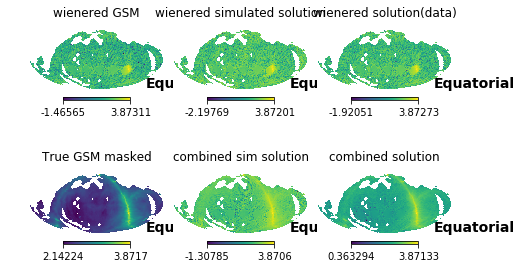

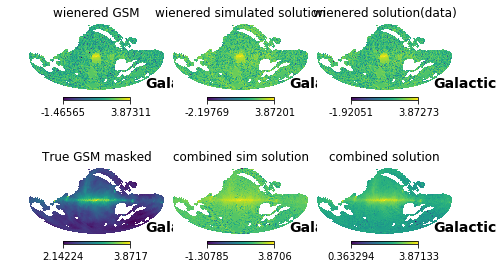

In [135]:
crd = 0
for coord in ['C', 'CG']:
	# plt.clf()
	plt.figure(900 + crd)
	crd += 10
	plot_IQU_unlimit(np.abs(w_GSM), 'wienered GSM', 1, coord=coord)  # (clean dynamic_data)
	plot_IQU_unlimit(np.abs(w_sim_sol), 'wienered simulated solution', 2, coord=coord)  # (~noise+data)
	plot_IQU_unlimit(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit(np.abs(w_sim_sol - w_GSM + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit(np.abs(w_solution - w_GSM + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s-rescale-none-unlimit-S-%s-recond-%s.png' % (coord, INSTRUMENT, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
# plt.gcf().clear()

divide by zero encountered in log10


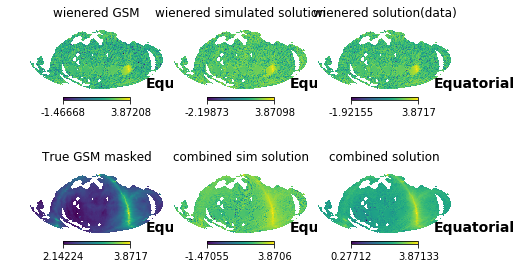

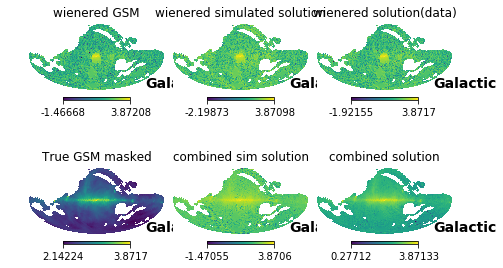

In [136]:
crd = 0
for coord in ['C', 'CG']:
	# plt.clf()
	plt.figure(9000000 + crd)
	crd += 10
	plot_IQU_unlimit(np.abs(w_GSM) * rescale_factor, 'wienered GSM', 1, coord=coord)  # (clean dynamic_data)
	plot_IQU_unlimit(np.abs(w_sim_sol) * rescale_factor, 'wienered simulated solution', 2, coord=coord)  # (~noise+data)
	plot_IQU_unlimit(np.abs(w_solution) * rescale_factor, 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit(np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit(np.abs((w_solution - w_GSM) * rescale_factor + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s-rescale-%s-unlimit-S-%s-recond-%s.png' % (coord, INSTRUMENT, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
# plt.gcf().clear()

divide by zero encountered in log10


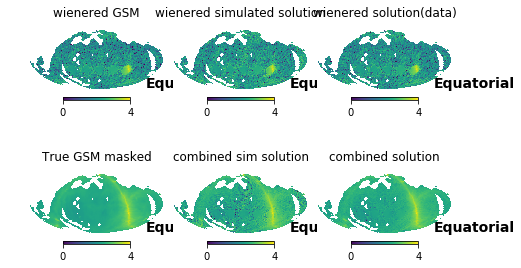

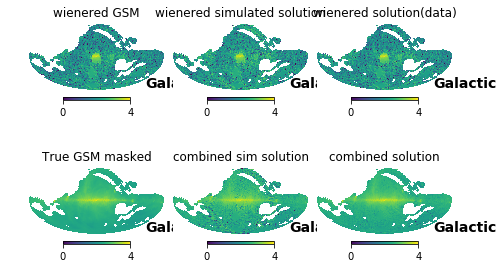

In [137]:
crd = 0
for coord in ['C', 'CG']:
	# plt.clf()
	plt.figure(9500000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM) * rescale_factor, 'wienered GSM', 1, coord=coord)  # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol) * rescale_factor, 'wienered simulated solution', 2, coord=coord)  # (~noise+data)
	plot_IQU(np.abs(w_solution) * rescale_factor, 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs((w_solution - w_GSM) * rescale_factor + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s-rescale-%s-limit-S-%s-recond-%s.png' % (coord, INSTRUMENT, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
# plt.gcf().clear()

Casting complex values to real discards the imaginary part
divide by zero encountered in log10


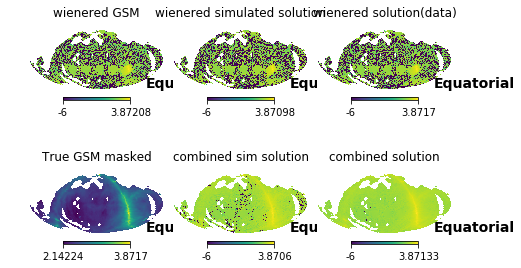

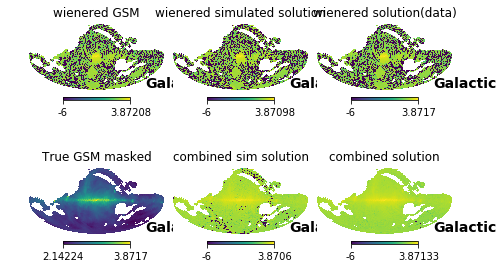

In [138]:
crd = 0
for coord in ['C', 'CG']:
	# plt.clf()
	plt.figure(950 + crd)
	crd += 10
	plot_IQU_unlimit((w_GSM + np.abs(w_GSM)) * 0.5 * rescale_factor + 1.e-6, 'wienered GSM', 1, coord=coord)  # (clean dynamic_data)
	plot_IQU_unlimit((w_sim_sol + np.abs(w_sim_sol)) * 0.5 * rescale_factor + 1.e-6, 'wienered simulated solution', 2, coord=coord)  # (~noise+data)
	plot_IQU_unlimit((w_solution + np.abs(w_solution)) * 0.5 * rescale_factor + 1.e-6, 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit((fake_solution + np.abs(fake_solution)) * 0.5, 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit((((w_sim_sol - w_GSM) * rescale_factor + fake_solution) + np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution)) * 0.5 + 1.e-6, 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit((((w_solution - w_GSM) * rescale_factor + fake_solution) + np.abs((w_solution - w_GSM) * rescale_factor + fake_solution)) * 0.5 + 1.e-6, 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s-rescale-%s-denegative-unlimit-S-%s-recond-%s.png' % (coord, INSTRUMENT, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
# plt.gcf().clear()

divide by zero encountered in log10


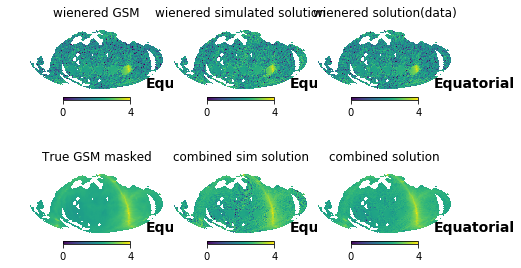

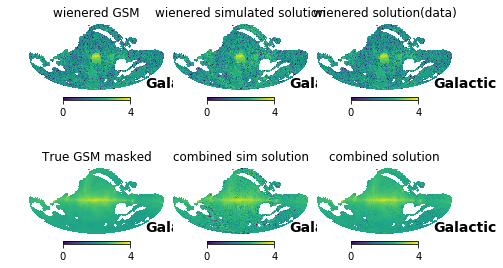

In [139]:
crd = 0
for coord in ['C', 'CG']:
	# plt.clf()
	plt.figure(90000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM), 'wienered GSM', 1, coord=coord)  # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol), 'wienered simulated solution', 2, coord=coord)  # (~noise+data)
	plot_IQU(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs(w_sim_sol - w_GSM + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs(w_solution - w_GSM + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s-rescale-none-limit-S-%s-recond-%s.png' % (coord, INSTRUMENT, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
# plt.gcf().clear()

divide by zero encountered in log10


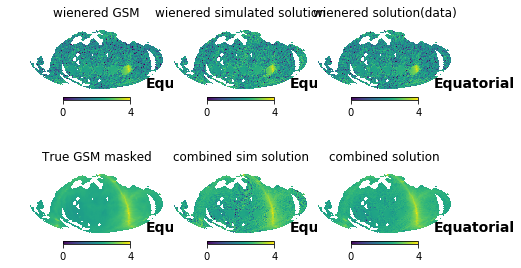

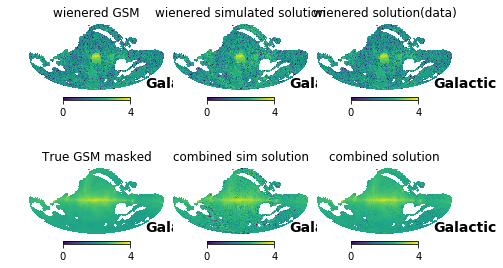

In [140]:
crd = 0
for coord in ['C', 'CG']:
	# plt.clf()
	plt.figure(9000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM / vis_normalization), 'wienered GSM', 1, coord=coord)  # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol / vis_normalization), 'wienered simulated solution', 2, coord=coord)  # (~noise+data)
	plot_IQU(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution / vis_normalization), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs((w_sim_sol - w_GSM + fake_solution) / vis_normalization), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs((w_solution - w_GSM + fake_solution) / vis_normalization), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener_renormalized-%s-%s-%sMHz-dipole-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s-rescale-none-limit-S-%s-recond-%s.png' % (coord, INSTRUMENT, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
# plt.gcf().clear()

chi^2 = 3.725e-06, data points 1480, pixels 7953
re/im chi2 2.678e-06, 1.047e-06
xx/yy chi2 2.041e-06, 1.683e-06


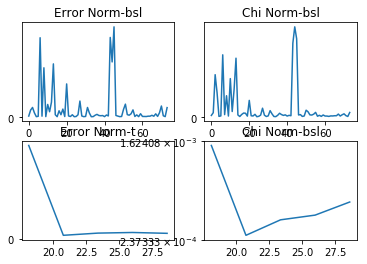

Additive_sol: [1.+0.j 1.+0.j]
Rescale_factor: 0.9976271832128384
('regularization stength', (20880.193405618884+0j), 'median GSM ranges between', 284.4070539235776, 284.4070539235776)


In [141]:
error = data.reshape((2, data_shape['xx'][0], 2, data_shape['xx'][1])) - best_fit
chi = error * (Ni.reshape((2, data_shape['xx'][0], 2, data_shape['xx'][1]))) ** .5
print "chi^2 = %.3e, data points %i, pixels %i" % (la.norm(chi) ** 2, len(data), valid_npix)
print "re/im chi2 %.3e, %.3e" % (la.norm(chi[0]) ** 2, la.norm(chi[1]) ** 2)
print "xx/yy chi2 %.3e, %.3e" % (la.norm(chi[:, :, 0]) ** 2, la.norm(chi[:, :, 1]) ** 2)
# plt.clf()
plt.figure(120)
plt.subplot(2, 2, 1)
plt.plot([la.norm(error[:, u]) for u in ubl_sort['x']])
plt.title('Error Norm-bsl')
plt.yscale('symlog')
plt.subplot(2, 2, 2)
plt.plot([la.norm(chi[:, u]) for u in ubl_sort['x']])
plt.title('Chi Norm-bsl')
plt.yscale('symlog')
plt.subplot(2, 2, 3)
plt.plot(lsts, [la.norm(error[..., t]) for t in range(error.shape[-1])])
plt.title('Error Norm-t')
plt.yscale('symlog')
plt.subplot(2, 2, 4)
plt.plot(lsts, [la.norm(chi[..., t]) for t in range(error.shape[-1])])
plt.title('Chi Norm-bsl')
plt.yscale('symlog')
plt.savefig(script_dir + '/../Output/chi-%s-%s-dipole-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s-%s-recond-%s.png' % (INSTRUMENT, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
plt.show(block=False)
# plt.gcf().clear()

try:
	print('Additive_sol: %s' % additive_sol[:2])
	print('Rescale_factor: %s' % rescale_factor)
	print ("regularization stength", (maxAtNiA * rcond) ** -.5, "median GSM ranges between", np.median(equatorial_GSM_standard) * min(sizes), np.median(equatorial_GSM_standard) * max(sizes))
except:
	pass

sys.stdout.flush()

In [142]:
#S_type = 'none'
#point spread function:
if True and S_type == 'none':
	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)

	AtNiA_tag = 'AtNiA_N%s'%vartag
	if not fit_for_additive:
		AtNiA_tag += "_noadd"
	elif crosstalk_type == 'autocorr':
		AtNiA_tag += "_autocorr"
	if pre_ampcal:
		AtNiA_tag += "_ampcal"
	AtNiA_filename = AtNiA_tag + A_filename
	AtNiA_path = datadir + tag + AtNiA_filename
	print "Reading AtNiA...",
	sys.stdout.flush()
	AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))

	iplot = 0
	valid_thetas_phis = np.array(zip(thetas, phis))
	full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
	#plt.clf()
	plt.figure(130)
	for theta in np.arange(0, PI*.9, PI/6.):
		for phi in np.arange(0, TPI, PI/3.):
			iplot += 1
			choose_plots = [1, 12, 24]
			if iplot in choose_plots:
				np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))
				point_vec = np.zeros_like(fake_solution).astype('complex128')

				point_vec[np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))] = 1
				spreaded = sol2map(AtNiAi.dotv(AtNiA.dot(point_vec)))
				spreaded /= np.max(spreaded)
				fwhm_mask = np.abs(spreaded) >= .5
				masked_max_ind = np.argmax(spreaded[fwhm_mask])
				fwhm_thetas = full_thetas[fwhm_mask]
				fwhm_phis = full_phis[fwhm_mask]
				#rotate angles to center around PI/2 0
				fwhm_thetas, fwhm_phis = hpr.Rotator(rot=[fwhm_phis[masked_max_ind], PI/2-fwhm_thetas[masked_max_ind], 0], deg=False)(fwhm_thetas, fwhm_phis)
				if np.array(fwhm_thetas).shape is (): 
					fwhm_thetas = np.array([fwhm_thetas])
					fwhm_phis = np.array([fwhm_phis])
				print fwhm_thetas[masked_max_ind], fwhm_phis[masked_max_ind]#should print 1.57079632679 0.0 if rotation is working correctly


				fwhm_theta = max(fwhm_thetas) - min(fwhm_thetas)
				phi_offset = fwhm_phis[masked_max_ind] - PI
				fwhm_phis = (fwhm_phis - phi_offset)%TPI + phi_offset
				fwhm_phi = max(fwhm_phis) - min(fwhm_phis) 
				hpv.mollview(np.log10(np.abs(spreaded)), nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI), sub=(len(choose_plots), 1, choose_plots.index(iplot)+1))
				plt.savefig(script_dir + '/../Output/spreaded_function-CG-onepage-%s-%s-%s-dipole-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s-%s-recond-%s.png'%(INSTRUMENT, iplot, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
				plt.show(block=False)
	plt.show(block=False)
	#plt.gcf().clear()

In [143]:
print AtNiA_filename
print A_filename
print AtNiA_tag

AtNiA_N_2018_autocorr_ampcalA_dI_u74_t5_mtbin5-mfbin64-tbin5_p7953_n32_32_b64_2.000_v1.0
A_dI_u74_t5_mtbin5-mfbin64-tbin5_p7953_n32_32_b64_2.000_v1.0
AtNiA_N_2018_autocorr_ampcal


Reading Regularized AtNiAi... Reading AtNiA...

Casting complex values to real discards the imaginary part
divide by zero encountered in log10


 1.5707963267948963 -1.6290985217679005e-19


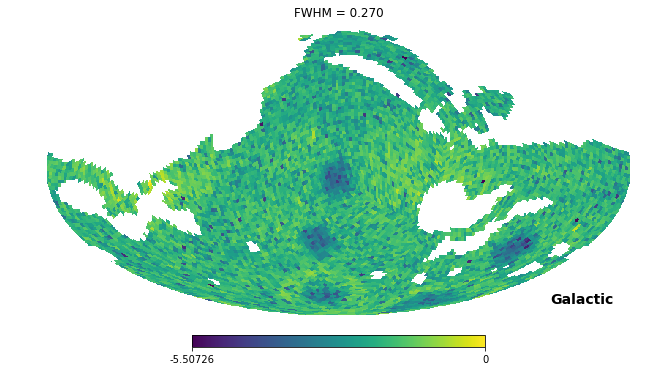

1.5707963267948966 0.0


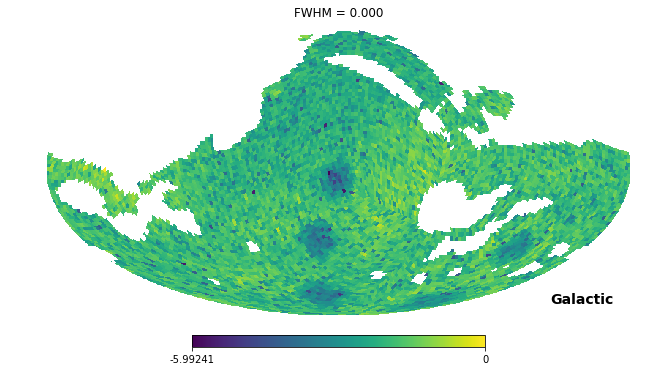

1.5707963267948966 0.0


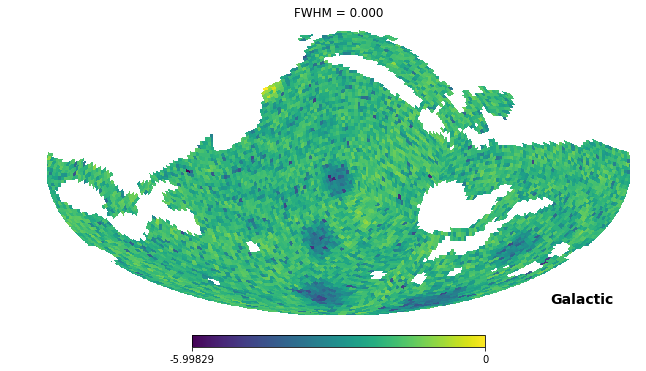

1.5707963267948963 -1.6290985217679005e-19


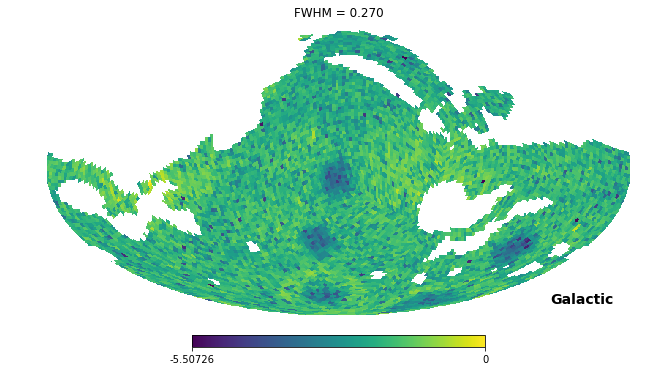

1.5707963267948966 1.958807264821564e-18


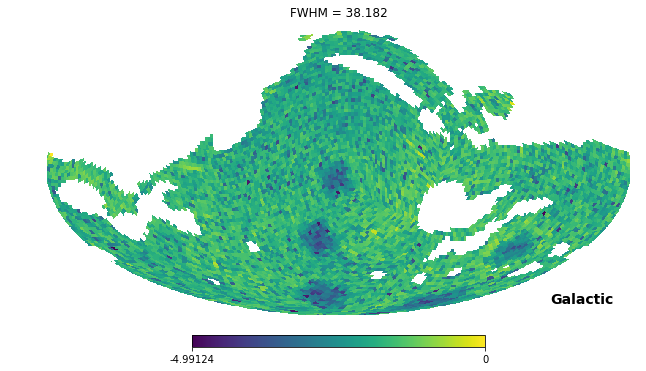

1.5707963267948966 0.0


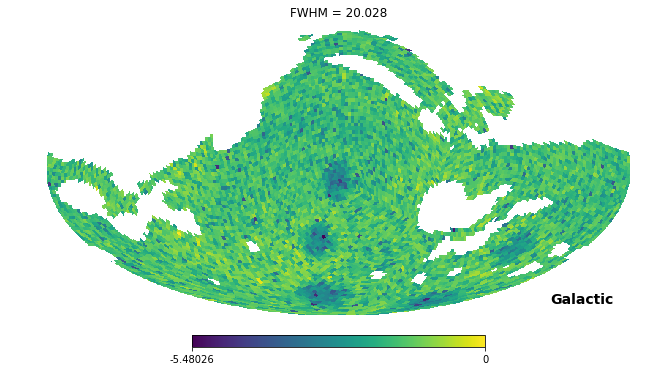

1.5707963267948966 2.248619264979488e-17


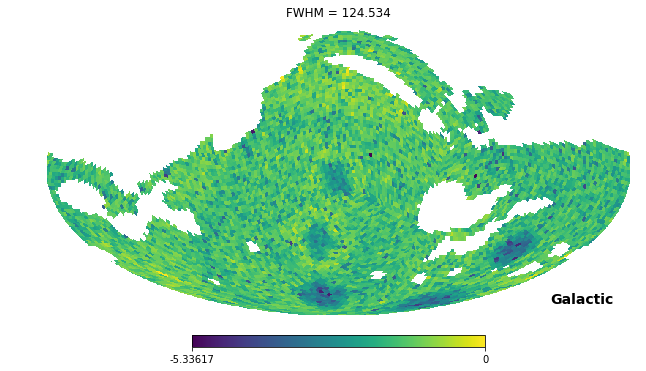

1.5707963267948966 -2.6484131277895775e-18


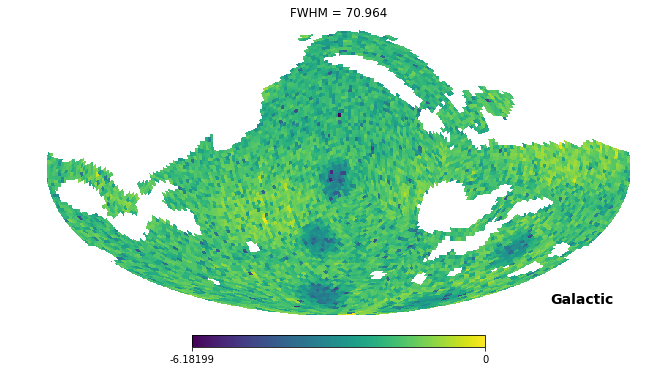

1.5707963267948966 0.0


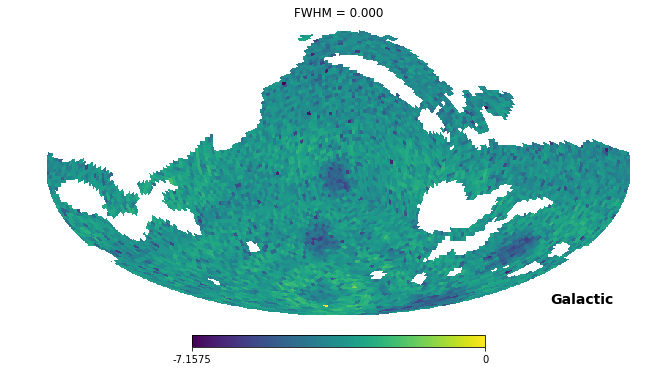

1.5707963267948966 -3.2476433001899865e-17


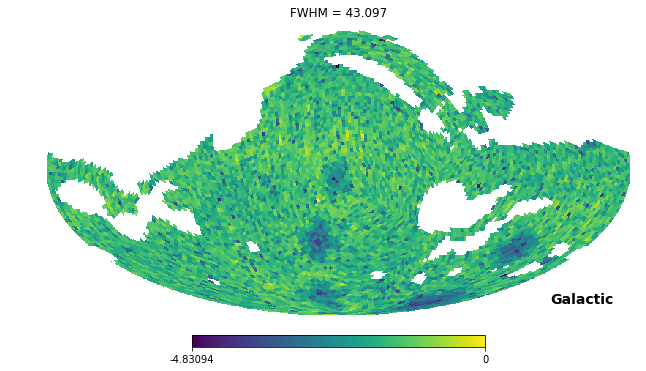

1.5707963267948966 -2.8948649063782613e-18


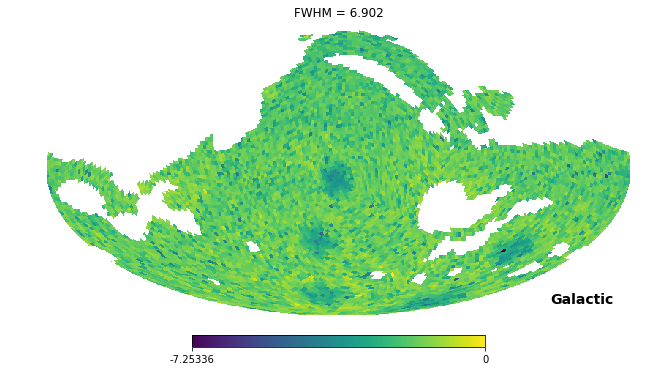

1.5707963267948966 0.0


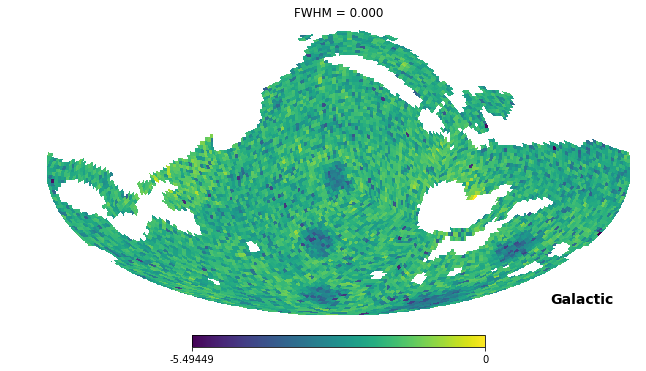

1.5707963267948966 3.469446951953614e-18


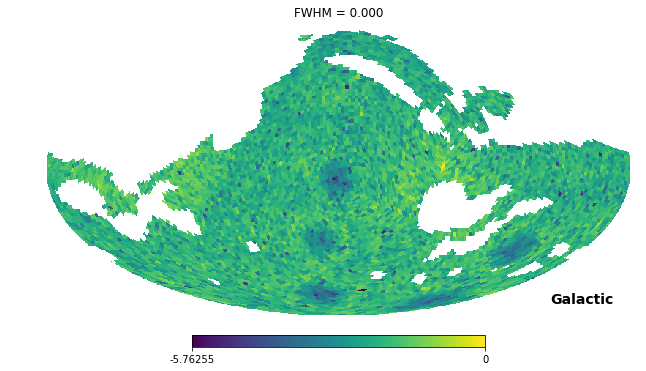

1.5707963267948966 2.7755575615628914e-17


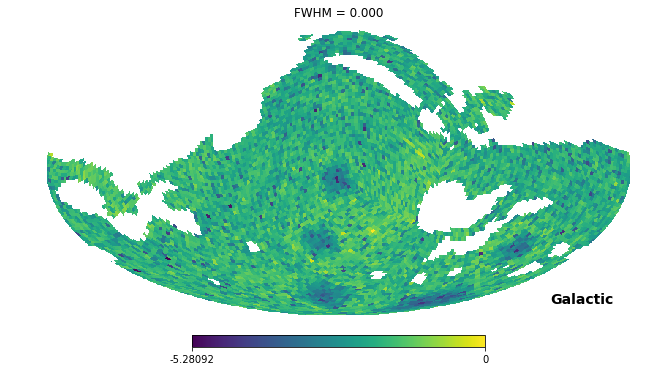

In [144]:
#S_type = 'none'
#point spread function:
if True:    # and S_type == 'none':
	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)
	
	AtNiA_tag = 'AtNiA_N%s' % vartag
	if not fit_for_additive:
		AtNiA_tag += "_noadd"
	elif crosstalk_type == 'autocorr':
		AtNiA_tag += "_autocorr"
	if pre_ampcal:
		AtNiA_tag += "_ampcal"
	AtNiA_filename = AtNiA_tag + A_filename
	AtNiA_path = datadir + tag + AtNiA_filename
	print "Reading AtNiA...",
	sys.stdout.flush()
	AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))
	
	iplot = 0
	valid_thetas_phis = np.array(zip(thetas, phis))
	full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
	# plt.clf()
	
	for theta in np.arange(0, PI * .9, PI / 6.):
		for phi in np.arange(0, TPI, PI / 3.):
			
			# choose_plots = [1, 6, 12, 18, 24, 30]
			choose_plots = [0, 1, 4, 6, 8, 12, 16, 20, 24, 28, 30, 32, 33, 35]
			
			if iplot in choose_plots:
				np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))
				point_vec = np.zeros_like(fake_solution).astype('complex128')
				
				point_vec[np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))] = 1
				spreaded = sol2map(AtNiAi.dotv(AtNiA.dot(point_vec)))
				spreaded /= np.max(spreaded)
				fwhm_mask = np.abs(spreaded) >= .5
				masked_max_ind = np.argmax(spreaded[fwhm_mask])
				fwhm_thetas = full_thetas[fwhm_mask]
				fwhm_phis = full_phis[fwhm_mask]
				# rotate angles to center around PI/2 0
				fwhm_thetas, fwhm_phis = hpr.Rotator(rot=[fwhm_phis[masked_max_ind], PI / 2 - fwhm_thetas[masked_max_ind], 0], deg=False)(fwhm_thetas, fwhm_phis)
				if np.array(fwhm_thetas).shape is ():
					fwhm_thetas = np.array([fwhm_thetas])
					fwhm_phis = np.array([fwhm_phis])
				print fwhm_thetas[masked_max_ind], fwhm_phis[masked_max_ind]  # should print 1.57079632679 0.0 if rotation is working correctly
				
				fwhm_theta = max(fwhm_thetas) - min(fwhm_thetas)
				phi_offset = fwhm_phis[masked_max_ind] - PI
				fwhm_phis = (fwhm_phis - phi_offset) % TPI + phi_offset
				fwhm_phi = max(fwhm_phis) - min(fwhm_phis)
				plt.figure(1300 + iplot)
				# hpv.mollview(np.log10(np.abs(spreaded)), min=-3, max=0, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI), sub=(len(choose_plots), 1, choose_plots.index(iplot)+1))
				hpv.mollview(np.log10(np.abs(spreaded)), nest=True, coord='CG', title='FWHM = %.3f' % ((fwhm_theta * fwhm_phi) ** .5 * 180. / PI))
				plt.savefig(script_dir + '/../Output/spreaded_function-CG-%s-%s-%s-dipole-nubl%s-nt%s-mtbin%s-mfbin%s-tbin%s-bnside-%s-nside_standard-%s-%s-recond-%s.png'%(INSTRUMENT, iplot, freq, nUBL_used, nt_used, mocal_time_bin if Absolute_Calibration_dred_mfreq else '_none', mocal_freq_bin if Absolute_Calibration_dred_mfreq else '_none', precal_time_bin if pre_calibrate else '_none', bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
				plt.show(block=False)
			# plt.gcf().clear()
			iplot += 1

sys.stdout.flush()

# Mac Code

In [145]:
additive_sol

array([1.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
      

In [146]:
time.time()/60.

25362646.397100233

In [147]:
data.shape

(1480,)

In [148]:
vis_data_dred_abscal

[[], []]

In [149]:
vis_normalization

1.0

In [150]:
I_supress

1.0